In [1]:
from platform import python_version
print(python_version())

3.9.12


In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import tensorflow as tf
from PIL import Image
import os 
import random
from glob import glob
import cv2
from tqdm import tqdm 
from skimage.io import imread
import warnings
from PIL import Image
warnings.filterwarnings('ignore')

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
mask_files = glob('lgg-mri-segmentation/kaggle_3m/*/*_mask*')
len(mask_files)

3929

In [5]:
train_files = []
for i in mask_files:
    train_files.append(i.replace('_mask', ''))
len(train_files)

3929

In [6]:
train_files[0], mask_files[0]

('lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_10.tif',
 'lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_10_mask.tif')

In [7]:
seed = 77
np.random.seed = seed

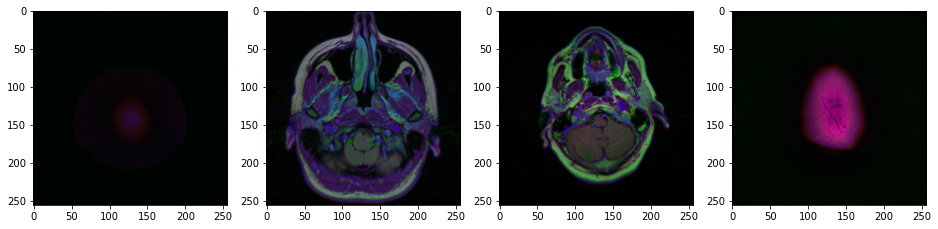

In [8]:
plt.figure(figsize=(16,20))

for i in range(4):
    file = random.choice(train_files)
    img = imread(file)
    plt.subplot(1,4,i+1)
    plt.imshow(img)

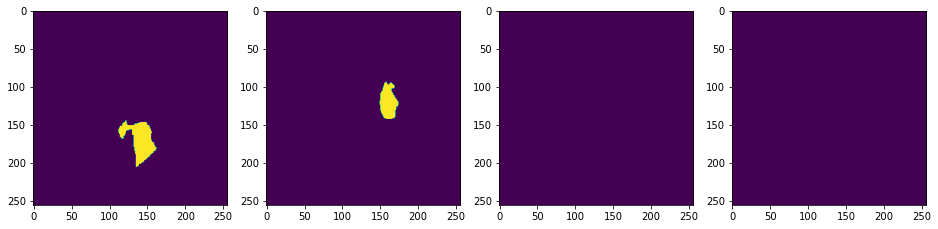

In [9]:
plt.figure(figsize=(16,20))

for i in range(4):
    file = random.choice(mask_files)
    img = imread(file)
    plt.subplot(1,4,i+1)
    plt.imshow(img)

In [10]:
train_images = []

for image_name in tqdm(train_files):
    if image_name.split('.')[1] == 'tif':
        img = cv2.imread(image_name, cv2.IMREAD_COLOR)
        img = Image.fromarray(img)
        img = img.resize((128,128)) #coz else we get resource exhausted error!
        train_images.append(np.array(img))

train_images = np.array(train_images) 

100%|██████████████████████████████████████████████████████████████████████████████| 3929/3929 [00:41<00:00, 94.86it/s]


In [11]:
train_images.shape

(3929, 128, 128, 3)

In [12]:
train_masks=[]
for mask_name in tqdm(mask_files):
    if mask_name.split('.')[1] == 'tif':
        img = cv2.imread(mask_name, 0)
        img = Image.fromarray(img)
        img = img.resize((128,128)) #coz else we get resource exhausted error!
        train_masks.append(np.array(img))

train_masks = np.array(train_masks) 

100%|█████████████████████████████████████████████████████████████████████████████| 3929/3929 [00:24<00:00, 158.51it/s]


In [13]:
train_masks.shape

(3929, 128, 128)

In [14]:
type(train_images), type(train_masks)

(numpy.ndarray, numpy.ndarray)

In [15]:
#Normalize images
train_images = train_images/255.

train_masks = np.expand_dims(train_masks, axis=-1)/255.

In [16]:
train_images.shape, train_masks.shape

((3929, 128, 128, 3), (3929, 128, 128, 1))

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
X_train, X_test, y_train, y_test = train_test_split(train_images, train_masks, test_size=0.15, random_state=77)

In [19]:
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.15, random_state=77)

In [20]:
X_train.shape, X_validation.shape, X_test.shape

((2838, 128, 128, 3), (501, 128, 128, 3), (590, 128, 128, 3))

In [21]:
y_train.shape, y_validation.shape, y_test.shape

((2838, 128, 128, 1), (501, 128, 128, 1), (590, 128, 128, 1))

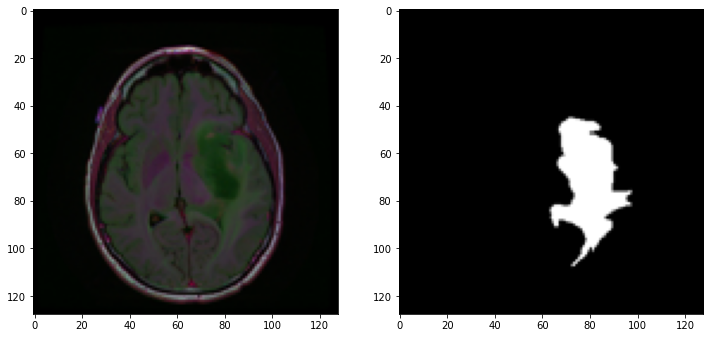

In [22]:
#Sanity check

image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(X_train[image_number], (128, 128, 3)), cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (128, 128)), cmap='gray')
plt.show()

In [23]:
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras import backend as K

In [24]:
def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

In [25]:
def conv_block(x, filter_size, size, dropout, batch_norm=False):
    conv = layers.SeparableConv2D(size, (filter_size, filter_size), padding="same")(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)

    conv = layers.SeparableConv2D(size, (filter_size, filter_size), padding="same")(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)
    
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    return conv


def repeat_elem(tensor, rep):
     return layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3), arguments={'repnum': rep})(tensor)


def res_conv_block(x, filter_size, size, dropout, batch_norm=False):
    conv = layers.SeparableConv2D(size, (filter_size, filter_size), padding='same')(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation('relu')(conv)
    
    conv = layers.SeparableConv2D(size, (filter_size, filter_size), padding='same')(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    shortcut = layers.SeparableConv2D(size, kernel_size=(1, 1), padding='same')(x)
    if batch_norm is True:
        shortcut = layers.BatchNormalization(axis=3)(shortcut)

    res_path = layers.add([shortcut, conv])
    res_path = layers.Activation('relu')(res_path)    #Activation after addition with shortcut (Original residual block)
    return res_path

def gating_signal(input, out_size, batch_norm=False):
    x = layers.SeparableConv2D(out_size, (1, 1), padding='same')(input)
    if batch_norm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

def attention_block(x, gating, inter_shape):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

    theta_x = layers.SeparableConv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)  # 16
    shape_theta_x = K.int_shape(theta_x)

    phi_g = layers.SeparableConv2D(inter_shape, (1, 1), padding='same')(gating)
    upsample_g = layers.Conv2DTranspose(inter_shape, (3, 3),
                                 strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
                                 padding='same')(phi_g)

    concat_xg = layers.add([upsample_g, theta_x])
    act_xg = layers.Activation('relu')(concat_xg)
    psi = layers.SeparableConv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = layers.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

    upsample_psi = repeat_elem(upsample_psi, shape_x[3])

    y = layers.multiply([upsample_psi, x])

    result = layers.SeparableConv2D(shape_x[3], (1, 1), padding='same')(y)
    result_bn = layers.BatchNormalization()(result)
    return result_bn

In [26]:
def Attention_ResUNet(input_shape, NUM_CLASSES=1, dropout_rate=0.0, batch_norm=True):
    FILTER_NUM = 64 # number of basic filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters
    # input data
    # dimension of the image depth
    inputs = layers.Input(input_shape, dtype=tf.float32)
    axis = 3

    # Downsampling layers
    # DownRes 1, double residual convolution + pooling
    conv_128 = res_conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 2
    conv_64 = res_conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 3
    conv_32 = res_conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 4
    conv_16 = res_conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
    # DownRes 5, convolution only
    conv_8 = res_conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers
    # UpRes 6, attention gated concatenation + upsampling + double residual convolution
    gating_16 = gating_signal(conv_8, 8*FILTER_NUM, batch_norm)
    att_16 = attention_block(conv_16, gating_16, 8*FILTER_NUM)
    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = layers.concatenate([up_16, att_16], axis=axis)
    up_conv_16 = res_conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 7
    gating_32 = gating_signal(up_conv_16, 4*FILTER_NUM, batch_norm)
    att_32 = attention_block(conv_32, gating_32, 4*FILTER_NUM)
    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, att_32], axis=axis)
    up_conv_32 = res_conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 8
    gating_64 = gating_signal(up_conv_32, 2*FILTER_NUM, batch_norm)
    att_64 = attention_block(conv_64, gating_64, 2*FILTER_NUM)
    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, att_64], axis=axis)
    up_conv_64 = res_conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 9
    gating_128 = gating_signal(up_conv_64, FILTER_NUM, batch_norm)
    att_128 = attention_block(conv_128, gating_128, FILTER_NUM)
    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, att_128], axis=axis)
    up_conv_128 = res_conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers
    
    conv_final = layers.SeparableConv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=axis)(conv_final)
    conv_final = layers.Activation('sigmoid')(conv_final)  #Change to softmax for multichannel

    # Model integration
    model = models.Model(inputs, conv_final, name="AttentionResUNet")
    return model

In [27]:
# input_shape = (128,128,3)
# Attention_ResUNet(input_shape, NUM_CLASSES=1, dropout_rate=0.0, batch_norm=True)

In [28]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]
num_labels = 1  #Binary
input_shape = (IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)
batch_size = 16

In [29]:
input_shape

(128, 128, 3)

In [31]:
from focal_loss import BinaryFocalLoss
from tensorflow.keras.utils import plot_model

In [32]:
model = Attention_ResUNet(input_shape)


optimizer_ = tf.keras.optimizers.Adam(lr=0.01)
model.compile(optimizer_, loss=BinaryFocalLoss(gamma=2), metrics=['accuracy', jacard_coef])
print(model.summary())

Model: "AttentionResUNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 separable_conv2d (SeparableCon  (None, 128, 128, 64  283        ['input_1[0][0]']                
 v2D)                           )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 64  256        ['separable_conv2d[0][0]']       
 alization)                     )                                                  

                                                                  'batch_normalization_7[0][0]']  
                                                                                                  
 activation_5 (Activation)      (None, 32, 32, 256)  0           ['add_2[0][0]']                  
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 16, 16, 256)  0          ['activation_5[0][0]']           
                                                                                                  
 separable_conv2d_9 (SeparableC  (None, 16, 16, 512)  133888     ['max_pooling2d_2[0][0]']        
 onv2D)                                                                                           
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 16, 16, 512)  2048       ['separable_conv2d_9[0][0]']     
 rmalizati

 activation_12 (Activation)     (None, 8, 8, 1)      0           ['separable_conv2d_18[0][0]']    
                                                                                                  
 up_sampling2d (UpSampling2D)   (None, 16, 16, 1)    0           ['activation_12[0][0]']          
                                                                                                  
 lambda (Lambda)                (None, 16, 16, 512)  0           ['up_sampling2d[0][0]']          
                                                                                                  
 multiply (Multiply)            (None, 16, 16, 512)  0           ['lambda[0][0]',                 
                                                                  'activation_7[0][0]']           
                                                                                                  
 separable_conv2d_19 (Separable  (None, 16, 16, 512)  263168     ['multiply[0][0]']               
 Conv2D)  

 up_sampling2d_3 (UpSampling2D)  (None, 32, 32, 512)  0          ['activation_14[0][0]']          
                                                                                                  
 batch_normalization_21 (BatchN  (None, 32, 32, 256)  1024       ['separable_conv2d_27[0][0]']    
 ormalization)                                                                                    
                                                                                                  
 concatenate_1 (Concatenate)    (None, 32, 32, 768)  0           ['up_sampling2d_3[0][0]',        
                                                                  'batch_normalization_21[0][0]'] 
                                                                                                  
 separable_conv2d_28 (Separable  (None, 32, 32, 256)  203776     ['concatenate_1[0][0]']          
 Conv2D)                                                                                          
          

                                                                                                  
 activation_23 (Activation)     (None, 64, 64, 128)  0           ['batch_normalization_27[0][0]'] 
                                                                                                  
 separable_conv2d_38 (Separable  (None, 64, 64, 128)  49664      ['concatenate_2[0][0]']          
 Conv2D)                                                                                          
                                                                                                  
 separable_conv2d_37 (Separable  (None, 64, 64, 128)  17664      ['activation_23[0][0]']          
 Conv2D)                                                                                          
                                                                                                  
 batch_normalization_29 (BatchN  (None, 64, 64, 128)  512        ['separable_conv2d_38[0][0]']    
 ormalizat

 ormalization)                  )                                                                 
                                                                                                  
 batch_normalization_33 (BatchN  (None, 128, 128, 64  256        ['separable_conv2d_45[0][0]']    
 ormalization)                  )                                                                 
                                                                                                  
 add_12 (Add)                   (None, 128, 128, 64  0           ['batch_normalization_34[0][0]', 
                                )                                 'batch_normalization_33[0][0]'] 
                                                                                                  
 activation_29 (Activation)     (None, 128, 128, 64  0           ['add_12[0][0]']                 
                                )                                                                 
          

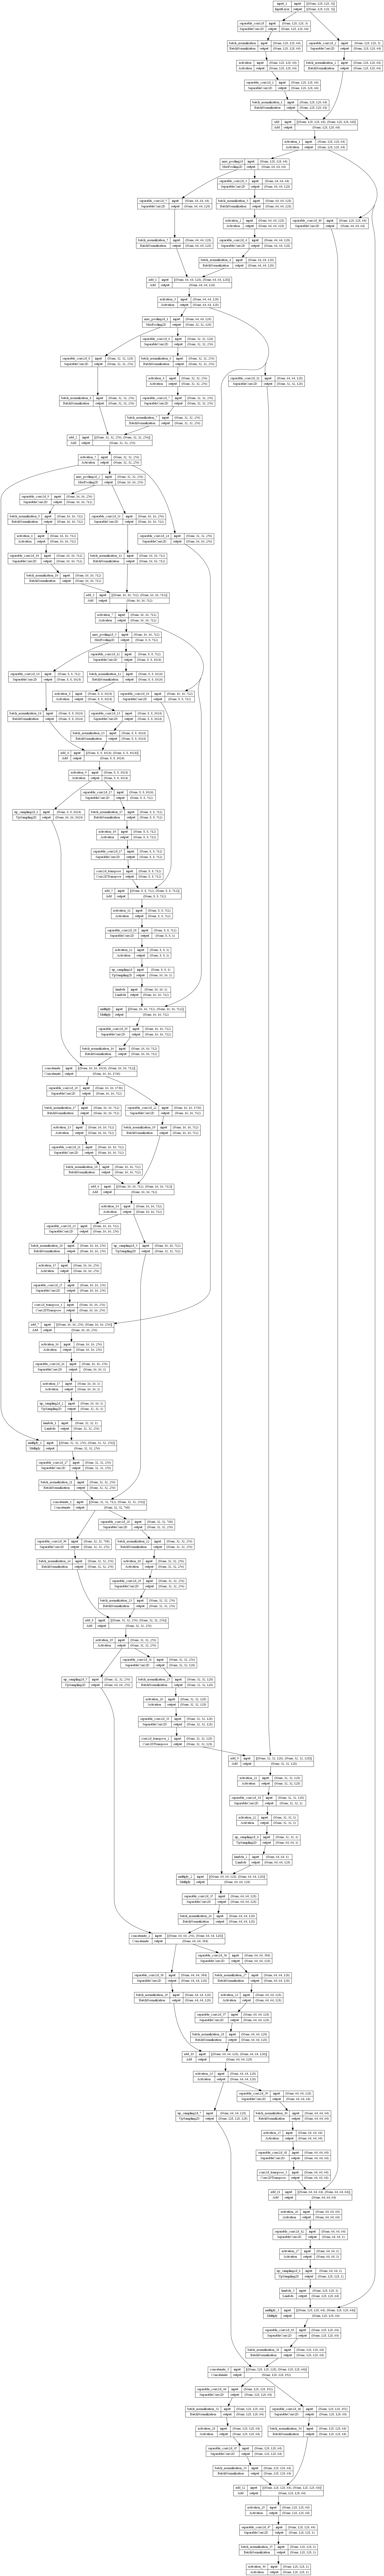

In [33]:
plot_model(model, to_file='AttentionBasedResidualUNetforBrainMRISegmentation.png', show_shapes=True, show_layer_names=True)

In [34]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from datetime import datetime 

In [37]:
checkpointer = ModelCheckpoint(filepath = 'saved_checkpoints/AttentionBasedResidualUNetforBrainMRISegmentation/checkpoint', 
                               verbose=1, save_best_only=True, monitor='val_loss', mode='min', save_weights_only=True)

early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)


reduce_lr_on_plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.5, mode='min', patience=10, verbose=1, min_lr=0.00005)


start = datetime.now()


trained_model = model.fit(X_train, y_train, epochs=100, batch_size=batch_size, validation_data=(X_validation, y_validation), 
          callbacks=[checkpointer, early_stop, reduce_lr_on_plateau], shuffle=False, verbose=1)


duration = datetime.now() - start

print("Training completed in {}".format(duration))

Epoch 1/100
178/178 [==============================] - ETA: 0s - loss: 0.0716 - accuracy: 0.9409 - jacard_coef: 0.0103
Epoch 1: val_loss improved from inf to 0.03058, saving model to saved_checkpoints/AttentionBasedResidualUNetforBrainMRISegmentation\checkpoint
178/178 [==============================] - 81s 383ms/step - loss: 0.0716 - accuracy: 0.9409 - jacard_coef: 0.0103 - val_loss: 0.0306 - val_accuracy: 0.9879 - val_jacard_coef: 0.0101 - lr: 0.0100
Epoch 2/100
178/178 [==============================] - ETA: 0s - loss: 0.0198 - accuracy: 0.9886 - jacard_coef: 0.0184
Epoch 2: val_loss improved from 0.03058 to 0.01540, saving model to saved_checkpoints/AttentionBasedResidualUNetforBrainMRISegmentation\checkpoint
178/178 [==============================] - 66s 373ms/step - loss: 0.0198 - accuracy: 0.9886 - jacard_coef: 0.0184 - val_loss: 0.0154 - val_accuracy: 0.9901 - val_jacard_coef: 0.0229 - lr: 0.0100
Epoch 3/100
178/178 [==============================] - ETA: 0s - loss: 0.0107 - ac

Epoch 22/100
178/178 [==============================] - ETA: 0s - loss: 0.0019 - accuracy: 0.9949 - jacard_coef: 0.1403
Epoch 22: val_loss did not improve from 0.00252
178/178 [==============================] - 66s 371ms/step - loss: 0.0019 - accuracy: 0.9949 - jacard_coef: 0.1403 - val_loss: 0.0025 - val_accuracy: 0.9948 - val_jacard_coef: 0.1276 - lr: 0.0100
Epoch 23/100
178/178 [==============================] - ETA: 0s - loss: 0.0017 - accuracy: 0.9950 - jacard_coef: 0.1467
Epoch 23: val_loss did not improve from 0.00252
178/178 [==============================] - 66s 371ms/step - loss: 0.0017 - accuracy: 0.9950 - jacard_coef: 0.1467 - val_loss: 0.0027 - val_accuracy: 0.9943 - val_jacard_coef: 0.1252 - lr: 0.0100
Epoch 24/100
178/178 [==============================] - ETA: 0s - loss: 0.0014 - accuracy: 0.9952 - jacard_coef: 0.1551
Epoch 24: val_loss improved from 0.00252 to 0.00200, saving model to saved_checkpoints/AttentionBasedResidualUNetforBrainMRISegmentation\checkpoint
178/17

Epoch 44/100
178/178 [==============================] - ETA: 0s - loss: 9.1874e-04 - accuracy: 0.9955 - jacard_coef: 0.2430
Epoch 44: val_loss did not improve from 0.00167
178/178 [==============================] - 66s 370ms/step - loss: 9.1874e-04 - accuracy: 0.9955 - jacard_coef: 0.2430 - val_loss: 0.0017 - val_accuracy: 0.9953 - val_jacard_coef: 0.2425 - lr: 0.0050
Epoch 45/100
178/178 [==============================] - ETA: 0s - loss: 8.7147e-04 - accuracy: 0.9956 - jacard_coef: 0.2492
Epoch 45: val_loss did not improve from 0.00167
178/178 [==============================] - 67s 378ms/step - loss: 8.7147e-04 - accuracy: 0.9956 - jacard_coef: 0.2492 - val_loss: 0.0018 - val_accuracy: 0.9953 - val_jacard_coef: 0.2492 - lr: 0.0050
Epoch 46/100
178/178 [==============================] - ETA: 0s - loss: 8.4285e-04 - accuracy: 0.9956 - jacard_coef: 0.2544
Epoch 46: val_loss did not improve from 0.00167
178/178 [==============================] - 66s 372ms/step - loss: 8.4285e-04 - accurac

Epoch 66/100
178/178 [==============================] - ETA: 0s - loss: 5.3408e-04 - accuracy: 0.9958 - jacard_coef: 0.3185
Epoch 66: val_loss did not improve from 0.00167
178/178 [==============================] - 66s 371ms/step - loss: 5.3408e-04 - accuracy: 0.9958 - jacard_coef: 0.3185 - val_loss: 0.0027 - val_accuracy: 0.9953 - val_jacard_coef: 0.2991 - lr: 0.0012
Epoch 67/100
178/178 [==============================] - ETA: 0s - loss: 5.2513e-04 - accuracy: 0.9958 - jacard_coef: 0.3209
Epoch 67: val_loss did not improve from 0.00167
178/178 [==============================] - 66s 372ms/step - loss: 5.2513e-04 - accuracy: 0.9958 - jacard_coef: 0.3209 - val_loss: 0.0027 - val_accuracy: 0.9952 - val_jacard_coef: 0.3026 - lr: 0.0012
Epoch 67: early stopping
Training completed in 1:14:14.509276


In [35]:
model.load_weights('saved_checkpoints/AttentionBasedResidualUNetforBrainMRISegmentation/checkpoint')

In [39]:
# model.save("models/AttentionBasedResidualUNetforBrainMRISegmentation.h5")

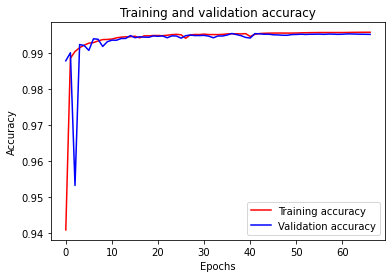

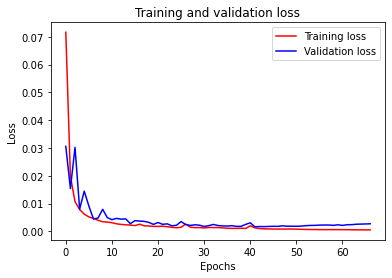

In [42]:
accuracy = trained_model.history['accuracy']
val_accuracy = trained_model.history['val_accuracy']
loss = trained_model.history['loss']
val_loss = trained_model.history['val_loss']
epochs = list(range(0,67))

plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [36]:
from tensorflow.keras.metrics import MeanIoU
n_classes = 2

In [42]:
IoU_values = []
for img in tqdm(range(0, X_test.shape[0])):
    temp_img = X_test[img]
    ground_truth=y_test[img]
    temp_img_input=np.expand_dims(temp_img, 0)
    prediction = (model.predict(temp_img_input)[0,:,:,0] > 0.7).astype(np.uint8)
    
    IoU = MeanIoU(num_classes=n_classes)
    IoU.update_state(ground_truth[:,:,0], prediction)
    IoU = IoU.result().numpy()
    IoU_values.append(IoU)

    print(IoU)
    


df = pd.DataFrame(IoU_values, columns=["IoU"])
df = df[df.IoU != 1.0]    
mean_IoU = df.mean().values
print("Mean IoU is: ", mean_IoU) 

  0%|                                                                                          | 0/590 [00:00<?, ?it/s]

1/1 [==============================] - 0s 35ms/step


  0%|▏                                                                                 | 1/590 [00:00<02:49,  3.48it/s]

1.0
1/1 [==============================] - 0s 34ms/step
0.49954224
1/1 [==============================] - 0s 55ms/step


  1%|▍                                                                                 | 3/590 [00:00<01:30,  6.51it/s]

1.0
1/1 [==============================] - 0s 37ms/step


  1%|▌                                                                                 | 4/590 [00:00<01:20,  7.32it/s]

1.0
1/1 [==============================] - 0s 33ms/step
0.85471845
1/1 [==============================] - 0s 35ms/step


  1%|▊                                                                                 | 6/590 [00:00<01:05,  8.94it/s]

1.0
1/1 [==============================] - 0s 32ms/step
1.0
1/1 [==============================] - 0s 62ms/step


  1%|█                                                                                 | 8/590 [00:01<01:06,  8.69it/s]

0.8466382
1/1 [==============================] - 0s 40ms/step


  2%|█▎                                                                                | 9/590 [00:01<01:06,  8.72it/s]

1.0
1/1 [==============================] - 0s 34ms/step
1.0
1/1 [==============================] - 0s 37ms/step


  2%|█▌                                                                               | 11/590 [00:01<01:00,  9.50it/s]

1.0
1/1 [==============================] - 0s 35ms/step


  2%|█▋                                                                               | 12/590 [00:01<01:00,  9.50it/s]

1.0
1/1 [==============================] - 0s 42ms/step
1.0
1/1 [==============================] - 0s 33ms/step


  2%|█▉                                                                               | 14/590 [00:01<00:57, 10.00it/s]

1.0
1/1 [==============================] - 0s 57ms/step
1.0
1/1 [==============================] - 0s 38ms/step


  3%|██▏                                                                              | 16/590 [00:01<00:59,  9.60it/s]

0.883584
1/1 [==============================] - 0s 37ms/step
1.0
1/1 [==============================] - 0s 36ms/step


  3%|██▍                                                                              | 18/590 [00:02<00:56, 10.07it/s]

1.0
1/1 [==============================] - 0s 37ms/step
1.0
1/1 [==============================] - 0s 34ms/step


  3%|██▋                                                                              | 20/590 [00:02<00:56, 10.11it/s]

1.0
1/1 [==============================] - 0s 35ms/step
1.0
1/1 [==============================] - 0s 34ms/step


  4%|███                                                                              | 22/590 [00:02<00:55, 10.29it/s]

1.0
1/1 [==============================] - 0s 35ms/step
1.0
1/1 [==============================] - 0s 36ms/step


  4%|███▎                                                                             | 24/590 [00:02<00:55, 10.22it/s]

1.0
1/1 [==============================] - 0s 35ms/step
0.745036
1/1 [==============================] - 0s 39ms/step


  4%|███▌                                                                             | 26/590 [00:02<00:55, 10.14it/s]

1.0
1/1 [==============================] - 0s 36ms/step
1.0
1/1 [==============================] - 0s 36ms/step


  5%|███▊                                                                             | 28/590 [00:02<00:55, 10.08it/s]

1.0
1/1 [==============================] - 0s 35ms/step
1.0
1/1 [==============================] - 0s 37ms/step


  5%|████                                                                             | 30/590 [00:03<00:56,  9.99it/s]

1.0
1/1 [==============================] - 0s 38ms/step
1.0
1/1 [==============================] - 0s 33ms/step


  5%|████▍                                                                            | 32/590 [00:03<00:55, 10.00it/s]

0.8071549
1/1 [==============================] - 0s 34ms/step
1.0
1/1 [==============================] - 0s 40ms/step


  6%|████▋                                                                            | 34/590 [00:03<00:55, 10.03it/s]

1.0
1/1 [==============================] - 0s 33ms/step
1.0
1/1 [==============================] - 0s 31ms/step


  6%|████▉                                                                            | 36/590 [00:03<00:55, 10.07it/s]

1.0
1/1 [==============================] - 0s 44ms/step
1.0
1/1 [==============================] - 0s 45ms/step


  6%|█████▏                                                                           | 38/590 [00:04<00:56,  9.75it/s]

1.0
1/1 [==============================] - 0s 36ms/step


  7%|█████▎                                                                           | 39/590 [00:04<00:56,  9.68it/s]

0.88528514
1/1 [==============================] - 0s 34ms/step


  7%|█████▍                                                                           | 40/590 [00:04<00:56,  9.72it/s]

1.0
1/1 [==============================] - 0s 40ms/step


  7%|█████▋                                                                           | 41/590 [00:04<00:57,  9.62it/s]

0.9226489
1/1 [==============================] - 0s 47ms/step


  7%|█████▊                                                                           | 42/590 [00:04<01:00,  9.12it/s]

1.0
1/1 [==============================] - 0s 35ms/step


  7%|█████▉                                                                           | 43/590 [00:04<00:59,  9.13it/s]

0.85545266
1/1 [==============================] - 0s 34ms/step


  7%|██████                                                                           | 44/590 [00:04<00:59,  9.17it/s]

1.0
1/1 [==============================] - 0s 34ms/step


  8%|██████▏                                                                          | 45/590 [00:04<00:58,  9.28it/s]

0.7943828
1/1 [==============================] - 0s 36ms/step


  8%|██████▎                                                                          | 46/590 [00:04<00:58,  9.28it/s]

0.8994806
1/1 [==============================] - 0s 33ms/step


  8%|██████▍                                                                          | 47/590 [00:04<00:58,  9.35it/s]

1.0
1/1 [==============================] - 0s 37ms/step


  8%|██████▌                                                                          | 48/590 [00:05<00:59,  9.14it/s]

1.0
1/1 [==============================] - 0s 34ms/step


  8%|██████▋                                                                          | 49/590 [00:05<01:00,  8.91it/s]

1.0
1/1 [==============================] - 0s 35ms/step


  8%|██████▊                                                                          | 50/590 [00:05<00:59,  9.04it/s]

1.0
1/1 [==============================] - 0s 33ms/step


  9%|███████                                                                          | 51/590 [00:05<00:59,  9.06it/s]

0.88623726
1/1 [==============================] - 0s 35ms/step


  9%|███████▏                                                                         | 52/590 [00:05<00:58,  9.23it/s]

1.0
1/1 [==============================] - 0s 38ms/step


  9%|███████▎                                                                         | 53/590 [00:05<00:57,  9.31it/s]

1.0
1/1 [==============================] - 0s 33ms/step


  9%|███████▍                                                                         | 54/590 [00:05<00:56,  9.45it/s]

1.0
1/1 [==============================] - 0s 37ms/step


  9%|███████▌                                                                         | 55/590 [00:05<00:56,  9.52it/s]

0.90288067
1/1 [==============================] - 0s 31ms/step


  9%|███████▋                                                                         | 56/590 [00:05<00:55,  9.54it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 10%|███████▊                                                                         | 57/590 [00:06<00:55,  9.56it/s]

0.9033214
1/1 [==============================] - 0s 44ms/step


 10%|███████▉                                                                         | 58/590 [00:06<00:56,  9.49it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 10%|████████                                                                         | 59/590 [00:06<00:55,  9.62it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 10%|████████▏                                                                        | 60/590 [00:06<00:55,  9.59it/s]

1.0
1/1 [==============================] - 0s 41ms/step


 10%|████████▎                                                                        | 61/590 [00:06<00:56,  9.32it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 11%|████████▌                                                                        | 62/590 [00:06<00:55,  9.45it/s]

0.4951477
1/1 [==============================] - 0s 32ms/step


 11%|████████▋                                                                        | 63/590 [00:06<00:55,  9.56it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 11%|████████▊                                                                        | 64/590 [00:06<00:54,  9.64it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 11%|████████▉                                                                        | 65/590 [00:06<00:56,  9.30it/s]

1.0
1/1 [==============================] - 0s 31ms/step


 11%|█████████                                                                        | 66/590 [00:07<00:55,  9.48it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 11%|█████████▏                                                                       | 67/590 [00:07<00:55,  9.44it/s]

1.0
1/1 [==============================] - 0s 51ms/step


 12%|█████████▎                                                                       | 68/590 [00:07<00:59,  8.80it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 12%|█████████▍                                                                       | 69/590 [00:07<01:04,  8.09it/s]

0.9108509
1/1 [==============================] - 0s 48ms/step


 12%|█████████▌                                                                       | 70/590 [00:07<01:07,  7.69it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 12%|█████████▋                                                                       | 71/590 [00:07<01:07,  7.68it/s]

1.0
1/1 [==============================] - 0s 42ms/step


 12%|█████████▉                                                                       | 72/590 [00:07<01:07,  7.69it/s]

0.49993896
1/1 [==============================] - 0s 35ms/step


 12%|██████████                                                                       | 73/590 [00:07<01:07,  7.66it/s]

1.0
1/1 [==============================] - 0s 32ms/step
1.0
1/1 [==============================] - 0s 34ms/step


 13%|██████████▎                                                                      | 75/590 [00:08<00:58,  8.87it/s]

1.0
1/1 [==============================] - 0s 41ms/step
1.0
1/1 [==============================] - 0s 35ms/step


 13%|██████████▌                                                                      | 77/590 [00:08<00:55,  9.32it/s]

0.8923303
1/1 [==============================] - 0s 34ms/step
1.0
1/1 [==============================] - 0s 45ms/step


 13%|██████████▊                                                                      | 79/590 [00:08<00:53,  9.56it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 14%|██████████▉                                                                      | 80/590 [00:08<00:52,  9.64it/s]

1.0
1/1 [==============================] - 0s 35ms/step
1.0
1/1 [==============================] - 0s 56ms/step


 14%|███████████▎                                                                     | 82/590 [00:08<00:52,  9.66it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 14%|███████████▍                                                                     | 83/590 [00:08<00:52,  9.71it/s]

0.8471087
1/1 [==============================] - 0s 37ms/step


 14%|███████████▌                                                                     | 84/590 [00:09<00:51,  9.74it/s]

1.0
1/1 [==============================] - 0s 32ms/step
1.0
1/1 [==============================] - 0s 37ms/step


 15%|███████████▊                                                                     | 86/590 [00:09<00:50, 10.03it/s]

1.0
1/1 [==============================] - 0s 47ms/step


 15%|███████████▉                                                                     | 87/590 [00:09<00:51,  9.78it/s]

0.82373774
1/1 [==============================] - 0s 29ms/step


 15%|████████████                                                                     | 88/590 [00:09<00:51,  9.80it/s]

1.0
1/1 [==============================] - 0s 39ms/step
1.0
1/1 [==============================] - 0s 39ms/step


 15%|████████████▎                                                                    | 90/590 [00:09<00:50, 10.00it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 15%|████████████▍                                                                    | 91/590 [00:09<00:50,  9.94it/s]

0.7615994
1/1 [==============================] - 0s 35ms/step


 16%|████████████▋                                                                    | 92/590 [00:09<00:53,  9.24it/s]

0.49987793
1/1 [==============================] - 0s 40ms/step


 16%|████████████▊                                                                    | 93/590 [00:10<01:01,  8.14it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 16%|████████████▉                                                                    | 94/590 [00:10<01:02,  7.90it/s]

0.8661728
1/1 [==============================] - 0s 45ms/step


 16%|█████████████                                                                    | 95/590 [00:10<00:59,  8.36it/s]

1.0
1/1 [==============================] - 0s 38ms/step
1.0
1/1 [==============================] - 0s 39ms/step


 16%|█████████████▎                                                                   | 97/590 [00:10<00:53,  9.16it/s]

1.0
1/1 [==============================] - 0s 38ms/step
1.0
1/1 [==============================] - 0s 37ms/step
1.0


 17%|█████████████▌                                                                   | 99/590 [00:10<00:50,  9.65it/s]

1/1 [==============================] - 0s 35ms/step
1.0
1/1 [==============================] - 0s 35ms/step


 17%|█████████████▋                                                                  | 101/590 [00:10<00:48, 10.17it/s]

1.0
1/1 [==============================] - 0s 45ms/step
1.0
1/1 [==============================] - 0s 34ms/step


 17%|█████████████▉                                                                  | 103/590 [00:11<00:47, 10.25it/s]

0.4970703
1/1 [==============================] - 0s 36ms/step
1.0
1/1 [==============================] - 0s 50ms/step


 18%|██████████████▏                                                                 | 105/590 [00:11<00:48, 10.02it/s]

0.88466036
1/1 [==============================] - 0s 48ms/step


 18%|██████████████▎                                                                 | 106/590 [00:11<00:48,  9.88it/s]

1.0
1/1 [==============================] - 0s 39ms/step
1.0
1/1 [==============================] - 0s 39ms/step


 18%|██████████████▋                                                                 | 108/590 [00:11<00:46, 10.26it/s]

1.0
1/1 [==============================] - 0s 48ms/step
1.0
1/1 [==============================] - 0s 38ms/step


 19%|██████████████▉                                                                 | 110/590 [00:11<00:47, 10.09it/s]

1.0
1/1 [==============================] - 0s 37ms/step
0.90746844
1/1 [==============================] - 0s 38ms/step


 19%|███████████████▏                                                                | 112/590 [00:11<00:47, 10.06it/s]

0.82802796
1/1 [==============================] - 0s 44ms/step
0.7751453
1/1 [==============================] - 0s 35ms/step


 19%|███████████████▍                                                                | 114/590 [00:12<00:48,  9.83it/s]

0.88742095
1/1 [==============================] - 0s 33ms/step
1.0
1/1 [==============================] - 0s 42ms/step


 20%|███████████████▋                                                                | 116/590 [00:12<00:48,  9.81it/s]

0.80319035
1/1 [==============================] - 0s 31ms/step
1.0
1/1 [==============================] - 0s 32ms/step


 20%|████████████████                                                                | 118/590 [00:12<00:46, 10.08it/s]

1.0
1/1 [==============================] - 0s 39ms/step
0.7240459
1/1 [==============================] - 0s 38ms/step


 20%|████████████████▎                                                               | 120/590 [00:12<00:46, 10.10it/s]

0.90671265
1/1 [==============================] - 0s 34ms/step
1.0
1/1 [==============================] - 0s 34ms/step


 21%|████████████████▌                                                               | 122/590 [00:12<00:46, 10.07it/s]

0.87841105
1/1 [==============================] - 0s 57ms/step
1.0
1/1 [==============================] - 0s 37ms/step


 21%|████████████████▊                                                               | 124/590 [00:13<00:48,  9.60it/s]

1.0
1/1 [==============================] - 0s 41ms/step


 21%|████████████████▉                                                               | 125/590 [00:13<00:48,  9.58it/s]

1.0
1/1 [==============================] - 0s 39ms/step
0.86540675
1/1 [==============================] - 0s 35ms/step


 22%|█████████████████▏                                                              | 127/590 [00:13<00:47,  9.78it/s]

0.8870939
1/1 [==============================] - 0s 36ms/step


 22%|█████████████████▎                                                              | 128/590 [00:13<00:47,  9.72it/s]

1.0
1/1 [==============================] - 0s 46ms/step


 22%|█████████████████▍                                                              | 129/590 [00:13<00:48,  9.49it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 22%|█████████████████▋                                                              | 130/590 [00:13<00:47,  9.59it/s]

1.0
1/1 [==============================] - 0s 43ms/step


 22%|█████████████████▊                                                              | 131/590 [00:13<00:48,  9.54it/s]

0.87840134
1/1 [==============================] - 0s 45ms/step


 22%|█████████████████▉                                                              | 132/590 [00:14<00:52,  8.71it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 23%|██████████████████                                                              | 133/590 [00:14<00:54,  8.36it/s]

0.93024576
1/1 [==============================] - 0s 38ms/step


 23%|██████████████████▏                                                             | 134/590 [00:14<00:55,  8.18it/s]

1.0
1/1 [==============================] - 0s 38ms/step


 23%|██████████████████▎                                                             | 135/590 [00:14<00:56,  8.11it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 23%|██████████████████▍                                                             | 136/590 [00:14<00:56,  8.03it/s]

0.87057036
1/1 [==============================] - 0s 40ms/step


 23%|██████████████████▌                                                             | 137/590 [00:14<00:57,  7.82it/s]

0.8351602
1/1 [==============================] - 0s 37ms/step


 23%|██████████████████▋                                                             | 138/590 [00:14<00:56,  8.00it/s]

0.9252325
1/1 [==============================] - 0s 36ms/step
0.913659
1/1 [==============================] - 0s 31ms/step


 24%|██████████████████▉                                                             | 140/590 [00:14<00:49,  9.04it/s]

1.0
1/1 [==============================] - 0s 42ms/step


 24%|███████████████████                                                             | 141/590 [00:15<00:49,  9.16it/s]

1.0
1/1 [==============================] - 0s 38ms/step
1.0
1/1 [==============================] - 0s 32ms/step


 24%|███████████████████▍                                                            | 143/590 [00:15<00:45,  9.80it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 24%|███████████████████▌                                                            | 144/590 [00:15<00:45,  9.79it/s]

0.85478437
1/1 [==============================] - 0s 36ms/step
0.80487204
1/1 [==============================] - 0s 36ms/step


 25%|███████████████████▊                                                            | 146/590 [00:15<00:44, 10.01it/s]

0.9056947
1/1 [==============================] - 0s 37ms/step


 25%|███████████████████▉                                                            | 147/590 [00:15<00:44,  9.96it/s]

1.0
1/1 [==============================] - 0s 33ms/step
1.0
1/1 [==============================] - 0s 34ms/step


 25%|████████████████████▏                                                           | 149/590 [00:15<00:43, 10.13it/s]

1.0
1/1 [==============================] - 0s 33ms/step
1.0
1/1 [==============================] - 0s 39ms/step


 26%|████████████████████▍                                                           | 151/590 [00:16<00:43,  9.98it/s]

1.0
1/1 [==============================] - 0s 64ms/step


 26%|████████████████████▌                                                           | 152/590 [00:16<00:46,  9.43it/s]

0.85589623
1/1 [==============================] - 0s 43ms/step


 26%|████████████████████▋                                                           | 153/590 [00:16<00:46,  9.44it/s]

1.0
1/1 [==============================] - 0s 46ms/step


 26%|████████████████████▉                                                           | 154/590 [00:16<00:47,  9.27it/s]

0.90898895
1/1 [==============================] - 0s 35ms/step


 26%|█████████████████████                                                           | 155/590 [00:16<00:46,  9.40it/s]

0.82800657
1/1 [==============================] - 0s 39ms/step


 26%|█████████████████████▏                                                          | 156/590 [00:16<00:45,  9.51it/s]

0.6694477
1/1 [==============================] - 0s 39ms/step


 27%|█████████████████████▎                                                          | 157/590 [00:16<00:46,  9.26it/s]

0.82524514
1/1 [==============================] - 0s 34ms/step
0.7580092
1/1 [==============================] - 0s 32ms/step


 27%|█████████████████████▌                                                          | 159/590 [00:16<00:44,  9.60it/s]

0.918925
1/1 [==============================] - 0s 33ms/step
1.0
1/1 [==============================] - 0s 36ms/step


 27%|█████████████████████▊                                                          | 161/590 [00:17<00:44,  9.56it/s]

1.0
1/1 [==============================] - 0s 39ms/step


 27%|█████████████████████▉                                                          | 162/590 [00:17<00:44,  9.55it/s]

0.9231885
1/1 [==============================] - 0s 31ms/step


 28%|██████████████████████                                                          | 163/590 [00:17<00:44,  9.59it/s]

1.0
1/1 [==============================] - 0s 33ms/step
0.9184876
1/1 [==============================] - 0s 32ms/step


 28%|██████████████████████▎                                                         | 165/590 [00:17<00:43,  9.74it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 28%|██████████████████████▌                                                         | 166/590 [00:17<00:43,  9.73it/s]

1.0
1/1 [==============================] - 0s 66ms/step


 28%|██████████████████████▋                                                         | 167/590 [00:17<00:45,  9.27it/s]

1.0
1/1 [==============================] - 0s 40ms/step


 28%|██████████████████████▊                                                         | 168/590 [00:17<00:45,  9.21it/s]

0.81072134
1/1 [==============================] - 0s 48ms/step


 29%|██████████████████████▉                                                         | 169/590 [00:18<00:47,  8.80it/s]

1.0
1/1 [==============================] - 0s 49ms/step


 29%|███████████████████████                                                         | 170/590 [00:18<00:49,  8.57it/s]

0.87546796
1/1 [==============================] - 0s 37ms/step


 29%|███████████████████████▏                                                        | 171/590 [00:18<00:51,  8.11it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 29%|███████████████████████▎                                                        | 172/590 [00:18<00:53,  7.86it/s]

0.49713135
1/1 [==============================] - 0s 42ms/step


 29%|███████████████████████▍                                                        | 173/590 [00:18<00:53,  7.77it/s]

1.0
1/1 [==============================] - 0s 55ms/step


 29%|███████████████████████▌                                                        | 174/590 [00:18<00:55,  7.55it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 30%|███████████████████████▋                                                        | 175/590 [00:18<00:55,  7.48it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 30%|███████████████████████▊                                                        | 176/590 [00:18<00:54,  7.55it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 30%|████████████████████████                                                        | 177/590 [00:19<00:53,  7.66it/s]

1.0
1/1 [==============================] - 0s 38ms/step


 30%|████████████████████████▏                                                       | 178/590 [00:19<00:53,  7.70it/s]

0.7930626
1/1 [==============================] - 0s 63ms/step


 30%|████████████████████████▎                                                       | 179/590 [00:19<00:52,  7.78it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 31%|████████████████████████▍                                                       | 180/590 [00:19<00:51,  7.96it/s]

0.8686956
1/1 [==============================] - 0s 38ms/step
1.0
1/1 [==============================] - 0s 40ms/step


 31%|████████████████████████▋                                                       | 182/590 [00:19<00:46,  8.84it/s]

0.8971319
1/1 [==============================] - 0s 36ms/step


 31%|████████████████████████▊                                                       | 183/590 [00:19<00:45,  8.97it/s]

0.8787919
1/1 [==============================] - 0s 40ms/step


 31%|████████████████████████▉                                                       | 184/590 [00:19<00:45,  8.83it/s]

0.608809
1/1 [==============================] - 0s 47ms/step


 31%|█████████████████████████                                                       | 185/590 [00:19<00:46,  8.65it/s]

0.9300124
1/1 [==============================] - 0s 37ms/step
0.93153304
1/1 [==============================] - 0s 38ms/step


 32%|█████████████████████████▎                                                      | 187/590 [00:20<00:43,  9.36it/s]

1.0
1/1 [==============================] - 0s 35ms/step
1.0
1/1 [==============================] - 0s 34ms/step


 32%|█████████████████████████▋                                                      | 189/590 [00:20<00:41,  9.75it/s]

1.0
1/1 [==============================] - 0s 40ms/step
1.0
1/1 [==============================] - 0s 38ms/step


 32%|█████████████████████████▉                                                      | 191/590 [00:20<00:39,  9.98it/s]

1.0
1/1 [==============================] - 0s 38ms/step
0.8878093
1/1 [==============================] - 0s 31ms/step


 33%|██████████████████████████▏                                                     | 193/590 [00:20<00:39, 10.08it/s]

0.8240893
1/1 [==============================] - 0s 37ms/step


 33%|██████████████████████████▎                                                     | 194/590 [00:20<00:39, 10.01it/s]

1.0
1/1 [==============================] - 0s 33ms/step
1.0
1/1 [==============================] - 0s 42ms/step


 33%|██████████████████████████▌                                                     | 196/590 [00:21<00:38, 10.12it/s]

1.0
1/1 [==============================] - 0s 37ms/step
0.49996948
1/1 [==============================] - 0s 38ms/step


 34%|██████████████████████████▊                                                     | 198/590 [00:21<00:39,  9.95it/s]

1.0
1/1 [==============================] - 0s 31ms/step


 34%|██████████████████████████▉                                                     | 199/590 [00:21<00:39,  9.91it/s]

0.9217402
1/1 [==============================] - 0s 44ms/step


 34%|███████████████████████████                                                     | 200/590 [00:21<00:40,  9.73it/s]

0.8840431
1/1 [==============================] - 0s 33ms/step


 34%|███████████████████████████▎                                                    | 201/590 [00:21<00:41,  9.44it/s]

0.90918696
1/1 [==============================] - 0s 31ms/step
1.0
1/1 [==============================] - 0s 34ms/step


 34%|███████████████████████████▌                                                    | 203/590 [00:21<00:39,  9.79it/s]

1.0
1/1 [==============================] - 0s 64ms/step


 35%|███████████████████████████▋                                                    | 204/590 [00:21<00:41,  9.25it/s]

1.0
1/1 [==============================] - 0s 40ms/step


 35%|███████████████████████████▊                                                    | 205/590 [00:22<00:43,  8.94it/s]

1.0
1/1 [==============================] - 0s 40ms/step


 35%|███████████████████████████▉                                                    | 206/590 [00:22<00:42,  9.03it/s]

0.81484747
1/1 [==============================] - 0s 45ms/step


 35%|████████████████████████████                                                    | 207/590 [00:22<00:42,  9.11it/s]

0.93940115
1/1 [==============================] - 0s 62ms/step


 35%|████████████████████████████▏                                                   | 208/590 [00:22<00:43,  8.82it/s]

0.8535756
1/1 [==============================] - 0s 33ms/step


 35%|████████████████████████████▎                                                   | 209/590 [00:22<00:45,  8.44it/s]

1.0
1/1 [==============================] - 0s 45ms/step


 36%|████████████████████████████▍                                                   | 210/590 [00:22<00:47,  7.96it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 36%|████████████████████████████▌                                                   | 211/590 [00:22<00:48,  7.88it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 36%|████████████████████████████▋                                                   | 212/590 [00:22<00:47,  7.89it/s]

0.874541
1/1 [==============================] - 0s 38ms/step


 36%|████████████████████████████▉                                                   | 213/590 [00:23<00:49,  7.60it/s]

0.6757545
1/1 [==============================] - 0s 37ms/step


 36%|█████████████████████████████                                                   | 214/590 [00:23<00:50,  7.46it/s]

1.0
1/1 [==============================] - 0s 37ms/step
1.0
1/1 [==============================] - 0s 35ms/step


 37%|█████████████████████████████▎                                                  | 216/590 [00:23<00:43,  8.68it/s]

1.0
1/1 [==============================] - 0s 35ms/step
0.9201275
1/1 [==============================] - 0s 34ms/step


 37%|█████████████████████████████▌                                                  | 218/590 [00:23<00:39,  9.36it/s]

1.0
1/1 [==============================] - 0s 35ms/step
1.0
1/1 [==============================] - 0s 34ms/step


 37%|█████████████████████████████▊                                                  | 220/590 [00:23<00:37,  9.84it/s]

1.0
1/1 [==============================] - 0s 32ms/step
1.0
1/1 [==============================] - 0s 49ms/step


 38%|██████████████████████████████                                                  | 222/590 [00:23<00:37,  9.82it/s]

1.0
1/1 [==============================] - 0s 41ms/step


 38%|██████████████████████████████▏                                                 | 223/590 [00:24<00:38,  9.60it/s]

0.68168545
1/1 [==============================] - 0s 36ms/step
1.0
1/1 [==============================] - 0s 62ms/step


 38%|██████████████████████████████▌                                                 | 225/590 [00:24<00:38,  9.39it/s]

1.0
1/1 [==============================] - 0s 41ms/step


 38%|██████████████████████████████▋                                                 | 226/590 [00:24<00:38,  9.35it/s]

1.0
1/1 [==============================] - 0s 49ms/step


 38%|██████████████████████████████▊                                                 | 227/590 [00:24<00:38,  9.45it/s]

0.9038963
1/1 [==============================] - 0s 35ms/step
1.0
1/1 [==============================] - 0s 36ms/step


 39%|███████████████████████████████                                                 | 229/590 [00:24<00:37,  9.73it/s]

1.0
1/1 [==============================] - 0s 35ms/step
1.0
1/1 [==============================] - 0s 36ms/step


 39%|███████████████████████████████▎                                                | 231/590 [00:24<00:35, 10.02it/s]

0.8374827
1/1 [==============================] - 0s 36ms/step
0.87607425
1/1 [==============================] - 0s 43ms/step


 39%|███████████████████████████████▌                                                | 233/590 [00:25<00:37,  9.47it/s]

0.73389935
1/1 [==============================] - 0s 41ms/step


 40%|███████████████████████████████▋                                                | 234/590 [00:25<00:40,  8.87it/s]

1.0
1/1 [==============================] - 0s 38ms/step


 40%|███████████████████████████████▊                                                | 235/590 [00:25<00:42,  8.29it/s]

1.0
1/1 [==============================] - 0s 47ms/step


 40%|████████████████████████████████                                                | 236/590 [00:25<00:45,  7.78it/s]

0.78372157
1/1 [==============================] - 0s 38ms/step


 40%|████████████████████████████████▏                                               | 237/590 [00:25<00:46,  7.52it/s]

1.0
1/1 [==============================] - 0s 44ms/step


 40%|████████████████████████████████▎                                               | 238/590 [00:25<00:47,  7.34it/s]

1.0
1/1 [==============================] - 0s 43ms/step


 41%|████████████████████████████████▍                                               | 239/590 [00:25<00:46,  7.62it/s]

1.0
1/1 [==============================] - 0s 42ms/step


 41%|████████████████████████████████▌                                               | 240/590 [00:26<00:44,  7.87it/s]

1.0
1/1 [==============================] - 0s 45ms/step


 41%|████████████████████████████████▋                                               | 241/590 [00:26<00:45,  7.68it/s]

1.0
1/1 [==============================] - 0s 41ms/step


 41%|████████████████████████████████▊                                               | 242/590 [00:26<00:43,  8.06it/s]

1.0
1/1 [==============================] - 0s 39ms/step


 41%|████████████████████████████████▉                                               | 243/590 [00:26<00:41,  8.41it/s]

1.0
1/1 [==============================] - 0s 38ms/step


 41%|█████████████████████████████████                                               | 244/590 [00:26<00:39,  8.77it/s]

1.0
1/1 [==============================] - 0s 37ms/step
1.0
1/1 [==============================] - 0s 37ms/step


 42%|█████████████████████████████████▎                                              | 246/590 [00:26<00:36,  9.54it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 42%|█████████████████████████████████▍                                              | 247/590 [00:26<00:35,  9.63it/s]

0.9487693
1/1 [==============================] - 0s 37ms/step
1.0
1/1 [==============================] - 0s 36ms/step


 42%|█████████████████████████████████▊                                              | 249/590 [00:27<00:34,  9.97it/s]

1.0
1/1 [==============================] - 0s 39ms/step
1.0
1/1 [==============================] - 0s 39ms/step


 43%|██████████████████████████████████                                              | 251/590 [00:27<00:33, 10.13it/s]

1.0
1/1 [==============================] - 0s 43ms/step
0.7611079
1/1 [==============================] - 0s 32ms/step


 43%|██████████████████████████████████▎                                             | 253/590 [00:27<00:33, 10.10it/s]

0.8960099
1/1 [==============================] - 0s 40ms/step
1.0
1/1 [==============================] - 0s 38ms/step


 43%|██████████████████████████████████▌                                             | 255/590 [00:27<00:33, 10.15it/s]

1.0
1/1 [==============================] - 0s 34ms/step
0.70047444
1/1 [==============================] - 0s 35ms/step


 44%|██████████████████████████████████▊                                             | 257/590 [00:27<00:33, 10.02it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 44%|██████████████████████████████████▉                                             | 258/590 [00:27<00:33,  9.84it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 44%|███████████████████████████████████                                             | 259/590 [00:28<00:33,  9.80it/s]

0.77006716
1/1 [==============================] - 0s 37ms/step


 44%|███████████████████████████████████▎                                            | 260/590 [00:28<00:33,  9.73it/s]

0.6236615
1/1 [==============================] - 0s 36ms/step


 44%|███████████████████████████████████▍                                            | 261/590 [00:28<00:34,  9.66it/s]

1.0
1/1 [==============================] - 0s 56ms/step


 44%|███████████████████████████████████▌                                            | 262/590 [00:28<00:35,  9.23it/s]

0.49990845
1/1 [==============================] - 0s 33ms/step


 45%|███████████████████████████████████▋                                            | 263/590 [00:28<00:35,  9.31it/s]

1.0
1/1 [==============================] - 0s 31ms/step


 45%|███████████████████████████████████▊                                            | 264/590 [00:28<00:35,  9.23it/s]

1.0
1/1 [==============================] - 0s 40ms/step


 45%|███████████████████████████████████▉                                            | 265/590 [00:28<00:35,  9.21it/s]

0.8780649
1/1 [==============================] - 0s 34ms/step


 45%|████████████████████████████████████                                            | 266/590 [00:28<00:34,  9.33it/s]

0.9250405
1/1 [==============================] - 0s 40ms/step


 45%|████████████████████████████████████▏                                           | 267/590 [00:28<00:34,  9.46it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 45%|████████████████████████████████████▎                                           | 268/590 [00:28<00:33,  9.54it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 46%|████████████████████████████████████▍                                           | 269/590 [00:29<00:35,  9.01it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 46%|████████████████████████████████████▌                                           | 270/590 [00:29<00:37,  8.51it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 46%|████████████████████████████████████▋                                           | 271/590 [00:29<00:39,  8.18it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 46%|████████████████████████████████████▉                                           | 272/590 [00:29<00:39,  8.01it/s]

0.72361904
1/1 [==============================] - 0s 36ms/step


 46%|█████████████████████████████████████                                           | 273/590 [00:29<00:40,  7.87it/s]

0.9055764
1/1 [==============================] - 0s 38ms/step
1.0
1/1 [==============================] - 0s 40ms/step


 47%|█████████████████████████████████████▎                                          | 275/590 [00:29<00:36,  8.73it/s]

1.0
1/1 [==============================] - 0s 42ms/step


 47%|█████████████████████████████████████▍                                          | 276/590 [00:29<00:35,  8.94it/s]

0.82442784
1/1 [==============================] - 0s 33ms/step
1.0
1/1 [==============================] - 0s 36ms/step


 47%|█████████████████████████████████████▋                                          | 278/590 [00:30<00:32,  9.55it/s]

1.0
1/1 [==============================] - 0s 38ms/step
1.0
1/1 [==============================] - 0s 33ms/step


 47%|█████████████████████████████████████▉                                          | 280/590 [00:30<00:31,  9.96it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 48%|██████████████████████████████████████                                          | 281/590 [00:30<00:31,  9.93it/s]

1.0
1/1 [==============================] - 0s 39ms/step
0.9410886
1/1 [==============================] - 0s 39ms/step


 48%|██████████████████████████████████████▎                                         | 283/590 [00:30<00:30,  9.97it/s]

0.49935913
1/1 [==============================] - 0s 35ms/step
0.66295123
1/1 [==============================] - 0s 37ms/step


 48%|██████████████████████████████████████▋                                         | 285/590 [00:30<00:29, 10.17it/s]

0.9367455
1/1 [==============================] - 0s 39ms/step
0.8677938
1/1 [==============================] - 0s 35ms/step


 49%|██████████████████████████████████████▉                                         | 287/590 [00:31<00:29, 10.19it/s]

0.84889567
1/1 [==============================] - 0s 34ms/step
1.0
1/1 [==============================] - 0s 35ms/step


 49%|███████████████████████████████████████▏                                        | 289/590 [00:31<00:29, 10.26it/s]

0.85421723
1/1 [==============================] - 0s 32ms/step
0.8419788
1/1 [==============================] - 0s 35ms/step


 49%|███████████████████████████████████████▍                                        | 291/590 [00:31<00:28, 10.43it/s]

0.84039307
1/1 [==============================] - 0s 33ms/step
1.0
1/1 [==============================] - 0s 38ms/step


 50%|███████████████████████████████████████▋                                        | 293/590 [00:31<00:28, 10.44it/s]

1.0
1/1 [==============================] - 0s 33ms/step
1.0
1/1 [==============================] - 0s 40ms/step


 50%|████████████████████████████████████████                                        | 295/590 [00:31<00:28, 10.24it/s]

1.0
1/1 [==============================] - 0s 34ms/step
1.0
1/1 [==============================] - 0s 32ms/step


 50%|████████████████████████████████████████▎                                       | 297/590 [00:31<00:28, 10.29it/s]

1.0
1/1 [==============================] - 0s 32ms/step
1.0
1/1 [==============================] - 0s 38ms/step


 51%|████████████████████████████████████████▌                                       | 299/590 [00:32<00:28, 10.24it/s]

1.0
1/1 [==============================] - 0s 31ms/step
0.9537042
1/1 [==============================] - 0s 32ms/step


 51%|████████████████████████████████████████▊                                       | 301/590 [00:32<00:28, 10.13it/s]

1.0
1/1 [==============================] - 0s 33ms/step
0.8857945
1/1 [==============================] - 0s 34ms/step


 51%|█████████████████████████████████████████                                       | 303/590 [00:32<00:28, 10.10it/s]

1.0
1/1 [==============================] - 0s 32ms/step
1.0
1/1 [==============================] - 0s 32ms/step


 52%|█████████████████████████████████████████▎                                      | 305/590 [00:32<00:28,  9.99it/s]

0.54945064
1/1 [==============================] - 0s 31ms/step
1.0
1/1 [==============================] - 0s 43ms/step


 52%|█████████████████████████████████████████▋                                      | 307/590 [00:32<00:28,  9.81it/s]

0.60768646
1/1 [==============================] - 0s 32ms/step


 52%|█████████████████████████████████████████▊                                      | 308/590 [00:33<00:29,  9.67it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 52%|█████████████████████████████████████████▉                                      | 309/590 [00:33<00:29,  9.58it/s]

0.8481674
1/1 [==============================] - 0s 32ms/step


 53%|██████████████████████████████████████████                                      | 310/590 [00:33<00:29,  9.64it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 53%|██████████████████████████████████████████▏                                     | 311/590 [00:33<00:29,  9.45it/s]

1.0
1/1 [==============================] - 0s 47ms/step


 53%|██████████████████████████████████████████▎                                     | 312/590 [00:33<00:31,  8.91it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 53%|██████████████████████████████████████████▍                                     | 313/590 [00:33<00:30,  9.08it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 53%|██████████████████████████████████████████▌                                     | 314/590 [00:33<00:29,  9.31it/s]

0.71165186
1/1 [==============================] - 0s 45ms/step


 53%|██████████████████████████████████████████▋                                     | 315/590 [00:33<00:29,  9.19it/s]

1.0
1/1 [==============================] - 0s 60ms/step


 54%|██████████████████████████████████████████▊                                     | 316/590 [00:34<00:34,  7.98it/s]

1.0
1/1 [==============================] - 0s 54ms/step


 54%|██████████████████████████████████████████▉                                     | 317/590 [00:34<00:35,  7.71it/s]

1.0
1/1 [==============================] - 0s 53ms/step


 54%|███████████████████████████████████████████                                     | 318/590 [00:34<00:37,  7.28it/s]

0.876955
1/1 [==============================] - 0s 39ms/step


 54%|███████████████████████████████████████████▎                                    | 319/590 [00:34<00:36,  7.34it/s]

1.0
1/1 [==============================] - 0s 41ms/step


 54%|███████████████████████████████████████████▍                                    | 320/590 [00:34<00:36,  7.39it/s]

0.93038464
1/1 [==============================] - 0s 36ms/step


 54%|███████████████████████████████████████████▌                                    | 321/590 [00:34<00:35,  7.55it/s]

0.88050306
1/1 [==============================] - 0s 32ms/step


 55%|███████████████████████████████████████████▋                                    | 322/590 [00:34<00:34,  7.73it/s]

0.5451493
1/1 [==============================] - 0s 50ms/step


 55%|███████████████████████████████████████████▊                                    | 323/590 [00:35<00:37,  7.07it/s]

0.83077383
1/1 [==============================] - 0s 36ms/step


 55%|███████████████████████████████████████████▉                                    | 324/590 [00:35<00:37,  7.01it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 55%|████████████████████████████████████████████                                    | 325/590 [00:35<00:38,  6.97it/s]

1.0
1/1 [==============================] - 0s 36ms/step
0.911612
1/1 [==============================] - 0s 40ms/step


 55%|████████████████████████████████████████████▎                                   | 327/590 [00:35<00:32,  8.19it/s]

1.0
1/1 [==============================] - 0s 37ms/step
0.75629324
1/1 [==============================] - 0s 35ms/step


 56%|████████████████████████████████████████████▌                                   | 329/590 [00:35<00:29,  8.80it/s]

0.7353324
1/1 [==============================] - 0s 38ms/step
1.0
1/1 [==============================] - 0s 37ms/step


 56%|████████████████████████████████████████████▉                                   | 331/590 [00:35<00:28,  9.14it/s]

0.91473997
1/1 [==============================] - 0s 35ms/step
1.0
1/1 [==============================] - 0s 42ms/step


 56%|█████████████████████████████████████████████▏                                  | 333/590 [00:36<00:26,  9.56it/s]

0.9386921
1/1 [==============================] - 0s 33ms/step
1.0
1/1 [==============================] - 0s 38ms/step


 57%|█████████████████████████████████████████████▍                                  | 335/590 [00:36<00:25,  9.84it/s]

1.0
1/1 [==============================] - 0s 42ms/step
0.6259635
1/1 [==============================] - 0s 36ms/step


 57%|█████████████████████████████████████████████▋                                  | 337/590 [00:36<00:25,  9.96it/s]

0.8968096
1/1 [==============================] - 0s 37ms/step
0.73933417
1/1 [==============================] - 0s 41ms/step


 57%|█████████████████████████████████████████████▉                                  | 339/590 [00:36<00:24, 10.06it/s]

1.0
1/1 [==============================] - 0s 41ms/step
0.8413255
1/1 [==============================] - 0s 36ms/step


 58%|██████████████████████████████████████████████▏                                 | 341/590 [00:36<00:24,  9.97it/s]

1.0
1/1 [==============================] - 0s 33ms/step
0.72009194
1/1 [==============================] - 0s 42ms/step


 58%|██████████████████████████████████████████████▌                                 | 343/590 [00:37<00:25,  9.71it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 58%|██████████████████████████████████████████████▋                                 | 344/590 [00:37<00:25,  9.67it/s]

1.0
1/1 [==============================] - 0s 41ms/step


 58%|██████████████████████████████████████████████▊                                 | 345/590 [00:37<00:25,  9.72it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 59%|██████████████████████████████████████████████▉                                 | 346/590 [00:37<00:25,  9.72it/s]

1.0
1/1 [==============================] - 0s 41ms/step


 59%|███████████████████████████████████████████████                                 | 347/590 [00:37<00:25,  9.59it/s]

0.91894543
1/1 [==============================] - 0s 34ms/step


 59%|███████████████████████████████████████████████▏                                | 348/590 [00:37<00:25,  9.38it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 59%|███████████████████████████████████████████████▎                                | 349/590 [00:37<00:25,  9.39it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 59%|███████████████████████████████████████████████▍                                | 350/590 [00:37<00:25,  9.42it/s]

0.63779896
1/1 [==============================] - 0s 34ms/step


 59%|███████████████████████████████████████████████▌                                | 351/590 [00:37<00:25,  9.36it/s]

0.80856025
1/1 [==============================] - 0s 35ms/step


 60%|███████████████████████████████████████████████▋                                | 352/590 [00:38<00:25,  9.33it/s]

0.7355057
1/1 [==============================] - 0s 41ms/step


 60%|███████████████████████████████████████████████▊                                | 353/590 [00:38<00:25,  9.41it/s]

0.79510057
1/1 [==============================] - 0s 36ms/step


 60%|████████████████████████████████████████████████                                | 354/590 [00:38<00:24,  9.55it/s]

0.8417536
1/1 [==============================] - 0s 37ms/step
1.0

 60%|████████████████████████████████████████████████▏                               | 355/590 [00:38<00:24,  9.49it/s]


1/1 [==============================] - 0s 35ms/step


 60%|████████████████████████████████████████████████▎                               | 356/590 [00:38<00:24,  9.46it/s]

0.8701283
1/1 [==============================] - 0s 34ms/step


 61%|████████████████████████████████████████████████▍                               | 357/590 [00:38<00:24,  9.54it/s]

1.0
1/1 [==============================] - 0s 40ms/step


 61%|████████████████████████████████████████████████▌                               | 358/590 [00:38<00:24,  9.41it/s]

0.90278053
1/1 [==============================] - 0s 33ms/step


 61%|████████████████████████████████████████████████▋                               | 359/590 [00:38<00:24,  9.28it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 61%|████████████████████████████████████████████████▊                               | 360/590 [00:38<00:24,  9.41it/s]

1.0
1/1 [==============================] - 0s 40ms/step


 61%|████████████████████████████████████████████████▉                               | 361/590 [00:39<00:24,  9.17it/s]

0.6016176
1/1 [==============================] - 0s 36ms/step


 61%|█████████████████████████████████████████████████                               | 362/590 [00:39<00:24,  9.25it/s]

0.6761688
1/1 [==============================] - 0s 38ms/step


 62%|█████████████████████████████████████████████████▏                              | 363/590 [00:39<00:24,  9.25it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 62%|█████████████████████████████████████████████████▎                              | 364/590 [00:39<00:24,  9.36it/s]

1.0
1/1 [==============================] - 0s 40ms/step


 62%|█████████████████████████████████████████████████▍                              | 365/590 [00:39<00:24,  9.30it/s]

1.0
1/1 [==============================] - 0s 40ms/step


 62%|█████████████████████████████████████████████████▋                              | 366/590 [00:39<00:24,  9.32it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 62%|█████████████████████████████████████████████████▊                              | 367/590 [00:39<00:24,  9.25it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 62%|█████████████████████████████████████████████████▉                              | 368/590 [00:39<00:23,  9.26it/s]

0.88372827
1/1 [==============================] - 0s 37ms/step


 63%|██████████████████████████████████████████████████                              | 369/590 [00:39<00:23,  9.23it/s]

1.0
1/1 [==============================] - 0s 38ms/step


 63%|██████████████████████████████████████████████████▏                             | 370/590 [00:39<00:24,  9.14it/s]

0.7736221
1/1 [==============================] - 0s 34ms/step


 63%|██████████████████████████████████████████████████▎                             | 371/590 [00:40<00:23,  9.21it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 63%|██████████████████████████████████████████████████▍                             | 372/590 [00:40<00:23,  9.20it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 63%|██████████████████████████████████████████████████▌                             | 373/590 [00:40<00:23,  9.11it/s]

1.0
1/1 [==============================] - 0s 39ms/step


 63%|██████████████████████████████████████████████████▋                             | 374/590 [00:40<00:24,  8.95it/s]

0.49926758
1/1 [==============================] - 0s 33ms/step


 64%|██████████████████████████████████████████████████▊                             | 375/590 [00:40<00:23,  8.99it/s]

0.4960022
1/1 [==============================] - 0s 35ms/step


 64%|██████████████████████████████████████████████████▉                             | 376/590 [00:40<00:23,  8.94it/s]

0.88898075
1/1 [==============================] - 0s 37ms/step


 64%|███████████████████████████████████████████████████                             | 377/590 [00:40<00:24,  8.81it/s]

1.0
1/1 [==============================] - 0s 39ms/step


 64%|███████████████████████████████████████████████████▎                            | 378/590 [00:40<00:24,  8.83it/s]

0.8178443
1/1 [==============================] - 0s 35ms/step


 64%|███████████████████████████████████████████████████▍                            | 379/590 [00:41<00:23,  8.91it/s]

0.88484085
1/1 [==============================] - 0s 35ms/step


 64%|███████████████████████████████████████████████████▌                            | 380/590 [00:41<00:23,  8.94it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 65%|███████████████████████████████████████████████████▋                            | 381/590 [00:41<00:23,  9.05it/s]

1.0
1/1 [==============================] - 0s 38ms/step


 65%|███████████████████████████████████████████████████▊                            | 382/590 [00:41<00:23,  9.01it/s]

1.0
1/1 [==============================] - 0s 38ms/step


 65%|███████████████████████████████████████████████████▉                            | 383/590 [00:41<00:23,  8.97it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 65%|████████████████████████████████████████████████████                            | 384/590 [00:41<00:22,  9.02it/s]

0.4961548
1/1 [==============================] - 0s 33ms/step


 65%|████████████████████████████████████████████████████▏                           | 385/590 [00:41<00:22,  8.95it/s]

0.6651771
1/1 [==============================] - 0s 32ms/step


 65%|████████████████████████████████████████████████████▎                           | 386/590 [00:41<00:22,  9.08it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 66%|████████████████████████████████████████████████████▍                           | 387/590 [00:41<00:22,  9.04it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 66%|████████████████████████████████████████████████████▌                           | 388/590 [00:41<00:22,  9.05it/s]

1.0
1/1 [==============================] - 0s 40ms/step


 66%|████████████████████████████████████████████████████▋                           | 389/590 [00:42<00:22,  9.12it/s]

0.516209
1/1 [==============================] - 0s 46ms/step


 66%|████████████████████████████████████████████████████▉                           | 390/590 [00:42<00:21,  9.16it/s]

1.0
1/1 [==============================] - 0s 40ms/step


 66%|█████████████████████████████████████████████████████                           | 391/590 [00:42<00:21,  9.10it/s]

1.0
1/1 [==============================] - 0s 38ms/step


 66%|█████████████████████████████████████████████████████▏                          | 392/590 [00:42<00:21,  9.26it/s]

1.0
1/1 [==============================] - 0s 38ms/step


 67%|█████████████████████████████████████████████████████▎                          | 393/590 [00:42<00:21,  9.22it/s]

1.0
1/1 [==============================] - 0s 38ms/step


 67%|█████████████████████████████████████████████████████▍                          | 394/590 [00:42<00:21,  9.12it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 67%|█████████████████████████████████████████████████████▌                          | 395/590 [00:42<00:20,  9.30it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 67%|█████████████████████████████████████████████████████▋                          | 396/590 [00:42<00:20,  9.32it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 67%|█████████████████████████████████████████████████████▊                          | 397/590 [00:42<00:21,  8.95it/s]

1.0
1/1 [==============================] - 0s 38ms/step


 67%|█████████████████████████████████████████████████████▉                          | 398/590 [00:43<00:21,  8.88it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 68%|██████████████████████████████████████████████████████                          | 399/590 [00:43<00:21,  8.99it/s]

0.8394729
1/1 [==============================] - 0s 36ms/step


 68%|██████████████████████████████████████████████████████▏                         | 400/590 [00:43<00:20,  9.15it/s]

0.7345862
1/1 [==============================] - 0s 40ms/step


 68%|██████████████████████████████████████████████████████▎                         | 401/590 [00:43<00:20,  9.26it/s]

0.9151641
1/1 [==============================] - 0s 47ms/step


 68%|██████████████████████████████████████████████████████▌                         | 402/590 [00:43<00:20,  9.09it/s]

0.91234493
1/1 [==============================] - 0s 38ms/step


 68%|██████████████████████████████████████████████████████▋                         | 403/590 [00:43<00:39,  4.74it/s]

0.89332926
1/1 [==============================] - 0s 33ms/step


 68%|██████████████████████████████████████████████████████▊                         | 404/590 [00:44<00:33,  5.62it/s]

0.8370334
1/1 [==============================] - 0s 35ms/step


 69%|██████████████████████████████████████████████████████▉                         | 405/590 [00:44<00:29,  6.30it/s]

1.0
1/1 [==============================] - 0s 46ms/step


 69%|███████████████████████████████████████████████████████                         | 406/590 [00:44<00:27,  6.62it/s]

0.5500551
1/1 [==============================] - 0s 51ms/step


 69%|███████████████████████████████████████████████████████▏                        | 407/590 [00:44<00:26,  6.82it/s]

0.8849112
1/1 [==============================] - 0s 40ms/step


 69%|███████████████████████████████████████████████████████▎                        | 408/590 [00:44<00:26,  6.98it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 69%|███████████████████████████████████████████████████████▍                        | 409/590 [00:44<00:25,  7.18it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 69%|███████████████████████████████████████████████████████▌                        | 410/590 [00:44<00:23,  7.71it/s]

0.87950635
1/1 [==============================] - 0s 34ms/step
1.0
1/1 [==============================] - 0s 34ms/step


 70%|███████████████████████████████████████████████████████▊                        | 412/590 [00:45<00:20,  8.71it/s]

0.87391555
1/1 [==============================] - 0s 34ms/step


 70%|████████████████████████████████████████████████████████                        | 413/590 [00:45<00:19,  8.98it/s]

0.90571946
1/1 [==============================] - 0s 36ms/step


 70%|████████████████████████████████████████████████████████▏                       | 414/590 [00:45<00:19,  8.96it/s]

0.6230749
1/1 [==============================] - 0s 38ms/step


 70%|████████████████████████████████████████████████████████▎                       | 415/590 [00:45<00:19,  9.19it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 71%|████████████████████████████████████████████████████████▍                       | 416/590 [00:45<00:18,  9.37it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 71%|████████████████████████████████████████████████████████▌                       | 417/590 [00:45<00:18,  9.53it/s]

0.86118287
1/1 [==============================] - 0s 33ms/step
0.49893188
1/1 [==============================] - 0s 33ms/step


 71%|████████████████████████████████████████████████████████▊                       | 419/590 [00:45<00:17,  9.86it/s]

1.0
1/1 [==============================] - 0s 36ms/step
0.9390006
1/1 [==============================] - 0s 34ms/step


 71%|█████████████████████████████████████████████████████████                       | 421/590 [00:45<00:16,  9.94it/s]

1.0
1/1 [==============================] - 0s 37ms/step
1.0
1/1 [==============================] - 0s 32ms/step


 72%|█████████████████████████████████████████████████████████▎                      | 423/590 [00:46<00:16, 10.10it/s]

0.9201877
1/1 [==============================] - 0s 43ms/step
1.0
1/1 [==============================] - 0s 33ms/step


 72%|█████████████████████████████████████████████████████████▋                      | 425/590 [00:46<00:16,  9.83it/s]

1.0
1/1 [==============================] - 0s 31ms/step
1.0
1/1 [==============================] - 0s 34ms/step
1.0

 72%|█████████████████████████████████████████████████████████▉                      | 427/590 [00:46<00:16,  9.99it/s]


1/1 [==============================] - 0s 36ms/step


 73%|██████████████████████████████████████████████████████████                      | 428/590 [00:46<00:16,  9.93it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 73%|██████████████████████████████████████████████████████████▏                     | 429/590 [00:46<00:16,  9.84it/s]

0.60594803
1/1 [==============================] - 0s 33ms/step


 73%|██████████████████████████████████████████████████████████▎                     | 430/590 [00:46<00:16,  9.75it/s]

0.80597293
1/1 [==============================] - 0s 37ms/step


 73%|██████████████████████████████████████████████████████████▍                     | 431/590 [00:46<00:16,  9.70it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 73%|██████████████████████████████████████████████████████████▌                     | 432/590 [00:47<00:16,  9.59it/s]

1.0
1/1 [==============================] - 0s 38ms/step


 73%|██████████████████████████████████████████████████████████▋                     | 433/590 [00:47<00:16,  9.55it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 74%|██████████████████████████████████████████████████████████▊                     | 434/590 [00:47<00:16,  9.57it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 74%|██████████████████████████████████████████████████████████▉                     | 435/590 [00:47<00:16,  9.57it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 74%|███████████████████████████████████████████████████████████                     | 436/590 [00:47<00:16,  9.48it/s]

0.49987793
1/1 [==============================] - 0s 42ms/step


 74%|███████████████████████████████████████████████████████████▎                    | 437/590 [00:47<00:16,  9.35it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 74%|███████████████████████████████████████████████████████████▍                    | 438/590 [00:47<00:16,  9.28it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 74%|███████████████████████████████████████████████████████████▌                    | 439/590 [00:47<00:16,  9.20it/s]

0.8944541
1/1 [==============================] - 0s 45ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 440/590 [00:47<00:16,  8.86it/s]

0.8831201
1/1 [==============================] - 0s 35ms/step


 75%|███████████████████████████████████████████████████████████▊                    | 441/590 [00:48<00:16,  9.10it/s]

1.0
1/1 [==============================] - 0s 34ms/step
1.0
1/1 [==============================] - 0s 39ms/step


 75%|████████████████████████████████████████████████████████████                    | 443/590 [00:48<00:15,  9.42it/s]

0.6743524
1/1 [==============================] - 0s 42ms/step


 75%|████████████████████████████████████████████████████████████▏                   | 444/590 [00:48<00:15,  9.28it/s]

0.8825307
1/1 [==============================] - 0s 32ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 445/590 [00:48<00:15,  9.30it/s]

1.0
1/1 [==============================] - 0s 53ms/step


 76%|████████████████████████████████████████████████████████████▍                   | 446/590 [00:48<00:16,  8.86it/s]

0.4956665
1/1 [==============================] - 0s 38ms/step


 76%|████████████████████████████████████████████████████████████▌                   | 447/590 [00:48<00:16,  8.80it/s]

1.0
1/1 [==============================] - 0s 48ms/step


 76%|████████████████████████████████████████████████████████████▋                   | 448/590 [00:48<00:16,  8.70it/s]

1.0
1/1 [==============================] - 0s 50ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 449/590 [00:48<00:17,  8.19it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 76%|█████████████████████████████████████████████████████████████                   | 450/590 [00:49<00:16,  8.49it/s]

0.49975586
1/1 [==============================] - 0s 38ms/step


 76%|█████████████████████████████████████████████████████████████▏                  | 451/590 [00:49<00:16,  8.66it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 77%|█████████████████████████████████████████████████████████████▎                  | 452/590 [00:49<00:15,  8.86it/s]

0.92354465
1/1 [==============================] - 0s 33ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 453/590 [00:49<00:15,  9.05it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 77%|█████████████████████████████████████████████████████████████▌                  | 454/590 [00:49<00:14,  9.11it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 77%|█████████████████████████████████████████████████████████████▋                  | 455/590 [00:49<00:15,  8.66it/s]

0.8971176
1/1 [==============================] - 0s 40ms/step


 77%|█████████████████████████████████████████████████████████████▊                  | 456/590 [00:49<00:16,  8.15it/s]

1.0
1/1 [==============================] - 0s 54ms/step


 77%|█████████████████████████████████████████████████████████████▉                  | 457/590 [00:49<00:17,  7.70it/s]

0.91065407
1/1 [==============================] - 0s 47ms/step


 78%|██████████████████████████████████████████████████████████████                  | 458/590 [00:50<00:18,  6.98it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 78%|██████████████████████████████████████████████████████████████▏                 | 459/590 [00:50<00:18,  7.10it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 78%|██████████████████████████████████████████████████████████████▎                 | 460/590 [00:50<00:17,  7.30it/s]

1.0
1/1 [==============================] - 0s 42ms/step


 78%|██████████████████████████████████████████████████████████████▌                 | 461/590 [00:50<00:17,  7.36it/s]

0.5465661
1/1 [==============================] - 0s 38ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 462/590 [00:50<00:17,  7.47it/s]

0.6452992
1/1 [==============================] - 0s 32ms/step


 78%|██████████████████████████████████████████████████████████████▊                 | 463/590 [00:50<00:16,  7.55it/s]

0.92074627
1/1 [==============================] - 0s 43ms/step


 79%|██████████████████████████████████████████████████████████████▉                 | 464/590 [00:50<00:16,  7.60it/s]

1.0
1/1 [==============================] - 0s 38ms/step


 79%|███████████████████████████████████████████████████████████████                 | 465/590 [00:51<00:16,  7.60it/s]

1.0
1/1 [==============================] - 0s 61ms/step


 79%|███████████████████████████████████████████████████████████████▏                | 466/590 [00:51<00:16,  7.51it/s]

1.0
1/1 [==============================] - 0s 41ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 467/590 [00:51<00:15,  7.73it/s]

1.0
1/1 [==============================] - 0s 39ms/step


 79%|███████████████████████████████████████████████████████████████▍                | 468/590 [00:51<00:14,  8.17it/s]

1.0
1/1 [==============================] - 0s 38ms/step


 79%|███████████████████████████████████████████████████████████████▌                | 469/590 [00:51<00:14,  8.50it/s]

0.8898357
1/1 [==============================] - 0s 43ms/step


 80%|███████████████████████████████████████████████████████████████▋                | 470/590 [00:51<00:13,  8.77it/s]

0.80084735
1/1 [==============================] - 0s 36ms/step
1.0
1/1 [==============================] - 0s 33ms/step


 80%|████████████████████████████████████████████████████████████████                | 472/590 [00:51<00:12,  9.67it/s]

0.49978638
1/1 [==============================] - 0s 37ms/step
0.8421565
1/1 [==============================] - 0s 32ms/step


 80%|████████████████████████████████████████████████████████████████▎               | 474/590 [00:51<00:11, 10.15it/s]

1.0
1/1 [==============================] - 0s 42ms/step
0.4968567
1/1 [==============================] - 0s 35ms/step


 81%|████████████████████████████████████████████████████████████████▌               | 476/590 [00:52<00:11, 10.26it/s]

0.73668975
1/1 [==============================] - 0s 35ms/step
0.78221905
1/1 [==============================] - 0s 38ms/step


 81%|████████████████████████████████████████████████████████████████▊               | 478/590 [00:52<00:10, 10.32it/s]

1.0
1/1 [==============================] - 0s 32ms/step
1.0
1/1 [==============================] - 0s 43ms/step


 81%|█████████████████████████████████████████████████████████████████               | 480/590 [00:52<00:10, 10.36it/s]

1.0
1/1 [==============================] - 0s 37ms/step
1.0
1/1 [==============================] - 0s 38ms/step


 82%|█████████████████████████████████████████████████████████████████▎              | 482/590 [00:52<00:10, 10.35it/s]

0.87475073
1/1 [==============================] - 0s 35ms/step
0.93911517
1/1 [==============================] - 0s 34ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 484/590 [00:52<00:10, 10.39it/s]

1.0
1/1 [==============================] - 0s 37ms/step
0.9174112
1/1 [==============================] - 0s 37ms/step


 82%|█████████████████████████████████████████████████████████████████▉              | 486/590 [00:53<00:10, 10.27it/s]

1.0
1/1 [==============================] - 0s 33ms/step
0.9325902
1/1 [==============================] - 0s 44ms/step


 83%|██████████████████████████████████████████████████████████████████▏             | 488/590 [00:53<00:10, 10.14it/s]

0.49996948
1/1 [==============================] - 0s 59ms/step
1.0
1/1 [==============================] - 0s 33ms/step


 83%|██████████████████████████████████████████████████████████████████▍             | 490/590 [00:53<00:10,  9.59it/s]

1.0
1/1 [==============================] - 0s 40ms/step


 83%|██████████████████████████████████████████████████████████████████▌             | 491/590 [00:53<00:10,  9.53it/s]

1.0
1/1 [==============================] - 0s 32ms/step
0.49920654
1/1 [==============================] - 0s 35ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 493/590 [00:53<00:09,  9.71it/s]

0.4933777
1/1 [==============================] - 0s 34ms/step


 84%|██████████████████████████████████████████████████████████████████▉             | 494/590 [00:53<00:09,  9.74it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 84%|███████████████████████████████████████████████████████████████████             | 495/590 [00:54<00:09,  9.73it/s]

0.656937
1/1 [==============================] - 0s 48ms/step


 84%|███████████████████████████████████████████████████████████████████▎            | 496/590 [00:54<00:09,  9.41it/s]

0.7598754
1/1 [==============================] - 0s 33ms/step
1.0
1/1 [==============================] - 0s 30ms/step


 84%|███████████████████████████████████████████████████████████████████▌            | 498/590 [00:54<00:09,  9.74it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 85%|███████████████████████████████████████████████████████████████████▋            | 499/590 [00:54<00:09,  9.78it/s]

0.9240875
1/1 [==============================] - 0s 39ms/step


 85%|███████████████████████████████████████████████████████████████████▊            | 500/590 [00:54<00:09,  9.56it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 85%|███████████████████████████████████████████████████████████████████▉            | 501/590 [00:54<00:09,  9.57it/s]

0.8832581
1/1 [==============================] - 0s 31ms/step


 85%|████████████████████████████████████████████████████████████████████            | 502/590 [00:54<00:09,  9.67it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 85%|████████████████████████████████████████████████████████████████████▏           | 503/590 [00:54<00:08,  9.71it/s]

0.821649
1/1 [==============================] - 0s 34ms/step


 85%|████████████████████████████████████████████████████████████████████▎           | 504/590 [00:54<00:08,  9.60it/s]

0.4993286
1/1 [==============================] - 0s 35ms/step


 86%|████████████████████████████████████████████████████████████████████▍           | 505/590 [00:55<00:08,  9.51it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 86%|████████████████████████████████████████████████████████████████████▌           | 506/590 [00:55<00:08,  9.48it/s]

0.8941808
1/1 [==============================] - 0s 34ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 507/590 [00:55<00:08,  9.50it/s]

1.0
1/1 [==============================] - 0s 31ms/step


 86%|████████████████████████████████████████████████████████████████████▉           | 508/590 [00:55<00:08,  9.61it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 86%|█████████████████████████████████████████████████████████████████████           | 509/590 [00:55<00:08,  9.64it/s]

1.0
1/1 [==============================] - 0s 60ms/step


 86%|█████████████████████████████████████████████████████████████████████▏          | 510/590 [00:55<00:08,  9.05it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 511/590 [00:55<00:08,  9.02it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 87%|█████████████████████████████████████████████████████████████████████▍          | 512/590 [00:55<00:08,  9.27it/s]

1.0
1/1 [==============================] - 0s 44ms/step


 87%|█████████████████████████████████████████████████████████████████████▌          | 513/590 [00:55<00:08,  8.81it/s]

1.0
1/1 [==============================] - 0s 39ms/step


 87%|█████████████████████████████████████████████████████████████████████▋          | 514/590 [00:56<00:08,  9.02it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 515/590 [00:56<00:08,  9.20it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 87%|█████████████████████████████████████████████████████████████████████▉          | 516/590 [00:56<00:08,  8.66it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 88%|██████████████████████████████████████████████████████████████████████          | 517/590 [00:56<00:08,  8.19it/s]

1.0
1/1 [==============================] - 0s 42ms/step


 88%|██████████████████████████████████████████████████████████████████████▏         | 518/590 [00:56<00:09,  7.83it/s]

1.0
1/1 [==============================] - 0s 41ms/step


 88%|██████████████████████████████████████████████████████████████████████▎         | 519/590 [00:56<00:09,  7.66it/s]

1.0
1/1 [==============================] - 0s 31ms/step


 88%|██████████████████████████████████████████████████████████████████████▌         | 520/590 [00:56<00:09,  7.68it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 88%|██████████████████████████████████████████████████████████████████████▋         | 521/590 [00:57<00:09,  7.57it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 88%|██████████████████████████████████████████████████████████████████████▊         | 522/590 [00:57<00:08,  7.65it/s]

1.0
1/1 [==============================] - 0s 57ms/step


 89%|██████████████████████████████████████████████████████████████████████▉         | 523/590 [00:57<00:09,  7.38it/s]

1.0
1/1 [==============================] - 0s 53ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 524/590 [00:57<00:08,  7.34it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 89%|███████████████████████████████████████████████████████████████████████▏        | 525/590 [00:57<00:08,  7.48it/s]

0.81474644
1/1 [==============================] - 0s 39ms/step


 89%|███████████████████████████████████████████████████████████████████████▎        | 526/590 [00:57<00:08,  7.64it/s]

0.63908345
1/1 [==============================] - 0s 42ms/step


 89%|███████████████████████████████████████████████████████████████████████▍        | 527/590 [00:57<00:07,  8.00it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 89%|███████████████████████████████████████████████████████████████████████▌        | 528/590 [00:57<00:07,  8.46it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 529/590 [00:57<00:06,  8.86it/s]

0.8052063
1/1 [==============================] - 0s 36ms/step
0.87930864
1/1 [==============================] - 0s 32ms/step


 90%|████████████████████████████████████████████████████████████████████████        | 531/590 [00:58<00:06,  9.39it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 532/590 [00:58<00:06,  9.53it/s]

1.0
1/1 [==============================] - 0s 32ms/step
1.0
1/1 [==============================] - 0s 35ms/step


 91%|████████████████████████████████████████████████████████████████████████▍       | 534/590 [00:58<00:05,  9.86it/s]

1.0
1/1 [==============================] - 0s 33ms/step
1.0
1/1 [==============================] - 0s 45ms/step


 91%|████████████████████████████████████████████████████████████████████████▋       | 536/590 [00:58<00:05,  9.83it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 537/590 [00:58<00:05,  9.74it/s]

1.0
1/1 [==============================] - 0s 39ms/step


 91%|████████████████████████████████████████████████████████████████████████▉       | 538/590 [00:58<00:05,  9.73it/s]

1.0
1/1 [==============================] - 0s 36ms/step
1.0
1/1 [==============================] - 0s 35ms/step
1.0

 92%|█████████████████████████████████████████████████████████████████████████▏      | 540/590 [00:59<00:05,  9.91it/s]


1/1 [==============================] - 0s 42ms/step


 92%|█████████████████████████████████████████████████████████████████████████▎      | 541/590 [00:59<00:04,  9.83it/s]

0.87239647
1/1 [==============================] - 0s 36ms/step
0.8779584
1/1 [==============================] - 0s 35ms/step


 92%|█████████████████████████████████████████████████████████████████████████▋      | 543/590 [00:59<00:04,  9.90it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 92%|█████████████████████████████████████████████████████████████████████████▊      | 544/590 [00:59<00:04,  9.92it/s]

0.49804688
1/1 [==============================] - 0s 34ms/step


 92%|█████████████████████████████████████████████████████████████████████████▉      | 545/590 [00:59<00:04,  9.89it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 546/590 [00:59<00:04,  9.82it/s]

1.0
1/1 [==============================] - 0s 31ms/step


 93%|██████████████████████████████████████████████████████████████████████████▏     | 547/590 [00:59<00:04,  9.68it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 93%|██████████████████████████████████████████████████████████████████████████▎     | 548/590 [00:59<00:04,  9.68it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 93%|██████████████████████████████████████████████████████████████████████████▍     | 549/590 [01:00<00:04,  9.65it/s]

0.4996338
1/1 [==============================] - 0s 36ms/step


 93%|██████████████████████████████████████████████████████████████████████████▌     | 550/590 [01:00<00:04,  9.65it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 551/590 [01:00<00:04,  9.58it/s]

0.8674381
1/1 [==============================] - 0s 35ms/step


 94%|██████████████████████████████████████████████████████████████████████████▊     | 552/590 [01:00<00:03,  9.60it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 94%|██████████████████████████████████████████████████████████████████████████▉     | 553/590 [01:00<00:03,  9.51it/s]

0.6731748
1/1 [==============================] - 0s 37ms/step


 94%|███████████████████████████████████████████████████████████████████████████     | 554/590 [01:00<00:03,  9.56it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 94%|███████████████████████████████████████████████████████████████████████████▎    | 555/590 [01:00<00:03,  9.58it/s]

0.86448836
1/1 [==============================] - 0s 37ms/step


 94%|███████████████████████████████████████████████████████████████████████████▍    | 556/590 [01:00<00:03,  9.17it/s]

0.8689076
1/1 [==============================] - 0s 35ms/step


 94%|███████████████████████████████████████████████████████████████████████████▌    | 557/590 [01:00<00:03,  9.32it/s]

1.0
1/1 [==============================] - 0s 64ms/step


 95%|███████████████████████████████████████████████████████████████████████████▋    | 558/590 [01:00<00:03,  8.95it/s]

0.77333724
1/1 [==============================] - 0s 34ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 559/590 [01:01<00:03,  9.13it/s]

0.7252872
1/1 [==============================] - 0s 33ms/step


 95%|███████████████████████████████████████████████████████████████████████████▉    | 560/590 [01:01<00:03,  9.33it/s]

0.9385154
1/1 [==============================] - 0s 39ms/step


 95%|████████████████████████████████████████████████████████████████████████████    | 561/590 [01:01<00:03,  9.34it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 95%|████████████████████████████████████████████████████████████████████████████▏   | 562/590 [01:01<00:02,  9.37it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 95%|████████████████████████████████████████████████████████████████████████████▎   | 563/590 [01:01<00:02,  9.35it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 564/590 [01:01<00:02,  9.45it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 96%|████████████████████████████████████████████████████████████████████████████▌   | 565/590 [01:01<00:02,  9.31it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 96%|████████████████████████████████████████████████████████████████████████████▋   | 566/590 [01:01<00:02,  9.41it/s]

1.0
1/1 [==============================] - 0s 39ms/step


 96%|████████████████████████████████████████████████████████████████████████████▉   | 567/590 [01:01<00:02,  9.16it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 568/590 [01:02<00:02,  9.21it/s]

0.8535642
1/1 [==============================] - 0s 37ms/step


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 569/590 [01:02<00:02,  9.21it/s]

1.0
1/1 [==============================] - 0s 40ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 570/590 [01:02<00:02,  9.35it/s]

0.823927
1/1 [==============================] - 0s 39ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 571/590 [01:02<00:02,  9.34it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 572/590 [01:02<00:01,  9.15it/s]

0.91709423
1/1 [==============================] - 0s 36ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 573/590 [01:02<00:01,  9.18it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 574/590 [01:02<00:01,  9.27it/s]

1.0
1/1 [==============================] - 0s 38ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 575/590 [01:02<00:01,  9.19it/s]

0.85530984
1/1 [==============================] - 0s 34ms/step


 98%|██████████████████████████████████████████████████████████████████████████████  | 576/590 [01:02<00:01,  9.20it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 577/590 [01:03<00:01,  9.15it/s]

1.0
1/1 [==============================] - 0s 38ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 578/590 [01:03<00:01,  9.13it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 579/590 [01:03<00:01,  9.17it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 580/590 [01:03<00:01,  9.29it/s]

0.49990845
1/1 [==============================] - 0s 35ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▊ | 581/590 [01:03<00:00,  9.24it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 582/590 [01:03<00:00,  9.32it/s]

0.7269063
1/1 [==============================] - 0s 42ms/step


 99%|███████████████████████████████████████████████████████████████████████████████ | 583/590 [01:03<00:00,  9.31it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▏| 584/590 [01:03<00:00,  9.46it/s]

0.9387589
1/1 [==============================] - 0s 33ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▎| 585/590 [01:03<00:00,  9.57it/s]

0.7886872
1/1 [==============================] - 0s 33ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 586/590 [01:03<00:00,  9.64it/s]

1.0
1/1 [==============================] - 0s 31ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▌| 587/590 [01:04<00:00,  9.65it/s]

1.0
1/1 [==============================] - 0s 37ms/step


100%|███████████████████████████████████████████████████████████████████████████████▋| 588/590 [01:04<00:00,  9.56it/s]

0.8406782
1/1 [==============================] - 0s 33ms/step


100%|███████████████████████████████████████████████████████████████████████████████▊| 589/590 [01:04<00:00,  9.50it/s]

1.0
1/1 [==============================] - 0s 33ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 590/590 [01:04<00:00,  9.60it/s]

1.0


100%|████████████████████████████████████████████████████████████████████████████████| 590/590 [01:04<00:00,  9.16it/s]

Mean IoU is:  [0.79163045]


In [43]:
IoU_values = []
for img in tqdm(range(0, X_validation.shape[0])):
    temp_img = X_validation[img]
    ground_truth=y_validation[img]
    temp_img_input=np.expand_dims(temp_img, 0)
    prediction = (model.predict(temp_img_input)[0,:,:,0] > 0.7).astype(np.uint8)
    
    IoU = MeanIoU(num_classes=n_classes)
    IoU.update_state(ground_truth[:,:,0], prediction)
    IoU = IoU.result().numpy()
    IoU_values.append(IoU)

    print(IoU)
    


df_val = pd.DataFrame(IoU_values, columns=["IoU"])
df_val = df_val[df_val.IoU != 1.0]    
mean_IoU_val = df_val.mean().values
print("Mean IoU is: ", mean_IoU_val) 

  0%|                                                                                          | 0/501 [00:00<?, ?it/s]

1/1 [==============================] - 0s 32ms/step


  0%|▏                                                                                 | 1/501 [00:00<00:55,  8.95it/s]

1.0
1/1 [==============================] - 0s 36ms/step


  0%|▎                                                                                 | 2/501 [00:00<00:54,  9.15it/s]

0.8886191
1/1 [==============================] - 0s 32ms/step


  1%|▍                                                                                 | 3/501 [00:00<00:53,  9.31it/s]

1.0
1/1 [==============================] - 0s 32ms/step


  1%|▋                                                                                 | 4/501 [00:00<00:53,  9.26it/s]

1.0
1/1 [==============================] - 0s 36ms/step


  1%|▊                                                                                 | 5/501 [00:00<00:54,  9.02it/s]

0.4998169
1/1 [==============================] - 0s 35ms/step


  1%|▉                                                                                 | 6/501 [00:00<00:55,  8.97it/s]

1.0
1/1 [==============================] - 0s 34ms/step


  1%|█▏                                                                                | 7/501 [00:00<00:55,  8.83it/s]

1.0
1/1 [==============================] - 0s 35ms/step


  2%|█▎                                                                                | 8/501 [00:00<00:56,  8.76it/s]

0.8779714
1/1 [==============================] - 0s 34ms/step


  2%|█▍                                                                                | 9/501 [00:01<00:55,  8.86it/s]

1.0
1/1 [==============================] - 0s 34ms/step


  2%|█▌                                                                               | 10/501 [00:01<00:57,  8.61it/s]

1.0
1/1 [==============================] - 0s 34ms/step


  2%|█▊                                                                               | 11/501 [00:01<00:57,  8.49it/s]

1.0
1/1 [==============================] - 0s 34ms/step


  2%|█▉                                                                               | 12/501 [00:01<00:56,  8.73it/s]

1.0
1/1 [==============================] - 0s 35ms/step


  3%|██                                                                               | 13/501 [00:01<00:55,  8.85it/s]

1.0
1/1 [==============================] - 0s 41ms/step


  3%|██▎                                                                              | 14/501 [00:01<00:59,  8.24it/s]

1.0
1/1 [==============================] - 0s 36ms/step


  3%|██▍                                                                              | 15/501 [00:01<00:56,  8.62it/s]

0.5473668
1/1 [==============================] - 0s 52ms/step


  3%|██▌                                                                              | 16/501 [00:01<00:57,  8.41it/s]

1.0
1/1 [==============================] - 0s 33ms/step


  3%|██▋                                                                              | 17/501 [00:01<00:56,  8.62it/s]

1.0
1/1 [==============================] - 0s 32ms/step


  4%|██▉                                                                              | 18/501 [00:02<00:54,  8.85it/s]

1.0
1/1 [==============================] - 0s 33ms/step


  4%|███                                                                              | 19/501 [00:02<00:53,  8.99it/s]

1.0
1/1 [==============================] - 0s 35ms/step


  4%|███▏                                                                             | 20/501 [00:02<00:53,  8.92it/s]

1.0
1/1 [==============================] - 0s 36ms/step


  4%|███▍                                                                             | 21/501 [00:02<00:53,  8.94it/s]

1.0
1/1 [==============================] - 0s 35ms/step


  4%|███▌                                                                             | 22/501 [00:02<00:53,  8.91it/s]

1.0
1/1 [==============================] - 0s 38ms/step


  5%|███▋                                                                             | 23/501 [00:02<00:53,  8.92it/s]

0.6397033
1/1 [==============================] - 0s 33ms/step


  5%|███▉                                                                             | 24/501 [00:02<00:52,  9.12it/s]

0.8809578
1/1 [==============================] - 0s 54ms/step


  5%|████                                                                             | 25/501 [00:02<00:52,  9.10it/s]

1.0
1/1 [==============================] - 0s 33ms/step


  5%|████▏                                                                            | 26/501 [00:02<00:50,  9.34it/s]

0.8963436
1/1 [==============================] - 0s 33ms/step


  5%|████▎                                                                            | 27/501 [00:03<00:50,  9.30it/s]

1.0
1/1 [==============================] - 0s 33ms/step


  6%|████▌                                                                            | 28/501 [00:03<00:50,  9.40it/s]

1.0
1/1 [==============================] - 0s 33ms/step


  6%|████▋                                                                            | 29/501 [00:03<00:49,  9.47it/s]

0.9107016
1/1 [==============================] - 0s 35ms/step


  6%|████▊                                                                            | 30/501 [00:03<00:49,  9.50it/s]

1.0
1/1 [==============================] - 0s 39ms/step


  6%|█████                                                                            | 31/501 [00:03<00:49,  9.48it/s]

1.0
1/1 [==============================] - 0s 38ms/step


  6%|█████▏                                                                           | 32/501 [00:03<00:49,  9.43it/s]

1.0
1/1 [==============================] - 0s 49ms/step


  7%|█████▎                                                                           | 33/501 [00:03<00:52,  8.95it/s]

1.0
1/1 [==============================] - 0s 32ms/step


  7%|█████▍                                                                           | 34/501 [00:03<00:51,  9.14it/s]

1.0
1/1 [==============================] - 0s 48ms/step


  7%|█████▋                                                                           | 35/501 [00:03<00:52,  8.88it/s]

1.0
1/1 [==============================] - 0s 34ms/step


  7%|█████▊                                                                           | 36/501 [00:04<00:52,  8.83it/s]

0.8455547
1/1 [==============================] - 0s 34ms/step


  7%|█████▉                                                                           | 37/501 [00:04<00:52,  8.76it/s]

0.7602154
1/1 [==============================] - 0s 36ms/step


  8%|██████▏                                                                          | 38/501 [00:04<00:53,  8.73it/s]

1.0
1/1 [==============================] - 0s 33ms/step


  8%|██████▎                                                                          | 39/501 [00:04<00:52,  8.80it/s]

0.85746515
1/1 [==============================] - 0s 34ms/step


  8%|██████▍                                                                          | 40/501 [00:04<00:51,  8.89it/s]

1.0
1/1 [==============================] - 0s 35ms/step


  8%|██████▋                                                                          | 41/501 [00:04<00:52,  8.76it/s]

1.0
1/1 [==============================] - 0s 33ms/step


  8%|██████▊                                                                          | 42/501 [00:04<00:51,  8.98it/s]

1.0
1/1 [==============================] - 0s 33ms/step


  9%|██████▉                                                                          | 43/501 [00:04<00:50,  9.16it/s]

0.8638701
1/1 [==============================] - 0s 30ms/step


  9%|███████                                                                          | 44/501 [00:04<00:48,  9.34it/s]

1.0
1/1 [==============================] - 0s 37ms/step


  9%|███████▎                                                                         | 45/501 [00:05<00:49,  9.27it/s]

1.0
1/1 [==============================] - 0s 31ms/step


  9%|███████▍                                                                         | 46/501 [00:05<00:48,  9.34it/s]

1.0
1/1 [==============================] - 0s 39ms/step


  9%|███████▌                                                                         | 47/501 [00:05<00:49,  9.20it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 10%|███████▊                                                                         | 48/501 [00:05<00:48,  9.34it/s]

0.7931709
1/1 [==============================] - 0s 38ms/step


 10%|███████▉                                                                         | 49/501 [00:05<00:48,  9.32it/s]

1.0
1/1 [==============================] - 0s 42ms/step


 10%|████████                                                                         | 50/501 [00:05<00:49,  9.10it/s]

0.9275701
1/1 [==============================] - 0s 32ms/step


 10%|████████▏                                                                        | 51/501 [00:05<00:48,  9.23it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 10%|████████▍                                                                        | 52/501 [00:05<00:51,  8.67it/s]

0.73451704
1/1 [==============================] - 0s 35ms/step


 11%|████████▌                                                                        | 53/501 [00:05<00:54,  8.24it/s]

0.90553355
1/1 [==============================] - 0s 35ms/step


 11%|████████▋                                                                        | 54/501 [00:06<00:55,  8.08it/s]

0.9185257
1/1 [==============================] - 0s 61ms/step


 11%|████████▉                                                                        | 55/501 [00:06<00:58,  7.68it/s]

1.0
1/1 [==============================] - 0s 41ms/step


 11%|█████████                                                                        | 56/501 [00:06<00:58,  7.63it/s]

1.0
1/1 [==============================] - 0s 42ms/step


 11%|█████████▏                                                                       | 57/501 [00:06<00:58,  7.65it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 12%|█████████▍                                                                       | 58/501 [00:06<01:00,  7.36it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 12%|█████████▌                                                                       | 59/501 [00:06<00:58,  7.53it/s]

1.0
1/1 [==============================] - 0s 32ms/step
0.87184644
1/1 [==============================] - 0s 40ms/step


 12%|█████████▊                                                                       | 61/501 [00:06<00:51,  8.61it/s]

1.0
1/1 [==============================] - 0s 47ms/step


 12%|██████████                                                                       | 62/501 [00:07<00:49,  8.84it/s]

0.881351
1/1 [==============================] - 0s 32ms/step
1.0
1/1 [==============================] - 0s 39ms/step


 13%|██████████▎                                                                      | 64/501 [00:07<00:46,  9.48it/s]

1.0
1/1 [==============================] - 0s 34ms/step
0.8310981
1/1 [==============================] - 0s 35ms/step


 13%|██████████▋                                                                      | 66/501 [00:07<00:44,  9.76it/s]

1.0
1/1 [==============================] - 0s 40ms/step
0.92569226
1/1 [==============================] - 0s 36ms/step


 14%|██████████▉                                                                      | 68/501 [00:07<00:42, 10.08it/s]

1.0
1/1 [==============================] - 0s 38ms/step


 14%|███████████▏                                                                     | 69/501 [00:07<00:43, 10.00it/s]

1.0
1/1 [==============================] - 0s 38ms/step
0.83321214
1/1 [==============================] - 0s 33ms/step


 14%|███████████▍                                                                     | 71/501 [00:07<00:42, 10.09it/s]

1.0
1/1 [==============================] - 0s 33ms/step
1.0
1/1 [==============================] - 0s 36ms/step


 15%|███████████▊                                                                     | 73/501 [00:08<00:41, 10.22it/s]

1.0
1/1 [==============================] - 0s 40ms/step
0.93064237
1/1 [==============================] - 0s 32ms/step


 15%|████████████▏                                                                    | 75/501 [00:08<00:41, 10.25it/s]

1.0
1/1 [==============================] - 0s 35ms/step
1.0
1/1 [==============================] - 0s 46ms/step


 15%|████████████▍                                                                    | 77/501 [00:08<01:01,  6.94it/s]

1.0
1/1 [==============================] - 0s 35ms/step
1.0
1/1 [==============================] - 0s 44ms/step


 16%|████████████▊                                                                    | 79/501 [00:08<00:55,  7.62it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 16%|████████████▉                                                                    | 80/501 [00:09<00:52,  7.96it/s]

0.915347
1/1 [==============================] - 0s 38ms/step


 16%|█████████████                                                                    | 81/501 [00:09<00:50,  8.28it/s]

1.0
1/1 [==============================] - 0s 31ms/step
1.0
1/1 [==============================] - 0s 38ms/step


 17%|█████████████▍                                                                   | 83/501 [00:09<00:47,  8.76it/s]

0.745981
1/1 [==============================] - 0s 32ms/step
1.0
1/1 [==============================] - 0s 59ms/step


 17%|█████████████▋                                                                   | 85/501 [00:09<00:46,  8.92it/s]

1.0
1/1 [==============================] - 0s 44ms/step


 17%|█████████████▉                                                                   | 86/501 [00:09<00:46,  8.90it/s]

1.0
1/1 [==============================] - 0s 38ms/step


 17%|██████████████                                                                   | 87/501 [00:09<00:46,  8.99it/s]

1.0
1/1 [==============================] - 0s 56ms/step


 18%|██████████████▏                                                                  | 88/501 [00:09<00:50,  8.13it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 18%|██████████████▍                                                                  | 89/501 [00:10<00:52,  7.90it/s]

0.7353324
1/1 [==============================] - 0s 58ms/step


 18%|██████████████▌                                                                  | 90/501 [00:10<00:54,  7.55it/s]

0.4993286
1/1 [==============================] - 0s 35ms/step


 18%|██████████████▋                                                                  | 91/501 [00:10<00:54,  7.55it/s]

0.9172809
1/1 [==============================] - 0s 43ms/step


 18%|██████████████▊                                                                  | 92/501 [00:10<00:54,  7.51it/s]

1.0
1/1 [==============================] - 0s 35ms/step
0.77587724
1/1 [==============================] - 0s 37ms/step


 19%|███████████████▏                                                                 | 94/501 [00:10<00:47,  8.56it/s]

1.0
1/1 [==============================] - 0s 36ms/step
1.0
1/1 [==============================] - 0s 36ms/step


 19%|███████████████▌                                                                 | 96/501 [00:10<00:43,  9.32it/s]

0.8617619
1/1 [==============================] - 0s 33ms/step
1.0
1/1 [==============================] - 0s 47ms/step


 20%|███████████████▊                                                                 | 98/501 [00:11<00:42,  9.48it/s]

0.8402725
1/1 [==============================] - 0s 37ms/step
0.60287637
1/1 [==============================] - 0s 40ms/step


 20%|███████████████▉                                                                | 100/501 [00:11<00:41,  9.71it/s]

1.0
1/1 [==============================] - 0s 49ms/step


 20%|████████████████▏                                                               | 101/501 [00:11<00:43,  9.12it/s]

1.0
1/1 [==============================] - 0s 46ms/step


 20%|████████████████▎                                                               | 102/501 [00:11<00:45,  8.69it/s]

0.8417489
1/1 [==============================] - 0s 38ms/step
1.0
1/1 [==============================] - 0s 32ms/step


 21%|████████████████▌                                                               | 104/501 [00:11<00:43,  9.14it/s]

1.0
1/1 [==============================] - 0s 37ms/step
1.0
1/1 [==============================] - 0s 40ms/step


 21%|████████████████▉                                                               | 106/501 [00:11<00:41,  9.58it/s]

0.9007141
1/1 [==============================] - 0s 32ms/step
1.0
1/1 [==============================] - 0s 35ms/step


 22%|█████████████████▏                                                              | 108/501 [00:12<00:39,  9.91it/s]

0.88821626
1/1 [==============================] - 0s 39ms/step
1.0
1/1 [==============================] - 0s 38ms/step


 22%|█████████████████▌                                                              | 110/501 [00:12<00:38, 10.13it/s]

0.8762948
1/1 [==============================] - 0s 50ms/step
0.9089175
1/1 [==============================] - 0s 35ms/step


 22%|█████████████████▉                                                              | 112/501 [00:12<00:40,  9.70it/s]

1.0
1/1 [==============================] - 0s 63ms/step


 23%|██████████████████                                                              | 113/501 [00:12<00:41,  9.29it/s]

1.0
1/1 [==============================] - 0s 51ms/step


 23%|██████████████████▏                                                             | 114/501 [00:12<00:43,  8.85it/s]

0.7808391
1/1 [==============================] - 0s 40ms/step
1.0
1/1 [==============================] - 0s 31ms/step


 23%|██████████████████▌                                                             | 116/501 [00:13<00:40,  9.41it/s]

1.0
1/1 [==============================] - 0s 51ms/step


 23%|██████████████████▋                                                             | 117/501 [00:13<00:41,  9.19it/s]

0.86274934
1/1 [==============================] - 0s 34ms/step


 24%|██████████████████▊                                                             | 118/501 [00:13<00:41,  9.13it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 24%|███████████████████                                                             | 119/501 [00:13<00:41,  9.28it/s]

0.8988128
1/1 [==============================] - 0s 34ms/step


 24%|███████████████████▏                                                            | 120/501 [00:13<00:40,  9.44it/s]

0.49484253
1/1 [==============================] - 0s 33ms/step


 24%|███████████████████▎                                                            | 121/501 [00:13<00:40,  9.38it/s]

0.8639535
1/1 [==============================] - 0s 61ms/step


 24%|███████████████████▍                                                            | 122/501 [00:13<00:42,  8.93it/s]

1.0
1/1 [==============================] - 0s 39ms/step


 25%|███████████████████▋                                                            | 123/501 [00:13<00:43,  8.68it/s]

1.0
1/1 [==============================] - 0s 48ms/step


 25%|███████████████████▊                                                            | 124/501 [00:13<00:46,  8.02it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 25%|███████████████████▉                                                            | 125/501 [00:14<00:44,  8.36it/s]

0.7279197
1/1 [==============================] - 0s 35ms/step


 25%|████████████████████                                                            | 126/501 [00:14<00:43,  8.62it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 25%|████████████████████▎                                                           | 127/501 [00:14<00:41,  8.95it/s]

1.0
1/1 [==============================] - 0s 32ms/step
1.0
1/1 [==============================] - 0s 32ms/step


 26%|████████████████████▌                                                           | 129/501 [00:14<00:39,  9.45it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 26%|████████████████████▊                                                           | 130/501 [00:14<00:39,  9.39it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 26%|████████████████████▉                                                           | 131/501 [00:14<00:39,  9.40it/s]

0.4992981
1/1 [==============================] - 0s 35ms/step


 26%|█████████████████████                                                           | 132/501 [00:14<00:39,  9.41it/s]

0.8100651
1/1 [==============================] - 0s 38ms/step


 27%|█████████████████████▏                                                          | 133/501 [00:14<00:39,  9.25it/s]

0.8237172
1/1 [==============================] - 0s 33ms/step


 27%|█████████████████████▍                                                          | 134/501 [00:15<00:39,  9.23it/s]

1.0
1/1 [==============================] - 0s 38ms/step


 27%|█████████████████████▌                                                          | 135/501 [00:15<00:39,  9.29it/s]

1.0
1/1 [==============================] - 0s 45ms/step


 27%|█████████████████████▋                                                          | 136/501 [00:15<00:39,  9.15it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 27%|█████████████████████▉                                                          | 137/501 [00:15<00:39,  9.28it/s]

0.83596706
1/1 [==============================] - 0s 58ms/step


 28%|██████████████████████                                                          | 138/501 [00:15<00:41,  8.85it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 28%|██████████████████████▏                                                         | 139/501 [00:15<00:40,  8.98it/s]

0.59252524
1/1 [==============================] - 0s 36ms/step


 28%|██████████████████████▎                                                         | 140/501 [00:15<00:39,  9.10it/s]

1.0
1/1 [==============================] - 0s 38ms/step


 28%|██████████████████████▌                                                         | 141/501 [00:15<00:40,  8.90it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 28%|██████████████████████▋                                                         | 142/501 [00:15<00:39,  9.06it/s]

0.8574067
1/1 [==============================] - 0s 36ms/step


 29%|██████████████████████▊                                                         | 143/501 [00:16<00:39,  9.13it/s]

1.0
1/1 [==============================] - 0s 31ms/step


 29%|██████████████████████▉                                                         | 144/501 [00:16<00:38,  9.34it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 29%|███████████████████████▏                                                        | 145/501 [00:16<00:37,  9.42it/s]

1.0
1/1 [==============================] - 0s 38ms/step


 29%|███████████████████████▎                                                        | 146/501 [00:16<00:37,  9.38it/s]

0.903613
1/1 [==============================] - 0s 34ms/step


 29%|███████████████████████▍                                                        | 147/501 [00:16<00:38,  9.30it/s]

0.83894765
1/1 [==============================] - 0s 49ms/step


 30%|███████████████████████▋                                                        | 148/501 [00:16<00:38,  9.20it/s]

0.8285859
1/1 [==============================] - 0s 48ms/step


 30%|███████████████████████▊                                                        | 149/501 [00:16<00:39,  8.87it/s]

1.0
1/1 [==============================] - 0s 46ms/step


 30%|███████████████████████▉                                                        | 150/501 [00:16<00:41,  8.53it/s]

0.886587
1/1 [==============================] - 0s 46ms/step


 30%|████████████████████████                                                        | 151/501 [00:16<00:43,  8.11it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 30%|████████████████████████▎                                                       | 152/501 [00:17<00:41,  8.36it/s]

1.0
1/1 [==============================] - 0s 41ms/step


 31%|████████████████████████▍                                                       | 153/501 [00:17<00:40,  8.51it/s]

1.0
1/1 [==============================] - 0s 47ms/step


 31%|████████████████████████▌                                                       | 154/501 [00:17<00:43,  7.89it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 31%|████████████████████████▊                                                       | 155/501 [00:17<00:46,  7.50it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 31%|████████████████████████▉                                                       | 156/501 [00:17<00:46,  7.46it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 31%|█████████████████████████                                                       | 157/501 [00:17<00:45,  7.51it/s]

0.81338704
1/1 [==============================] - 0s 38ms/step


 32%|█████████████████████████▏                                                      | 158/501 [00:17<00:45,  7.49it/s]

1.0
1/1 [==============================] - 0s 38ms/step


 32%|█████████████████████████▍                                                      | 159/501 [00:18<00:45,  7.48it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 32%|█████████████████████████▌                                                      | 160/501 [00:18<00:45,  7.56it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 32%|█████████████████████████▋                                                      | 161/501 [00:18<00:46,  7.37it/s]

1.0
1/1 [==============================] - 0s 65ms/step


 32%|█████████████████████████▊                                                      | 162/501 [00:18<00:47,  7.13it/s]

1.0
1/1 [==============================] - 0s 43ms/step


 33%|██████████████████████████                                                      | 163/501 [00:18<00:47,  7.14it/s]

1.0
1/1 [==============================] - 0s 46ms/step


 33%|██████████████████████████▏                                                     | 164/501 [00:18<00:43,  7.69it/s]

1.0
1/1 [==============================] - 0s 35ms/step
1.0
1/1 [==============================] - 0s 32ms/step


 33%|██████████████████████████▌                                                     | 166/501 [00:18<00:38,  8.81it/s]

0.8197874
1/1 [==============================] - 0s 41ms/step


 33%|██████████████████████████▋                                                     | 167/501 [00:18<00:37,  9.02it/s]

0.49987793
1/1 [==============================] - 0s 39ms/step
1.0
1/1 [==============================] - 0s 54ms/step


 34%|██████████████████████████▉                                                     | 169/501 [00:19<00:36,  9.09it/s]

0.93420446
1/1 [==============================] - 0s 37ms/step
1.0
1/1 [==============================] - 0s 35ms/step


 34%|███████████████████████████▎                                                    | 171/501 [00:19<00:35,  9.39it/s]

0.918653
1/1 [==============================] - 0s 35ms/step
0.89023054
1/1 [==============================] - 0s 40ms/step


 35%|███████████████████████████▌                                                    | 173/501 [00:19<00:33,  9.73it/s]

1.0
1/1 [==============================] - 0s 31ms/step
1.0
1/1 [==============================] - 0s 43ms/step


 35%|███████████████████████████▉                                                    | 175/501 [00:19<00:33,  9.80it/s]

1.0
1/1 [==============================] - 0s 40ms/step


 35%|████████████████████████████                                                    | 176/501 [00:19<00:33,  9.76it/s]

0.86391723
1/1 [==============================] - 0s 42ms/step


 35%|████████████████████████████▎                                                   | 177/501 [00:19<00:33,  9.76it/s]

1.0
1/1 [==============================] - 0s 34ms/step
0.49987793
1/1 [==============================] - 0s 34ms/step


 36%|████████████████████████████▌                                                   | 179/501 [00:20<00:32,  9.98it/s]

0.9020165
1/1 [==============================] - 0s 38ms/step


 36%|████████████████████████████▋                                                   | 180/501 [00:20<00:32,  9.97it/s]

0.8602719
1/1 [==============================] - 0s 45ms/step


 36%|████████████████████████████▉                                                   | 181/501 [00:20<00:32,  9.80it/s]

0.93655837
1/1 [==============================] - 0s 56ms/step


 36%|█████████████████████████████                                                   | 182/501 [00:20<00:36,  8.75it/s]

0.78702724
1/1 [==============================] - 0s 36ms/step


 37%|█████████████████████████████▏                                                  | 183/501 [00:20<00:35,  8.85it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 37%|█████████████████████████████▍                                                  | 184/501 [00:20<00:34,  9.06it/s]

1.0
1/1 [==============================] - 0s 39ms/step


 37%|█████████████████████████████▌                                                  | 185/501 [00:20<00:34,  9.06it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 37%|█████████████████████████████▋                                                  | 186/501 [00:20<00:34,  9.23it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 37%|█████████████████████████████▊                                                  | 187/501 [00:21<00:33,  9.28it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 38%|██████████████████████████████                                                  | 188/501 [00:21<00:33,  9.25it/s]

1.0
1/1 [==============================] - 0s 41ms/step


 38%|██████████████████████████████▏                                                 | 189/501 [00:21<00:34,  9.09it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 38%|██████████████████████████████▎                                                 | 190/501 [00:21<00:35,  8.80it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 38%|██████████████████████████████▍                                                 | 191/501 [00:21<00:34,  8.91it/s]

0.93057317
1/1 [==============================] - 0s 39ms/step


 38%|██████████████████████████████▋                                                 | 192/501 [00:21<00:34,  8.96it/s]

1.0
1/1 [==============================] - 0s 40ms/step


 39%|██████████████████████████████▊                                                 | 193/501 [00:21<00:34,  8.92it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 39%|██████████████████████████████▉                                                 | 194/501 [00:21<00:34,  9.01it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 39%|███████████████████████████████▏                                                | 195/501 [00:21<00:33,  9.04it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 39%|███████████████████████████████▎                                                | 196/501 [00:22<00:34,  8.93it/s]

0.9057127
1/1 [==============================] - 0s 33ms/step


 39%|███████████████████████████████▍                                                | 197/501 [00:22<00:33,  9.18it/s]

1.0
1/1 [==============================] - 0s 38ms/step


 40%|███████████████████████████████▌                                                | 198/501 [00:22<00:32,  9.31it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 40%|███████████████████████████████▊                                                | 199/501 [00:22<00:32,  9.27it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 40%|███████████████████████████████▉                                                | 200/501 [00:22<00:32,  9.39it/s]

1.0
1/1 [==============================] - 0s 38ms/step


 40%|████████████████████████████████                                                | 201/501 [00:22<00:33,  9.07it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 40%|████████████████████████████████▎                                               | 202/501 [00:22<00:32,  9.15it/s]

0.9088508
1/1 [==============================] - 0s 35ms/step


 41%|████████████████████████████████▍                                               | 203/501 [00:22<00:32,  9.29it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 41%|████████████████████████████████▌                                               | 204/501 [00:22<00:31,  9.49it/s]

0.89180934
1/1 [==============================] - 0s 41ms/step


 41%|████████████████████████████████▋                                               | 205/501 [00:23<00:31,  9.26it/s]

0.49798584
1/1 [==============================] - 0s 39ms/step


 41%|████████████████████████████████▉                                               | 206/501 [00:23<00:32,  9.17it/s]

0.63345474
1/1 [==============================] - 0s 33ms/step


 41%|█████████████████████████████████                                               | 207/501 [00:23<00:31,  9.36it/s]

1.0
1/1 [==============================] - 0s 33ms/step
1.0
1/1 [==============================] - 0s 39ms/step


 42%|█████████████████████████████████▎                                              | 209/501 [00:23<00:30,  9.61it/s]

0.94245803
1/1 [==============================] - 0s 31ms/step
1.0
1/1 [==============================] - 0s 35ms/step


 42%|█████████████████████████████████▋                                              | 211/501 [00:23<00:29,  9.86it/s]

0.9267187
1/1 [==============================] - 0s 36ms/step


 42%|█████████████████████████████████▊                                              | 212/501 [00:23<00:29,  9.67it/s]

0.8844109
1/1 [==============================] - 0s 35ms/step


 43%|██████████████████████████████████                                              | 213/501 [00:23<00:30,  9.54it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 43%|██████████████████████████████████▏                                             | 214/501 [00:23<00:29,  9.59it/s]

1.0
1/1 [==============================] - 0s 64ms/step


 43%|██████████████████████████████████▎                                             | 215/501 [00:24<00:33,  8.62it/s]

0.665949
1/1 [==============================] - 0s 36ms/step


 43%|██████████████████████████████████▍                                             | 216/501 [00:24<00:32,  8.80it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 43%|██████████████████████████████████▋                                             | 217/501 [00:24<00:31,  8.98it/s]

1.0
1/1 [==============================] - 0s 43ms/step


 44%|██████████████████████████████████▊                                             | 218/501 [00:24<00:31,  9.02it/s]

0.84165645
1/1 [==============================] - 0s 50ms/step


 44%|██████████████████████████████████▉                                             | 219/501 [00:24<00:31,  8.89it/s]

0.88401616
1/1 [==============================] - 0s 31ms/step


 44%|███████████████████████████████████▏                                            | 220/501 [00:24<00:30,  9.08it/s]

0.80374795
1/1 [==============================] - 0s 36ms/step


 44%|███████████████████████████████████▎                                            | 221/501 [00:24<00:31,  8.86it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 44%|███████████████████████████████████▍                                            | 222/501 [00:24<00:30,  9.06it/s]

1.0
1/1 [==============================] - 0s 39ms/step


 45%|███████████████████████████████████▌                                            | 223/501 [00:24<00:30,  9.15it/s]

0.91769534
1/1 [==============================] - 0s 66ms/step


 45%|███████████████████████████████████▊                                            | 224/501 [00:25<00:34,  8.03it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 45%|███████████████████████████████████▉                                            | 225/501 [00:25<00:34,  7.94it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 45%|████████████████████████████████████                                            | 226/501 [00:25<00:34,  7.89it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 45%|████████████████████████████████████▏                                           | 227/501 [00:25<00:34,  7.93it/s]

0.87729025
1/1 [==============================] - 0s 40ms/step


 46%|████████████████████████████████████▍                                           | 228/501 [00:25<00:34,  7.92it/s]

0.92398745
1/1 [==============================] - 0s 35ms/step


 46%|████████████████████████████████████▌                                           | 229/501 [00:25<00:34,  7.96it/s]

1.0
1/1 [==============================] - 0s 44ms/step


 46%|████████████████████████████████████▋                                           | 230/501 [00:25<00:34,  7.87it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 46%|████████████████████████████████████▉                                           | 231/501 [00:26<00:34,  7.87it/s]

0.9255333
1/1 [==============================] - 0s 34ms/step


 46%|█████████████████████████████████████                                           | 232/501 [00:26<00:33,  7.98it/s]

0.8783317
1/1 [==============================] - 0s 35ms/step


 47%|█████████████████████████████████████▏                                          | 233/501 [00:26<00:33,  8.02it/s]

1.0
1/1 [==============================] - 0s 66ms/step


 47%|█████████████████████████████████████▎                                          | 234/501 [00:26<00:35,  7.53it/s]

0.9001059
1/1 [==============================] - 0s 34ms/step
1.0
1/1 [==============================] - 0s 34ms/step


 47%|█████████████████████████████████████▋                                          | 236/501 [00:26<00:30,  8.58it/s]

0.8840426
1/1 [==============================] - 0s 37ms/step
1.0
1/1 [==============================] - 0s 45ms/step


 48%|██████████████████████████████████████                                          | 238/501 [00:26<00:28,  9.11it/s]

1.0
1/1 [==============================] - 0s 43ms/step


 48%|██████████████████████████████████████▏                                         | 239/501 [00:26<00:29,  9.03it/s]

0.93986744
1/1 [==============================] - 0s 40ms/step
1.0
1/1 [==============================] - 0s 32ms/step


 48%|██████████████████████████████████████▍                                         | 241/501 [00:27<00:27,  9.60it/s]

1.0
1/1 [==============================] - 0s 41ms/step


 48%|██████████████████████████████████████▋                                         | 242/501 [00:27<00:27,  9.59it/s]

1.0
1/1 [==============================] - 0s 36ms/step
0.918339
1/1 [==============================] - 0s 49ms/step


 49%|██████████████████████████████████████▉                                         | 244/501 [00:27<00:26,  9.79it/s]

0.6952696
1/1 [==============================] - 0s 36ms/step
1.0
1/1 [==============================] - 0s 58ms/step


 49%|███████████████████████████████████████▎                                        | 246/501 [00:27<00:26,  9.64it/s]

0.5108021
1/1 [==============================] - 0s 35ms/step
0.49850464
1/1 [==============================] - 0s 41ms/step


 50%|███████████████████████████████████████▌                                        | 248/501 [00:27<00:25,  9.98it/s]

1.0
1/1 [==============================] - 0s 51ms/step


 50%|███████████████████████████████████████▊                                        | 249/501 [00:27<00:26,  9.63it/s]

0.8910998
1/1 [==============================] - 0s 32ms/step


 50%|███████████████████████████████████████▉                                        | 250/501 [00:28<00:25,  9.66it/s]

1.0
1/1 [==============================] - 0s 63ms/step


 50%|████████████████████████████████████████                                        | 251/501 [00:28<00:27,  9.01it/s]

0.859573
1/1 [==============================] - 0s 33ms/step


 50%|████████████████████████████████████████▏                                       | 252/501 [00:28<00:27,  8.98it/s]

1.0
1/1 [==============================] - 0s 42ms/step


 50%|████████████████████████████████████████▍                                       | 253/501 [00:28<00:27,  9.14it/s]

1.0
1/1 [==============================] - 0s 34ms/step
0.8913603
1/1 [==============================] - 0s 31ms/step


 51%|████████████████████████████████████████▋                                       | 255/501 [00:28<00:26,  9.46it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 51%|████████████████████████████████████████▉                                       | 256/501 [00:28<00:26,  9.36it/s]

1.0
1/1 [==============================] - 0s 39ms/step


 51%|█████████████████████████████████████████                                       | 257/501 [00:28<00:26,  9.20it/s]

0.49996948
1/1 [==============================] - 0s 54ms/step


 51%|█████████████████████████████████████████▏                                      | 258/501 [00:28<00:27,  8.93it/s]

0.85115206
1/1 [==============================] - 0s 32ms/step


 52%|█████████████████████████████████████████▎                                      | 259/501 [00:29<00:27,  8.88it/s]

1.0
1/1 [==============================] - 0s 34ms/step
1.0
1/1 [==============================] - 0s 44ms/step


 52%|█████████████████████████████████████████▋                                      | 261/501 [00:29<00:27,  8.84it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 52%|█████████████████████████████████████████▊                                      | 262/501 [00:29<00:30,  7.82it/s]

0.6133888
1/1 [==============================] - 0s 41ms/step


 52%|█████████████████████████████████████████▉                                      | 263/501 [00:29<00:32,  7.41it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 53%|██████████████████████████████████████████▏                                     | 264/501 [00:29<00:31,  7.60it/s]

0.8485482
1/1 [==============================] - 0s 37ms/step


 53%|██████████████████████████████████████████▎                                     | 265/501 [00:29<00:30,  7.63it/s]

1.0
1/1 [==============================] - 0s 40ms/step


 53%|██████████████████████████████████████████▍                                     | 266/501 [00:30<00:30,  7.79it/s]

1.0
1/1 [==============================] - 0s 32ms/step
1.0
1/1 [==============================] - 0s 40ms/step


 53%|██████████████████████████████████████████▊                                     | 268/501 [00:30<00:26,  8.85it/s]

1.0
1/1 [==============================] - 0s 38ms/step


 54%|██████████████████████████████████████████▉                                     | 269/501 [00:30<00:25,  9.05it/s]

1.0
1/1 [==============================] - 0s 45ms/step


 54%|███████████████████████████████████████████                                     | 270/501 [00:30<00:25,  8.96it/s]

1.0
1/1 [==============================] - 0s 37ms/step
1.0
1/1 [==============================] - 0s 36ms/step


 54%|███████████████████████████████████████████▍                                    | 272/501 [00:30<00:24,  9.42it/s]

1.0
1/1 [==============================] - 0s 34ms/step
1.0
1/1 [==============================] - 0s 37ms/step


 55%|███████████████████████████████████████████▊                                    | 274/501 [00:30<00:23,  9.77it/s]

0.86333776
1/1 [==============================] - 0s 39ms/step


 55%|███████████████████████████████████████████▉                                    | 275/501 [00:30<00:23,  9.76it/s]

1.0
1/1 [==============================] - 0s 37ms/step
1.0
1/1 [==============================] - 0s 39ms/step


 55%|████████████████████████████████████████████▏                                   | 277/501 [00:31<00:21, 10.26it/s]

1.0
1/1 [==============================] - 0s 44ms/step
1.0
1/1 [==============================] - 0s 42ms/step


 56%|████████████████████████████████████████████▌                                   | 279/501 [00:31<00:21, 10.24it/s]

1.0
1/1 [==============================] - 0s 32ms/step
1.0
1/1 [==============================] - 0s 42ms/step


 56%|████████████████████████████████████████████▊                                   | 281/501 [00:31<00:21, 10.19it/s]

1.0
1/1 [==============================] - 0s 37ms/step
1.0
1/1 [==============================] - 0s 34ms/step


 56%|█████████████████████████████████████████████▏                                  | 283/501 [00:31<00:21, 10.31it/s]

1.0
1/1 [==============================] - 0s 33ms/step
1.0
1/1 [==============================] - 0s 33ms/step


 57%|█████████████████████████████████████████████▌                                  | 285/501 [00:31<00:21, 10.12it/s]

0.92137885
1/1 [==============================] - 0s 33ms/step
1.0
1/1 [==============================] - 0s 42ms/step


 57%|█████████████████████████████████████████████▊                                  | 287/501 [00:32<00:21,  9.91it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 57%|█████████████████████████████████████████████▉                                  | 288/501 [00:32<00:22,  9.68it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 58%|██████████████████████████████████████████████▏                                 | 289/501 [00:32<00:21,  9.69it/s]

1.0
1/1 [==============================] - 0s 31ms/step
1.0
1/1 [==============================] - 0s 49ms/step


 58%|██████████████████████████████████████████████▍                                 | 291/501 [00:32<00:21,  9.76it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 58%|██████████████████████████████████████████████▋                                 | 292/501 [00:32<00:22,  9.40it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 58%|██████████████████████████████████████████████▊                                 | 293/501 [00:32<00:22,  9.35it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 59%|██████████████████████████████████████████████▉                                 | 294/501 [00:32<00:21,  9.42it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 59%|███████████████████████████████████████████████                                 | 295/501 [00:32<00:21,  9.45it/s]

0.8917692
1/1 [==============================] - 0s 38ms/step


 59%|███████████████████████████████████████████████▎                                | 296/501 [00:33<00:21,  9.50it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 59%|███████████████████████████████████████████████▍                                | 297/501 [00:33<00:21,  9.55it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 59%|███████████████████████████████████████████████▌                                | 298/501 [00:33<00:21,  9.60it/s]

1.0
1/1 [==============================] - 0s 38ms/step


 60%|███████████████████████████████████████████████▋                                | 299/501 [00:33<00:21,  9.28it/s]

1.0
1/1 [==============================] - 0s 31ms/step


 60%|███████████████████████████████████████████████▉                                | 300/501 [00:33<00:21,  9.31it/s]

0.84401643
1/1 [==============================] - 0s 36ms/step


 60%|████████████████████████████████████████████████                                | 301/501 [00:33<00:21,  9.31it/s]

1.0
1/1 [==============================] - 0s 39ms/step


 60%|████████████████████████████████████████████████▏                               | 302/501 [00:33<00:21,  9.29it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 60%|████████████████████████████████████████████████▍                               | 303/501 [00:33<00:21,  9.20it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 61%|████████████████████████████████████████████████▌                               | 304/501 [00:33<00:21,  9.25it/s]

1.0
1/1 [==============================] - 0s 43ms/step


 61%|████████████████████████████████████████████████▋                               | 305/501 [00:34<00:21,  9.16it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 61%|████████████████████████████████████████████████▊                               | 306/501 [00:34<00:21,  9.18it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 61%|█████████████████████████████████████████████████                               | 307/501 [00:34<00:20,  9.29it/s]

1.0
1/1 [==============================] - 0s 32ms/step
1.0
1/1 [==============================] - 0s 33ms/step


 62%|█████████████████████████████████████████████████▎                              | 309/501 [00:34<00:20,  9.41it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 62%|█████████████████████████████████████████████████▌                              | 310/501 [00:34<00:20,  9.36it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 62%|█████████████████████████████████████████████████▋                              | 311/501 [00:34<00:20,  9.27it/s]

1.0
1/1 [==============================] - 0s 44ms/step


 62%|█████████████████████████████████████████████████▊                              | 312/501 [00:34<00:20,  9.06it/s]

1.0
1/1 [==============================] - 0s 39ms/step


 62%|█████████████████████████████████████████████████▉                              | 313/501 [00:34<00:20,  9.25it/s]

0.49945068
1/1 [==============================] - 0s 60ms/step


 63%|██████████████████████████████████████████████████▏                             | 314/501 [00:35<00:21,  8.66it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 63%|██████████████████████████████████████████████████▎                             | 315/501 [00:35<00:20,  8.91it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 63%|██████████████████████████████████████████████████▍                             | 316/501 [00:35<00:21,  8.79it/s]

0.49829102
1/1 [==============================] - 0s 36ms/step


 63%|██████████████████████████████████████████████████▌                             | 317/501 [00:35<00:21,  8.55it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 63%|██████████████████████████████████████████████████▊                             | 318/501 [00:35<00:20,  8.81it/s]

0.92033744
1/1 [==============================] - 0s 37ms/step


 64%|██████████████████████████████████████████████████▉                             | 319/501 [00:35<00:20,  8.90it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 64%|███████████████████████████████████████████████████                             | 320/501 [00:35<00:20,  8.96it/s]

1.0
1/1 [==============================] - 0s 42ms/step


 64%|███████████████████████████████████████████████████▎                            | 321/501 [00:35<00:20,  8.81it/s]

1.0
1/1 [==============================] - 0s 38ms/step


 64%|███████████████████████████████████████████████████▍                            | 322/501 [00:35<00:19,  8.98it/s]

0.77546495
1/1 [==============================] - 0s 32ms/step


 64%|███████████████████████████████████████████████████▌                            | 323/501 [00:36<00:19,  9.06it/s]

0.87382877
1/1 [==============================] - 0s 38ms/step


 65%|███████████████████████████████████████████████████▋                            | 324/501 [00:36<00:19,  9.07it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 65%|███████████████████████████████████████████████████▉                            | 325/501 [00:36<00:19,  9.11it/s]

0.4970398
1/1 [==============================] - 0s 34ms/step


 65%|████████████████████████████████████████████████████                            | 326/501 [00:36<00:19,  9.21it/s]

1.0
1/1 [==============================] - 0s 39ms/step


 65%|████████████████████████████████████████████████████▏                           | 327/501 [00:36<00:18,  9.25it/s]

1.0
1/1 [==============================] - 0s 55ms/step


 65%|████████████████████████████████████████████████████▍                           | 328/501 [00:36<00:20,  8.41it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 66%|████████████████████████████████████████████████████▌                           | 329/501 [00:36<00:21,  8.01it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 66%|████████████████████████████████████████████████████▋                           | 330/501 [00:36<00:21,  7.99it/s]

1.0
1/1 [==============================] - 0s 62ms/step


 66%|████████████████████████████████████████████████████▊                           | 331/501 [00:37<00:22,  7.50it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 66%|█████████████████████████████████████████████████████                           | 332/501 [00:37<00:22,  7.65it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 66%|█████████████████████████████████████████████████████▏                          | 333/501 [00:37<00:21,  7.78it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 67%|█████████████████████████████████████████████████████▎                          | 334/501 [00:37<00:21,  7.73it/s]

1.0
1/1 [==============================] - 0s 42ms/step


 67%|█████████████████████████████████████████████████████▍                          | 335/501 [00:37<00:23,  7.05it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 67%|█████████████████████████████████████████████████████▋                          | 336/501 [00:37<00:23,  7.07it/s]

1.0
1/1 [==============================] - 0s 35ms/step
1.0
1/1 [==============================] - 0s 38ms/step


 67%|█████████████████████████████████████████████████████▉                          | 338/501 [00:37<00:19,  8.30it/s]

0.8049873
1/1 [==============================] - 0s 37ms/step
1.0
1/1 [==============================] - 0s 35ms/step


 68%|██████████████████████████████████████████████████████▎                         | 340/501 [00:38<00:18,  8.90it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 68%|██████████████████████████████████████████████████████▍                         | 341/501 [00:38<00:17,  9.12it/s]

1.0
1/1 [==============================] - 0s 41ms/step


 68%|██████████████████████████████████████████████████████▌                         | 342/501 [00:38<00:17,  9.20it/s]

0.80720454
1/1 [==============================] - 0s 34ms/step
1.0
1/1 [==============================] - 0s 38ms/step


 69%|██████████████████████████████████████████████████████▉                         | 344/501 [00:38<00:16,  9.63it/s]

1.0
1/1 [==============================] - 0s 40ms/step


 69%|███████████████████████████████████████████████████████                         | 345/501 [00:38<00:16,  9.56it/s]

1.0
1/1 [==============================] - 0s 36ms/step
1.0
1/1 [==============================] - 0s 42ms/step


 69%|███████████████████████████████████████████████████████▍                        | 347/501 [00:38<00:16,  9.60it/s]

0.81633276
1/1 [==============================] - 0s 33ms/step
1.0
1/1 [==============================] - 0s 48ms/step


 70%|███████████████████████████████████████████████████████▋                        | 349/501 [00:39<00:15,  9.52it/s]

1.0
1/1 [==============================] - 0s 43ms/step


 70%|███████████████████████████████████████████████████████▉                        | 350/501 [00:39<00:16,  9.06it/s]

1.0
1/1 [==============================] - 0s 36ms/step
0.9008172
1/1 [==============================] - 0s 39ms/step


 70%|████████████████████████████████████████████████████████▏                       | 352/501 [00:39<00:16,  9.19it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 70%|████████████████████████████████████████████████████████▎                       | 353/501 [00:39<00:16,  9.25it/s]

0.60612947
1/1 [==============================] - 0s 32ms/step


 71%|████████████████████████████████████████████████████████▌                       | 354/501 [00:39<00:15,  9.40it/s]

0.72755176
1/1 [==============================] - 0s 39ms/step


 71%|████████████████████████████████████████████████████████▋                       | 355/501 [00:39<00:15,  9.14it/s]

1.0
1/1 [==============================] - 0s 40ms/step


 71%|████████████████████████████████████████████████████████▊                       | 356/501 [00:39<00:15,  9.06it/s]

0.53053975
1/1 [==============================] - 0s 35ms/step


 71%|█████████████████████████████████████████████████████████                       | 357/501 [00:39<00:15,  9.24it/s]

1.0
1/1 [==============================] - 0s 38ms/step


 71%|█████████████████████████████████████████████████████████▏                      | 358/501 [00:40<00:15,  9.31it/s]

0.93943095
1/1 [==============================] - 0s 34ms/step


 72%|█████████████████████████████████████████████████████████▎                      | 359/501 [00:40<00:15,  9.29it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 72%|█████████████████████████████████████████████████████████▍                      | 360/501 [00:40<00:15,  9.37it/s]

1.0
1/1 [==============================] - 0s 42ms/step


 72%|█████████████████████████████████████████████████████████▋                      | 361/501 [00:40<00:15,  9.28it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 72%|█████████████████████████████████████████████████████████▊                      | 362/501 [00:40<00:15,  9.24it/s]

0.84998745
1/1 [==============================] - 0s 33ms/step


 72%|█████████████████████████████████████████████████████████▉                      | 363/501 [00:40<00:14,  9.37it/s]

0.92117697
1/1 [==============================] - 0s 35ms/step


 73%|██████████████████████████████████████████████████████████                      | 364/501 [00:40<00:14,  9.51it/s]

0.77794385
1/1 [==============================] - 0s 35ms/step


 73%|██████████████████████████████████████████████████████████▎                     | 365/501 [00:40<00:14,  9.57it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 73%|██████████████████████████████████████████████████████████▍                     | 366/501 [00:40<00:14,  9.21it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 73%|██████████████████████████████████████████████████████████▌                     | 367/501 [00:40<00:15,  8.85it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 73%|██████████████████████████████████████████████████████████▊                     | 368/501 [00:41<00:15,  8.80it/s]

0.8537227
1/1 [==============================] - 0s 40ms/step


 74%|██████████████████████████████████████████████████████████▉                     | 369/501 [00:41<00:15,  8.40it/s]

1.0
1/1 [==============================] - 0s 42ms/step


 74%|███████████████████████████████████████████████████████████                     | 370/501 [00:41<00:15,  8.39it/s]

0.8821457
1/1 [==============================] - 0s 33ms/step


 74%|███████████████████████████████████████████████████████████▏                    | 371/501 [00:41<00:15,  8.59it/s]

1.0
1/1 [==============================] - 0s 39ms/step


 74%|███████████████████████████████████████████████████████████▍                    | 372/501 [00:41<00:14,  8.63it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 74%|███████████████████████████████████████████████████████████▌                    | 373/501 [00:41<00:14,  8.69it/s]

0.845173
1/1 [==============================] - 0s 35ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 374/501 [00:41<00:14,  8.85it/s]

0.79517865
1/1 [==============================] - 0s 35ms/step


 75%|███████████████████████████████████████████████████████████▉                    | 375/501 [00:41<00:13,  9.02it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 75%|████████████████████████████████████████████████████████████                    | 376/501 [00:42<00:15,  8.25it/s]

0.86996347
1/1 [==============================] - 0s 33ms/step


 75%|████████████████████████████████████████████████████████████▏                   | 377/501 [00:42<00:16,  7.72it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 378/501 [00:42<00:16,  7.49it/s]

0.74895096
1/1 [==============================] - 0s 37ms/step


 76%|████████████████████████████████████████████████████████████▌                   | 379/501 [00:42<00:16,  7.52it/s]

0.89807236
1/1 [==============================] - 0s 33ms/step


 76%|████████████████████████████████████████████████████████████▋                   | 380/501 [00:42<00:16,  7.27it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 76%|████████████████████████████████████████████████████████████▊                   | 381/501 [00:42<00:16,  7.19it/s]

0.88381803
1/1 [==============================] - 0s 34ms/step
0.7493037
1/1 [==============================] - 0s 42ms/step


 76%|█████████████████████████████████████████████████████████████▏                  | 383/501 [00:42<00:14,  8.36it/s]

1.0
1/1 [==============================] - 0s 34ms/step
1.0
1/1 [==============================] - 0s 36ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 385/501 [00:43<00:12,  9.10it/s]

1.0
1/1 [==============================] - 0s 75ms/step


 77%|█████████████████████████████████████████████████████████████▋                  | 386/501 [00:43<00:13,  8.45it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 77%|█████████████████████████████████████████████████████████████▊                  | 387/501 [00:43<00:13,  8.18it/s]

0.49832153
1/1 [==============================] - 0s 38ms/step


 77%|█████████████████████████████████████████████████████████████▉                  | 388/501 [00:43<00:13,  8.49it/s]

1.0
1/1 [==============================] - 0s 40ms/step


 78%|██████████████████████████████████████████████████████████████                  | 389/501 [00:43<00:12,  8.73it/s]

0.89755476
1/1 [==============================] - 0s 31ms/step
1.0
1/1 [==============================] - 0s 32ms/step


 78%|██████████████████████████████████████████████████████████████▍                 | 391/501 [00:43<00:11,  9.57it/s]

0.89397776
1/1 [==============================] - 0s 38ms/step
1.0
1/1 [==============================] - 0s 36ms/step


 78%|██████████████████████████████████████████████████████████████▊                 | 393/501 [00:44<00:11,  9.79it/s]

1.0
1/1 [==============================] - 0s 36ms/step
0.9064313
1/1 [==============================] - 0s 34ms/step


 79%|███████████████████████████████████████████████████████████████                 | 395/501 [00:44<00:10,  9.89it/s]

1.0
1/1 [==============================] - 0s 35ms/step
1.0
1/1 [==============================] - 0s 49ms/step


 79%|███████████████████████████████████████████████████████████████▍                | 397/501 [00:44<00:10,  9.78it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 79%|███████████████████████████████████████████████████████████████▌                | 398/501 [00:44<00:10,  9.78it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 80%|███████████████████████████████████████████████████████████████▋                | 399/501 [00:44<00:10,  9.81it/s]

1.0
1/1 [==============================] - 0s 37ms/step
1.0
1/1 [==============================] - 0s 34ms/step


 80%|████████████████████████████████████████████████████████████████                | 401/501 [00:44<00:10,  9.78it/s]

0.9299739
1/1 [==============================] - 0s 34ms/step


 80%|████████████████████████████████████████████████████████████████▏               | 402/501 [00:44<00:10,  9.78it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 80%|████████████████████████████████████████████████████████████████▎               | 403/501 [00:45<00:09,  9.80it/s]

1.0
1/1 [==============================] - 0s 44ms/step


 81%|████████████████████████████████████████████████████████████████▌               | 404/501 [00:45<00:10,  9.68it/s]

1.0
1/1 [==============================] - 0s 33ms/step
0.9280945
1/1 [==============================] - 0s 34ms/step


 81%|████████████████████████████████████████████████████████████████▊               | 406/501 [00:45<00:09,  9.83it/s]

0.77340853
1/1 [==============================] - 0s 32ms/step


 81%|████████████████████████████████████████████████████████████████▉               | 407/501 [00:45<00:09,  9.83it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 81%|█████████████████████████████████████████████████████████████████▏              | 408/501 [00:45<00:09,  9.85it/s]

0.83516395
1/1 [==============================] - 0s 37ms/step


 82%|█████████████████████████████████████████████████████████████████▎              | 409/501 [00:45<00:09,  9.74it/s]

1.0
1/1 [==============================] - 0s 32ms/step
1.0
1/1 [==============================] - 0s 47ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 411/501 [00:45<00:09,  9.64it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 82%|█████████████████████████████████████████████████████████████████▊              | 412/501 [00:45<00:09,  9.56it/s]

1.0
1/1 [==============================] - 0s 39ms/step


 82%|█████████████████████████████████████████████████████████████████▉              | 413/501 [00:46<00:09,  9.55it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 83%|██████████████████████████████████████████████████████████████████              | 414/501 [00:46<00:09,  9.47it/s]

0.92921627
1/1 [==============================] - 0s 33ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 415/501 [00:46<00:08,  9.57it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 83%|██████████████████████████████████████████████████████████████████▍             | 416/501 [00:46<00:08,  9.67it/s]

0.8659581
1/1 [==============================] - 0s 36ms/step


 83%|██████████████████████████████████████████████████████████████████▌             | 417/501 [00:46<00:08,  9.70it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 83%|██████████████████████████████████████████████████████████████████▋             | 418/501 [00:46<00:08,  9.74it/s]

1.0
1/1 [==============================] - 0s 31ms/step


 84%|██████████████████████████████████████████████████████████████████▉             | 419/501 [00:46<00:08,  9.57it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 84%|███████████████████████████████████████████████████████████████████             | 420/501 [00:46<00:08,  9.47it/s]

1.0
1/1 [==============================] - 0s 40ms/step


 84%|███████████████████████████████████████████████████████████████████▏            | 421/501 [00:46<00:08,  9.27it/s]

0.8041443
1/1 [==============================] - 0s 34ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 422/501 [00:47<00:08,  9.31it/s]

1.0
1/1 [==============================] - 0s 50ms/step


 84%|███████████████████████████████████████████████████████████████████▌            | 423/501 [00:47<00:08,  9.10it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 85%|███████████████████████████████████████████████████████████████████▋            | 424/501 [00:47<00:08,  9.07it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 85%|███████████████████████████████████████████████████████████████████▊            | 425/501 [00:47<00:08,  9.05it/s]

1.0
1/1 [==============================] - 0s 31ms/step


 85%|████████████████████████████████████████████████████████████████████            | 426/501 [00:47<00:08,  9.29it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 85%|████████████████████████████████████████████████████████████████████▏           | 427/501 [00:47<00:07,  9.41it/s]

0.49664307
1/1 [==============================] - 0s 35ms/step


 85%|████████████████████████████████████████████████████████████████████▎           | 428/501 [00:47<00:07,  9.44it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 86%|████████████████████████████████████████████████████████████████████▌           | 429/501 [00:47<00:07,  9.55it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 430/501 [00:47<00:07,  9.56it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 86%|████████████████████████████████████████████████████████████████████▊           | 431/501 [00:47<00:07,  9.52it/s]

0.8443364
1/1 [==============================] - 0s 33ms/step


 86%|████████████████████████████████████████████████████████████████████▉           | 432/501 [00:48<00:07,  9.58it/s]

0.4942627
1/1 [==============================] - 0s 34ms/step


 86%|█████████████████████████████████████████████████████████████████████▏          | 433/501 [00:48<00:07,  9.69it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 434/501 [00:48<00:06,  9.61it/s]

0.9280143
1/1 [==============================] - 0s 38ms/step


 87%|█████████████████████████████████████████████████████████████████████▍          | 435/501 [00:48<00:06,  9.57it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 87%|█████████████████████████████████████████████████████████████████████▌          | 436/501 [00:48<00:06,  9.50it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 437/501 [00:48<00:07,  9.01it/s]

0.6255484
1/1 [==============================] - 0s 34ms/step


 87%|█████████████████████████████████████████████████████████████████████▉          | 438/501 [00:48<00:07,  8.38it/s]

0.8645264
1/1 [==============================] - 0s 34ms/step


 88%|██████████████████████████████████████████████████████████████████████          | 439/501 [00:48<00:07,  8.04it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 88%|██████████████████████████████████████████████████████████████████████▎         | 440/501 [00:49<00:07,  8.01it/s]

0.49990845
1/1 [==============================] - 0s 52ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 441/501 [00:49<00:07,  7.72it/s]

0.8905587
1/1 [==============================] - 0s 39ms/step
1.0
1/1 [==============================] - 0s 59ms/step


 88%|██████████████████████████████████████████████████████████████████████▋         | 443/501 [00:49<00:06,  8.32it/s]

1.0
1/1 [==============================] - 0s 40ms/step


 89%|██████████████████████████████████████████████████████████████████████▉         | 444/501 [00:49<00:06,  8.65it/s]

1.0
1/1 [==============================] - 0s 40ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 445/501 [00:49<00:06,  8.86it/s]

0.9092292
1/1 [==============================] - 0s 34ms/step
0.77993774
1/1 [==============================] - 0s 35ms/step


 89%|███████████████████████████████████████████████████████████████████████▍        | 447/501 [00:49<00:05,  9.56it/s]

1.0
1/1 [==============================] - 0s 32ms/step
0.9084997
1/1 [==============================] - 0s 47ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 449/501 [00:49<00:05,  9.68it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 90%|███████████████████████████████████████████████████████████████████████▊        | 450/501 [00:50<00:05,  9.68it/s]

0.89330053
1/1 [==============================] - 0s 36ms/step
1.0
1/1 [==============================] - 0s 34ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 452/501 [00:50<00:04,  9.97it/s]

1.0
1/1 [==============================] - 0s 34ms/step
0.63431066
1/1 [==============================] - 0s 32ms/step


 91%|████████████████████████████████████████████████████████████████████████▍       | 454/501 [00:50<00:04, 10.11it/s]

0.8537955
1/1 [==============================] - 0s 35ms/step
1.0
1/1 [==============================] - 0s 41ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 456/501 [00:50<00:04, 10.13it/s]

1.0
1/1 [==============================] - 0s 33ms/step
0.8742111
1/1 [==============================] - 0s 66ms/step


 91%|█████████████████████████████████████████████████████████████████████████▏      | 458/501 [00:50<00:04,  8.95it/s]

0.85360557
1/1 [==============================] - 0s 36ms/step


 92%|█████████████████████████████████████████████████████████████████████████▎      | 459/501 [00:51<00:05,  8.16it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 460/501 [00:51<00:05,  7.84it/s]

0.89726466
1/1 [==============================] - 0s 34ms/step


 92%|█████████████████████████████████████████████████████████████████████████▌      | 461/501 [00:51<00:05,  7.64it/s]

1.0
1/1 [==============================] - 0s 34ms/step
0.7157613
1/1 [==============================] - 0s 43ms/step


 92%|█████████████████████████████████████████████████████████████████████████▉      | 463/501 [00:51<00:04,  8.62it/s]

0.83262086
1/1 [==============================] - 0s 32ms/step
1.0
1/1 [==============================] - 0s 59ms/step


 93%|██████████████████████████████████████████████████████████████████████████▎     | 465/501 [00:51<00:04,  8.89it/s]

0.91334885
1/1 [==============================] - 0s 36ms/step
1.0
1/1 [==============================] - 0s 34ms/step


 93%|██████████████████████████████████████████████████████████████████████████▌     | 467/501 [00:52<00:03,  9.40it/s]

1.0
1/1 [==============================] - 0s 34ms/step
1.0
1/1 [==============================] - 0s 35ms/step


 94%|██████████████████████████████████████████████████████████████████████████▉     | 469/501 [00:52<00:03,  9.82it/s]

0.6372632
1/1 [==============================] - 0s 31ms/step


 94%|███████████████████████████████████████████████████████████████████████████     | 470/501 [00:52<00:03,  9.85it/s]

0.9051868
1/1 [==============================] - 0s 48ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 471/501 [00:52<00:03,  9.71it/s]

0.8369962
1/1 [==============================] - 0s 34ms/step
0.83967924
1/1 [==============================] - 0s 31ms/step


 94%|███████████████████████████████████████████████████████████████████████████▌    | 473/501 [00:52<00:02, 10.18it/s]

0.94458485
1/1 [==============================] - 0s 45ms/step
1.0
1/1 [==============================] - 0s 46ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 475/501 [00:52<00:02,  9.62it/s]

0.9455842
1/1 [==============================] - 0s 41ms/step
0.9047911
1/1 [==============================] - 0s 36ms/step


 95%|████████████████████████████████████████████████████████████████████████████▏   | 477/501 [00:53<00:02,  9.84it/s]

0.90951544
1/1 [==============================] - 0s 34ms/step
1.0
1/1 [==============================] - 0s 37ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 479/501 [00:53<00:02, 10.05it/s]

1.0
1/1 [==============================] - 0s 33ms/step
0.6998922
1/1 [==============================] - 0s 36ms/step


 96%|████████████████████████████████████████████████████████████████████████████▊   | 481/501 [00:53<00:01, 10.01it/s]

0.7757002
1/1 [==============================] - 0s 35ms/step
0.49954224
1/1 [==============================] - 0s 37ms/step


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 483/501 [00:53<00:01,  9.94it/s]

0.7984438
1/1 [==============================] - 0s 34ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 484/501 [00:53<00:01,  9.93it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 485/501 [00:53<00:01,  9.89it/s]

0.88320184
1/1 [==============================] - 0s 33ms/step
1.0
1/1 [==============================] - 0s 37ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 487/501 [00:53<00:01,  9.97it/s]

1.0
1/1 [==============================] - 0s 33ms/step
1.0
1/1 [==============================] - 0s 37ms/step


 98%|██████████████████████████████████████████████████████████████████████████████  | 489/501 [00:54<00:01, 10.01it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 490/501 [00:54<00:01,  9.94it/s]

0.9127684
1/1 [==============================] - 0s 35ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 491/501 [00:54<00:01,  9.84it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 492/501 [00:54<00:00,  9.85it/s]

1.0
1/1 [==============================] - 0s 38ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 493/501 [00:54<00:00,  9.74it/s]

1.0
1/1 [==============================] - 0s 42ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 494/501 [00:54<00:00,  9.77it/s]

0.4982605
1/1 [==============================] - 0s 34ms/step
1.0
1/1 [==============================] - 0s 34ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▏| 496/501 [00:54<00:00,  9.95it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▎| 497/501 [00:55<00:00,  9.80it/s]

0.9016533
1/1 [==============================] - 0s 33ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▌| 498/501 [00:55<00:00,  9.52it/s]

1.0
1/1 [==============================] - 0s 33ms/step


100%|███████████████████████████████████████████████████████████████████████████████▋| 499/501 [00:55<00:00,  9.59it/s]

0.88981193
1/1 [==============================] - 0s 34ms/step


100%|███████████████████████████████████████████████████████████████████████████████▊| 500/501 [00:55<00:00,  9.69it/s]

0.75500005
1/1 [==============================] - 0s 39ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 501/501 [00:55<00:00,  9.04it/s]

0.9078965
Mean IoU is:  [0.8068734]


In [47]:
IoU_values = []
for img in tqdm(range(0, X_train.shape[0])):
    temp_img = X_train[img]
    ground_truth=y_train[img]
    temp_img_input=np.expand_dims(temp_img, 0)
    prediction = (model.predict(temp_img_input)[0,:,:,0] > 0.7).astype(np.uint8)
    
    IoU = MeanIoU(num_classes=n_classes)
    IoU.update_state(ground_truth[:,:,0], prediction)
    IoU = IoU.result().numpy()
    IoU_values.append(IoU)

    print(IoU)
    


df_train = pd.DataFrame(IoU_values, columns=["IoU"])
df_train = df_train[df_train.IoU != 1.0]    
mean_IoU_train = df_train.mean().values
print("Mean IoU is: ", mean_IoU_train) 

  0%|                                                                                         | 0/2838 [00:00<?, ?it/s]

1/1 [==============================] - 0s 141ms/step


  0%|                                                                               | 1/2838 [00:11<8:56:46, 11.35s/it]

1.0
1/1 [==============================] - 0s 42ms/step


  0%|                                                                               | 2/2838 [00:11<3:44:15,  4.74s/it]

0.4961548
1/1 [==============================] - 0s 49ms/step


  0%|                                                                               | 3/2838 [00:11<2:06:07,  2.67s/it]

0.8701596
1/1 [==============================] - 0s 39ms/step


  0%|                                                                               | 4/2838 [00:11<1:18:39,  1.67s/it]

1.0
1/1 [==============================] - 0s 38ms/step


  0%|▏                                                                                | 5/2838 [00:11<52:44,  1.12s/it]

1.0
1/1 [==============================] - 0s 39ms/step


  0%|▏                                                                                | 6/2838 [00:12<36:26,  1.30it/s]

0.8841877
1/1 [==============================] - 0s 34ms/step
1.0
1/1 [==============================] - 0s 40ms/step


  0%|▏                                                                                | 8/2838 [00:12<20:42,  2.28it/s]

0.8873245
1/1 [==============================] - 0s 36ms/step
1.0
1/1 [==============================] - 0s 36ms/step
1.0


  0%|▎                                                                               | 10/2838 [00:12<14:06,  3.34it/s]

1/1 [==============================] - 0s 36ms/step


  0%|▎                                                                               | 11/2838 [00:12<12:05,  3.90it/s]

1.0
1/1 [==============================] - 0s 38ms/step


  0%|▎                                                                               | 12/2838 [00:12<10:19,  4.56it/s]

0.78648174
1/1 [==============================] - 0s 43ms/step


  0%|▎                                                                               | 13/2838 [00:12<08:54,  5.28it/s]

1.0
1/1 [==============================] - 0s 36ms/step
1.0
1/1 [==============================] - 0s 34ms/step


  1%|▍                                                                               | 15/2838 [00:12<06:59,  6.73it/s]

0.92321754
1/1 [==============================] - 0s 35ms/step


  1%|▍                                                                               | 16/2838 [00:13<06:27,  7.29it/s]

1.0
1/1 [==============================] - 0s 43ms/step


  1%|▍                                                                               | 17/2838 [00:13<06:04,  7.74it/s]

0.91828406
1/1 [==============================] - 0s 36ms/step


  1%|▌                                                                               | 18/2838 [00:13<06:34,  7.14it/s]

1.0
1/1 [==============================] - 0s 33ms/step
1.0
1/1 [==============================] - 0s 43ms/step


  1%|▌                                                                               | 20/2838 [00:13<05:55,  7.93it/s]

1.0
1/1 [==============================] - 0s 37ms/step


  1%|▌                                                                               | 21/2838 [00:13<06:29,  7.24it/s]

0.9014473
1/1 [==============================] - 0s 35ms/step


  1%|▌                                                                               | 22/2838 [00:13<06:42,  7.00it/s]

1.0
1/1 [==============================] - 0s 35ms/step


  1%|▋                                                                               | 23/2838 [00:14<06:54,  6.79it/s]

1.0
1/1 [==============================] - 0s 34ms/step


  1%|▋                                                                               | 24/2838 [00:14<06:49,  6.87it/s]

1.0
1/1 [==============================] - 0s 34ms/step


  1%|▋                                                                               | 25/2838 [00:14<06:20,  7.39it/s]

1.0
1/1 [==============================] - 0s 41ms/step


  1%|▋                                                                               | 26/2838 [00:14<05:58,  7.85it/s]

0.7982272
1/1 [==============================] - 0s 33ms/step


  1%|▊                                                                               | 27/2838 [00:14<05:37,  8.32it/s]

0.65761775
1/1 [==============================] - 0s 42ms/step


  1%|▊                                                                               | 28/2838 [00:14<05:25,  8.63it/s]

1.0
1/1 [==============================] - 0s 39ms/step


  1%|▊                                                                               | 29/2838 [00:14<05:22,  8.72it/s]

1.0
1/1 [==============================] - 0s 34ms/step


  1%|▊                                                                               | 30/2838 [00:14<05:22,  8.71it/s]

1.0
1/1 [==============================] - 0s 37ms/step


  1%|▊                                                                               | 31/2838 [00:15<07:24,  6.32it/s]

1.0
1/1 [==============================] - 0s 35ms/step


  1%|▉                                                                               | 32/2838 [00:15<07:34,  6.17it/s]

1.0
1/1 [==============================] - 0s 37ms/step


  1%|▉                                                                               | 33/2838 [00:15<07:27,  6.27it/s]

1.0
1/1 [==============================] - 0s 35ms/step
1.0

  1%|▉                                                                               | 34/2838 [00:15<07:31,  6.22it/s]


1/1 [==============================] - 0s 39ms/step


  1%|▉                                                                               | 35/2838 [00:15<07:30,  6.22it/s]

1.0
1/1 [==============================] - 0s 37ms/step


  1%|█                                                                               | 36/2838 [00:15<07:27,  6.26it/s]

1.0
1/1 [==============================] - 0s 37ms/step


  1%|█                                                                               | 37/2838 [00:16<07:35,  6.14it/s]

0.8704865
1/1 [==============================] - 0s 39ms/step


  1%|█                                                                               | 38/2838 [00:16<07:45,  6.01it/s]

0.9134373
1/1 [==============================] - 0s 36ms/step


  1%|█                                                                               | 39/2838 [00:16<07:04,  6.59it/s]

1.0
1/1 [==============================] - 0s 45ms/step


  1%|█▏                                                                              | 40/2838 [00:16<07:05,  6.57it/s]

1.0
1/1 [==============================] - 0s 34ms/step


  1%|█▏                                                                              | 41/2838 [00:16<06:51,  6.80it/s]

0.94870305
1/1 [==============================] - 0s 33ms/step


  1%|█▏                                                                              | 42/2838 [00:16<06:14,  7.47it/s]

1.0
1/1 [==============================] - 0s 32ms/step
1.0
1/1 [==============================] - 0s 40ms/step


  2%|█▏                                                                              | 44/2838 [00:16<05:28,  8.51it/s]

1.0
1/1 [==============================] - 0s 36ms/step
0.90749806
1/1 [==============================] - 0s 31ms/step


  2%|█▎                                                                              | 46/2838 [00:17<05:12,  8.92it/s]

1.0
1/1 [==============================] - 0s 70ms/step


  2%|█▎                                                                              | 47/2838 [00:17<06:25,  7.25it/s]

1.0
1/1 [==============================] - 0s 49ms/step


  2%|█▎                                                                              | 48/2838 [00:17<07:06,  6.54it/s]

1.0
1/1 [==============================] - 0s 53ms/step


  2%|█▍                                                                              | 49/2838 [00:17<07:38,  6.08it/s]

0.9116036
1/1 [==============================] - 0s 48ms/step


  2%|█▍                                                                              | 50/2838 [00:18<08:35,  5.41it/s]

0.4998474
1/1 [==============================] - 0s 43ms/step


  2%|█▍                                                                              | 51/2838 [00:18<08:00,  5.80it/s]

1.0
1/1 [==============================] - 0s 42ms/step


  2%|█▍                                                                              | 52/2838 [00:18<08:53,  5.22it/s]

0.87087774
1/1 [==============================] - 0s 56ms/step


  2%|█▍                                                                              | 53/2838 [00:18<08:44,  5.31it/s]

1.0
1/1 [==============================] - 0s 35ms/step


  2%|█▌                                                                              | 54/2838 [00:18<08:01,  5.78it/s]

1.0
1/1 [==============================] - 0s 81ms/step


  2%|█▌                                                                              | 55/2838 [00:18<07:55,  5.85it/s]

1.0
1/1 [==============================] - 0s 42ms/step


  2%|█▌                                                                              | 56/2838 [00:19<07:25,  6.24it/s]

0.9027824
1/1 [==============================] - 0s 36ms/step


  2%|█▌                                                                              | 57/2838 [00:19<07:53,  5.88it/s]

0.8463402
1/1 [==============================] - 0s 52ms/step


  2%|█▋                                                                              | 58/2838 [00:19<08:36,  5.38it/s]

1.0
1/1 [==============================] - 0s 44ms/step


  2%|█▋                                                                              | 59/2838 [00:19<08:58,  5.17it/s]

1.0
1/1 [==============================] - 0s 69ms/step


  2%|█▋                                                                              | 60/2838 [00:19<09:34,  4.84it/s]

0.86289936
1/1 [==============================] - 0s 61ms/step


  2%|█▋                                                                              | 61/2838 [00:20<10:00,  4.62it/s]

0.66513944
1/1 [==============================] - 0s 41ms/step


  2%|█▋                                                                              | 62/2838 [00:20<09:36,  4.82it/s]

0.856868
1/1 [==============================] - 0s 56ms/step


  2%|█▊                                                                              | 63/2838 [00:20<09:25,  4.91it/s]

0.72201693
1/1 [==============================] - 0s 61ms/step


  2%|█▊                                                                              | 64/2838 [00:20<09:14,  5.01it/s]

0.9252092
1/1 [==============================] - 0s 38ms/step


  2%|█▊                                                                              | 65/2838 [00:20<09:21,  4.94it/s]

1.0
1/1 [==============================] - 0s 60ms/step


  2%|█▊                                                                              | 66/2838 [00:21<10:47,  4.28it/s]

0.8854934
1/1 [==============================] - 0s 40ms/step


  2%|█▉                                                                              | 67/2838 [00:21<09:22,  4.92it/s]

1.0
1/1 [==============================] - 0s 34ms/step


  2%|█▉                                                                              | 68/2838 [00:21<08:34,  5.38it/s]

1.0
1/1 [==============================] - 0s 59ms/step


  2%|█▉                                                                              | 69/2838 [00:21<08:00,  5.76it/s]

1.0
1/1 [==============================] - 0s 35ms/step


  2%|█▉                                                                              | 70/2838 [00:21<08:31,  5.41it/s]

1.0
1/1 [==============================] - 0s 58ms/step


  3%|██                                                                              | 71/2838 [00:22<08:39,  5.33it/s]

0.8459773
1/1 [==============================] - 0s 34ms/step


  3%|██                                                                              | 72/2838 [00:22<08:41,  5.30it/s]

1.0
1/1 [==============================] - 0s 32ms/step


  3%|██                                                                              | 73/2838 [00:22<08:39,  5.33it/s]

1.0
1/1 [==============================] - 0s 35ms/step


  3%|██                                                                              | 74/2838 [00:22<08:53,  5.18it/s]

1.0
1/1 [==============================] - 0s 33ms/step


  3%|██                                                                              | 75/2838 [00:22<08:04,  5.71it/s]

1.0
1/1 [==============================] - 0s 36ms/step


  3%|██▏                                                                             | 76/2838 [00:22<07:33,  6.08it/s]

1.0
1/1 [==============================] - 0s 33ms/step


  3%|██▏                                                                             | 77/2838 [00:23<07:34,  6.07it/s]

0.8891809
1/1 [==============================] - 0s 33ms/step


  3%|██▏                                                                             | 78/2838 [00:23<07:52,  5.84it/s]

1.0
1/1 [==============================] - 0s 35ms/step


  3%|██▏                                                                             | 79/2838 [00:23<07:53,  5.83it/s]

1.0
1/1 [==============================] - 0s 35ms/step


  3%|██▎                                                                             | 80/2838 [00:23<08:07,  5.65it/s]

1.0
1/1 [==============================] - 0s 44ms/step


  3%|██▎                                                                             | 81/2838 [00:23<07:32,  6.10it/s]

1.0
1/1 [==============================] - 0s 35ms/step


  3%|██▎                                                                             | 82/2838 [00:23<07:52,  5.83it/s]

0.90473795
1/1 [==============================] - 0s 33ms/step


  3%|██▎                                                                             | 83/2838 [00:24<07:17,  6.29it/s]

1.0
1/1 [==============================] - 0s 47ms/step


  3%|██▎                                                                             | 84/2838 [00:24<08:03,  5.70it/s]

1.0
1/1 [==============================] - 0s 72ms/step


  3%|██▍                                                                             | 85/2838 [00:24<08:36,  5.33it/s]

1.0
1/1 [==============================] - 0s 34ms/step


  3%|██▍                                                                             | 86/2838 [00:24<07:38,  6.01it/s]

1.0
1/1 [==============================] - 0s 37ms/step


  3%|██▍                                                                             | 87/2838 [00:24<06:44,  6.80it/s]

1.0
1/1 [==============================] - 0s 43ms/step


  3%|██▍                                                                             | 88/2838 [00:24<06:08,  7.46it/s]

1.0
1/1 [==============================] - 0s 43ms/step


  3%|██▌                                                                             | 89/2838 [00:24<05:41,  8.04it/s]

0.6385882
1/1 [==============================] - 0s 33ms/step
1.0
1/1 [==============================] - 0s 39ms/step


  3%|██▌                                                                             | 91/2838 [00:25<05:09,  8.88it/s]

1.0
1/1 [==============================] - 0s 36ms/step


  3%|██▌                                                                             | 92/2838 [00:25<05:01,  9.12it/s]

1.0
1/1 [==============================] - 0s 36ms/step
1.0
1/1 [==============================] - 0s 36ms/step


  3%|██▋                                                                             | 94/2838 [00:25<04:48,  9.50it/s]

1.0
1/1 [==============================] - 0s 35ms/step


  3%|██▋                                                                             | 95/2838 [00:25<04:45,  9.61it/s]

1.0
1/1 [==============================] - 0s 32ms/step


  3%|██▋                                                                             | 96/2838 [00:25<04:44,  9.65it/s]

1.0
1/1 [==============================] - 0s 37ms/step
1.0
1/1 [==============================] - 0s 39ms/step


  3%|██▊                                                                             | 98/2838 [00:25<04:39,  9.82it/s]

0.8793895
1/1 [==============================] - 0s 34ms/step
1.0
1/1 [==============================] - 0s 41ms/step


  4%|██▊                                                                            | 100/2838 [00:26<04:38,  9.83it/s]

1.0
1/1 [==============================] - 0s 36ms/step


  4%|██▊                                                                            | 101/2838 [00:26<05:10,  8.82it/s]

0.9084058
1/1 [==============================] - 0s 32ms/step
0.8575845
1/1 [==============================] - 0s 44ms/step


  4%|██▊                                                                            | 103/2838 [00:26<04:57,  9.19it/s]

0.90041614
1/1 [==============================] - 0s 35ms/step


  4%|██▉                                                                            | 104/2838 [00:26<05:22,  8.48it/s]

1.0
1/1 [==============================] - 0s 66ms/step


  4%|██▉                                                                            | 105/2838 [00:26<06:30,  7.00it/s]

1.0
1/1 [==============================] - 0s 46ms/step


  4%|██▉                                                                            | 106/2838 [00:26<07:28,  6.10it/s]

0.84126925
1/1 [==============================] - 0s 36ms/step


  4%|██▉                                                                            | 107/2838 [00:27<07:08,  6.38it/s]

1.0
1/1 [==============================] - 0s 42ms/step


  4%|███                                                                            | 108/2838 [00:27<07:53,  5.76it/s]

1.0
1/1 [==============================] - 0s 33ms/step


  4%|███                                                                            | 109/2838 [00:27<08:06,  5.61it/s]

1.0
1/1 [==============================] - 0s 36ms/step


  4%|███                                                                            | 110/2838 [00:27<07:34,  6.00it/s]

1.0
1/1 [==============================] - 0s 37ms/step


  4%|███                                                                            | 111/2838 [00:27<08:09,  5.57it/s]

1.0
1/1 [==============================] - 0s 33ms/step


  4%|███                                                                            | 112/2838 [00:28<07:35,  5.99it/s]

1.0
1/1 [==============================] - 0s 65ms/step


  4%|███▏                                                                           | 113/2838 [00:28<08:14,  5.51it/s]

1.0
1/1 [==============================] - 0s 54ms/step


  4%|███▏                                                                           | 114/2838 [00:28<09:11,  4.94it/s]

0.9178437
1/1 [==============================] - 0s 62ms/step


  4%|███▏                                                                           | 115/2838 [00:28<08:52,  5.11it/s]

1.0
1/1 [==============================] - 0s 32ms/step


  4%|███▏                                                                           | 116/2838 [00:28<08:47,  5.16it/s]

1.0
1/1 [==============================] - 0s 33ms/step


  4%|███▎                                                                           | 117/2838 [00:28<07:56,  5.71it/s]

1.0
1/1 [==============================] - 0s 51ms/step


  4%|███▎                                                                           | 118/2838 [00:29<08:26,  5.37it/s]

1.0
1/1 [==============================] - 0s 51ms/step


  4%|███▎                                                                           | 119/2838 [00:29<08:28,  5.35it/s]

1.0
1/1 [==============================] - 0s 48ms/step


  4%|███▎                                                                           | 120/2838 [00:29<08:18,  5.45it/s]

1.0
1/1 [==============================] - 0s 37ms/step


  4%|███▎                                                                           | 121/2838 [00:29<07:48,  5.80it/s]

1.0
1/1 [==============================] - 0s 32ms/step
1.0
1/1 [==============================] - 0s 34ms/step
1.0

  4%|███▍                                                                           | 123/2838 [00:29<06:12,  7.28it/s]


1/1 [==============================] - 0s 51ms/step


  4%|███▍                                                                           | 124/2838 [00:30<12:57,  3.49it/s]

1.0
1/1 [==============================] - 0s 33ms/step


  4%|███▍                                                                           | 125/2838 [00:30<11:12,  4.04it/s]

1.0
1/1 [==============================] - 0s 36ms/step


  4%|███▌                                                                           | 126/2838 [00:30<09:57,  4.54it/s]

1.0
1/1 [==============================] - 0s 62ms/step


  4%|███▌                                                                           | 127/2838 [00:31<09:52,  4.57it/s]

1.0
1/1 [==============================] - 0s 43ms/step


  5%|███▌                                                                           | 128/2838 [00:31<09:42,  4.65it/s]

1.0
1/1 [==============================] - 0s 65ms/step


  5%|███▌                                                                           | 129/2838 [00:31<09:48,  4.60it/s]

1.0
1/1 [==============================] - 0s 32ms/step


  5%|███▌                                                                           | 130/2838 [00:31<09:55,  4.55it/s]

0.89188373
1/1 [==============================] - 0s 38ms/step


  5%|███▋                                                                           | 131/2838 [00:31<09:00,  5.01it/s]

0.8935114
1/1 [==============================] - 0s 48ms/step


  5%|███▋                                                                           | 132/2838 [00:32<09:06,  4.95it/s]

1.0
1/1 [==============================] - 0s 66ms/step


  5%|███▋                                                                           | 133/2838 [00:32<09:28,  4.76it/s]

0.88655066
1/1 [==============================] - 0s 46ms/step


  5%|███▋                                                                           | 134/2838 [00:32<08:32,  5.28it/s]

1.0
1/1 [==============================] - 0s 65ms/step


  5%|███▊                                                                           | 135/2838 [00:32<09:01,  4.99it/s]

1.0
1/1 [==============================] - 0s 33ms/step


  5%|███▊                                                                           | 136/2838 [00:32<08:58,  5.01it/s]

1.0
1/1 [==============================] - 0s 38ms/step


  5%|███▊                                                                           | 137/2838 [00:33<08:58,  5.02it/s]

0.79908293
1/1 [==============================] - 0s 33ms/step


  5%|███▊                                                                           | 138/2838 [00:33<08:06,  5.55it/s]

0.81637573
1/1 [==============================] - 0s 58ms/step


  5%|███▊                                                                           | 139/2838 [00:33<09:34,  4.70it/s]

0.92813903
1/1 [==============================] - 0s 48ms/step


  5%|███▉                                                                           | 140/2838 [00:33<09:14,  4.87it/s]

1.0
1/1 [==============================] - 0s 68ms/step


  5%|███▉                                                                           | 141/2838 [00:33<09:24,  4.78it/s]

1.0
1/1 [==============================] - 0s 48ms/step


  5%|███▉                                                                           | 142/2838 [00:34<10:13,  4.40it/s]

0.93300104
1/1 [==============================] - 0s 63ms/step


  5%|███▉                                                                           | 143/2838 [00:34<10:31,  4.27it/s]

0.92165
1/1 [==============================] - 0s 36ms/step


  5%|████                                                                           | 144/2838 [00:34<09:32,  4.71it/s]

0.78830814
1/1 [==============================] - 0s 35ms/step


  5%|████                                                                           | 145/2838 [00:34<08:26,  5.31it/s]

1.0
1/1 [==============================] - 0s 65ms/step


  5%|████                                                                           | 146/2838 [00:34<08:49,  5.09it/s]

1.0
1/1 [==============================] - 0s 67ms/step


  5%|████                                                                           | 147/2838 [00:35<08:57,  5.01it/s]

1.0
1/1 [==============================] - 0s 67ms/step


  5%|████                                                                           | 148/2838 [00:35<09:25,  4.76it/s]

1.0
1/1 [==============================] - 0s 37ms/step


  5%|████▏                                                                          | 149/2838 [00:35<09:28,  4.73it/s]

1.0
1/1 [==============================] - 0s 39ms/step


  5%|████▏                                                                          | 150/2838 [00:35<09:19,  4.80it/s]

1.0
1/1 [==============================] - 0s 61ms/step


  5%|████▏                                                                          | 151/2838 [00:36<09:26,  4.75it/s]

1.0
1/1 [==============================] - 0s 56ms/step


  5%|████▏                                                                          | 152/2838 [00:36<09:32,  4.69it/s]

1.0
1/1 [==============================] - 0s 57ms/step


  5%|████▎                                                                          | 153/2838 [00:36<09:46,  4.58it/s]

0.91284096
1/1 [==============================] - 0s 31ms/step


  5%|████▎                                                                          | 154/2838 [00:36<08:40,  5.15it/s]

1.0
1/1 [==============================] - 0s 34ms/step


  5%|████▎                                                                          | 155/2838 [00:36<07:26,  6.02it/s]

1.0
1/1 [==============================] - 0s 32ms/step
1.0
1/1 [==============================] - 0s 33ms/step


  6%|████▎                                                                          | 157/2838 [00:36<06:02,  7.40it/s]

0.8927509
1/1 [==============================] - 0s 44ms/step


  6%|████▍                                                                          | 158/2838 [00:37<05:47,  7.71it/s]

1.0
1/1 [==============================] - 0s 62ms/step


  6%|████▍                                                                          | 159/2838 [00:37<06:37,  6.74it/s]

0.89515024
1/1 [==============================] - 0s 32ms/step


  6%|████▍                                                                          | 160/2838 [00:37<06:41,  6.68it/s]

1.0
1/1 [==============================] - 0s 53ms/step


  6%|████▍                                                                          | 161/2838 [00:37<07:03,  6.32it/s]

1.0
1/1 [==============================] - 0s 47ms/step


  6%|████▌                                                                          | 162/2838 [00:37<07:39,  5.82it/s]

0.82846195
1/1 [==============================] - 0s 32ms/step


  6%|████▌                                                                          | 163/2838 [00:37<06:48,  6.55it/s]

0.930405
1/1 [==============================] - 0s 32ms/step
1.0
1/1 [==============================] - 0s 69ms/step


  6%|████▌                                                                          | 165/2838 [00:38<06:06,  7.29it/s]

1.0
1/1 [==============================] - 0s 58ms/step


  6%|████▌                                                                          | 166/2838 [00:38<07:08,  6.23it/s]

0.684513
1/1 [==============================] - 0s 53ms/step


  6%|████▋                                                                          | 167/2838 [00:38<07:30,  5.94it/s]

1.0
1/1 [==============================] - 0s 34ms/step


  6%|████▋                                                                          | 168/2838 [00:38<07:45,  5.73it/s]

1.0
1/1 [==============================] - 0s 58ms/step


  6%|████▋                                                                          | 169/2838 [00:39<08:37,  5.16it/s]

0.7988493
1/1 [==============================] - 0s 32ms/step


  6%|████▋                                                                          | 170/2838 [00:39<07:59,  5.57it/s]

1.0
1/1 [==============================] - 0s 53ms/step


  6%|████▊                                                                          | 171/2838 [00:39<08:12,  5.41it/s]

1.0
1/1 [==============================] - 0s 65ms/step


  6%|████▊                                                                          | 172/2838 [00:39<08:44,  5.08it/s]

1.0
1/1 [==============================] - 0s 48ms/step


  6%|████▊                                                                          | 173/2838 [00:39<08:54,  4.99it/s]

1.0
1/1 [==============================] - 0s 35ms/step


  6%|████▊                                                                          | 174/2838 [00:39<08:45,  5.07it/s]

1.0
1/1 [==============================] - 0s 58ms/step


  6%|████▊                                                                          | 175/2838 [00:40<09:21,  4.74it/s]

1.0
1/1 [==============================] - 0s 60ms/step


  6%|████▉                                                                          | 176/2838 [00:40<09:31,  4.66it/s]

1.0
1/1 [==============================] - 0s 37ms/step


  6%|████▉                                                                          | 177/2838 [00:40<08:33,  5.18it/s]

1.0
1/1 [==============================] - 0s 36ms/step


  6%|████▉                                                                          | 178/2838 [00:40<07:55,  5.59it/s]

1.0
1/1 [==============================] - 0s 35ms/step


  6%|████▉                                                                          | 179/2838 [00:40<07:24,  5.98it/s]

1.0
1/1 [==============================] - 0s 39ms/step


  6%|█████                                                                          | 180/2838 [00:41<08:03,  5.50it/s]

1.0
1/1 [==============================] - 0s 58ms/step


  6%|█████                                                                          | 181/2838 [00:41<08:21,  5.30it/s]

1.0
1/1 [==============================] - 0s 33ms/step


  6%|█████                                                                          | 182/2838 [00:41<08:11,  5.40it/s]

0.91678286
1/1 [==============================] - 0s 37ms/step


  6%|█████                                                                          | 183/2838 [00:41<07:42,  5.74it/s]

0.83983606
1/1 [==============================] - 0s 38ms/step


  6%|█████                                                                          | 184/2838 [00:41<07:14,  6.10it/s]

0.9313699
1/1 [==============================] - 0s 54ms/step


  7%|█████▏                                                                         | 185/2838 [00:41<07:30,  5.89it/s]

1.0
1/1 [==============================] - 0s 35ms/step


  7%|█████▏                                                                         | 186/2838 [00:42<07:56,  5.57it/s]

1.0
1/1 [==============================] - 0s 42ms/step


  7%|█████▏                                                                         | 187/2838 [00:42<08:25,  5.25it/s]

1.0
1/1 [==============================] - 0s 59ms/step


  7%|█████▏                                                                         | 188/2838 [00:42<08:48,  5.01it/s]

1.0
1/1 [==============================] - 0s 38ms/step


  7%|█████▎                                                                         | 189/2838 [00:42<08:32,  5.17it/s]

0.8564085
1/1 [==============================] - 0s 38ms/step


  7%|█████▎                                                                         | 190/2838 [00:42<07:46,  5.67it/s]

1.0
1/1 [==============================] - 0s 37ms/step


  7%|█████▎                                                                         | 191/2838 [00:43<08:05,  5.45it/s]

1.0
1/1 [==============================] - 0s 42ms/step


  7%|█████▎                                                                         | 192/2838 [00:43<07:54,  5.58it/s]

1.0
1/1 [==============================] - 0s 34ms/step


  7%|█████▎                                                                         | 193/2838 [00:43<08:32,  5.16it/s]

0.9017681
1/1 [==============================] - 0s 72ms/step


  7%|█████▍                                                                         | 194/2838 [00:43<08:34,  5.14it/s]

1.0
1/1 [==============================] - 0s 41ms/step


  7%|█████▍                                                                         | 195/2838 [00:43<09:06,  4.84it/s]

0.93018705
1/1 [==============================] - 0s 47ms/step


  7%|█████▍                                                                         | 196/2838 [00:44<08:29,  5.19it/s]

1.0
1/1 [==============================] - 0s 57ms/step


  7%|█████▍                                                                         | 197/2838 [00:44<08:43,  5.05it/s]

1.0
1/1 [==============================] - 0s 50ms/step


  7%|█████▌                                                                         | 198/2838 [00:44<08:29,  5.18it/s]

1.0
1/1 [==============================] - 0s 53ms/step


  7%|█████▌                                                                         | 199/2838 [00:44<08:46,  5.01it/s]

0.9123576
1/1 [==============================] - 0s 37ms/step


  7%|█████▌                                                                         | 200/2838 [00:44<10:00,  4.39it/s]

0.6240839
1/1 [==============================] - 0s 36ms/step


  7%|█████▌                                                                         | 201/2838 [00:45<09:29,  4.63it/s]

0.908852
1/1 [==============================] - 0s 45ms/step


  7%|█████▌                                                                         | 202/2838 [00:45<08:33,  5.13it/s]

1.0
1/1 [==============================] - 0s 42ms/step


  7%|█████▋                                                                         | 203/2838 [00:45<08:14,  5.33it/s]

1.0
1/1 [==============================] - 0s 54ms/step


  7%|█████▋                                                                         | 204/2838 [00:45<08:15,  5.32it/s]

1.0
1/1 [==============================] - 0s 48ms/step


  7%|█████▋                                                                         | 205/2838 [00:45<08:04,  5.44it/s]

1.0
1/1 [==============================] - 0s 49ms/step


  7%|█████▋                                                                         | 206/2838 [00:46<07:53,  5.56it/s]

1.0
1/1 [==============================] - 0s 58ms/step


  7%|█████▊                                                                         | 207/2838 [00:46<07:37,  5.75it/s]

1.0
1/1 [==============================] - 0s 40ms/step


  7%|█████▊                                                                         | 208/2838 [00:46<07:23,  5.93it/s]

1.0
1/1 [==============================] - 0s 45ms/step


  7%|█████▊                                                                         | 209/2838 [00:46<07:11,  6.10it/s]

0.7844368
1/1 [==============================] - 0s 33ms/step


  7%|█████▊                                                                         | 210/2838 [00:46<06:22,  6.87it/s]

0.59963375
1/1 [==============================] - 0s 34ms/step
0.793093
1/1 [==============================] - 0s 32ms/step


  7%|█████▉                                                                         | 212/2838 [00:46<05:43,  7.64it/s]

1.0
1/1 [==============================] - 0s 53ms/step


  8%|█████▉                                                                         | 213/2838 [00:47<06:51,  6.37it/s]

1.0
1/1 [==============================] - 0s 54ms/step


  8%|█████▉                                                                         | 214/2838 [00:47<07:33,  5.79it/s]

1.0
1/1 [==============================] - 0s 42ms/step


  8%|█████▉                                                                         | 215/2838 [00:47<07:54,  5.53it/s]

1.0
1/1 [==============================] - 0s 57ms/step


  8%|██████                                                                         | 216/2838 [00:47<08:19,  5.25it/s]

1.0
1/1 [==============================] - 0s 35ms/step


  8%|██████                                                                         | 217/2838 [00:47<08:21,  5.23it/s]

0.83003825
1/1 [==============================] - 0s 33ms/step


  8%|██████                                                                         | 218/2838 [00:48<08:16,  5.28it/s]

0.7854551
1/1 [==============================] - 0s 69ms/step


  8%|██████                                                                         | 219/2838 [00:48<08:49,  4.95it/s]

0.9340464
1/1 [==============================] - 0s 32ms/step


  8%|██████                                                                         | 220/2838 [00:48<08:46,  4.98it/s]

1.0
1/1 [==============================] - 0s 66ms/step


  8%|██████▏                                                                        | 221/2838 [00:48<09:05,  4.80it/s]

1.0
1/1 [==============================] - 0s 66ms/step


  8%|██████▏                                                                        | 222/2838 [00:48<09:41,  4.50it/s]

0.9381423
1/1 [==============================] - 0s 44ms/step


  8%|██████▏                                                                        | 223/2838 [00:49<08:44,  4.99it/s]

1.0
1/1 [==============================] - 0s 62ms/step


  8%|██████▏                                                                        | 224/2838 [00:49<09:24,  4.63it/s]

1.0
1/1 [==============================] - 0s 35ms/step


  8%|██████▎                                                                        | 225/2838 [00:49<08:20,  5.22it/s]

1.0
1/1 [==============================] - 0s 36ms/step


  8%|██████▎                                                                        | 226/2838 [00:49<08:32,  5.10it/s]

1.0
1/1 [==============================] - 0s 37ms/step


  8%|██████▎                                                                        | 227/2838 [00:49<08:32,  5.09it/s]

1.0
1/1 [==============================] - 0s 61ms/step


  8%|██████▎                                                                        | 228/2838 [00:50<08:48,  4.94it/s]

1.0
1/1 [==============================] - 0s 59ms/step


  8%|██████▎                                                                        | 229/2838 [00:50<09:05,  4.78it/s]

1.0
1/1 [==============================] - 0s 49ms/step
1.0


  8%|██████▍                                                                        | 230/2838 [00:50<09:05,  4.78it/s]

1/1 [==============================] - 0s 38ms/step


  8%|██████▍                                                                        | 231/2838 [00:50<08:13,  5.28it/s]

0.8968129
1/1 [==============================] - 0s 64ms/step


  8%|██████▍                                                                        | 232/2838 [00:50<08:42,  4.99it/s]

1.0
1/1 [==============================] - 0s 38ms/step


  8%|██████▍                                                                        | 233/2838 [00:51<08:39,  5.01it/s]

0.9165134
1/1 [==============================] - 0s 37ms/step


  8%|██████▌                                                                        | 234/2838 [00:51<08:47,  4.93it/s]

1.0
1/1 [==============================] - 0s 38ms/step


  8%|██████▌                                                                        | 235/2838 [00:51<08:34,  5.05it/s]

1.0
1/1 [==============================] - 0s 51ms/step


  8%|██████▌                                                                        | 236/2838 [00:51<08:38,  5.01it/s]

1.0
1/1 [==============================] - 0s 46ms/step


  8%|██████▌                                                                        | 237/2838 [00:51<08:43,  4.97it/s]

1.0
1/1 [==============================] - 0s 64ms/step


  8%|██████▋                                                                        | 238/2838 [00:52<09:42,  4.47it/s]

0.84745276
1/1 [==============================] - 0s 41ms/step


  8%|██████▋                                                                        | 239/2838 [00:52<09:02,  4.80it/s]

1.0
1/1 [==============================] - 0s 50ms/step


  8%|██████▋                                                                        | 240/2838 [00:52<09:08,  4.74it/s]

0.8351797
1/1 [==============================] - 0s 58ms/step


  8%|██████▋                                                                        | 241/2838 [00:52<08:28,  5.10it/s]

1.0
1/1 [==============================] - 0s 37ms/step


  9%|██████▋                                                                        | 242/2838 [00:52<08:37,  5.02it/s]

1.0
1/1 [==============================] - 0s 46ms/step


  9%|██████▊                                                                        | 243/2838 [00:53<07:52,  5.49it/s]

1.0
1/1 [==============================] - 0s 51ms/step


  9%|██████▊                                                                        | 244/2838 [00:53<08:59,  4.81it/s]

0.8187948
1/1 [==============================] - 0s 64ms/step


  9%|██████▊                                                                        | 245/2838 [00:53<10:00,  4.31it/s]

0.828002
1/1 [==============================] - 0s 36ms/step


  9%|██████▊                                                                        | 246/2838 [00:53<09:07,  4.74it/s]

1.0
1/1 [==============================] - 0s 71ms/step


  9%|██████▉                                                                        | 247/2838 [00:54<09:14,  4.67it/s]

1.0
1/1 [==============================] - 0s 66ms/step


  9%|██████▉                                                                        | 248/2838 [00:54<09:22,  4.60it/s]

1.0
1/1 [==============================] - 0s 34ms/step


  9%|██████▉                                                                        | 249/2838 [00:54<08:50,  4.88it/s]

1.0
1/1 [==============================] - 0s 57ms/step


  9%|██████▉                                                                        | 250/2838 [00:54<09:06,  4.73it/s]

1.0
1/1 [==============================] - 0s 35ms/step


  9%|██████▉                                                                        | 251/2838 [00:54<08:57,  4.82it/s]

1.0
1/1 [==============================] - 0s 46ms/step


  9%|███████                                                                        | 252/2838 [00:55<09:03,  4.76it/s]

1.0
1/1 [==============================] - 0s 68ms/step


  9%|███████                                                                        | 253/2838 [00:55<09:08,  4.71it/s]

0.8428301
1/1 [==============================] - 0s 38ms/step


  9%|███████                                                                        | 254/2838 [00:55<08:54,  4.83it/s]

1.0
1/1 [==============================] - 0s 36ms/step


  9%|███████                                                                        | 255/2838 [00:55<08:35,  5.01it/s]

1.0
1/1 [==============================] - 0s 55ms/step


  9%|███████▏                                                                       | 256/2838 [00:56<09:58,  4.31it/s]

1.0
1/1 [==============================] - 0s 34ms/step


  9%|███████▏                                                                       | 257/2838 [00:56<09:08,  4.70it/s]

1.0
1/1 [==============================] - 0s 38ms/step
0.9173815
1/1 [==============================] - 0s 34ms/step


  9%|███████▏                                                                       | 259/2838 [00:56<06:47,  6.32it/s]

1.0
1/1 [==============================] - 0s 35ms/step
1.0
1/1 [==============================] - 0s 34ms/step


  9%|███████▎                                                                       | 261/2838 [00:56<05:42,  7.53it/s]

0.9099831
1/1 [==============================] - 0s 32ms/step
0.9190111
1/1 [==============================] - 0s 31ms/step


  9%|███████▎                                                                       | 263/2838 [00:56<05:04,  8.45it/s]

1.0
1/1 [==============================] - 0s 37ms/step
1.0
1/1 [==============================] - 0s 38ms/step


  9%|███████▍                                                                       | 265/2838 [00:56<04:45,  9.01it/s]

1.0
1/1 [==============================] - 0s 39ms/step
1.0
1/1 [==============================] - 0s 38ms/step


  9%|███████▍                                                                       | 267/2838 [00:57<04:34,  9.35it/s]

1.0
1/1 [==============================] - 0s 36ms/step
0.8986469
1/1 [==============================] - 0s 48ms/step


  9%|███████▍                                                                       | 269/2838 [00:57<04:32,  9.43it/s]

1.0
1/1 [==============================] - 0s 38ms/step
1.0
1/1 [==============================] - 0s 51ms/step


 10%|███████▌                                                                       | 271/2838 [00:57<04:43,  9.06it/s]

0.9150617
1/1 [==============================] - 0s 35ms/step


 10%|███████▌                                                                       | 272/2838 [00:57<04:58,  8.59it/s]

1.0
1/1 [==============================] - 0s 47ms/step


 10%|███████▌                                                                       | 273/2838 [00:57<05:32,  7.71it/s]

1.0
1/1 [==============================] - 0s 63ms/step


 10%|███████▋                                                                       | 274/2838 [00:58<06:30,  6.56it/s]

0.78506017
1/1 [==============================] - 0s 39ms/step


 10%|███████▋                                                                       | 275/2838 [00:58<06:15,  6.83it/s]

1.0
1/1 [==============================] - 0s 40ms/step


 10%|███████▋                                                                       | 276/2838 [00:58<05:44,  7.44it/s]

1.0
1/1 [==============================] - 0s 62ms/step


 10%|███████▋                                                                       | 277/2838 [00:58<06:44,  6.34it/s]

1.0
1/1 [==============================] - 0s 64ms/step


 10%|███████▋                                                                       | 278/2838 [00:58<08:10,  5.22it/s]

0.869398
1/1 [==============================] - 0s 63ms/step


 10%|███████▊                                                                       | 279/2838 [00:59<07:58,  5.35it/s]

1.0
1/1 [==============================] - 0s 63ms/step


 10%|███████▊                                                                       | 280/2838 [00:59<08:30,  5.01it/s]

1.0
1/1 [==============================] - 0s 62ms/step


 10%|███████▊                                                                       | 281/2838 [00:59<08:39,  4.92it/s]

1.0
1/1 [==============================] - 0s 42ms/step


 10%|███████▊                                                                       | 282/2838 [00:59<08:38,  4.93it/s]

0.49969482
1/1 [==============================] - 0s 63ms/step


 10%|███████▉                                                                       | 283/2838 [00:59<08:38,  4.93it/s]

1.0
1/1 [==============================] - 0s 40ms/step


 10%|███████▉                                                                       | 284/2838 [01:00<08:22,  5.09it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 10%|███████▉                                                                       | 285/2838 [01:00<07:38,  5.57it/s]

1.0
1/1 [==============================] - 0s 67ms/step


 10%|███████▉                                                                       | 286/2838 [01:00<08:47,  4.84it/s]

0.8891586
1/1 [==============================] - 0s 60ms/step


 10%|███████▉                                                                       | 287/2838 [01:00<09:01,  4.71it/s]

0.4996643
1/1 [==============================] - 0s 68ms/step


 10%|████████                                                                       | 288/2838 [01:00<08:45,  4.86it/s]

1.0
1/1 [==============================] - 0s 49ms/step


 10%|████████                                                                       | 289/2838 [01:01<08:25,  5.04it/s]

0.9499713
1/1 [==============================] - 0s 47ms/step


 10%|████████                                                                       | 290/2838 [01:01<07:41,  5.52it/s]

1.0
1/1 [==============================] - 0s 70ms/step


 10%|████████                                                                       | 291/2838 [01:01<08:15,  5.14it/s]

1.0
1/1 [==============================] - 0s 60ms/step


 10%|████████▏                                                                      | 292/2838 [01:01<08:41,  4.89it/s]

0.92187965
1/1 [==============================] - 0s 33ms/step


 10%|████████▏                                                                      | 293/2838 [01:01<08:25,  5.03it/s]

0.8598268
1/1 [==============================] - 0s 39ms/step


 10%|████████▏                                                                      | 294/2838 [01:02<08:09,  5.20it/s]

1.0
1/1 [==============================] - 0s 58ms/step


 10%|████████▏                                                                      | 295/2838 [01:02<08:52,  4.78it/s]

0.8649955
1/1 [==============================] - 0s 50ms/step


 10%|████████▏                                                                      | 296/2838 [01:02<08:16,  5.12it/s]

1.0
1/1 [==============================] - 0s 40ms/step


 10%|████████▎                                                                      | 297/2838 [01:02<09:07,  4.64it/s]

0.8566427
1/1 [==============================] - 0s 35ms/step


 11%|████████▎                                                                      | 298/2838 [01:02<08:33,  4.94it/s]

1.0
1/1 [==============================] - 0s 68ms/step


 11%|████████▎                                                                      | 299/2838 [01:03<09:02,  4.68it/s]

0.89946043
1/1 [==============================] - 0s 69ms/step


 11%|████████▎                                                                      | 300/2838 [01:03<09:53,  4.28it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 11%|████████▍                                                                      | 301/2838 [01:03<09:27,  4.47it/s]

0.8640883
1/1 [==============================] - 0s 58ms/step


 11%|████████▍                                                                      | 302/2838 [01:03<09:24,  4.50it/s]

1.0
1/1 [==============================] - 0s 64ms/step


 11%|████████▍                                                                      | 303/2838 [01:04<09:18,  4.54it/s]

1.0
1/1 [==============================] - 0s 63ms/step


 11%|████████▍                                                                      | 304/2838 [01:04<10:07,  4.17it/s]

0.93777424
1/1 [==============================] - 0s 44ms/step


 11%|████████▍                                                                      | 305/2838 [01:04<09:51,  4.28it/s]

0.49813843
1/1 [==============================] - 0s 39ms/step


 11%|████████▌                                                                      | 306/2838 [01:04<09:17,  4.54it/s]

0.60434717
1/1 [==============================] - 0s 62ms/step


 11%|████████▌                                                                      | 307/2838 [01:04<08:39,  4.87it/s]

1.0
1/1 [==============================] - 0s 69ms/step


 11%|████████▌                                                                      | 308/2838 [01:05<09:32,  4.42it/s]

0.7567274
1/1 [==============================] - 0s 57ms/step


 11%|████████▌                                                                      | 309/2838 [01:05<10:19,  4.09it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 11%|████████▋                                                                      | 310/2838 [01:05<09:15,  4.55it/s]

0.911078
1/1 [==============================] - 0s 35ms/step
1.0
1/1 [==============================] - 0s 36ms/step


 11%|████████▋                                                                      | 312/2838 [01:05<06:49,  6.17it/s]

1.0
1/1 [==============================] - 0s 39ms/step
1.0
1/1 [==============================] - 0s 65ms/step


 11%|████████▋                                                                      | 314/2838 [01:06<06:08,  6.84it/s]

1.0
1/1 [==============================] - 0s 38ms/step
1.0

 11%|████████▊                                                                      | 315/2838 [01:06<06:11,  6.79it/s]


1/1 [==============================] - 0s 63ms/step


 11%|████████▊                                                                      | 316/2838 [01:06<06:43,  6.26it/s]

1.0
1/1 [==============================] - 0s 38ms/step


 11%|████████▊                                                                      | 317/2838 [01:06<06:26,  6.52it/s]

1.0
1/1 [==============================] - 0s 36ms/step
1.0
1/1 [==============================] - 0s 49ms/step


 11%|████████▉                                                                      | 319/2838 [01:06<05:32,  7.59it/s]

1.0
1/1 [==============================] - 0s 39ms/step


 11%|████████▉                                                                      | 320/2838 [01:06<05:20,  7.87it/s]

1.0
1/1 [==============================] - 0s 58ms/step


 11%|████████▉                                                                      | 321/2838 [01:07<05:47,  7.24it/s]

1.0
1/1 [==============================] - 0s 50ms/step


 11%|████████▉                                                                      | 322/2838 [01:07<05:57,  7.05it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 11%|████████▉                                                                      | 323/2838 [01:07<05:48,  7.21it/s]

0.9028046
1/1 [==============================] - 0s 36ms/step


 11%|█████████                                                                      | 324/2838 [01:07<05:47,  7.24it/s]

1.0
1/1 [==============================] - 0s 65ms/step


 11%|█████████                                                                      | 325/2838 [01:07<07:15,  5.77it/s]

0.79493606
1/1 [==============================] - 0s 33ms/step


 11%|█████████                                                                      | 326/2838 [01:07<07:14,  5.78it/s]

0.7533507
1/1 [==============================] - 0s 35ms/step


 12%|█████████                                                                      | 327/2838 [01:08<06:57,  6.01it/s]

1.0
1/1 [==============================] - 0s 59ms/step


 12%|█████████▏                                                                     | 328/2838 [01:08<07:42,  5.42it/s]

1.0
1/1 [==============================] - 0s 43ms/step


 12%|█████████▏                                                                     | 329/2838 [01:08<07:59,  5.23it/s]

0.9287516
1/1 [==============================] - 0s 52ms/step


 12%|█████████▏                                                                     | 330/2838 [01:08<08:11,  5.10it/s]

0.8946055
1/1 [==============================] - 0s 53ms/step


 12%|█████████▏                                                                     | 331/2838 [01:08<07:45,  5.39it/s]

1.0
1/1 [==============================] - 0s 63ms/step


 12%|█████████▏                                                                     | 332/2838 [01:09<08:15,  5.06it/s]

1.0
1/1 [==============================] - 0s 50ms/step


 12%|█████████▎                                                                     | 333/2838 [01:09<08:31,  4.90it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 12%|█████████▎                                                                     | 334/2838 [01:09<08:18,  5.03it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 12%|█████████▎                                                                     | 335/2838 [01:09<08:00,  5.21it/s]

1.0
1/1 [==============================] - 0s 65ms/step


 12%|█████████▎                                                                     | 336/2838 [01:09<08:38,  4.82it/s]

1.0
1/1 [==============================] - 0s 49ms/step


 12%|█████████▍                                                                     | 337/2838 [01:10<07:50,  5.32it/s]

1.0
1/1 [==============================] - 0s 38ms/step


 12%|█████████▍                                                                     | 338/2838 [01:10<07:58,  5.23it/s]

1.0
1/1 [==============================] - 0s 63ms/step


 12%|█████████▍                                                                     | 339/2838 [01:10<08:34,  4.85it/s]

0.83892995
1/1 [==============================] - 0s 33ms/step


 12%|█████████▍                                                                     | 340/2838 [01:10<07:58,  5.22it/s]

1.0
1/1 [==============================] - 0s 43ms/step


 12%|█████████▍                                                                     | 341/2838 [01:10<08:17,  5.02it/s]

1.0
1/1 [==============================] - 0s 51ms/step


 12%|█████████▌                                                                     | 342/2838 [01:11<08:37,  4.82it/s]

1.0
1/1 [==============================] - 0s 56ms/step


 12%|█████████▌                                                                     | 343/2838 [01:11<08:46,  4.74it/s]

1.0
1/1 [==============================] - 0s 56ms/step


 12%|█████████▌                                                                     | 344/2838 [01:11<09:47,  4.24it/s]

0.9134582
1/1 [==============================] - 0s 41ms/step


 12%|█████████▌                                                                     | 345/2838 [01:11<09:12,  4.51it/s]

0.85282904
1/1 [==============================] - 0s 44ms/step


 12%|█████████▋                                                                     | 346/2838 [01:12<09:41,  4.29it/s]

0.87136376
1/1 [==============================] - 0s 37ms/step


 12%|█████████▋                                                                     | 347/2838 [01:12<09:33,  4.34it/s]

0.90571463
1/1 [==============================] - 0s 39ms/step


 12%|█████████▋                                                                     | 348/2838 [01:12<08:40,  4.78it/s]

1.0
1/1 [==============================] - 0s 41ms/step


 12%|█████████▋                                                                     | 349/2838 [01:12<08:33,  4.84it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 12%|█████████▋                                                                     | 350/2838 [01:12<07:38,  5.43it/s]

1.0
1/1 [==============================] - 0s 64ms/step


 12%|█████████▊                                                                     | 351/2838 [01:12<07:49,  5.30it/s]

1.0
1/1 [==============================] - 0s 59ms/step


 12%|█████████▊                                                                     | 352/2838 [01:13<08:00,  5.18it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 12%|█████████▊                                                                     | 353/2838 [01:13<07:21,  5.63it/s]

1.0
1/1 [==============================] - 0s 35ms/step
0.8180213
1/1 [==============================] - 0s 39ms/step


 13%|█████████▉                                                                     | 355/2838 [01:13<05:49,  7.10it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 13%|█████████▉                                                                     | 356/2838 [01:13<05:27,  7.58it/s]

1.0
1/1 [==============================] - 0s 41ms/step


 13%|█████████▉                                                                     | 357/2838 [01:13<05:11,  7.97it/s]

0.907062
1/1 [==============================] - 0s 33ms/step


 13%|█████████▉                                                                     | 358/2838 [01:13<05:02,  8.19it/s]

1.0
1/1 [==============================] - 0s 40ms/step


 13%|█████████▉                                                                     | 359/2838 [01:13<05:51,  7.05it/s]

0.5220044
1/1 [==============================] - 0s 34ms/step


 13%|██████████                                                                     | 360/2838 [01:14<05:53,  7.01it/s]

0.8635036
1/1 [==============================] - 0s 38ms/step


 13%|██████████                                                                     | 361/2838 [01:14<05:22,  7.67it/s]

0.9048263
1/1 [==============================] - 0s 43ms/step


 13%|██████████                                                                     | 362/2838 [01:14<05:06,  8.08it/s]

1.0
1/1 [==============================] - 0s 38ms/step


 13%|██████████                                                                     | 363/2838 [01:14<05:27,  7.55it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 13%|██████████▏                                                                    | 364/2838 [01:14<05:36,  7.35it/s]

0.916797
1/1 [==============================] - 0s 37ms/step


 13%|██████████▏                                                                    | 365/2838 [01:14<05:36,  7.36it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 13%|██████████▏                                                                    | 366/2838 [01:14<06:07,  6.72it/s]

1.0
1/1 [==============================] - 0s 61ms/step


 13%|██████████▏                                                                    | 367/2838 [01:15<07:37,  5.40it/s]

0.80512774
1/1 [==============================] - 0s 39ms/step


 13%|██████████▏                                                                    | 368/2838 [01:15<07:20,  5.61it/s]

1.0
1/1 [==============================] - 0s 54ms/step


 13%|██████████▎                                                                    | 369/2838 [01:15<08:04,  5.10it/s]

0.84184563
1/1 [==============================] - 0s 59ms/step


 13%|██████████▎                                                                    | 370/2838 [01:15<07:54,  5.20it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 13%|██████████▎                                                                    | 371/2838 [01:15<07:45,  5.30it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 13%|██████████▎                                                                    | 372/2838 [01:16<07:07,  5.76it/s]

0.9364785
1/1 [==============================] - 0s 37ms/step


 13%|██████████▍                                                                    | 373/2838 [01:16<06:51,  5.99it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 13%|██████████▍                                                                    | 374/2838 [01:16<06:39,  6.18it/s]

1.0
1/1 [==============================] - 0s 50ms/step


 13%|██████████▍                                                                    | 375/2838 [01:16<06:16,  6.54it/s]

1.0
1/1 [==============================] - 0s 38ms/step


 13%|██████████▍                                                                    | 376/2838 [01:16<06:17,  6.52it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 13%|██████████▍                                                                    | 377/2838 [01:16<05:39,  7.24it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 13%|██████████▌                                                                    | 378/2838 [01:16<05:12,  7.88it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 13%|██████████▌                                                                    | 379/2838 [01:17<04:57,  8.26it/s]

0.8832008
1/1 [==============================] - 0s 33ms/step
1.0
1/1 [==============================] - 0s 40ms/step


 13%|██████████▌                                                                    | 381/2838 [01:17<04:33,  8.97it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 13%|██████████▋                                                                    | 382/2838 [01:17<04:31,  9.06it/s]

1.0
1/1 [==============================] - 0s 42ms/step


 13%|██████████▋                                                                    | 383/2838 [01:17<04:25,  9.24it/s]

0.93908894
1/1 [==============================] - 0s 33ms/step
0.75952286
1/1 [==============================] - 0s 37ms/step


 14%|██████████▋                                                                    | 385/2838 [01:17<04:14,  9.65it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 14%|██████████▋                                                                    | 386/2838 [01:17<04:13,  9.66it/s]

1.0
1/1 [==============================] - 0s 33ms/step
1.0
1/1 [==============================] - 0s 34ms/step


 14%|██████████▊                                                                    | 388/2838 [01:17<04:08,  9.88it/s]

0.6663614
1/1 [==============================] - 0s 40ms/step


 14%|██████████▊                                                                    | 389/2838 [01:18<04:25,  9.21it/s]

1.0
1/1 [==============================] - 0s 48ms/step


 14%|██████████▊                                                                    | 390/2838 [01:18<06:14,  6.54it/s]

0.9337282
1/1 [==============================] - 0s 36ms/step


 14%|██████████▉                                                                    | 391/2838 [01:18<06:46,  6.02it/s]

0.8920355
1/1 [==============================] - 0s 35ms/step


 14%|██████████▉                                                                    | 392/2838 [01:18<07:01,  5.80it/s]

0.85013306
1/1 [==============================] - 0s 44ms/step


 14%|██████████▉                                                                    | 393/2838 [01:18<06:56,  5.86it/s]

1.0
1/1 [==============================] - 0s 54ms/step


 14%|██████████▉                                                                    | 394/2838 [01:19<07:23,  5.51it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 14%|██████████▉                                                                    | 395/2838 [01:19<08:07,  5.02it/s]

0.91096896
1/1 [==============================] - 0s 35ms/step
0.49993896


 14%|███████████                                                                    | 396/2838 [01:19<08:07,  5.01it/s]

1/1 [==============================] - 0s 34ms/step


 14%|███████████                                                                    | 397/2838 [01:19<07:28,  5.44it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 14%|███████████                                                                    | 398/2838 [01:19<08:13,  4.95it/s]

0.9007585
1/1 [==============================] - 0s 51ms/step


 14%|███████████                                                                    | 399/2838 [01:20<08:02,  5.06it/s]

1.0
1/1 [==============================] - 0s 41ms/step


 14%|███████████▏                                                                   | 400/2838 [01:20<07:57,  5.11it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 14%|███████████▏                                                                   | 401/2838 [01:20<07:15,  5.60it/s]

1.0
1/1 [==============================] - 0s 40ms/step


 14%|███████████▏                                                                   | 402/2838 [01:20<07:22,  5.50it/s]

0.8299346
1/1 [==============================] - 0s 37ms/step


 14%|███████████▏                                                                   | 403/2838 [01:20<07:51,  5.17it/s]

0.89577276
1/1 [==============================] - 0s 36ms/step


 14%|███████████▏                                                                   | 404/2838 [01:21<07:50,  5.17it/s]

0.7136748
1/1 [==============================] - 0s 37ms/step


 14%|███████████▎                                                                   | 405/2838 [01:21<07:37,  5.32it/s]

1.0
1/1 [==============================] - 0s 53ms/step


 14%|███████████▎                                                                   | 406/2838 [01:21<08:27,  4.79it/s]

0.82316583
1/1 [==============================] - 0s 36ms/step


 14%|███████████▎                                                                   | 407/2838 [01:21<07:47,  5.20it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 14%|███████████▎                                                                   | 408/2838 [01:21<07:28,  5.41it/s]

1.0
1/1 [==============================] - 0s 68ms/step


 14%|███████████▍                                                                   | 409/2838 [01:22<07:57,  5.08it/s]

0.8364853
1/1 [==============================] - 0s 44ms/step


 14%|███████████▍                                                                   | 410/2838 [01:22<07:53,  5.12it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 14%|███████████▍                                                                   | 411/2838 [01:22<07:43,  5.23it/s]

1.0
1/1 [==============================] - 0s 48ms/step


 15%|███████████▍                                                                   | 412/2838 [01:22<08:02,  5.02it/s]

0.8087896
1/1 [==============================] - 0s 41ms/step


 15%|███████████▍                                                                   | 413/2838 [01:22<08:10,  4.94it/s]

1.0
1/1 [==============================] - 0s 40ms/step


 15%|███████████▌                                                                   | 414/2838 [01:23<08:02,  5.02it/s]

1.0
1/1 [==============================] - 0s 47ms/step


 15%|███████████▌                                                                   | 415/2838 [01:23<08:54,  4.53it/s]

0.86394703
1/1 [==============================] - 0s 60ms/step


 15%|███████████▌                                                                   | 416/2838 [01:23<08:31,  4.74it/s]

1.0
1/1 [==============================] - 0s 54ms/step


 15%|███████████▌                                                                   | 417/2838 [01:23<10:12,  3.95it/s]

0.93787885
1/1 [==============================] - 0s 35ms/step


 15%|███████████▋                                                                   | 418/2838 [01:23<08:39,  4.65it/s]

1.0
1/1 [==============================] - 0s 56ms/step


 15%|███████████▋                                                                   | 419/2838 [01:24<08:19,  4.85it/s]

0.69226956
1/1 [==============================] - 0s 53ms/step


 15%|███████████▋                                                                   | 420/2838 [01:24<08:00,  5.03it/s]

1.0
1/1 [==============================] - 0s 46ms/step


 15%|███████████▋                                                                   | 421/2838 [01:24<07:29,  5.38it/s]

0.862471
1/1 [==============================] - 0s 33ms/step
1.0
1/1 [==============================] - 0s 46ms/step


 15%|███████████▊                                                                   | 423/2838 [01:24<05:54,  6.81it/s]

0.69427294
1/1 [==============================] - 0s 36ms/step


 15%|███████████▊                                                                   | 424/2838 [01:24<05:33,  7.24it/s]

0.9504061
1/1 [==============================] - 0s 59ms/step


 15%|███████████▊                                                                   | 425/2838 [01:25<06:07,  6.56it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 15%|███████████▊                                                                   | 426/2838 [01:25<06:01,  6.68it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 15%|███████████▉                                                                   | 427/2838 [01:25<05:28,  7.34it/s]

1.0
1/1 [==============================] - 0s 33ms/step
0.8779714
1/1 [==============================] - 0s 37ms/step


 15%|███████████▉                                                                   | 429/2838 [01:25<04:47,  8.37it/s]

1.0
1/1 [==============================] - 0s 38ms/step


 15%|███████████▉                                                                   | 430/2838 [01:25<04:41,  8.55it/s]

0.9049401
1/1 [==============================] - 0s 34ms/step


 15%|███████████▉                                                                   | 431/2838 [01:25<05:28,  7.32it/s]

0.8694389
1/1 [==============================] - 0s 34ms/step


 15%|████████████                                                                   | 432/2838 [01:25<06:07,  6.55it/s]

0.9001782
1/1 [==============================] - 0s 51ms/step


 15%|████████████                                                                   | 433/2838 [01:26<06:19,  6.34it/s]

1.0
1/1 [==============================] - 0s 41ms/step


 15%|████████████                                                                   | 434/2838 [01:26<06:02,  6.64it/s]

1.0
1/1 [==============================] - 0s 74ms/step


 15%|████████████                                                                   | 435/2838 [01:26<07:33,  5.30it/s]

0.9287393
1/1 [==============================] - 0s 35ms/step


 15%|████████████▏                                                                  | 436/2838 [01:26<07:33,  5.30it/s]

0.88834524
1/1 [==============================] - 0s 37ms/step


 15%|████████████▏                                                                  | 437/2838 [01:26<07:23,  5.41it/s]

1.0
1/1 [==============================] - 0s 40ms/step


 15%|████████████▏                                                                  | 438/2838 [01:27<07:26,  5.38it/s]

1.0
1/1 [==============================] - 0s 48ms/step


 15%|████████████▏                                                                  | 439/2838 [01:27<07:36,  5.25it/s]

1.0
1/1 [==============================] - 0s 73ms/step


 16%|████████████▏                                                                  | 440/2838 [01:27<07:59,  5.01it/s]

1.0
1/1 [==============================] - 0s 52ms/step


 16%|████████████▎                                                                  | 441/2838 [01:27<08:05,  4.94it/s]

1.0
1/1 [==============================] - 0s 41ms/step


 16%|████████████▎                                                                  | 442/2838 [01:27<07:55,  5.04it/s]

0.6742085
1/1 [==============================] - 0s 63ms/step


 16%|████████████▎                                                                  | 443/2838 [01:28<08:20,  4.78it/s]

1.0
1/1 [==============================] - 0s 44ms/step


 16%|████████████▎                                                                  | 444/2838 [01:28<08:06,  4.93it/s]

1.0
1/1 [==============================] - 0s 68ms/step


 16%|████████████▍                                                                  | 445/2838 [01:28<08:18,  4.80it/s]

1.0
1/1 [==============================] - 0s 64ms/step


 16%|████████████▍                                                                  | 446/2838 [01:28<08:23,  4.75it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 16%|████████████▍                                                                  | 447/2838 [01:29<08:34,  4.65it/s]

0.91043735
1/1 [==============================] - 0s 34ms/step


 16%|████████████▍                                                                  | 448/2838 [01:29<07:58,  5.00it/s]

0.80762875
1/1 [==============================] - 0s 50ms/step


 16%|████████████▍                                                                  | 449/2838 [01:29<08:07,  4.90it/s]

1.0
1/1 [==============================] - 0s 57ms/step


 16%|████████████▌                                                                  | 450/2838 [01:29<08:19,  4.79it/s]

1.0
1/1 [==============================] - 0s 38ms/step


 16%|████████████▌                                                                  | 451/2838 [01:29<07:26,  5.35it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 16%|████████████▌                                                                  | 452/2838 [01:29<07:20,  5.41it/s]

1.0
1/1 [==============================] - 0s 69ms/step


 16%|████████████▌                                                                  | 453/2838 [01:30<07:29,  5.31it/s]

1.0
1/1 [==============================] - 0s 55ms/step


 16%|████████████▋                                                                  | 454/2838 [01:30<07:35,  5.24it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 16%|████████████▋                                                                  | 455/2838 [01:30<07:45,  5.12it/s]

1.0
1/1 [==============================] - 0s 56ms/step


 16%|████████████▋                                                                  | 456/2838 [01:30<09:04,  4.37it/s]

1.0
1/1 [==============================] - 0s 55ms/step


 16%|████████████▋                                                                  | 457/2838 [01:31<08:23,  4.73it/s]

0.9017266
1/1 [==============================] - 0s 37ms/step


 16%|████████████▋                                                                  | 458/2838 [01:31<07:06,  5.58it/s]

0.93570197
1/1 [==============================] - 0s 53ms/step


 16%|████████████▊                                                                  | 459/2838 [01:31<06:18,  6.29it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 16%|████████████▊                                                                  | 460/2838 [01:31<06:18,  6.28it/s]

1.0
1/1 [==============================] - 0s 54ms/step


 16%|████████████▊                                                                  | 461/2838 [01:31<06:34,  6.03it/s]

1.0
1/1 [==============================] - 0s 50ms/step


 16%|████████████▊                                                                  | 462/2838 [01:31<06:56,  5.70it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 16%|████████████▉                                                                  | 463/2838 [01:31<06:05,  6.50it/s]

1.0
1/1 [==============================] - 0s 37ms/step
0.69031066
1/1 [==============================] - 0s 45ms/step


 16%|████████████▉                                                                  | 465/2838 [01:32<05:09,  7.67it/s]

1.0
1/1 [==============================] - 0s 48ms/step


 16%|████████████▉                                                                  | 466/2838 [01:32<05:31,  7.15it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 16%|████████████▉                                                                  | 467/2838 [01:32<05:43,  6.91it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 16%|█████████████                                                                  | 468/2838 [01:32<05:19,  7.41it/s]

0.88649833
1/1 [==============================] - 0s 47ms/step


 17%|█████████████                                                                  | 469/2838 [01:32<05:06,  7.72it/s]

1.0
1/1 [==============================] - 0s 67ms/step


 17%|█████████████                                                                  | 470/2838 [01:32<06:45,  5.84it/s]

0.7363545
1/1 [==============================] - 0s 46ms/step


 17%|█████████████                                                                  | 471/2838 [01:33<06:54,  5.70it/s]

0.8192252
1/1 [==============================] - 0s 34ms/step


 17%|█████████████▏                                                                 | 472/2838 [01:33<07:15,  5.43it/s]

1.0
1/1 [==============================] - 0s 54ms/step


 17%|█████████████▏                                                                 | 473/2838 [01:33<07:33,  5.22it/s]

1.0
1/1 [==============================] - 0s 63ms/step


 17%|█████████████▏                                                                 | 474/2838 [01:33<07:49,  5.03it/s]

0.78434527
1/1 [==============================] - 0s 70ms/step


 17%|█████████████▏                                                                 | 475/2838 [01:33<07:25,  5.31it/s]

0.9160633
1/1 [==============================] - 0s 38ms/step


 17%|█████████████▎                                                                 | 476/2838 [01:34<06:50,  5.75it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 17%|█████████████▎                                                                 | 477/2838 [01:34<06:25,  6.12it/s]

0.9186439
1/1 [==============================] - 0s 56ms/step


 17%|█████████████▎                                                                 | 478/2838 [01:34<06:18,  6.24it/s]

1.0
1/1 [==============================] - 0s 51ms/step


 17%|█████████████▎                                                                 | 479/2838 [01:34<06:36,  5.95it/s]

1.0
1/1 [==============================] - 0s 44ms/step


 17%|█████████████▎                                                                 | 480/2838 [01:34<07:00,  5.61it/s]

0.74978626
1/1 [==============================] - 0s 51ms/step


 17%|█████████████▍                                                                 | 481/2838 [01:34<07:27,  5.27it/s]

1.0
1/1 [==============================] - 0s 43ms/step


 17%|█████████████▍                                                                 | 482/2838 [01:35<07:47,  5.04it/s]

1.0
1/1 [==============================] - 0s 65ms/step


 17%|█████████████▍                                                                 | 483/2838 [01:35<07:55,  4.96it/s]

1.0
1/1 [==============================] - 0s 61ms/step


 17%|█████████████▍                                                                 | 484/2838 [01:35<07:52,  4.98it/s]

0.87598896
1/1 [==============================] - 0s 40ms/step


 17%|█████████████▌                                                                 | 485/2838 [01:35<07:06,  5.52it/s]

1.0
1/1 [==============================] - 0s 66ms/step


 17%|█████████████▌                                                                 | 486/2838 [01:35<08:19,  4.71it/s]

0.9058087
1/1 [==============================] - 0s 68ms/step


 17%|█████████████▌                                                                 | 487/2838 [01:36<08:16,  4.73it/s]

0.7356187
1/1 [==============================] - 0s 53ms/step


 17%|█████████████▌                                                                 | 488/2838 [01:36<08:57,  4.38it/s]

0.8765137
1/1 [==============================] - 0s 49ms/step


 17%|█████████████▌                                                                 | 489/2838 [01:36<08:14,  4.75it/s]

0.9163084
1/1 [==============================] - 0s 64ms/step


 17%|█████████████▋                                                                 | 490/2838 [01:36<09:19,  4.20it/s]

0.9452432
1/1 [==============================] - 0s 59ms/step


 17%|█████████████▋                                                                 | 491/2838 [01:37<08:04,  4.85it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 17%|█████████████▋                                                                 | 492/2838 [01:37<07:26,  5.25it/s]

1.0
1/1 [==============================] - 0s 65ms/step
1.0

 17%|█████████████▋                                                                 | 493/2838 [01:37<07:33,  5.17it/s]


1/1 [==============================] - 0s 39ms/step


 17%|█████████████▊                                                                 | 494/2838 [01:37<07:03,  5.53it/s]

1.0
1/1 [==============================] - 0s 59ms/step


 17%|█████████████▊                                                                 | 495/2838 [01:37<07:09,  5.46it/s]

0.7749137
1/1 [==============================] - 0s 37ms/step


 17%|█████████████▊                                                                 | 496/2838 [01:37<06:39,  5.86it/s]

1.0
1/1 [==============================] - 0s 38ms/step


 18%|█████████████▊                                                                 | 497/2838 [01:37<05:52,  6.64it/s]

0.4996643
1/1 [==============================] - 0s 56ms/step


 18%|█████████████▊                                                                 | 498/2838 [01:38<06:17,  6.20it/s]

0.6819615
1/1 [==============================] - 0s 34ms/step


 18%|█████████████▉                                                                 | 499/2838 [01:38<05:36,  6.95it/s]

0.8748239
1/1 [==============================] - 0s 50ms/step


 18%|█████████████▉                                                                 | 500/2838 [01:38<05:13,  7.46it/s]

1.0
1/1 [==============================] - 0s 50ms/step


 18%|█████████████▉                                                                 | 501/2838 [01:38<05:52,  6.64it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 18%|█████████████▉                                                                 | 502/2838 [01:38<05:45,  6.77it/s]

1.0
1/1 [==============================] - 0s 39ms/step


 18%|██████████████                                                                 | 503/2838 [01:38<05:41,  6.84it/s]

0.8223672
1/1 [==============================] - 0s 62ms/step


 18%|██████████████                                                                 | 504/2838 [01:39<06:26,  6.03it/s]

1.0
1/1 [==============================] - 0s 51ms/step


 18%|██████████████                                                                 | 505/2838 [01:39<06:51,  5.67it/s]

1.0
1/1 [==============================] - 0s 68ms/step


 18%|██████████████                                                                 | 506/2838 [01:39<07:25,  5.23it/s]

1.0
1/1 [==============================] - 0s 69ms/step


 18%|██████████████                                                                 | 507/2838 [01:39<07:45,  5.01it/s]

1.0
1/1 [==============================] - 0s 59ms/step


 18%|██████████████▏                                                                | 508/2838 [01:39<07:53,  4.92it/s]

1.0
1/1 [==============================] - 0s 42ms/step


 18%|██████████████▏                                                                | 509/2838 [01:40<07:45,  5.00it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 18%|██████████████▏                                                                | 510/2838 [01:40<07:45,  5.00it/s]

1.0
1/1 [==============================] - 0s 59ms/step


 18%|██████████████▏                                                                | 511/2838 [01:40<08:04,  4.80it/s]

0.49990845
1/1 [==============================] - 0s 56ms/step


 18%|██████████████▎                                                                | 512/2838 [01:40<08:29,  4.57it/s]

0.668102
1/1 [==============================] - 0s 49ms/step


 18%|██████████████▎                                                                | 513/2838 [01:40<07:58,  4.86it/s]

1.0
1/1 [==============================] - 0s 70ms/step


 18%|██████████████▎                                                                | 514/2838 [01:41<08:19,  4.65it/s]

1.0
1/1 [==============================] - 0s 62ms/step


 18%|██████████████▎                                                                | 515/2838 [01:41<08:04,  4.79it/s]

1.0
1/1 [==============================] - 0s 31ms/step


 18%|██████████████▎                                                                | 516/2838 [01:41<07:49,  4.94it/s]

0.8377124
1/1 [==============================] - 0s 68ms/step


 18%|██████████████▍                                                                | 517/2838 [01:41<08:04,  4.79it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 18%|██████████████▍                                                                | 518/2838 [01:42<08:04,  4.78it/s]

1.0
1/1 [==============================] - 0s 63ms/step


 18%|██████████████▍                                                                | 519/2838 [01:42<08:06,  4.76it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 18%|██████████████▍                                                                | 520/2838 [01:42<08:11,  4.71it/s]

1.0
1/1 [==============================] - 0s 49ms/step


 18%|██████████████▌                                                                | 521/2838 [01:42<09:03,  4.26it/s]

1.0
1/1 [==============================] - 0s 50ms/step


 18%|██████████████▌                                                                | 522/2838 [01:42<08:17,  4.65it/s]

1.0
1/1 [==============================] - 0s 58ms/step


 18%|██████████████▌                                                                | 523/2838 [01:43<07:46,  4.97it/s]

1.0
1/1 [==============================] - 0s 46ms/step


 18%|██████████████▌                                                                | 524/2838 [01:43<07:22,  5.22it/s]

1.0
1/1 [==============================] - 0s 65ms/step


 18%|██████████████▌                                                                | 525/2838 [01:43<07:26,  5.18it/s]

0.8795142
1/1 [==============================] - 0s 37ms/step


 19%|██████████████▋                                                                | 526/2838 [01:43<06:21,  6.06it/s]

1.0
1/1 [==============================] - 0s 42ms/step


 19%|██████████████▋                                                                | 527/2838 [01:43<05:42,  6.74it/s]

0.8932232
1/1 [==============================] - 0s 43ms/step


 19%|██████████████▋                                                                | 528/2838 [01:43<05:15,  7.33it/s]

1.0
1/1 [==============================] - 0s 35ms/step
1.0
1/1 [==============================] - 0s 35ms/step


 19%|██████████████▊                                                                | 530/2838 [01:43<04:32,  8.47it/s]

1.0
1/1 [==============================] - 0s 37ms/step
0.8517556
1/1 [==============================] - 0s 38ms/step


 19%|██████████████▊                                                                | 532/2838 [01:44<04:12,  9.12it/s]

1.0
1/1 [==============================] - 0s 33ms/step
1.0
1/1 [==============================] - 0s 36ms/step


 19%|██████████████▊                                                                | 534/2838 [01:44<04:00,  9.59it/s]

1.0
1/1 [==============================] - 0s 39ms/step
0.8449273
1/1 [==============================] - 0s 39ms/step


 19%|██████████████▉                                                                | 536/2838 [01:44<03:55,  9.77it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 19%|██████████████▉                                                                | 537/2838 [01:44<04:10,  9.20it/s]

1.0
1/1 [==============================] - 0s 38ms/step


 19%|██████████████▉                                                                | 538/2838 [01:44<04:22,  8.76it/s]

1.0
1/1 [==============================] - 0s 62ms/step


 19%|███████████████                                                                | 539/2838 [01:44<05:06,  7.49it/s]

1.0
1/1 [==============================] - 0s 50ms/step


 19%|███████████████                                                                | 540/2838 [01:45<05:48,  6.59it/s]

0.9249554
1/1 [==============================] - 0s 66ms/step


 19%|███████████████                                                                | 541/2838 [01:45<05:57,  6.42it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 19%|███████████████                                                                | 542/2838 [01:45<06:32,  5.84it/s]

0.74812996
1/1 [==============================] - 0s 60ms/step


 19%|███████████████                                                                | 543/2838 [01:45<06:28,  5.91it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 19%|███████████████▏                                                               | 544/2838 [01:45<06:19,  6.05it/s]

1.0
1/1 [==============================] - 0s 39ms/step


 19%|███████████████▏                                                               | 545/2838 [01:46<06:15,  6.11it/s]

1.0
1/1 [==============================] - 0s 64ms/step


 19%|███████████████▏                                                               | 546/2838 [01:46<06:39,  5.74it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 19%|███████████████▏                                                               | 547/2838 [01:46<06:16,  6.09it/s]

1.0
1/1 [==============================] - 0s 61ms/step


 19%|███████████████▎                                                               | 548/2838 [01:46<05:48,  6.58it/s]

1.0
1/1 [==============================] - 0s 73ms/step


 19%|███████████████▎                                                               | 549/2838 [01:46<06:46,  5.63it/s]

1.0
1/1 [==============================] - 0s 43ms/step


 19%|███████████████▎                                                               | 550/2838 [01:46<06:56,  5.49it/s]

1.0
1/1 [==============================] - 0s 52ms/step


 19%|███████████████▎                                                               | 551/2838 [01:47<06:27,  5.91it/s]

1.0
1/1 [==============================] - 0s 56ms/step


 19%|███████████████▎                                                               | 552/2838 [01:47<07:01,  5.42it/s]

1.0
1/1 [==============================] - 0s 40ms/step


 19%|███████████████▍                                                               | 553/2838 [01:47<06:49,  5.58it/s]

0.77831286
1/1 [==============================] - 0s 47ms/step


 20%|███████████████▍                                                               | 554/2838 [01:47<07:39,  4.97it/s]

0.8480922
1/1 [==============================] - 0s 39ms/step


 20%|███████████████▍                                                               | 555/2838 [01:47<07:09,  5.32it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 20%|███████████████▍                                                               | 556/2838 [01:48<06:37,  5.74it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 20%|███████████████▌                                                               | 557/2838 [01:48<06:14,  6.10it/s]

0.94742954
1/1 [==============================] - 0s 39ms/step


 20%|███████████████▌                                                               | 558/2838 [01:48<05:39,  6.71it/s]

1.0
1/1 [==============================] - 0s 33ms/step
1.0
1/1 [==============================] - 0s 60ms/step


 20%|███████████████▌                                                               | 560/2838 [01:48<05:38,  6.73it/s]

1.0
1/1 [==============================] - 0s 39ms/step


 20%|███████████████▌                                                               | 561/2838 [01:48<05:36,  6.77it/s]

1.0
1/1 [==============================] - 0s 38ms/step


 20%|███████████████▋                                                               | 562/2838 [01:48<05:11,  7.31it/s]

1.0
1/1 [==============================] - 0s 35ms/step
1.0
1/1 [==============================] - 0s 33ms/step


 20%|███████████████▋                                                               | 564/2838 [01:49<04:31,  8.37it/s]

0.79805255
1/1 [==============================] - 0s 33ms/step
1.0


 20%|███████████████▋                                                               | 565/2838 [01:49<04:22,  8.67it/s]

1/1 [==============================] - 0s 34ms/step


 20%|███████████████▊                                                               | 566/2838 [01:49<04:13,  8.95it/s]

0.7255288
1/1 [==============================] - 0s 63ms/step


 20%|███████████████▊                                                               | 567/2838 [01:49<04:21,  8.69it/s]

0.87323874
1/1 [==============================] - 0s 36ms/step


 20%|███████████████▊                                                               | 568/2838 [01:49<04:44,  7.97it/s]

0.8518379
1/1 [==============================] - 0s 33ms/step
0.8703635
1/1 [==============================] - 0s 51ms/step


 20%|███████████████▊                                                               | 570/2838 [01:49<04:26,  8.51it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 20%|███████████████▉                                                               | 571/2838 [01:49<05:24,  6.99it/s]

0.8616847
1/1 [==============================] - 0s 35ms/step


 20%|███████████████▉                                                               | 572/2838 [01:50<05:30,  6.85it/s]

1.0
1/1 [==============================] - 0s 41ms/step


 20%|███████████████▉                                                               | 573/2838 [01:50<05:59,  6.29it/s]

1.0
1/1 [==============================] - 0s 46ms/step


 20%|███████████████▉                                                               | 574/2838 [01:50<06:10,  6.10it/s]

1.0
1/1 [==============================] - 0s 60ms/step


 20%|████████████████                                                               | 575/2838 [01:50<06:48,  5.55it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 20%|████████████████                                                               | 576/2838 [01:50<06:52,  5.48it/s]

1.0
1/1 [==============================] - 0s 47ms/step


 20%|████████████████                                                               | 577/2838 [01:51<06:56,  5.43it/s]

1.0
1/1 [==============================] - 0s 67ms/step


 20%|████████████████                                                               | 578/2838 [01:51<07:14,  5.20it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 20%|████████████████                                                               | 579/2838 [01:51<06:39,  5.65it/s]

1.0
1/1 [==============================] - 0s 56ms/step


 20%|████████████████▏                                                              | 580/2838 [01:51<07:08,  5.27it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 20%|████████████████▏                                                              | 581/2838 [01:51<06:55,  5.43it/s]

1.0
1/1 [==============================] - 0s 54ms/step


 21%|████████████████▏                                                              | 582/2838 [01:52<07:17,  5.16it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 21%|████████████████▏                                                              | 583/2838 [01:52<07:18,  5.14it/s]

1.0
1/1 [==============================] - 0s 52ms/step


 21%|████████████████▎                                                              | 584/2838 [01:52<06:41,  5.62it/s]

1.0
1/1 [==============================] - 0s 58ms/step


 21%|████████████████▎                                                              | 585/2838 [01:52<07:07,  5.27it/s]

1.0
1/1 [==============================] - 0s 39ms/step


 21%|████████████████▎                                                              | 586/2838 [01:52<07:12,  5.21it/s]

1.0
1/1 [==============================] - 0s 61ms/step


 21%|████████████████▎                                                              | 587/2838 [01:52<07:37,  4.92it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 21%|████████████████▎                                                              | 588/2838 [01:53<07:35,  4.94it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 21%|████████████████▍                                                              | 589/2838 [01:53<06:54,  5.43it/s]

0.93022615
1/1 [==============================] - 0s 34ms/step


 21%|████████████████▍                                                              | 590/2838 [01:53<06:22,  5.88it/s]

1.0
1/1 [==============================] - 0s 45ms/step


 21%|████████████████▍                                                              | 591/2838 [01:53<06:00,  6.23it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 21%|████████████████▍                                                              | 592/2838 [01:53<06:05,  6.15it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 21%|████████████████▌                                                              | 593/2838 [01:53<06:16,  5.97it/s]

1.0
1/1 [==============================] - 0s 74ms/step


 21%|████████████████▌                                                              | 594/2838 [01:54<07:36,  4.92it/s]

0.8434459
1/1 [==============================] - 0s 36ms/step


 21%|████████████████▌                                                              | 595/2838 [01:54<07:14,  5.17it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 21%|████████████████▌                                                              | 596/2838 [01:54<07:08,  5.23it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 21%|████████████████▌                                                              | 597/2838 [01:54<07:02,  5.30it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 21%|████████████████▋                                                              | 598/2838 [01:55<07:21,  5.07it/s]

0.7893005
1/1 [==============================] - 0s 57ms/step


 21%|████████████████▋                                                              | 599/2838 [01:55<07:18,  5.10it/s]

1.0
1/1 [==============================] - 0s 65ms/step


 21%|████████████████▋                                                              | 600/2838 [01:55<08:57,  4.16it/s]

0.9189962
1/1 [==============================] - 0s 53ms/step


 21%|████████████████▋                                                              | 601/2838 [01:55<07:54,  4.72it/s]

0.6751873
1/1 [==============================] - 0s 59ms/step


 21%|████████████████▊                                                              | 602/2838 [01:55<07:37,  4.89it/s]

1.0
1/1 [==============================] - 0s 63ms/step


 21%|████████████████▊                                                              | 603/2838 [01:56<07:23,  5.04it/s]

1.0
1/1 [==============================] - 0s 57ms/step


 21%|████████████████▊                                                              | 604/2838 [01:56<07:14,  5.14it/s]

1.0
1/1 [==============================] - 0s 48ms/step


 21%|████████████████▊                                                              | 605/2838 [01:56<06:50,  5.45it/s]

1.0
1/1 [==============================] - 0s 39ms/step


 21%|████████████████▊                                                              | 606/2838 [01:56<06:33,  5.67it/s]

1.0
1/1 [==============================] - 0s 38ms/step


 21%|████████████████▉                                                              | 607/2838 [01:56<06:10,  6.03it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 21%|████████████████▉                                                              | 608/2838 [01:56<05:29,  6.77it/s]

1.0
1/1 [==============================] - 0s 56ms/step


 21%|████████████████▉                                                              | 609/2838 [01:56<05:32,  6.70it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 21%|████████████████▉                                                              | 610/2838 [01:57<05:04,  7.31it/s]

0.8615949
1/1 [==============================] - 0s 37ms/step
0.9476057
1/1 [==============================] - 0s 33ms/step


 22%|█████████████████                                                              | 612/2838 [01:57<04:23,  8.45it/s]

0.86943674
1/1 [==============================] - 0s 38ms/step


 22%|█████████████████                                                              | 613/2838 [01:57<04:33,  8.15it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 22%|█████████████████                                                              | 614/2838 [01:57<05:10,  7.15it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 22%|█████████████████                                                              | 615/2838 [01:57<05:41,  6.50it/s]

1.0
1/1 [==============================] - 0s 39ms/step


 22%|█████████████████▏                                                             | 616/2838 [01:57<06:16,  5.90it/s]

0.8132242
1/1 [==============================] - 0s 35ms/step


 22%|█████████████████▏                                                             | 617/2838 [01:58<06:08,  6.03it/s]

0.8567126
1/1 [==============================] - 0s 34ms/step


 22%|█████████████████▏                                                             | 618/2838 [01:58<06:04,  6.10it/s]

1.0
1/1 [==============================] - 0s 63ms/step


 22%|█████████████████▏                                                             | 619/2838 [01:58<06:36,  5.59it/s]

1.0
1/1 [==============================] - 0s 47ms/step


 22%|█████████████████▎                                                             | 620/2838 [01:58<06:38,  5.56it/s]

0.88680005
1/1 [==============================] - 0s 62ms/step


 22%|█████████████████▎                                                             | 621/2838 [01:58<06:52,  5.38it/s]

0.4991455
1/1 [==============================] - 0s 30ms/step
1.0

 22%|█████████████████▎                                                             | 622/2838 [01:59<06:49,  5.41it/s]


1/1 [==============================] - 0s 35ms/step


 22%|█████████████████▎                                                             | 623/2838 [01:59<06:46,  5.44it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 22%|█████████████████▎                                                             | 624/2838 [01:59<06:50,  5.39it/s]

1.0
1/1 [==============================] - 0s 59ms/step


 22%|█████████████████▍                                                             | 625/2838 [01:59<07:26,  4.95it/s]

0.8771029
1/1 [==============================] - 0s 72ms/step


 22%|█████████████████▍                                                             | 626/2838 [01:59<07:52,  4.68it/s]

0.91457355
1/1 [==============================] - 0s 39ms/step


 22%|█████████████████▍                                                             | 627/2838 [02:00<07:11,  5.12it/s]

1.0
1/1 [==============================] - 0s 54ms/step


 22%|█████████████████▍                                                             | 628/2838 [02:00<07:22,  4.99it/s]

1.0
1/1 [==============================] - 0s 38ms/step


 22%|█████████████████▌                                                             | 629/2838 [02:00<07:21,  5.00it/s]

1.0
1/1 [==============================] - 0s 48ms/step


 22%|█████████████████▌                                                             | 630/2838 [02:00<07:22,  4.98it/s]

0.9087272
1/1 [==============================] - 0s 52ms/step


 22%|█████████████████▌                                                             | 631/2838 [02:00<07:35,  4.85it/s]

0.9028145
1/1 [==============================] - 0s 63ms/step


 22%|█████████████████▌                                                             | 632/2838 [02:01<07:57,  4.62it/s]

0.83699983
1/1 [==============================] - 0s 59ms/step


 22%|█████████████████▌                                                             | 633/2838 [02:01<08:56,  4.11it/s]

0.55506724
1/1 [==============================] - 0s 43ms/step


 22%|█████████████████▋                                                             | 634/2838 [02:01<09:34,  3.83it/s]

0.96187085
1/1 [==============================] - 0s 42ms/step


 22%|█████████████████▋                                                             | 635/2838 [02:01<07:57,  4.61it/s]

1.0
1/1 [==============================] - 0s 46ms/step


 22%|█████████████████▋                                                             | 636/2838 [02:02<07:33,  4.85it/s]

1.0
1/1 [==============================] - 0s 62ms/step


 22%|█████████████████▋                                                             | 637/2838 [02:02<07:16,  5.04it/s]

1.0
1/1 [==============================] - 0s 58ms/step


 22%|█████████████████▊                                                             | 638/2838 [02:02<07:01,  5.22it/s]

1.0
1/1 [==============================] - 0s 52ms/step


 23%|█████████████████▊                                                             | 639/2838 [02:02<06:20,  5.78it/s]

0.85158515
1/1 [==============================] - 0s 34ms/step
1.0
1/1 [==============================] - 0s 35ms/step


 23%|█████████████████▊                                                             | 641/2838 [02:02<05:01,  7.29it/s]

1.0
1/1 [==============================] - 0s 33ms/step
1.0
1/1 [==============================] - 0s 40ms/step


 23%|█████████████████▉                                                             | 643/2838 [02:02<04:26,  8.25it/s]

1.0
1/1 [==============================] - 0s 40ms/step


 23%|█████████████████▉                                                             | 644/2838 [02:03<04:17,  8.53it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 23%|█████████████████▉                                                             | 645/2838 [02:03<04:08,  8.82it/s]

0.9072477
1/1 [==============================] - 0s 34ms/step
1.0
1/1 [==============================] - 0s 32ms/step


 23%|██████████████████                                                             | 647/2838 [02:03<03:51,  9.46it/s]

1.0
1/1 [==============================] - 0s 38ms/step
1.0
1/1 [==============================] - 0s 33ms/step


 23%|██████████████████                                                             | 649/2838 [02:03<03:43,  9.81it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 23%|██████████████████                                                             | 650/2838 [02:03<03:42,  9.84it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 23%|██████████████████                                                             | 651/2838 [02:03<03:45,  9.71it/s]

1.0
1/1 [==============================] - 0s 46ms/step


 23%|██████████████████▏                                                            | 652/2838 [02:03<04:33,  8.00it/s]

0.49597168
1/1 [==============================] - 0s 32ms/step


 23%|██████████████████▏                                                            | 653/2838 [02:04<04:19,  8.42it/s]

1.0
1/1 [==============================] - 0s 49ms/step


 23%|██████████████████▏                                                            | 654/2838 [02:04<04:19,  8.41it/s]

1.0
1/1 [==============================] - 0s 42ms/step


 23%|██████████████████▏                                                            | 655/2838 [02:04<04:52,  7.47it/s]

1.0
1/1 [==============================] - 0s 59ms/step


 23%|██████████████████▎                                                            | 656/2838 [02:04<05:30,  6.60it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 23%|██████████████████▎                                                            | 657/2838 [02:04<06:00,  6.04it/s]

1.0
1/1 [==============================] - 0s 39ms/step


 23%|██████████████████▎                                                            | 658/2838 [02:04<06:41,  5.43it/s]

0.49972534
1/1 [==============================] - 0s 62ms/step


 23%|██████████████████▎                                                            | 659/2838 [02:05<07:19,  4.96it/s]

0.7482551
1/1 [==============================] - 0s 50ms/step


 23%|██████████████████▎                                                            | 660/2838 [02:05<06:52,  5.28it/s]

1.0
1/1 [==============================] - 0s 51ms/step


 23%|██████████████████▍                                                            | 661/2838 [02:05<07:17,  4.98it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 23%|██████████████████▍                                                            | 662/2838 [02:05<06:33,  5.53it/s]

1.0
1/1 [==============================] - 0s 49ms/step


 23%|██████████████████▍                                                            | 663/2838 [02:05<07:20,  4.94it/s]

0.66225725
1/1 [==============================] - 0s 74ms/step


 23%|██████████████████▍                                                            | 664/2838 [02:06<07:20,  4.94it/s]

1.0
1/1 [==============================] - 0s 68ms/step


 23%|██████████████████▌                                                            | 665/2838 [02:06<07:40,  4.72it/s]

1.0
1/1 [==============================] - 0s 31ms/step


 23%|██████████████████▌                                                            | 666/2838 [02:06<07:09,  5.05it/s]

1.0
1/1 [==============================] - 0s 45ms/step


 24%|██████████████████▌                                                            | 667/2838 [02:06<07:12,  5.02it/s]

1.0
1/1 [==============================] - 0s 64ms/step


 24%|██████████████████▌                                                            | 668/2838 [02:06<07:24,  4.89it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 24%|██████████████████▌                                                            | 669/2838 [02:07<06:44,  5.37it/s]

1.0
1/1 [==============================] - 0s 43ms/step


 24%|██████████████████▋                                                            | 670/2838 [02:07<06:52,  5.26it/s]

0.92572653
1/1 [==============================] - 0s 34ms/step


 24%|██████████████████▋                                                            | 671/2838 [02:07<06:24,  5.63it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 24%|██████████████████▋                                                            | 672/2838 [02:07<06:34,  5.49it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 24%|██████████████████▋                                                            | 673/2838 [02:07<06:00,  6.01it/s]

0.9491639
1/1 [==============================] - 0s 43ms/step


 24%|██████████████████▊                                                            | 674/2838 [02:07<05:42,  6.31it/s]

0.8985436
1/1 [==============================] - 0s 38ms/step


 24%|██████████████████▊                                                            | 675/2838 [02:08<05:28,  6.59it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 24%|██████████████████▊                                                            | 676/2838 [02:08<05:43,  6.29it/s]

1.0
1/1 [==============================] - 0s 58ms/step


 24%|██████████████████▊                                                            | 677/2838 [02:08<06:28,  5.56it/s]

1.0
1/1 [==============================] - 0s 44ms/step


 24%|██████████████████▊                                                            | 678/2838 [02:08<06:29,  5.54it/s]

0.9193437
1/1 [==============================] - 0s 48ms/step


 24%|██████████████████▉                                                            | 679/2838 [02:08<06:23,  5.64it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 24%|██████████████████▉                                                            | 680/2838 [02:09<06:46,  5.31it/s]

0.88754183
1/1 [==============================] - 0s 64ms/step


 24%|██████████████████▉                                                            | 681/2838 [02:09<06:30,  5.52it/s]

0.4996643
1/1 [==============================] - 0s 34ms/step


 24%|██████████████████▉                                                            | 682/2838 [02:09<06:03,  5.93it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 24%|███████████████████                                                            | 683/2838 [02:09<06:11,  5.80it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 24%|███████████████████                                                            | 684/2838 [02:09<06:12,  5.78it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 24%|███████████████████                                                            | 685/2838 [02:09<05:51,  6.13it/s]

1.0
1/1 [==============================] - 0s 57ms/step


 24%|███████████████████                                                            | 686/2838 [02:10<06:06,  5.87it/s]

1.0
1/1 [==============================] - 0s 38ms/step


 24%|███████████████████                                                            | 687/2838 [02:10<06:15,  5.73it/s]

1.0
1/1 [==============================] - 0s 39ms/step
1.0

 24%|███████████████████▏                                                           | 688/2838 [02:10<06:18,  5.68it/s]


1/1 [==============================] - 0s 56ms/step


 24%|███████████████████▏                                                           | 689/2838 [02:10<06:47,  5.27it/s]

1.0
1/1 [==============================] - 0s 67ms/step


 24%|███████████████████▏                                                           | 690/2838 [02:10<07:39,  4.68it/s]

0.834013
1/1 [==============================] - 0s 67ms/step


 24%|███████████████████▏                                                           | 691/2838 [02:11<07:23,  4.84it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 24%|███████████████████▎                                                           | 692/2838 [02:11<08:34,  4.17it/s]

0.93351215
1/1 [==============================] - 0s 41ms/step


 24%|███████████████████▎                                                           | 693/2838 [02:11<07:21,  4.86it/s]

1.0
1/1 [==============================] - 0s 39ms/step
1.0
1/1 [==============================] - 0s 37ms/step


 24%|███████████████████▎                                                           | 695/2838 [02:11<05:32,  6.45it/s]

1.0
1/1 [==============================] - 0s 39ms/step


 25%|███████████████████▎                                                           | 696/2838 [02:11<05:04,  7.03it/s]

1.0
1/1 [==============================] - 0s 39ms/step


 25%|███████████████████▍                                                           | 697/2838 [02:11<04:43,  7.54it/s]

0.8817774
1/1 [==============================] - 0s 62ms/step


 25%|███████████████████▍                                                           | 698/2838 [02:12<04:37,  7.70it/s]

1.0
1/1 [==============================] - 0s 40ms/step


 25%|███████████████████▍                                                           | 699/2838 [02:12<04:47,  7.44it/s]

0.9253663
1/1 [==============================] - 0s 34ms/step


 25%|███████████████████▍                                                           | 700/2838 [02:12<04:26,  8.02it/s]

1.0
1/1 [==============================] - 0s 39ms/step
0.89888644
1/1 [==============================] - 0s 33ms/step


 25%|███████████████████▌                                                           | 702/2838 [02:12<04:00,  8.87it/s]

0.9095957
1/1 [==============================] - 0s 32ms/step
0.771119
1/1 [==============================] - 0s 34ms/step


 25%|███████████████████▌                                                           | 704/2838 [02:12<03:46,  9.42it/s]

1.0
1/1 [==============================] - 0s 35ms/step
1.0
1/1 [==============================] - 0s 34ms/step


 25%|███████████████████▋                                                           | 706/2838 [02:12<03:39,  9.73it/s]

1.0
1/1 [==============================] - 0s 36ms/step
1.0
1/1 [==============================] - 0s 32ms/step


 25%|███████████████████▋                                                           | 708/2838 [02:13<03:32, 10.00it/s]

0.49975586
1/1 [==============================] - 0s 31ms/step


 25%|███████████████████▋                                                           | 709/2838 [02:13<03:33,  9.98it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 25%|███████████████████▊                                                           | 710/2838 [02:13<03:51,  9.21it/s]

0.49801636
1/1 [==============================] - 0s 65ms/step


 25%|███████████████████▊                                                           | 711/2838 [02:13<04:30,  7.86it/s]

0.92998844
1/1 [==============================] - 0s 34ms/step


 25%|███████████████████▊                                                           | 712/2838 [02:13<04:22,  8.09it/s]

0.85
1/1 [==============================] - 0s 41ms/step


 25%|███████████████████▊                                                           | 713/2838 [02:13<04:15,  8.32it/s]

0.89003223
1/1 [==============================] - 0s 32ms/step


 25%|███████████████████▉                                                           | 714/2838 [02:13<04:04,  8.68it/s]

0.9213692
1/1 [==============================] - 0s 37ms/step


 25%|███████████████████▉                                                           | 715/2838 [02:13<03:56,  8.99it/s]

1.0
1/1 [==============================] - 0s 36ms/step
1.0


 25%|███████████████████▉                                                           | 716/2838 [02:14<03:51,  9.16it/s]

1/1 [==============================] - 0s 36ms/step


 25%|███████████████████▉                                                           | 717/2838 [02:14<03:49,  9.24it/s]

1.0
1/1 [==============================] - 0s 42ms/step


 25%|███████████████████▉                                                           | 718/2838 [02:14<03:52,  9.11it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 25%|████████████████████                                                           | 719/2838 [02:14<03:54,  9.04it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 25%|████████████████████                                                           | 720/2838 [02:14<03:57,  8.92it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 25%|████████████████████                                                           | 721/2838 [02:14<05:23,  6.54it/s]

0.91844606
1/1 [==============================] - 0s 52ms/step
1.0

 25%|████████████████████                                                           | 722/2838 [02:14<05:36,  6.29it/s]


1/1 [==============================] - 0s 34ms/step


 25%|████████████████████▏                                                          | 723/2838 [02:15<05:22,  6.55it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 26%|████████████████████▏                                                          | 724/2838 [02:15<05:33,  6.33it/s]

1.0
1/1 [==============================] - 0s 60ms/step


 26%|████████████████████▏                                                          | 725/2838 [02:15<05:51,  6.01it/s]

1.0
1/1 [==============================] - 0s 63ms/step


 26%|████████████████████▏                                                          | 726/2838 [02:15<06:25,  5.48it/s]

1.0
1/1 [==============================] - 0s 41ms/step


 26%|████████████████████▏                                                          | 727/2838 [02:15<07:13,  4.87it/s]

0.8800497
1/1 [==============================] - 0s 59ms/step


 26%|████████████████████▎                                                          | 728/2838 [02:16<06:57,  5.05it/s]

0.49951172
1/1 [==============================] - 0s 65ms/step


 26%|████████████████████▎                                                          | 729/2838 [02:16<07:12,  4.88it/s]

1.0
1/1 [==============================] - 0s 55ms/step


 26%|████████████████████▎                                                          | 730/2838 [02:16<07:48,  4.50it/s]

0.4998474
1/1 [==============================] - 0s 30ms/step


 26%|████████████████████▎                                                          | 731/2838 [02:16<06:49,  5.14it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 26%|████████████████████▍                                                          | 732/2838 [02:16<06:53,  5.09it/s]

0.92057216
1/1 [==============================] - 0s 45ms/step


 26%|████████████████████▍                                                          | 733/2838 [02:16<06:15,  5.60it/s]

1.0
1/1 [==============================] - 0s 65ms/step


 26%|████████████████████▍                                                          | 734/2838 [02:17<06:36,  5.31it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 26%|████████████████████▍                                                          | 735/2838 [02:17<06:28,  5.41it/s]

0.7781297
1/1 [==============================] - 0s 74ms/step


 26%|████████████████████▍                                                          | 736/2838 [02:17<06:52,  5.10it/s]

0.87506384
1/1 [==============================] - 0s 39ms/step


 26%|████████████████████▌                                                          | 737/2838 [02:17<06:13,  5.62it/s]

1.0
1/1 [==============================] - 0s 59ms/step


 26%|████████████████████▌                                                          | 738/2838 [02:17<06:39,  5.26it/s]

1.0
1/1 [==============================] - 0s 62ms/step


 26%|████████████████████▌                                                          | 739/2838 [02:18<06:54,  5.06it/s]

1.0
1/1 [==============================] - 0s 68ms/step


 26%|████████████████████▌                                                          | 740/2838 [02:18<07:09,  4.89it/s]

1.0
1/1 [==============================] - 0s 48ms/step


 26%|████████████████████▋                                                          | 741/2838 [02:18<07:19,  4.77it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 26%|████████████████████▋                                                          | 742/2838 [02:18<06:37,  5.28it/s]

1.0
1/1 [==============================] - 0s 49ms/step


 26%|████████████████████▋                                                          | 743/2838 [02:18<06:53,  5.06it/s]

1.0
1/1 [==============================] - 0s 41ms/step


 26%|████████████████████▋                                                          | 744/2838 [02:19<06:55,  5.04it/s]

1.0
1/1 [==============================] - 0s 40ms/step


 26%|████████████████████▋                                                          | 745/2838 [02:19<07:14,  4.82it/s]

0.93179154
1/1 [==============================] - 0s 59ms/step


 26%|████████████████████▊                                                          | 746/2838 [02:19<08:15,  4.22it/s]

0.90923786
1/1 [==============================] - 0s 37ms/step


 26%|████████████████████▊                                                          | 747/2838 [02:19<06:58,  5.00it/s]

1.0
1/1 [==============================] - 0s 40ms/step


 26%|████████████████████▊                                                          | 748/2838 [02:19<06:32,  5.33it/s]

1.0
1/1 [==============================] - 0s 66ms/step


 26%|████████████████████▊                                                          | 749/2838 [02:20<06:46,  5.14it/s]

1.0
1/1 [==============================] - 0s 41ms/step


 26%|████████████████████▉                                                          | 750/2838 [02:20<06:15,  5.56it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 26%|████████████████████▉                                                          | 751/2838 [02:20<05:55,  5.86it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 26%|████████████████████▉                                                          | 752/2838 [02:20<05:17,  6.57it/s]

0.8445741
1/1 [==============================] - 0s 40ms/step


 27%|████████████████████▉                                                          | 753/2838 [02:20<04:44,  7.32it/s]

0.85807186
1/1 [==============================] - 0s 32ms/step
0.8791232
1/1 [==============================] - 0s 33ms/step


 27%|█████████████████████                                                          | 755/2838 [02:20<04:03,  8.57it/s]

1.0
1/1 [==============================] - 0s 36ms/step
1.0
1/1 [==============================] - 0s 35ms/step


 27%|█████████████████████                                                          | 757/2838 [02:21<03:45,  9.22it/s]

1.0
1/1 [==============================] - 0s 33ms/step
1.0
1/1 [==============================] - 0s 37ms/step


 27%|█████████████████████▏                                                         | 759/2838 [02:21<03:34,  9.67it/s]

1.0
1/1 [==============================] - 0s 37ms/step
0.9362272
1/1 [==============================] - 0s 35ms/step


 27%|█████████████████████▏                                                         | 761/2838 [02:21<03:32,  9.79it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 27%|█████████████████████▏                                                         | 762/2838 [02:21<03:32,  9.77it/s]

0.8862926
1/1 [==============================] - 0s 48ms/step


 27%|█████████████████████▏                                                         | 763/2838 [02:21<03:35,  9.63it/s]

1.0
1/1 [==============================] - 0s 35ms/step
1.0
1/1 [==============================] - 0s 34ms/step


 27%|█████████████████████▎                                                         | 765/2838 [02:21<03:30,  9.86it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 27%|█████████████████████▎                                                         | 766/2838 [02:21<03:29,  9.87it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 27%|█████████████████████▎                                                         | 767/2838 [02:22<03:31,  9.81it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 27%|█████████████████████▍                                                         | 768/2838 [02:22<03:50,  8.98it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 27%|█████████████████████▍                                                         | 769/2838 [02:22<03:47,  9.08it/s]

1.0
1/1 [==============================] - 0s 38ms/step


 27%|█████████████████████▍                                                         | 770/2838 [02:22<03:47,  9.07it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 27%|█████████████████████▍                                                         | 771/2838 [02:22<03:45,  9.19it/s]

0.9096974
1/1 [==============================] - 0s 33ms/step


 27%|█████████████████████▍                                                         | 772/2838 [02:22<03:44,  9.21it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 27%|█████████████████████▌                                                         | 773/2838 [02:22<03:42,  9.28it/s]

1.0
1/1 [==============================] - 0s 38ms/step


 27%|█████████████████████▌                                                         | 774/2838 [02:22<03:40,  9.37it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 27%|█████████████████████▌                                                         | 775/2838 [02:22<03:44,  9.18it/s]

1.0
1/1 [==============================] - 0s 38ms/step


 27%|█████████████████████▌                                                         | 776/2838 [02:23<03:42,  9.28it/s]

0.9147714
1/1 [==============================] - 0s 58ms/step


 27%|█████████████████████▋                                                         | 777/2838 [02:23<03:55,  8.74it/s]

0.8287717
1/1 [==============================] - 0s 65ms/step


 27%|█████████████████████▋                                                         | 778/2838 [02:23<04:51,  7.06it/s]

1.0
1/1 [==============================] - 0s 65ms/step


 27%|█████████████████████▋                                                         | 779/2838 [02:23<05:28,  6.26it/s]

1.0
1/1 [==============================] - 0s 49ms/step


 27%|█████████████████████▋                                                         | 780/2838 [02:23<05:33,  6.17it/s]

1.0
1/1 [==============================] - 0s 67ms/step


 28%|█████████████████████▋                                                         | 781/2838 [02:23<06:04,  5.64it/s]

1.0
1/1 [==============================] - 0s 50ms/step


 28%|█████████████████████▊                                                         | 782/2838 [02:24<06:23,  5.36it/s]

1.0
1/1 [==============================] - 0s 38ms/step


 28%|█████████████████████▊                                                         | 783/2838 [02:24<05:55,  5.78it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 28%|█████████████████████▊                                                         | 784/2838 [02:24<05:57,  5.75it/s]

1.0
1/1 [==============================] - 0s 57ms/step


 28%|█████████████████████▊                                                         | 785/2838 [02:24<06:24,  5.34it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 28%|█████████████████████▉                                                         | 786/2838 [02:24<06:24,  5.34it/s]

0.7932608
1/1 [==============================] - 0s 57ms/step


 28%|█████████████████████▉                                                         | 787/2838 [02:25<06:24,  5.34it/s]

1.0
1/1 [==============================] - 0s 66ms/step


 28%|█████████████████████▉                                                         | 788/2838 [02:25<06:29,  5.26it/s]

1.0
1/1 [==============================] - 0s 48ms/step


 28%|█████████████████████▉                                                         | 789/2838 [02:25<06:25,  5.31it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 28%|█████████████████████▉                                                         | 790/2838 [02:25<06:01,  5.66it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 28%|██████████████████████                                                         | 791/2838 [02:25<06:15,  5.46it/s]

1.0
1/1 [==============================] - 0s 67ms/step


 28%|██████████████████████                                                         | 792/2838 [02:26<06:31,  5.22it/s]

1.0
1/1 [==============================] - 0s 62ms/step


 28%|██████████████████████                                                         | 793/2838 [02:26<06:30,  5.23it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 28%|██████████████████████                                                         | 794/2838 [02:26<05:55,  5.75it/s]

0.92997664
1/1 [==============================] - 0s 48ms/step


 28%|██████████████████████▏                                                        | 795/2838 [02:26<06:06,  5.58it/s]

1.0
1/1 [==============================] - 0s 57ms/step


 28%|██████████████████████▏                                                        | 796/2838 [02:26<06:37,  5.13it/s]

1.0
1/1 [==============================] - 0s 31ms/step


 28%|██████████████████████▏                                                        | 797/2838 [02:26<06:31,  5.21it/s]

0.91092557
1/1 [==============================] - 0s 46ms/step


 28%|██████████████████████▏                                                        | 798/2838 [02:27<06:41,  5.08it/s]

1.0
1/1 [==============================] - 0s 71ms/step


 28%|██████████████████████▏                                                        | 799/2838 [02:27<06:44,  5.04it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 28%|██████████████████████▎                                                        | 800/2838 [02:27<07:11,  4.72it/s]

0.92775893
1/1 [==============================] - 0s 53ms/step


 28%|██████████████████████▎                                                        | 801/2838 [02:27<07:23,  4.59it/s]

0.90236497
1/1 [==============================] - 0s 40ms/step


 28%|██████████████████████▎                                                        | 802/2838 [02:28<06:46,  5.01it/s]

1.0
1/1 [==============================] - 0s 46ms/step


 28%|██████████████████████▎                                                        | 803/2838 [02:28<06:55,  4.89it/s]

1.0
1/1 [==============================] - 0s 66ms/step


 28%|██████████████████████▍                                                        | 804/2838 [02:28<07:15,  4.67it/s]

1.0
1/1 [==============================] - 0s 65ms/step


 28%|██████████████████████▍                                                        | 805/2838 [02:28<08:27,  4.01it/s]

0.92525816
1/1 [==============================] - 0s 35ms/step


 28%|██████████████████████▍                                                        | 806/2838 [02:29<08:01,  4.22it/s]

0.69486904
1/1 [==============================] - 0s 40ms/step


 28%|██████████████████████▍                                                        | 807/2838 [02:29<07:45,  4.36it/s]

0.93777764
1/1 [==============================] - 0s 43ms/step


 28%|██████████████████████▍                                                        | 808/2838 [02:29<07:10,  4.71it/s]

1.0
1/1 [==============================] - 0s 38ms/step


 29%|██████████████████████▌                                                        | 809/2838 [02:29<06:22,  5.30it/s]

1.0
1/1 [==============================] - 0s 61ms/step


 29%|██████████████████████▌                                                        | 810/2838 [02:29<06:34,  5.14it/s]

1.0
1/1 [==============================] - 0s 57ms/step


 29%|██████████████████████▌                                                        | 811/2838 [02:29<06:48,  4.97it/s]

0.6831105
1/1 [==============================] - 0s 41ms/step


 29%|██████████████████████▌                                                        | 812/2838 [02:30<05:53,  5.74it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 29%|██████████████████████▋                                                        | 813/2838 [02:30<05:16,  6.40it/s]

0.9112798
1/1 [==============================] - 0s 39ms/step


 29%|██████████████████████▋                                                        | 814/2838 [02:30<04:45,  7.09it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 29%|██████████████████████▋                                                        | 815/2838 [02:30<04:22,  7.72it/s]

1.0
1/1 [==============================] - 0s 33ms/step
1.0
1/1 [==============================] - 0s 30ms/step


 29%|██████████████████████▋                                                        | 817/2838 [02:30<03:50,  8.77it/s]

1.0
1/1 [==============================] - 0s 45ms/step


 29%|██████████████████████▊                                                        | 818/2838 [02:30<03:46,  8.92it/s]

0.70658386
1/1 [==============================] - 0s 37ms/step
1.0
1/1 [==============================] - 0s 45ms/step


 29%|██████████████████████▊                                                        | 820/2838 [02:30<03:38,  9.23it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 29%|██████████████████████▊                                                        | 821/2838 [02:31<03:56,  8.53it/s]

0.8618599
1/1 [==============================] - 0s 34ms/step


 29%|██████████████████████▉                                                        | 822/2838 [02:31<04:16,  7.87it/s]

1.0
1/1 [==============================] - 0s 65ms/step


 29%|██████████████████████▉                                                        | 823/2838 [02:31<05:31,  6.07it/s]

0.93832093
1/1 [==============================] - 0s 47ms/step


 29%|██████████████████████▉                                                        | 824/2838 [02:31<05:40,  5.91it/s]

1.0
1/1 [==============================] - 0s 38ms/step


 29%|██████████████████████▉                                                        | 825/2838 [02:31<06:29,  5.17it/s]

0.90346897
1/1 [==============================] - 0s 35ms/step


 29%|██████████████████████▉                                                        | 826/2838 [02:32<06:32,  5.12it/s]

0.7724904
1/1 [==============================] - 0s 38ms/step


 29%|███████████████████████                                                        | 827/2838 [02:32<05:59,  5.59it/s]

0.7822211
1/1 [==============================] - 0s 48ms/step


 29%|███████████████████████                                                        | 828/2838 [02:32<06:17,  5.32it/s]

1.0
1/1 [==============================] - 0s 59ms/step


 29%|███████████████████████                                                        | 829/2838 [02:32<06:17,  5.32it/s]

1.0
1/1 [==============================] - 0s 42ms/step


 29%|███████████████████████                                                        | 830/2838 [02:32<06:03,  5.53it/s]

1.0
1/1 [==============================] - 0s 41ms/step


 29%|███████████████████████▏                                                       | 831/2838 [02:33<06:18,  5.31it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 29%|███████████████████████▏                                                       | 832/2838 [02:33<06:56,  4.82it/s]

1.0
1/1 [==============================] - 0s 42ms/step


 29%|███████████████████████▏                                                       | 833/2838 [02:33<06:16,  5.32it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 29%|███████████████████████▏                                                       | 834/2838 [02:33<06:49,  4.89it/s]

0.7690476
1/1 [==============================] - 0s 34ms/step


 29%|███████████████████████▏                                                       | 835/2838 [02:33<06:29,  5.14it/s]

1.0
1/1 [==============================] - 0s 52ms/step


 29%|███████████████████████▎                                                       | 836/2838 [02:34<06:40,  5.00it/s]

1.0
1/1 [==============================] - 0s 64ms/step


 29%|███████████████████████▎                                                       | 837/2838 [02:34<07:19,  4.55it/s]

0.9064426
1/1 [==============================] - 0s 55ms/step


 30%|███████████████████████▎                                                       | 838/2838 [02:34<06:55,  4.81it/s]

1.0
1/1 [==============================] - 0s 66ms/step


 30%|███████████████████████▎                                                       | 839/2838 [02:34<07:03,  4.72it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 30%|███████████████████████▍                                                       | 840/2838 [02:34<06:52,  4.84it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 30%|███████████████████████▍                                                       | 841/2838 [02:35<06:34,  5.06it/s]

0.63339937
1/1 [==============================] - 0s 66ms/step


 30%|███████████████████████▍                                                       | 842/2838 [02:35<07:18,  4.55it/s]

0.83717394
1/1 [==============================] - 0s 64ms/step


 30%|███████████████████████▍                                                       | 843/2838 [02:35<07:37,  4.36it/s]

0.80780387
1/1 [==============================] - 0s 44ms/step


 30%|███████████████████████▍                                                       | 844/2838 [02:35<07:31,  4.41it/s]

0.9048594
1/1 [==============================] - 0s 32ms/step


 30%|███████████████████████▌                                                       | 845/2838 [02:35<06:51,  4.84it/s]

0.92387277
1/1 [==============================] - 0s 36ms/step


 30%|███████████████████████▌                                                       | 846/2838 [02:36<07:09,  4.64it/s]

0.901297
1/1 [==============================] - 0s 39ms/step


 30%|███████████████████████▌                                                       | 847/2838 [02:36<06:33,  5.06it/s]

0.81943065
1/1 [==============================] - 0s 32ms/step


 30%|███████████████████████▌                                                       | 848/2838 [02:36<07:37,  4.35it/s]

0.90279603
1/1 [==============================] - 0s 34ms/step


 30%|███████████████████████▋                                                       | 849/2838 [02:36<07:40,  4.32it/s]

1.0
1/1 [==============================] - 0s 51ms/step


 30%|███████████████████████▋                                                       | 850/2838 [02:37<07:28,  4.44it/s]

0.8897141
1/1 [==============================] - 0s 66ms/step


 30%|███████████████████████▋                                                       | 851/2838 [02:37<07:24,  4.47it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 30%|███████████████████████▋                                                       | 852/2838 [02:37<06:31,  5.08it/s]

1.0
1/1 [==============================] - 0s 67ms/step


 30%|███████████████████████▋                                                       | 853/2838 [02:37<06:59,  4.73it/s]

0.8614216
1/1 [==============================] - 0s 57ms/step


 30%|███████████████████████▊                                                       | 854/2838 [02:37<07:16,  4.55it/s]

0.8851327
1/1 [==============================] - 0s 52ms/step


 30%|███████████████████████▊                                                       | 855/2838 [02:38<06:49,  4.84it/s]

1.0
1/1 [==============================] - 0s 67ms/step


 30%|███████████████████████▊                                                       | 856/2838 [02:38<06:55,  4.77it/s]

1.0
1/1 [==============================] - 0s 65ms/step


 30%|███████████████████████▊                                                       | 857/2838 [02:38<06:51,  4.81it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 30%|███████████████████████▉                                                       | 858/2838 [02:38<06:07,  5.39it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 30%|███████████████████████▉                                                       | 859/2838 [02:38<06:34,  5.02it/s]

0.8825376
1/1 [==============================] - 0s 32ms/step


 30%|███████████████████████▉                                                       | 860/2838 [02:39<06:08,  5.37it/s]

0.7968543
1/1 [==============================] - 0s 43ms/step


 30%|███████████████████████▉                                                       | 861/2838 [02:39<06:16,  5.25it/s]

1.0
1/1 [==============================] - 0s 41ms/step


 30%|███████████████████████▉                                                       | 862/2838 [02:39<05:58,  5.52it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 30%|████████████████████████                                                       | 863/2838 [02:39<05:50,  5.63it/s]

1.0
1/1 [==============================] - 0s 43ms/step


 30%|████████████████████████                                                       | 864/2838 [02:39<06:09,  5.34it/s]

1.0
1/1 [==============================] - 0s 50ms/step


 30%|████████████████████████                                                       | 865/2838 [02:40<06:29,  5.07it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 31%|████████████████████████                                                       | 866/2838 [02:40<05:51,  5.61it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 31%|████████████████████████▏                                                      | 867/2838 [02:40<05:56,  5.53it/s]

0.91750646
1/1 [==============================] - 0s 50ms/step


 31%|████████████████████████▏                                                      | 868/2838 [02:40<05:44,  5.71it/s]

1.0
1/1 [==============================] - 0s 44ms/step


 31%|████████████████████████▏                                                      | 869/2838 [02:40<05:24,  6.06it/s]

1.0
1/1 [==============================] - 0s 52ms/step


 31%|████████████████████████▏                                                      | 870/2838 [02:40<05:35,  5.87it/s]

1.0
1/1 [==============================] - 0s 39ms/step


 31%|████████████████████████▏                                                      | 871/2838 [02:40<05:25,  6.05it/s]

1.0
1/1 [==============================] - 0s 52ms/step


 31%|████████████████████████▎                                                      | 872/2838 [02:41<05:13,  6.27it/s]

1.0
1/1 [==============================] - 0s 48ms/step


 31%|████████████████████████▎                                                      | 873/2838 [02:41<04:48,  6.81it/s]

0.9060596
1/1 [==============================] - 0s 35ms/step


 31%|████████████████████████▎                                                      | 874/2838 [02:41<04:25,  7.40it/s]

1.0
1/1 [==============================] - 0s 38ms/step


 31%|████████████████████████▎                                                      | 875/2838 [02:41<04:05,  7.98it/s]

1.0
1/1 [==============================] - 0s 38ms/step


 31%|████████████████████████▍                                                      | 876/2838 [02:41<03:52,  8.44it/s]

0.8178626
1/1 [==============================] - 0s 37ms/step


 31%|████████████████████████▍                                                      | 877/2838 [02:41<03:41,  8.85it/s]

1.0
1/1 [==============================] - 0s 39ms/step
1.0
1/1 [==============================] - 0s 41ms/step


 31%|████████████████████████▍                                                      | 879/2838 [02:41<03:28,  9.42it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 31%|████████████████████████▍                                                      | 880/2838 [02:41<03:26,  9.48it/s]

0.84230596
1/1 [==============================] - 0s 32ms/step
1.0
1/1 [==============================] - 0s 34ms/step


 31%|████████████████████████▌                                                      | 882/2838 [02:42<03:21,  9.69it/s]

1.0
1/1 [==============================] - 0s 39ms/step
0.9192498
1/1 [==============================] - 0s 43ms/step


 31%|████████████████████████▌                                                      | 884/2838 [02:42<03:19,  9.77it/s]

0.79557043
1/1 [==============================] - 0s 36ms/step


 31%|████████████████████████▋                                                      | 885/2838 [02:42<03:27,  9.42it/s]

1.0
1/1 [==============================] - 0s 68ms/step


 31%|████████████████████████▋                                                      | 886/2838 [02:42<04:39,  6.98it/s]

0.8727288
1/1 [==============================] - 0s 32ms/step


 31%|████████████████████████▋                                                      | 887/2838 [02:42<04:40,  6.96it/s]

0.49960327
1/1 [==============================] - 0s 37ms/step


 31%|████████████████████████▋                                                      | 888/2838 [02:43<05:04,  6.39it/s]

1.0
1/1 [==============================] - 0s 46ms/step


 31%|████████████████████████▋                                                      | 889/2838 [02:43<05:15,  6.18it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 31%|████████████████████████▊                                                      | 890/2838 [02:43<04:59,  6.50it/s]

1.0
1/1 [==============================] - 0s 43ms/step


 31%|████████████████████████▊                                                      | 891/2838 [02:43<05:19,  6.10it/s]

0.8743133
1/1 [==============================] - 0s 36ms/step


 31%|████████████████████████▊                                                      | 892/2838 [02:43<05:16,  6.14it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 31%|████████████████████████▊                                                      | 893/2838 [02:43<05:29,  5.91it/s]

1.0
1/1 [==============================] - 0s 66ms/step


 32%|████████████████████████▉                                                      | 894/2838 [02:44<05:55,  5.47it/s]

0.49996948
1/1 [==============================] - 0s 48ms/step


 32%|████████████████████████▉                                                      | 895/2838 [02:44<05:53,  5.50it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 32%|████████████████████████▉                                                      | 896/2838 [02:44<05:57,  5.43it/s]

1.0
1/1 [==============================] - 0s 65ms/step


 32%|████████████████████████▉                                                      | 897/2838 [02:44<06:06,  5.29it/s]

0.8222431
1/1 [==============================] - 0s 39ms/step


 32%|████████████████████████▉                                                      | 898/2838 [02:44<06:35,  4.91it/s]

0.84094846
1/1 [==============================] - 0s 35ms/step


 32%|█████████████████████████                                                      | 899/2838 [02:45<06:16,  5.15it/s]

1.0
1/1 [==============================] - 0s 41ms/step


 32%|█████████████████████████                                                      | 900/2838 [02:45<06:25,  5.02it/s]

0.7237764
1/1 [==============================] - 0s 48ms/step


 32%|█████████████████████████                                                      | 901/2838 [02:45<06:20,  5.09it/s]

1.0
1/1 [==============================] - 0s 63ms/step


 32%|█████████████████████████                                                      | 902/2838 [02:45<06:35,  4.90it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 32%|█████████████████████████▏                                                     | 903/2838 [02:45<06:43,  4.79it/s]

0.91003853
1/1 [==============================] - 0s 42ms/step


 32%|█████████████████████████▏                                                     | 904/2838 [02:46<06:32,  4.93it/s]

0.812237
1/1 [==============================] - 0s 34ms/step


 32%|█████████████████████████▏                                                     | 905/2838 [02:46<06:33,  4.91it/s]

0.6988443
1/1 [==============================] - 0s 51ms/step


 32%|█████████████████████████▏                                                     | 906/2838 [02:46<06:20,  5.07it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 32%|█████████████████████████▏                                                     | 907/2838 [02:46<06:09,  5.22it/s]

1.0
1/1 [==============================] - 0s 49ms/step


 32%|█████████████████████████▎                                                     | 908/2838 [02:46<06:25,  5.01it/s]

0.85572356
1/1 [==============================] - 0s 36ms/step


 32%|█████████████████████████▎                                                     | 909/2838 [02:47<06:18,  5.10it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 32%|█████████████████████████▎                                                     | 910/2838 [02:47<08:04,  3.98it/s]

1.0
1/1 [==============================] - 0s 36ms/step
1.0
1/1 [==============================] - 0s 37ms/step


 32%|█████████████████████████▍                                                     | 912/2838 [02:47<05:43,  5.61it/s]

1.0
1/1 [==============================] - 0s 32ms/step
0.8139023
1/1 [==============================] - 0s 33ms/step


 32%|█████████████████████████▍                                                     | 914/2838 [02:47<04:37,  6.94it/s]

0.8629011
1/1 [==============================] - 0s 61ms/step


 32%|█████████████████████████▍                                                     | 915/2838 [02:48<04:30,  7.11it/s]

0.49990845
1/1 [==============================] - 0s 57ms/step


 32%|█████████████████████████▍                                                     | 916/2838 [02:48<04:57,  6.47it/s]

1.0
1/1 [==============================] - 0s 57ms/step


 32%|█████████████████████████▌                                                     | 917/2838 [02:48<05:08,  6.24it/s]

1.0
1/1 [==============================] - 0s 31ms/step


 32%|█████████████████████████▌                                                     | 918/2838 [02:48<04:54,  6.51it/s]

1.0
1/1 [==============================] - 0s 37ms/step
0.877829
1/1 [==============================] - 0s 32ms/step


 32%|█████████████████████████▌                                                     | 920/2838 [02:48<04:05,  7.80it/s]

0.76746726
1/1 [==============================] - 0s 41ms/step


 32%|█████████████████████████▋                                                     | 921/2838 [02:48<03:53,  8.21it/s]

1.0
1/1 [==============================] - 0s 58ms/step


 32%|█████████████████████████▋                                                     | 922/2838 [02:48<04:05,  7.82it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 33%|█████████████████████████▋                                                     | 923/2838 [02:49<03:52,  8.24it/s]

0.8128048
1/1 [==============================] - 0s 38ms/step


 33%|█████████████████████████▋                                                     | 924/2838 [02:49<03:46,  8.47it/s]

0.7202361
1/1 [==============================] - 0s 39ms/step


 33%|█████████████████████████▋                                                     | 925/2838 [02:49<03:54,  8.17it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 33%|█████████████████████████▊                                                     | 926/2838 [02:49<03:41,  8.62it/s]

1.0
1/1 [==============================] - 0s 33ms/step
0.49832153
1/1 [==============================] - 0s 36ms/step


 33%|█████████████████████████▊                                                     | 928/2838 [02:49<03:26,  9.23it/s]

1.0
1/1 [==============================] - 0s 60ms/step


 33%|█████████████████████████▊                                                     | 929/2838 [02:49<03:32,  9.00it/s]

1.0
1/1 [==============================] - 0s 62ms/step


 33%|█████████████████████████▉                                                     | 930/2838 [02:49<04:14,  7.50it/s]

0.8894271
1/1 [==============================] - 0s 41ms/step


 33%|█████████████████████████▉                                                     | 931/2838 [02:50<04:17,  7.41it/s]

1.0
1/1 [==============================] - 0s 33ms/step
1.0
1/1 [==============================] - 0s 36ms/step


 33%|█████████████████████████▉                                                     | 933/2838 [02:50<03:47,  8.38it/s]

0.82834315
1/1 [==============================] - 0s 40ms/step


 33%|█████████████████████████▉                                                     | 934/2838 [02:50<03:55,  8.10it/s]

1.0
1/1 [==============================] - 0s 38ms/step


 33%|██████████████████████████                                                     | 935/2838 [02:50<04:35,  6.92it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 33%|██████████████████████████                                                     | 936/2838 [02:50<05:20,  5.93it/s]

0.9173955
1/1 [==============================] - 0s 39ms/step


 33%|██████████████████████████                                                     | 937/2838 [02:51<05:25,  5.85it/s]

1.0
1/1 [==============================] - 0s 44ms/step


 33%|██████████████████████████                                                     | 938/2838 [02:51<05:37,  5.63it/s]

0.84738743
1/1 [==============================] - 0s 33ms/step


 33%|██████████████████████████▏                                                    | 939/2838 [02:51<05:07,  6.18it/s]

1.0
1/1 [==============================] - 0s 48ms/step


 33%|██████████████████████████▏                                                    | 940/2838 [02:51<05:04,  6.24it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 33%|██████████████████████████▏                                                    | 941/2838 [02:51<05:05,  6.22it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 33%|██████████████████████████▏                                                    | 942/2838 [02:51<04:31,  6.98it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 33%|██████████████████████████▏                                                    | 943/2838 [02:51<04:38,  6.81it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 33%|██████████████████████████▎                                                    | 944/2838 [02:52<04:33,  6.92it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 33%|██████████████████████████▎                                                    | 945/2838 [02:52<04:09,  7.57it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 33%|██████████████████████████▎                                                    | 946/2838 [02:52<04:03,  7.77it/s]

0.8852877
1/1 [==============================] - 0s 38ms/step


 33%|██████████████████████████▎                                                    | 947/2838 [02:52<03:48,  8.28it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 33%|██████████████████████████▍                                                    | 948/2838 [02:52<03:38,  8.64it/s]

0.75986916
1/1 [==============================] - 0s 35ms/step


 33%|██████████████████████████▍                                                    | 949/2838 [02:52<03:32,  8.89it/s]

0.8043443
1/1 [==============================] - 0s 39ms/step
0.4975586
1/1 [==============================] - 0s 33ms/step


 34%|██████████████████████████▍                                                    | 951/2838 [02:52<03:19,  9.44it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 34%|██████████████████████████▌                                                    | 952/2838 [02:52<03:21,  9.37it/s]

1.0
1/1 [==============================] - 0s 38ms/step


 34%|██████████████████████████▌                                                    | 953/2838 [02:53<03:24,  9.23it/s]

0.91773653
1/1 [==============================] - 0s 58ms/step
1.0


 34%|██████████████████████████▌                                                    | 954/2838 [02:53<03:45,  8.35it/s]

1/1 [==============================] - 0s 65ms/step


 34%|██████████████████████████▌                                                    | 955/2838 [02:53<04:17,  7.31it/s]

0.8482574
1/1 [==============================] - 0s 39ms/step


 34%|██████████████████████████▌                                                    | 956/2838 [02:53<04:18,  7.28it/s]

1.0
1/1 [==============================] - 0s 39ms/step


 34%|██████████████████████████▋                                                    | 957/2838 [02:53<04:22,  7.16it/s]

1.0
1/1 [==============================] - 0s 47ms/step


 34%|██████████████████████████▋                                                    | 958/2838 [02:53<04:54,  6.38it/s]

0.92720157
1/1 [==============================] - 0s 46ms/step


 34%|██████████████████████████▋                                                    | 959/2838 [02:54<05:23,  5.82it/s]

0.8918779
1/1 [==============================] - 0s 35ms/step


 34%|██████████████████████████▋                                                    | 960/2838 [02:54<05:00,  6.24it/s]

1.0
1/1 [==============================] - 0s 51ms/step


 34%|██████████████████████████▊                                                    | 961/2838 [02:54<05:41,  5.50it/s]

0.8992933
1/1 [==============================] - 0s 36ms/step


 34%|██████████████████████████▊                                                    | 962/2838 [02:54<05:14,  5.97it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 34%|██████████████████████████▊                                                    | 963/2838 [02:54<05:21,  5.83it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 34%|██████████████████████████▊                                                    | 964/2838 [02:54<05:51,  5.33it/s]

0.7872137
1/1 [==============================] - 0s 40ms/step


 34%|██████████████████████████▊                                                    | 965/2838 [02:55<05:36,  5.57it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 34%|██████████████████████████▉                                                    | 966/2838 [02:55<05:55,  5.26it/s]

0.8448029
1/1 [==============================] - 0s 32ms/step


 34%|██████████████████████████▉                                                    | 967/2838 [02:55<05:24,  5.77it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 34%|██████████████████████████▉                                                    | 968/2838 [02:55<04:56,  6.32it/s]

1.0
1/1 [==============================] - 0s 52ms/step


 34%|██████████████████████████▉                                                    | 969/2838 [02:55<05:10,  6.01it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 34%|███████████████████████████                                                    | 970/2838 [02:55<04:56,  6.30it/s]

0.79753727
1/1 [==============================] - 0s 36ms/step


 34%|███████████████████████████                                                    | 971/2838 [02:55<04:26,  7.01it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 34%|███████████████████████████                                                    | 972/2838 [02:56<04:02,  7.68it/s]

1.0
1/1 [==============================] - 0s 44ms/step


 34%|███████████████████████████                                                    | 973/2838 [02:56<03:50,  8.09it/s]

1.0
1/1 [==============================] - 0s 55ms/step


 34%|███████████████████████████                                                    | 974/2838 [02:56<04:21,  7.12it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 34%|███████████████████████████▏                                                   | 975/2838 [02:56<04:19,  7.19it/s]

0.83070517
1/1 [==============================] - 0s 41ms/step


 34%|███████████████████████████▏                                                   | 976/2838 [02:56<04:02,  7.68it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 34%|███████████████████████████▏                                                   | 977/2838 [02:56<04:10,  7.43it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 34%|███████████████████████████▏                                                   | 978/2838 [02:56<03:51,  8.05it/s]

0.6417881
1/1 [==============================] - 0s 36ms/step
1.0
1/1 [==============================] - 0s 35ms/step


 35%|███████████████████████████▎                                                   | 980/2838 [02:57<03:29,  8.88it/s]

0.8927257
1/1 [==============================] - 0s 60ms/step


 35%|███████████████████████████▎                                                   | 981/2838 [02:57<03:34,  8.65it/s]

1.0
1/1 [==============================] - 0s 41ms/step


 35%|███████████████████████████▎                                                   | 982/2838 [02:57<03:56,  7.85it/s]

1.0
1/1 [==============================] - 0s 65ms/step


 35%|███████████████████████████▎                                                   | 983/2838 [02:57<04:39,  6.65it/s]

1.0
1/1 [==============================] - 0s 39ms/step


 35%|███████████████████████████▍                                                   | 984/2838 [02:57<05:05,  6.07it/s]

1.0
1/1 [==============================] - 0s 49ms/step


 35%|███████████████████████████▍                                                   | 985/2838 [02:57<05:28,  5.64it/s]

1.0
1/1 [==============================] - 0s 48ms/step


 35%|███████████████████████████▍                                                   | 986/2838 [02:58<06:12,  4.97it/s]

0.8698679
1/1 [==============================] - 0s 34ms/step


 35%|███████████████████████████▍                                                   | 987/2838 [02:58<05:48,  5.31it/s]

1.0
1/1 [==============================] - 0s 64ms/step


 35%|███████████████████████████▌                                                   | 988/2838 [02:58<06:03,  5.10it/s]

1.0
1/1 [==============================] - 0s 65ms/step


 35%|███████████████████████████▌                                                   | 989/2838 [02:58<06:15,  4.92it/s]

1.0
1/1 [==============================] - 0s 40ms/step


 35%|███████████████████████████▌                                                   | 990/2838 [02:59<06:00,  5.13it/s]

1.0
1/1 [==============================] - 0s 64ms/step


 35%|███████████████████████████▌                                                   | 991/2838 [02:59<06:18,  4.88it/s]

0.73825765
1/1 [==============================] - 0s 54ms/step


 35%|███████████████████████████▌                                                   | 992/2838 [02:59<06:11,  4.96it/s]

0.9174112
1/1 [==============================] - 0s 34ms/step


 35%|███████████████████████████▋                                                   | 993/2838 [02:59<05:34,  5.52it/s]

1.0
1/1 [==============================] - 0s 42ms/step


 35%|███████████████████████████▋                                                   | 994/2838 [02:59<05:41,  5.40it/s]

1.0
1/1 [==============================] - 0s 67ms/step


 35%|███████████████████████████▋                                                   | 995/2838 [02:59<06:07,  5.01it/s]

1.0
1/1 [==============================] - 0s 67ms/step


 35%|███████████████████████████▋                                                   | 996/2838 [03:00<06:10,  4.97it/s]

1.0
1/1 [==============================] - 0s 42ms/step


 35%|███████████████████████████▊                                                   | 997/2838 [03:00<06:15,  4.90it/s]

0.54480046
1/1 [==============================] - 0s 72ms/step


 35%|███████████████████████████▊                                                   | 998/2838 [03:00<06:46,  4.53it/s]

0.7453779
1/1 [==============================] - 0s 53ms/step


 35%|███████████████████████████▊                                                   | 999/2838 [03:00<06:08,  4.99it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 35%|███████████████████████████▍                                                  | 1000/2838 [03:00<05:32,  5.54it/s]

1.0
1/1 [==============================] - 0s 38ms/step


 35%|███████████████████████████▌                                                  | 1001/2838 [03:01<05:48,  5.27it/s]

1.0
1/1 [==============================] - 0s 49ms/step


 35%|███████████████████████████▌                                                  | 1002/2838 [03:01<05:57,  5.13it/s]

1.0
1/1 [==============================] - 0s 43ms/step


 35%|███████████████████████████▌                                                  | 1003/2838 [03:01<05:54,  5.18it/s]

1.0
1/1 [==============================] - 0s 49ms/step


 35%|███████████████████████████▌                                                  | 1004/2838 [03:01<06:04,  5.03it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 35%|███████████████████████████▌                                                  | 1005/2838 [03:01<05:40,  5.38it/s]

1.0
1/1 [==============================] - 0s 51ms/step


 35%|███████████████████████████▋                                                  | 1006/2838 [03:02<05:57,  5.12it/s]

0.8904113
1/1 [==============================] - 0s 38ms/step


 35%|███████████████████████████▋                                                  | 1007/2838 [03:02<05:28,  5.57it/s]

0.8294194
1/1 [==============================] - 0s 36ms/step


 36%|███████████████████████████▋                                                  | 1008/2838 [03:02<05:24,  5.63it/s]

0.9174243
1/1 [==============================] - 0s 61ms/step


 36%|███████████████████████████▋                                                  | 1009/2838 [03:02<05:06,  5.98it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 36%|███████████████████████████▊                                                  | 1010/2838 [03:02<04:46,  6.38it/s]

1.0
1/1 [==============================] - 0s 37ms/step
1.0
1/1 [==============================] - 0s 56ms/step


 36%|███████████████████████████▊                                                  | 1012/2838 [03:03<06:32,  4.65it/s]

0.9145883
1/1 [==============================] - 0s 38ms/step


 36%|███████████████████████████▊                                                  | 1013/2838 [03:03<05:41,  5.35it/s]

0.88531935
1/1 [==============================] - 0s 34ms/step
1.0
1/1 [==============================] - 0s 34ms/step


 36%|███████████████████████████▉                                                  | 1015/2838 [03:03<04:33,  6.68it/s]

1.0
1/1 [==============================] - 0s 36ms/step
1.0
1/1 [==============================] - 0s 31ms/step


 36%|███████████████████████████▉                                                  | 1017/2838 [03:03<03:55,  7.74it/s]

0.72969913
1/1 [==============================] - 0s 37ms/step


 36%|███████████████████████████▉                                                  | 1018/2838 [03:03<03:44,  8.12it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 36%|████████████████████████████                                                  | 1019/2838 [03:03<03:34,  8.47it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 36%|████████████████████████████                                                  | 1020/2838 [03:04<03:26,  8.78it/s]

0.7977526
1/1 [==============================] - 0s 35ms/step


 36%|████████████████████████████                                                  | 1021/2838 [03:04<03:21,  9.04it/s]

0.94046485
1/1 [==============================] - 0s 33ms/step


 36%|████████████████████████████                                                  | 1022/2838 [03:04<03:17,  9.19it/s]

0.9198324
1/1 [==============================] - 0s 34ms/step


 36%|████████████████████████████                                                  | 1023/2838 [03:04<03:19,  9.11it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 36%|████████████████████████████▏                                                 | 1024/2838 [03:04<03:41,  8.19it/s]

0.9411001
1/1 [==============================] - 0s 41ms/step


 36%|████████████████████████████▏                                                 | 1025/2838 [03:04<04:08,  7.31it/s]

0.875359
1/1 [==============================] - 0s 52ms/step


 36%|████████████████████████████▏                                                 | 1026/2838 [03:04<04:38,  6.50it/s]

1.0
1/1 [==============================] - 0s 38ms/step


 36%|████████████████████████████▏                                                 | 1027/2838 [03:05<05:04,  5.94it/s]

1.0
1/1 [==============================] - 0s 57ms/step


 36%|████████████████████████████▎                                                 | 1028/2838 [03:05<05:31,  5.46it/s]

1.0
1/1 [==============================] - 0s 58ms/step


 36%|████████████████████████████▎                                                 | 1029/2838 [03:05<05:36,  5.38it/s]

0.8909417
1/1 [==============================] - 0s 60ms/step


 36%|████████████████████████████▎                                                 | 1030/2838 [03:05<05:46,  5.22it/s]

1.0
1/1 [==============================] - 0s 57ms/step


 36%|████████████████████████████▎                                                 | 1031/2838 [03:05<05:46,  5.22it/s]

1.0
1/1 [==============================] - 0s 68ms/step


 36%|████████████████████████████▎                                                 | 1032/2838 [03:06<06:02,  4.98it/s]

1.0
1/1 [==============================] - 0s 55ms/step


 36%|████████████████████████████▍                                                 | 1033/2838 [03:06<06:09,  4.88it/s]

1.0
1/1 [==============================] - 0s 48ms/step


 36%|████████████████████████████▍                                                 | 1034/2838 [03:06<06:05,  4.94it/s]

1.0
1/1 [==============================] - 0s 63ms/step


 36%|████████████████████████████▍                                                 | 1035/2838 [03:06<06:13,  4.82it/s]

1.0
1/1 [==============================] - 0s 59ms/step


 37%|████████████████████████████▍                                                 | 1036/2838 [03:07<06:29,  4.63it/s]

0.7596381
1/1 [==============================] - 0s 42ms/step


 37%|████████████████████████████▌                                                 | 1037/2838 [03:07<06:17,  4.78it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 37%|████████████████████████████▌                                                 | 1038/2838 [03:07<06:25,  4.67it/s]

0.7573354
1/1 [==============================] - 0s 57ms/step


 37%|████████████████████████████▌                                                 | 1039/2838 [03:07<06:08,  4.89it/s]

1.0
1/1 [==============================] - 0s 65ms/step


 37%|████████████████████████████▌                                                 | 1040/2838 [03:07<06:13,  4.81it/s]

1.0
1/1 [==============================] - 0s 73ms/step


 37%|████████████████████████████▌                                                 | 1041/2838 [03:08<06:21,  4.71it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 37%|████████████████████████████▋                                                 | 1042/2838 [03:08<05:40,  5.28it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 37%|████████████████████████████▋                                                 | 1043/2838 [03:08<06:01,  4.96it/s]

0.8894178
1/1 [==============================] - 0s 70ms/step


 37%|████████████████████████████▋                                                 | 1044/2838 [03:08<05:51,  5.11it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 37%|████████████████████████████▋                                                 | 1045/2838 [03:08<05:43,  5.22it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 37%|████████████████████████████▋                                                 | 1046/2838 [03:08<05:39,  5.28it/s]

1.0
1/1 [==============================] - 0s 56ms/step


 37%|████████████████████████████▊                                                 | 1047/2838 [03:09<05:57,  5.02it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 37%|████████████████████████████▊                                                 | 1048/2838 [03:09<05:44,  5.19it/s]

1.0
1/1 [==============================] - 0s 65ms/step


 37%|████████████████████████████▊                                                 | 1049/2838 [03:09<05:55,  5.03it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 37%|████████████████████████████▊                                                 | 1050/2838 [03:09<06:01,  4.95it/s]

0.8451915
1/1 [==============================] - 0s 52ms/step


 37%|████████████████████████████▉                                                 | 1051/2838 [03:09<05:46,  5.15it/s]

1.0
1/1 [==============================] - 0s 38ms/step


 37%|████████████████████████████▉                                                 | 1052/2838 [03:10<05:18,  5.61it/s]

1.0
1/1 [==============================] - 0s 38ms/step


 37%|████████████████████████████▉                                                 | 1053/2838 [03:10<04:36,  6.46it/s]

0.94996154
1/1 [==============================] - 0s 35ms/step


 37%|████████████████████████████▉                                                 | 1054/2838 [03:10<04:07,  7.22it/s]

1.0
1/1 [==============================] - 0s 32ms/step
1.0
1/1 [==============================] - 0s 37ms/step


 37%|█████████████████████████████                                                 | 1056/2838 [03:10<03:32,  8.37it/s]

1.0
1/1 [==============================] - 0s 35ms/step
1.0
1/1 [==============================] - 0s 38ms/step


 37%|█████████████████████████████                                                 | 1058/2838 [03:10<03:16,  9.05it/s]

0.9312887
1/1 [==============================] - 0s 35ms/step
1.0
1/1 [==============================] - 0s 35ms/step


 37%|█████████████████████████████▏                                                | 1060/2838 [03:10<03:07,  9.48it/s]

1.0
1/1 [==============================] - 0s 41ms/step


 37%|█████████████████████████████▏                                                | 1061/2838 [03:11<03:05,  9.58it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 37%|█████████████████████████████▏                                                | 1062/2838 [03:11<03:03,  9.66it/s]

1.0
1/1 [==============================] - 0s 41ms/step


 37%|█████████████████████████████▏                                                | 1063/2838 [03:11<03:02,  9.73it/s]

1.0
1/1 [==============================] - 0s 32ms/step
1.0
1/1 [==============================] - 0s 36ms/step


 38%|█████████████████████████████▎                                                | 1065/2838 [03:11<02:55, 10.13it/s]

0.6742085
1/1 [==============================] - 0s 33ms/step
1.0
1/1 [==============================] - 0s 39ms/step


 38%|█████████████████████████████▎                                                | 1067/2838 [03:11<03:12,  9.22it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 38%|█████████████████████████████▎                                                | 1068/2838 [03:11<03:40,  8.02it/s]

1.0
1/1 [==============================] - 0s 67ms/step


 38%|█████████████████████████████▍                                                | 1069/2838 [03:12<04:12,  7.00it/s]

1.0
1/1 [==============================] - 0s 39ms/step


 38%|█████████████████████████████▍                                                | 1070/2838 [03:12<04:07,  7.14it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 38%|█████████████████████████████▍                                                | 1071/2838 [03:12<04:26,  6.63it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 38%|█████████████████████████████▍                                                | 1072/2838 [03:12<04:19,  6.80it/s]

0.9316182
1/1 [==============================] - 0s 38ms/step


 38%|█████████████████████████████▍                                                | 1073/2838 [03:12<04:45,  6.19it/s]

0.8306705
1/1 [==============================] - 0s 60ms/step


 38%|█████████████████████████████▌                                                | 1074/2838 [03:12<05:23,  5.46it/s]

0.8772789
1/1 [==============================] - 0s 64ms/step


 38%|█████████████████████████████▌                                                | 1075/2838 [03:13<05:24,  5.44it/s]

1.0
1/1 [==============================] - 0s 45ms/step


 38%|█████████████████████████████▌                                                | 1076/2838 [03:13<04:59,  5.89it/s]

0.8120729
1/1 [==============================] - 0s 35ms/step


 38%|█████████████████████████████▌                                                | 1077/2838 [03:13<04:39,  6.30it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 38%|█████████████████████████████▋                                                | 1078/2838 [03:13<04:53,  5.99it/s]

1.0
1/1 [==============================] - 0s 42ms/step


 38%|█████████████████████████████▋                                                | 1079/2838 [03:13<05:05,  5.76it/s]

1.0
1/1 [==============================] - 0s 43ms/step


 38%|█████████████████████████████▋                                                | 1080/2838 [03:13<05:00,  5.86it/s]

0.8740778
1/1 [==============================] - 0s 65ms/step


 38%|█████████████████████████████▋                                                | 1081/2838 [03:14<05:06,  5.74it/s]

1.0
1/1 [==============================] - 0s 60ms/step
0.67613375


 38%|█████████████████████████████▋                                                | 1082/2838 [03:14<05:06,  5.73it/s]

1/1 [==============================] - 0s 38ms/step


 38%|█████████████████████████████▊                                                | 1083/2838 [03:14<04:48,  6.08it/s]

0.7565566
1/1 [==============================] - 0s 40ms/step


 38%|█████████████████████████████▊                                                | 1084/2838 [03:14<04:23,  6.66it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 38%|█████████████████████████████▊                                                | 1085/2838 [03:14<03:57,  7.38it/s]

0.49926758
1/1 [==============================] - 0s 36ms/step


 38%|█████████████████████████████▊                                                | 1086/2838 [03:14<03:39,  8.00it/s]

0.871802
1/1 [==============================] - 0s 35ms/step


 38%|█████████████████████████████▉                                                | 1087/2838 [03:14<03:27,  8.43it/s]

0.74415934
1/1 [==============================] - 0s 42ms/step


 38%|█████████████████████████████▉                                                | 1088/2838 [03:14<03:21,  8.69it/s]

0.68648946
1/1 [==============================] - 0s 47ms/step


 38%|█████████████████████████████▉                                                | 1089/2838 [03:15<03:20,  8.71it/s]

0.84507525
1/1 [==============================] - 0s 36ms/step


 38%|█████████████████████████████▉                                                | 1090/2838 [03:15<03:14,  9.00it/s]

1.0
1/1 [==============================] - 0s 48ms/step


 38%|█████████████████████████████▉                                                | 1091/2838 [03:15<03:13,  9.03it/s]

1.0
1/1 [==============================] - 0s 44ms/step


 38%|██████████████████████████████                                                | 1092/2838 [03:15<03:15,  8.94it/s]

1.0
1/1 [==============================] - 0s 42ms/step


 39%|██████████████████████████████                                                | 1093/2838 [03:15<03:43,  7.81it/s]

1.0
1/1 [==============================] - 0s 41ms/step


 39%|██████████████████████████████                                                | 1094/2838 [03:15<03:54,  7.43it/s]

0.8428236
1/1 [==============================] - 0s 33ms/step


 39%|██████████████████████████████                                                | 1095/2838 [03:15<03:56,  7.37it/s]

1.0
1/1 [==============================] - 0s 66ms/step


 39%|██████████████████████████████                                                | 1096/2838 [03:16<04:37,  6.27it/s]

1.0
1/1 [==============================] - 0s 46ms/step


 39%|██████████████████████████████▏                                               | 1097/2838 [03:16<05:01,  5.78it/s]

1.0
1/1 [==============================] - 0s 50ms/step


 39%|██████████████████████████████▏                                               | 1098/2838 [03:16<05:11,  5.59it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 39%|██████████████████████████████▏                                               | 1099/2838 [03:16<04:51,  5.97it/s]

0.4987793
1/1 [==============================] - 0s 35ms/step


 39%|██████████████████████████████▏                                               | 1100/2838 [03:16<04:36,  6.28it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 39%|██████████████████████████████▎                                               | 1101/2838 [03:16<04:19,  6.69it/s]

1.0
1/1 [==============================] - 0s 90ms/step


 39%|██████████████████████████████▎                                               | 1102/2838 [03:17<04:40,  6.19it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 39%|██████████████████████████████▎                                               | 1103/2838 [03:17<04:47,  6.03it/s]

0.82661825
1/1 [==============================] - 0s 64ms/step


 39%|██████████████████████████████▎                                               | 1104/2838 [03:17<05:00,  5.78it/s]

1.0
1/1 [==============================] - 0s 66ms/step


 39%|██████████████████████████████▎                                               | 1105/2838 [03:17<05:24,  5.34it/s]

1.0
1/1 [==============================] - 0s 62ms/step


 39%|██████████████████████████████▍                                               | 1106/2838 [03:17<06:03,  4.77it/s]

0.8749734
1/1 [==============================] - 0s 55ms/step


 39%|██████████████████████████████▍                                               | 1107/2838 [03:18<05:45,  5.01it/s]

0.7819797
1/1 [==============================] - 0s 31ms/step


 39%|██████████████████████████████▍                                               | 1108/2838 [03:18<05:42,  5.05it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 39%|██████████████████████████████▍                                               | 1109/2838 [03:18<05:09,  5.59it/s]

1.0
1/1 [==============================] - 0s 38ms/step


 39%|██████████████████████████████▌                                               | 1110/2838 [03:18<05:12,  5.52it/s]

1.0
1/1 [==============================] - 0s 56ms/step


 39%|██████████████████████████████▌                                               | 1111/2838 [03:18<05:32,  5.20it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 39%|██████████████████████████████▌                                               | 1112/2838 [03:18<05:33,  5.18it/s]

1.0
1/1 [==============================] - 0s 53ms/step


 39%|██████████████████████████████▌                                               | 1113/2838 [03:19<05:42,  5.04it/s]

0.79014754
1/1 [==============================] - 0s 36ms/step


 39%|██████████████████████████████▌                                               | 1114/2838 [03:19<06:02,  4.75it/s]

1.0
1/1 [==============================] - 0s 45ms/step


 39%|██████████████████████████████▋                                               | 1115/2838 [03:19<06:04,  4.72it/s]

0.7954235
1/1 [==============================] - 0s 36ms/step


 39%|██████████████████████████████▋                                               | 1116/2838 [03:19<05:57,  4.81it/s]

1.0
1/1 [==============================] - 0s 43ms/step


 39%|██████████████████████████████▋                                               | 1117/2838 [03:20<06:19,  4.54it/s]

0.5820093
1/1 [==============================] - 0s 35ms/step


 39%|██████████████████████████████▋                                               | 1118/2838 [03:20<05:41,  5.03it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 39%|██████████████████████████████▊                                               | 1119/2838 [03:20<05:33,  5.15it/s]

1.0
1/1 [==============================] - 0s 40ms/step


 39%|██████████████████████████████▊                                               | 1120/2838 [03:20<05:36,  5.10it/s]

1.0
1/1 [==============================] - 0s 52ms/step


 39%|██████████████████████████████▊                                               | 1121/2838 [03:20<05:57,  4.80it/s]

1.0
1/1 [==============================] - 0s 39ms/step


 40%|██████████████████████████████▊                                               | 1122/2838 [03:20<05:08,  5.57it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 40%|██████████████████████████████▊                                               | 1123/2838 [03:21<04:29,  6.36it/s]

0.49908447
1/1 [==============================] - 0s 34ms/step


 40%|██████████████████████████████▉                                               | 1124/2838 [03:21<04:01,  7.09it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 40%|██████████████████████████████▉                                               | 1125/2838 [03:21<03:41,  7.72it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 40%|██████████████████████████████▉                                               | 1126/2838 [03:21<03:29,  8.17it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 40%|██████████████████████████████▉                                               | 1127/2838 [03:21<03:36,  7.90it/s]

1.0
1/1 [==============================] - 0s 39ms/step


 40%|███████████████████████████████                                               | 1128/2838 [03:21<03:23,  8.42it/s]

0.5917545
1/1 [==============================] - 0s 33ms/step


 40%|███████████████████████████████                                               | 1129/2838 [03:21<03:16,  8.69it/s]

0.85715586
1/1 [==============================] - 0s 36ms/step


 40%|███████████████████████████████                                               | 1130/2838 [03:21<03:16,  8.69it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 40%|███████████████████████████████                                               | 1131/2838 [03:22<03:30,  8.11it/s]

1.0
1/1 [==============================] - 0s 38ms/step


 40%|███████████████████████████████                                               | 1132/2838 [03:22<03:43,  7.63it/s]

1.0
1/1 [==============================] - 0s 34ms/step
0.7999482
1/1 [==============================] - 0s 37ms/step


 40%|███████████████████████████████▏                                              | 1134/2838 [03:22<03:20,  8.52it/s]

1.0
1/1 [==============================] - 0s 39ms/step


 40%|███████████████████████████████▏                                              | 1135/2838 [03:22<03:31,  8.04it/s]

1.0
1/1 [==============================] - 0s 38ms/step


 40%|███████████████████████████████▏                                              | 1136/2838 [03:22<03:24,  8.32it/s]

0.81066704
1/1 [==============================] - 0s 32ms/step


 40%|███████████████████████████████▏                                              | 1137/2838 [03:22<03:17,  8.61it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 40%|███████████████████████████████▎                                              | 1138/2838 [03:22<03:30,  8.07it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 40%|███████████████████████████████▎                                              | 1139/2838 [03:22<03:34,  7.91it/s]

1.0
1/1 [==============================] - 0s 44ms/step


 40%|███████████████████████████████▎                                              | 1140/2838 [03:23<04:16,  6.62it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 40%|███████████████████████████████▎                                              | 1141/2838 [03:23<04:05,  6.92it/s]

1.0
1/1 [==============================] - 0s 34ms/step
0.8112128
1/1 [==============================] - 0s 48ms/step


 40%|███████████████████████████████▍                                              | 1143/2838 [03:23<03:33,  7.92it/s]

0.9189613
1/1 [==============================] - 0s 35ms/step


 40%|███████████████████████████████▍                                              | 1144/2838 [03:23<03:22,  8.34it/s]

0.8322606
1/1 [==============================] - 0s 34ms/step


 40%|███████████████████████████████▍                                              | 1145/2838 [03:23<03:14,  8.71it/s]

1.0
1/1 [==============================] - 0s 40ms/step
1.0
1/1 [==============================] - 0s 36ms/step


 40%|███████████████████████████████▌                                              | 1147/2838 [03:23<03:01,  9.31it/s]

1.0
1/1 [==============================] - 0s 38ms/step
1.0
1/1 [==============================] - 0s 38ms/step


 40%|███████████████████████████████▌                                              | 1149/2838 [03:24<02:55,  9.60it/s]

0.76730275
1/1 [==============================] - 0s 38ms/step


 41%|███████████████████████████████▌                                              | 1150/2838 [03:24<02:55,  9.60it/s]

1.0
1/1 [==============================] - 0s 56ms/step


 41%|███████████████████████████████▋                                              | 1151/2838 [03:24<03:38,  7.73it/s]

0.7623813
1/1 [==============================] - 0s 35ms/step
1.0


 41%|███████████████████████████████▋                                              | 1152/2838 [03:24<03:38,  7.72it/s]

1/1 [==============================] - 0s 37ms/step


 41%|███████████████████████████████▋                                              | 1153/2838 [03:24<03:48,  7.37it/s]

0.93516207
1/1 [==============================] - 0s 35ms/step


 41%|███████████████████████████████▋                                              | 1154/2838 [03:24<03:34,  7.85it/s]

1.0
1/1 [==============================] - 0s 38ms/step
1.0
1/1 [==============================] - 0s 50ms/step


 41%|███████████████████████████████▊                                              | 1156/2838 [03:25<03:20,  8.39it/s]

1.0
1/1 [==============================] - 0s 51ms/step


 41%|███████████████████████████████▊                                              | 1157/2838 [03:25<03:56,  7.12it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 41%|███████████████████████████████▊                                              | 1158/2838 [03:25<04:13,  6.61it/s]

1.0
1/1 [==============================] - 0s 52ms/step


 41%|███████████████████████████████▊                                              | 1159/2838 [03:25<04:47,  5.84it/s]

0.8226199
1/1 [==============================] - 0s 35ms/step


 41%|███████████████████████████████▉                                              | 1160/2838 [03:25<05:00,  5.59it/s]

0.9063388
1/1 [==============================] - 0s 49ms/step


 41%|███████████████████████████████▉                                              | 1161/2838 [03:26<04:52,  5.73it/s]

0.71667916
1/1 [==============================] - 0s 50ms/step


 41%|███████████████████████████████▉                                              | 1162/2838 [03:26<05:11,  5.39it/s]

1.0
1/1 [==============================] - 0s 68ms/step


 41%|███████████████████████████████▉                                              | 1163/2838 [03:26<05:33,  5.03it/s]

1.0
1/1 [==============================] - 0s 71ms/step


 41%|███████████████████████████████▉                                              | 1164/2838 [03:26<05:35,  5.00it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 41%|████████████████████████████████                                              | 1165/2838 [03:26<05:27,  5.12it/s]

1.0
1/1 [==============================] - 0s 38ms/step


 41%|████████████████████████████████                                              | 1166/2838 [03:27<05:27,  5.10it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 41%|████████████████████████████████                                              | 1167/2838 [03:27<05:21,  5.19it/s]

0.8259609
1/1 [==============================] - 0s 47ms/step


 41%|████████████████████████████████                                              | 1168/2838 [03:27<05:18,  5.24it/s]

0.81007886
1/1 [==============================] - 0s 60ms/step


 41%|████████████████████████████████▏                                             | 1169/2838 [03:27<05:22,  5.17it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 41%|████████████████████████████████▏                                             | 1170/2838 [03:27<05:23,  5.16it/s]

1.0
1/1 [==============================] - 0s 47ms/step


 41%|████████████████████████████████▏                                             | 1171/2838 [03:28<05:49,  4.77it/s]

0.708979
1/1 [==============================] - 0s 37ms/step


 41%|████████████████████████████████▏                                             | 1172/2838 [03:28<05:33,  4.99it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 41%|████████████████████████████████▏                                             | 1173/2838 [03:28<05:02,  5.51it/s]

1.0
1/1 [==============================] - 0s 46ms/step


 41%|████████████████████████████████▎                                             | 1174/2838 [03:28<04:40,  5.94it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 41%|████████████████████████████████▎                                             | 1175/2838 [03:28<04:21,  6.37it/s]

1.0
1/1 [==============================] - 0s 41ms/step


 41%|████████████████████████████████▎                                             | 1176/2838 [03:28<04:08,  6.68it/s]

1.0
1/1 [==============================] - 0s 38ms/step


 41%|████████████████████████████████▎                                             | 1177/2838 [03:28<03:46,  7.34it/s]

0.9335867
1/1 [==============================] - 0s 64ms/step


 42%|████████████████████████████████▍                                             | 1178/2838 [03:29<03:45,  7.35it/s]

1.0
1/1 [==============================] - 0s 39ms/step


 42%|████████████████████████████████▍                                             | 1179/2838 [03:29<03:46,  7.32it/s]

1.0
1/1 [==============================] - 0s 42ms/step


 42%|████████████████████████████████▍                                             | 1180/2838 [03:29<03:32,  7.80it/s]

0.8599118
1/1 [==============================] - 0s 44ms/step


 42%|████████████████████████████████▍                                             | 1181/2838 [03:29<03:20,  8.25it/s]

1.0
1/1 [==============================] - 0s 43ms/step


 42%|████████████████████████████████▍                                             | 1182/2838 [03:29<03:13,  8.55it/s]

1.0
1/1 [==============================] - 0s 38ms/step


 42%|████████████████████████████████▌                                             | 1183/2838 [03:29<03:08,  8.78it/s]

1.0
1/1 [==============================] - 0s 34ms/step
1.0
1/1 [==============================] - 0s 38ms/step


 42%|████████████████████████████████▌                                             | 1185/2838 [03:29<02:56,  9.38it/s]

1.0
1/1 [==============================] - 0s 39ms/step


 42%|████████████████████████████████▌                                             | 1186/2838 [03:29<02:56,  9.35it/s]

0.9158478
1/1 [==============================] - 0s 34ms/step


 42%|████████████████████████████████▌                                             | 1187/2838 [03:30<02:54,  9.45it/s]

1.0
1/1 [==============================] - 0s 39ms/step


 42%|████████████████████████████████▋                                             | 1188/2838 [03:30<02:53,  9.51it/s]

1.0
1/1 [==============================] - 0s 32ms/step
1.0
1/1 [==============================] - 0s 35ms/step


 42%|████████████████████████████████▋                                             | 1190/2838 [03:30<02:46,  9.91it/s]

0.7082975
1/1 [==============================] - 0s 34ms/step
0.8748275
1/1 [==============================] - 0s 36ms/step


 42%|████████████████████████████████▊                                             | 1192/2838 [03:30<02:46,  9.88it/s]

1.0
1/1 [==============================] - 0s 38ms/step


 42%|████████████████████████████████▊                                             | 1193/2838 [03:30<02:47,  9.83it/s]

0.8283671
1/1 [==============================] - 0s 35ms/step


 42%|████████████████████████████████▊                                             | 1194/2838 [03:30<02:49,  9.71it/s]

0.78568757
1/1 [==============================] - 0s 32ms/step


 42%|████████████████████████████████▊                                             | 1195/2838 [03:30<02:52,  9.51it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 42%|████████████████████████████████▊                                             | 1196/2838 [03:30<03:07,  8.77it/s]

0.9302059
1/1 [==============================] - 0s 59ms/step


 42%|████████████████████████████████▉                                             | 1197/2838 [03:31<03:50,  7.13it/s]

1.0
1/1 [==============================] - 0s 49ms/step


 42%|████████████████████████████████▉                                             | 1198/2838 [03:31<04:19,  6.32it/s]

0.6718356
1/1 [==============================] - 0s 42ms/step


 42%|████████████████████████████████▉                                             | 1199/2838 [03:31<04:41,  5.82it/s]

0.9356656
1/1 [==============================] - 0s 44ms/step


 42%|████████████████████████████████▉                                             | 1200/2838 [03:31<04:38,  5.89it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 42%|█████████████████████████████████                                             | 1201/2838 [03:31<04:20,  6.29it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 42%|█████████████████████████████████                                             | 1202/2838 [03:32<04:09,  6.57it/s]

1.0
1/1 [==============================] - 0s 35ms/step
1.0
1/1 [==============================] - 0s 42ms/step


 42%|█████████████████████████████████                                             | 1204/2838 [03:32<03:29,  7.79it/s]

1.0
1/1 [==============================] - 0s 41ms/step


 42%|█████████████████████████████████                                             | 1205/2838 [03:32<03:42,  7.34it/s]

1.0
1/1 [==============================] - 0s 31ms/step


 42%|█████████████████████████████████▏                                            | 1206/2838 [03:32<03:49,  7.11it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 43%|█████████████████████████████████▏                                            | 1207/2838 [03:32<03:51,  7.05it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 43%|█████████████████████████████████▏                                            | 1208/2838 [03:32<03:34,  7.61it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 43%|█████████████████████████████████▏                                            | 1209/2838 [03:32<03:50,  7.07it/s]

1.0
1/1 [==============================] - 0s 38ms/step


 43%|█████████████████████████████████▎                                            | 1210/2838 [03:33<03:35,  7.55it/s]

0.8584583
1/1 [==============================] - 0s 45ms/step


 43%|█████████████████████████████████▎                                            | 1211/2838 [03:33<03:54,  6.94it/s]

1.0
1/1 [==============================] - 0s 63ms/step


 43%|█████████████████████████████████▎                                            | 1212/2838 [03:33<04:14,  6.39it/s]

0.7960827
1/1 [==============================] - 0s 52ms/step


 43%|█████████████████████████████████▎                                            | 1213/2838 [03:33<04:26,  6.10it/s]

1.0
1/1 [==============================] - 0s 54ms/step


 43%|█████████████████████████████████▎                                            | 1214/2838 [03:33<04:35,  5.90it/s]

1.0
1/1 [==============================] - 0s 40ms/step


 43%|█████████████████████████████████▍                                            | 1215/2838 [03:33<04:19,  6.25it/s]

0.9411986
1/1 [==============================] - 0s 40ms/step


 43%|█████████████████████████████████▍                                            | 1216/2838 [03:34<04:37,  5.84it/s]

0.49978638
1/1 [==============================] - 0s 64ms/step


 43%|█████████████████████████████████▍                                            | 1217/2838 [03:34<04:56,  5.46it/s]

1.0
1/1 [==============================] - 0s 67ms/step


 43%|█████████████████████████████████▍                                            | 1218/2838 [03:34<05:37,  4.81it/s]

0.88147473
1/1 [==============================] - 0s 48ms/step


 43%|█████████████████████████████████▌                                            | 1219/2838 [03:34<05:20,  5.05it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 43%|█████████████████████████████████▌                                            | 1220/2838 [03:34<05:16,  5.12it/s]

0.86686325
1/1 [==============================] - 0s 41ms/step


 43%|█████████████████████████████████▌                                            | 1221/2838 [03:35<05:13,  5.16it/s]

1.0
1/1 [==============================] - 0s 75ms/step


 43%|█████████████████████████████████▌                                            | 1222/2838 [03:35<05:21,  5.03it/s]

0.93447983
1/1 [==============================] - 0s 61ms/step


 43%|█████████████████████████████████▌                                            | 1223/2838 [03:35<05:29,  4.90it/s]

1.0
1/1 [==============================] - 0s 49ms/step


 43%|█████████████████████████████████▋                                            | 1224/2838 [03:35<05:27,  4.94it/s]

0.8361468
1/1 [==============================] - 0s 39ms/step


 43%|█████████████████████████████████▋                                            | 1225/2838 [03:35<05:23,  4.99it/s]

0.738158
1/1 [==============================] - 0s 35ms/step


 43%|█████████████████████████████████▋                                            | 1226/2838 [03:36<05:12,  5.16it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 43%|█████████████████████████████████▋                                            | 1227/2838 [03:36<05:05,  5.27it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 43%|█████████████████████████████████▊                                            | 1228/2838 [03:36<04:46,  5.62it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 43%|█████████████████████████████████▊                                            | 1229/2838 [03:36<04:34,  5.86it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 43%|█████████████████████████████████▊                                            | 1230/2838 [03:36<04:17,  6.25it/s]

0.8902774
1/1 [==============================] - 0s 35ms/step
0.91836405
1/1 [==============================] - 0s 33ms/step


 43%|█████████████████████████████████▊                                            | 1232/2838 [03:36<03:30,  7.65it/s]

0.932538
1/1 [==============================] - 0s 34ms/step


 43%|█████████████████████████████████▉                                            | 1233/2838 [03:37<03:19,  8.06it/s]

1.0
1/1 [==============================] - 0s 40ms/step


 43%|█████████████████████████████████▉                                            | 1234/2838 [03:37<03:12,  8.34it/s]

0.8199761
1/1 [==============================] - 0s 40ms/step


 44%|█████████████████████████████████▉                                            | 1235/2838 [03:37<03:03,  8.73it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 44%|█████████████████████████████████▉                                            | 1236/2838 [03:37<03:00,  8.86it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 44%|█████████████████████████████████▉                                            | 1237/2838 [03:37<03:21,  7.93it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 44%|██████████████████████████████████                                            | 1238/2838 [03:37<03:25,  7.77it/s]

1.0
1/1 [==============================] - 0s 39ms/step
1.0
1/1 [==============================] - 0s 36ms/step


 44%|██████████████████████████████████                                            | 1240/2838 [03:37<03:05,  8.63it/s]

1.0
1/1 [==============================] - 0s 40ms/step
1.0
1/1 [==============================] - 0s 35ms/step


 44%|██████████████████████████████████▏                                           | 1242/2838 [03:38<02:56,  9.04it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 44%|██████████████████████████████████▏                                           | 1243/2838 [03:38<02:53,  9.18it/s]

1.0
1/1 [==============================] - 0s 35ms/step
0.92361736


 44%|██████████████████████████████████▏                                           | 1244/2838 [03:38<02:50,  9.36it/s]

1/1 [==============================] - 0s 34ms/step


 44%|██████████████████████████████████▏                                           | 1245/2838 [03:38<02:53,  9.18it/s]

0.74601436
1/1 [==============================] - 0s 56ms/step


 44%|██████████████████████████████████▏                                           | 1246/2838 [03:38<03:24,  7.78it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 44%|██████████████████████████████████▎                                           | 1247/2838 [03:38<03:36,  7.34it/s]

1.0
1/1 [==============================] - 0s 60ms/step


 44%|██████████████████████████████████▎                                           | 1248/2838 [03:38<04:00,  6.62it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 44%|██████████████████████████████████▎                                           | 1249/2838 [03:39<04:25,  5.97it/s]

1.0
1/1 [==============================] - 0s 54ms/step


 44%|██████████████████████████████████▎                                           | 1250/2838 [03:39<05:06,  5.17it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 44%|██████████████████████████████████▍                                           | 1251/2838 [03:39<04:46,  5.54it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 44%|██████████████████████████████████▍                                           | 1252/2838 [03:39<04:37,  5.72it/s]

1.0
1/1 [==============================] - 0s 44ms/step


 44%|██████████████████████████████████▍                                           | 1253/2838 [03:39<04:20,  6.09it/s]

1.0
1/1 [==============================] - 0s 35ms/step
1.0
1/1 [==============================] - 0s 41ms/step


 44%|██████████████████████████████████▍                                           | 1255/2838 [03:40<03:33,  7.42it/s]

1.0
1/1 [==============================] - 0s 42ms/step


 44%|██████████████████████████████████▌                                           | 1256/2838 [03:40<03:21,  7.83it/s]

0.9133526
1/1 [==============================] - 0s 40ms/step


 44%|██████████████████████████████████▌                                           | 1257/2838 [03:40<03:24,  7.73it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 44%|██████████████████████████████████▌                                           | 1258/2838 [03:40<03:12,  8.20it/s]

1.0
1/1 [==============================] - 0s 36ms/step
1.0
1/1 [==============================] - 0s 34ms/step


 44%|██████████████████████████████████▋                                           | 1260/2838 [03:40<02:55,  8.98it/s]

1.0
1/1 [==============================] - 0s 37ms/step
0.58597475
1/1 [==============================] - 0s 46ms/step


 44%|██████████████████████████████████▋                                           | 1262/2838 [03:40<02:52,  9.12it/s]

1.0
1/1 [==============================] - 0s 35ms/step
0.7551602
1/1 [==============================] - 0s 43ms/step


 45%|██████████████████████████████████▋                                           | 1264/2838 [03:41<03:15,  8.05it/s]

0.8941734
1/1 [==============================] - 0s 38ms/step


 45%|██████████████████████████████████▊                                           | 1265/2838 [03:41<03:13,  8.13it/s]

1.0
1/1 [==============================] - 0s 59ms/step


 45%|██████████████████████████████████▊                                           | 1266/2838 [03:41<03:42,  7.06it/s]

0.91162646
1/1 [==============================] - 0s 64ms/step


 45%|██████████████████████████████████▊                                           | 1267/2838 [03:41<03:50,  6.83it/s]

1.0
1/1 [==============================] - 0s 59ms/step


 45%|██████████████████████████████████▊                                           | 1268/2838 [03:41<04:10,  6.27it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 45%|██████████████████████████████████▉                                           | 1269/2838 [03:41<04:00,  6.53it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 45%|██████████████████████████████████▉                                           | 1270/2838 [03:42<04:11,  6.23it/s]

0.873283
1/1 [==============================] - 0s 37ms/step


 45%|██████████████████████████████████▉                                           | 1271/2838 [03:42<04:23,  5.96it/s]

0.7682359
1/1 [==============================] - 0s 36ms/step


 45%|██████████████████████████████████▉                                           | 1272/2838 [03:42<04:39,  5.61it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 45%|██████████████████████████████████▉                                           | 1273/2838 [03:42<04:25,  5.89it/s]

1.0
1/1 [==============================] - 0s 34ms/step
0.7092096
1/1 [==============================] - 0s 33ms/step


 45%|███████████████████████████████████                                           | 1275/2838 [03:42<03:35,  7.25it/s]

0.91148055
1/1 [==============================] - 0s 33ms/step


 45%|███████████████████████████████████                                           | 1276/2838 [03:42<03:21,  7.77it/s]

0.8716908
1/1 [==============================] - 0s 34ms/step
1.0
1/1 [==============================] - 0s 40ms/step
1.0


 45%|███████████████████████████████████                                           | 1278/2838 [03:43<03:00,  8.64it/s]

1/1 [==============================] - 0s 34ms/step


 45%|███████████████████████████████████▏                                          | 1279/2838 [03:43<02:55,  8.90it/s]

0.70414853
1/1 [==============================] - 0s 35ms/step


 45%|███████████████████████████████████▏                                          | 1280/2838 [03:43<02:52,  9.05it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 45%|███████████████████████████████████▏                                          | 1281/2838 [03:43<02:48,  9.27it/s]

0.82301635
1/1 [==============================] - 0s 39ms/step


 45%|███████████████████████████████████▏                                          | 1282/2838 [03:43<02:46,  9.34it/s]

0.8029591
1/1 [==============================] - 0s 40ms/step


 45%|███████████████████████████████████▎                                          | 1283/2838 [03:43<02:44,  9.47it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 45%|███████████████████████████████████▎                                          | 1284/2838 [03:43<02:45,  9.42it/s]

1.0
1/1 [==============================] - 0s 47ms/step


 45%|███████████████████████████████████▎                                          | 1285/2838 [03:43<02:45,  9.36it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 45%|███████████████████████████████████▎                                          | 1286/2838 [03:43<02:43,  9.50it/s]

0.77824056
1/1 [==============================] - 0s 35ms/step


 45%|███████████████████████████████████▎                                          | 1287/2838 [03:44<02:43,  9.48it/s]

0.7684971
1/1 [==============================] - 0s 37ms/step


 45%|███████████████████████████████████▍                                          | 1288/2838 [03:44<02:42,  9.52it/s]

0.82164955
1/1 [==============================] - 0s 38ms/step


 45%|███████████████████████████████████▍                                          | 1289/2838 [03:44<02:43,  9.46it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 45%|███████████████████████████████████▍                                          | 1290/2838 [03:44<02:42,  9.50it/s]

0.85336757
1/1 [==============================] - 0s 40ms/step
1.0
1/1 [==============================] - 0s 44ms/step


 46%|███████████████████████████████████▌                                          | 1292/2838 [03:44<02:42,  9.51it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 46%|███████████████████████████████████▌                                          | 1293/2838 [03:44<02:44,  9.39it/s]

0.90318954
1/1 [==============================] - 0s 51ms/step


 46%|███████████████████████████████████▌                                          | 1294/2838 [03:44<02:52,  8.93it/s]

1.0
1/1 [==============================] - 0s 39ms/step


 46%|███████████████████████████████████▌                                          | 1295/2838 [03:44<03:14,  7.94it/s]

0.8639056
1/1 [==============================] - 0s 39ms/step


 46%|███████████████████████████████████▌                                          | 1296/2838 [03:45<03:25,  7.50it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 46%|███████████████████████████████████▋                                          | 1297/2838 [03:45<03:14,  7.93it/s]

1.0
1/1 [==============================] - 0s 39ms/step


 46%|███████████████████████████████████▋                                          | 1298/2838 [03:45<03:19,  7.73it/s]

1.0
1/1 [==============================] - 0s 40ms/step


 46%|███████████████████████████████████▋                                          | 1299/2838 [03:45<03:52,  6.62it/s]

1.0
1/1 [==============================] - 0s 44ms/step


 46%|███████████████████████████████████▋                                          | 1300/2838 [03:45<04:32,  5.65it/s]

0.8420429
1/1 [==============================] - 0s 38ms/step


 46%|███████████████████████████████████▊                                          | 1301/2838 [03:45<04:25,  5.79it/s]

0.608779
1/1 [==============================] - 0s 39ms/step


 46%|███████████████████████████████████▊                                          | 1302/2838 [03:46<04:07,  6.20it/s]

1.0
1/1 [==============================] - 0s 39ms/step


 46%|███████████████████████████████████▊                                          | 1303/2838 [03:46<03:55,  6.52it/s]

1.0
1/1 [==============================] - 0s 47ms/step


 46%|███████████████████████████████████▊                                          | 1304/2838 [03:46<03:51,  6.62it/s]

0.49923706
1/1 [==============================] - 0s 36ms/step


 46%|███████████████████████████████████▊                                          | 1305/2838 [03:46<03:41,  6.91it/s]

1.0
1/1 [==============================] - 0s 44ms/step


 46%|███████████████████████████████████▉                                          | 1306/2838 [03:46<03:27,  7.39it/s]

1.0
1/1 [==============================] - 0s 39ms/step


 46%|███████████████████████████████████▉                                          | 1307/2838 [03:46<03:13,  7.90it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 46%|███████████████████████████████████▉                                          | 1308/2838 [03:46<03:03,  8.34it/s]

1.0
1/1 [==============================] - 0s 40ms/step
1.0
1/1 [==============================] - 0s 41ms/step


 46%|████████████████████████████████████                                          | 1310/2838 [03:47<02:51,  8.89it/s]

0.4977417
1/1 [==============================] - 0s 36ms/step


 46%|████████████████████████████████████                                          | 1311/2838 [03:47<02:49,  9.02it/s]

1.0
1/1 [==============================] - 0s 42ms/step


 46%|████████████████████████████████████                                          | 1312/2838 [03:47<02:48,  9.08it/s]

1.0
1/1 [==============================] - 0s 38ms/step
0.8577523
1/1 [==============================] - 0s 36ms/step


 46%|████████████████████████████████████                                          | 1314/2838 [03:47<02:39,  9.56it/s]

1.0
1/1 [==============================] - 0s 47ms/step


 46%|████████████████████████████████████▏                                         | 1315/2838 [03:47<02:55,  8.65it/s]

0.86337537
1/1 [==============================] - 0s 40ms/step


 46%|████████████████████████████████████▏                                         | 1316/2838 [03:47<02:51,  8.85it/s]

1.0
1/1 [==============================] - 0s 39ms/step


 46%|████████████████████████████████████▏                                         | 1317/2838 [03:47<02:46,  9.13it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 46%|████████████████████████████████████▏                                         | 1318/2838 [03:47<02:47,  9.08it/s]

0.69479674
1/1 [==============================] - 0s 37ms/step


 46%|████████████████████████████████████▎                                         | 1319/2838 [03:48<02:42,  9.32it/s]

0.9117434
1/1 [==============================] - 0s 31ms/step


 47%|████████████████████████████████████▎                                         | 1320/2838 [03:48<02:48,  8.99it/s]

1.0
1/1 [==============================] - 0s 35ms/step
0.866655
1/1 [==============================] - 0s 43ms/step


 47%|████████████████████████████████████▎                                         | 1322/2838 [03:48<02:41,  9.42it/s]

1.0
1/1 [==============================] - 0s 38ms/step


 47%|████████████████████████████████████▎                                         | 1323/2838 [03:48<03:15,  7.76it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 47%|████████████████████████████████████▍                                         | 1324/2838 [03:48<03:25,  7.38it/s]

0.8354537
1/1 [==============================] - 0s 41ms/step


 47%|████████████████████████████████████▍                                         | 1325/2838 [03:48<03:12,  7.87it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 47%|████████████████████████████████████▍                                         | 1326/2838 [03:48<03:19,  7.59it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 47%|████████████████████████████████████▍                                         | 1327/2838 [03:49<03:33,  7.07it/s]

0.6960842
1/1 [==============================] - 0s 39ms/step


 47%|████████████████████████████████████▍                                         | 1328/2838 [03:49<03:34,  7.03it/s]

0.9043622
1/1 [==============================] - 0s 38ms/step


 47%|████████████████████████████████████▌                                         | 1329/2838 [03:49<03:34,  7.03it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 47%|████████████████████████████████████▌                                         | 1330/2838 [03:49<03:42,  6.79it/s]

1.0
1/1 [==============================] - 0s 40ms/step


 47%|████████████████████████████████████▌                                         | 1331/2838 [03:49<03:42,  6.79it/s]

1.0
1/1 [==============================] - 0s 40ms/step


 47%|████████████████████████████████████▌                                         | 1332/2838 [03:49<03:46,  6.65it/s]

0.73012763
1/1 [==============================] - 0s 35ms/step


 47%|████████████████████████████████████▋                                         | 1333/2838 [03:50<03:50,  6.52it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 47%|████████████████████████████████████▋                                         | 1334/2838 [03:50<03:27,  7.26it/s]

1.0
1/1 [==============================] - 0s 39ms/step


 47%|████████████████████████████████████▋                                         | 1335/2838 [03:50<03:12,  7.81it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 47%|████████████████████████████████████▋                                         | 1336/2838 [03:50<03:03,  8.19it/s]

0.92246574
1/1 [==============================] - 0s 39ms/step


 47%|████████████████████████████████████▋                                         | 1337/2838 [03:50<02:54,  8.59it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 47%|████████████████████████████████████▊                                         | 1338/2838 [03:50<02:52,  8.72it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 47%|████████████████████████████████████▊                                         | 1339/2838 [03:50<03:30,  7.13it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 47%|████████████████████████████████████▊                                         | 1340/2838 [03:51<04:09,  5.99it/s]

0.8493365
1/1 [==============================] - 0s 38ms/step


 47%|████████████████████████████████████▊                                         | 1341/2838 [03:51<04:28,  5.57it/s]

0.83102334
1/1 [==============================] - 0s 37ms/step


 47%|████████████████████████████████████▉                                         | 1342/2838 [03:51<04:01,  6.18it/s]

1.0
1/1 [==============================] - 0s 38ms/step


 47%|████████████████████████████████████▉                                         | 1343/2838 [03:51<03:53,  6.41it/s]

0.8634251
1/1 [==============================] - 0s 32ms/step


 47%|████████████████████████████████████▉                                         | 1344/2838 [03:51<03:29,  7.13it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 47%|████████████████████████████████████▉                                         | 1345/2838 [03:51<03:12,  7.76it/s]

1.0
1/1 [==============================] - 0s 40ms/step


 47%|████████████████████████████████████▉                                         | 1346/2838 [03:51<03:00,  8.26it/s]

1.0
1/1 [==============================] - 0s 34ms/step
1.0
1/1 [==============================] - 0s 35ms/step


 47%|█████████████████████████████████████                                         | 1348/2838 [03:51<02:46,  8.93it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 48%|█████████████████████████████████████                                         | 1349/2838 [03:52<02:44,  9.04it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 48%|█████████████████████████████████████                                         | 1350/2838 [03:52<02:43,  9.08it/s]

0.93226284
1/1 [==============================] - 0s 65ms/step


 48%|█████████████████████████████████████▏                                        | 1351/2838 [03:52<02:59,  8.30it/s]

1.0
1/1 [==============================] - 0s 73ms/step


 48%|█████████████████████████████████████▏                                        | 1352/2838 [03:52<03:38,  6.79it/s]

1.0
1/1 [==============================] - 0s 70ms/step


 48%|█████████████████████████████████████▏                                        | 1353/2838 [03:52<04:06,  6.02it/s]

1.0
1/1 [==============================] - 0s 42ms/step


 48%|█████████████████████████████████████▏                                        | 1354/2838 [03:53<04:34,  5.42it/s]

0.8171197
1/1 [==============================] - 0s 67ms/step


 48%|█████████████████████████████████████▏                                        | 1355/2838 [03:53<04:36,  5.37it/s]

1.0
1/1 [==============================] - 0s 67ms/step


 48%|█████████████████████████████████████▎                                        | 1356/2838 [03:53<04:53,  5.05it/s]

1.0
1/1 [==============================] - 0s 69ms/step


 48%|█████████████████████████████████████▎                                        | 1357/2838 [03:53<05:14,  4.71it/s]

1.0
1/1 [==============================] - 0s 64ms/step


 48%|█████████████████████████████████████▎                                        | 1358/2838 [03:53<05:15,  4.70it/s]

1.0
1/1 [==============================] - 0s 67ms/step


 48%|█████████████████████████████████████▎                                        | 1359/2838 [03:54<05:26,  4.53it/s]

1.0
1/1 [==============================] - 0s 80ms/step


 48%|█████████████████████████████████████▍                                        | 1360/2838 [03:54<06:03,  4.06it/s]

1.0
1/1 [==============================] - 0s 59ms/step


 48%|█████████████████████████████████████▍                                        | 1361/2838 [03:55<09:21,  2.63it/s]

0.67563957
1/1 [==============================] - 0s 45ms/step


 48%|█████████████████████████████████████▍                                        | 1362/2838 [03:55<07:31,  3.27it/s]

1.0
1/1 [==============================] - 0s 50ms/step


 48%|█████████████████████████████████████▍                                        | 1363/2838 [03:55<06:09,  4.00it/s]

1.0
1/1 [==============================] - 0s 74ms/step


 48%|█████████████████████████████████████▍                                        | 1364/2838 [03:55<05:54,  4.16it/s]

0.49978638
1/1 [==============================] - 0s 80ms/step


 48%|█████████████████████████████████████▌                                        | 1365/2838 [03:55<05:36,  4.37it/s]

1.0
1/1 [==============================] - 0s 51ms/step


 48%|█████████████████████████████████████▌                                        | 1366/2838 [03:55<05:03,  4.86it/s]

1.0
1/1 [==============================] - 0s 57ms/step


 48%|█████████████████████████████████████▌                                        | 1367/2838 [03:56<04:48,  5.11it/s]

1.0
1/1 [==============================] - 0s 67ms/step


 48%|█████████████████████████████████████▌                                        | 1368/2838 [03:56<04:55,  4.97it/s]

1.0
1/1 [==============================] - 0s 60ms/step


 48%|█████████████████████████████████████▋                                        | 1369/2838 [03:56<04:52,  5.02it/s]

0.76693094
1/1 [==============================] - 0s 34ms/step


 48%|█████████████████████████████████████▋                                        | 1370/2838 [03:56<04:21,  5.62it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 48%|█████████████████████████████████████▋                                        | 1371/2838 [03:56<04:00,  6.09it/s]

1.0
1/1 [==============================] - 0s 74ms/step


 48%|█████████████████████████████████████▋                                        | 1372/2838 [03:57<04:58,  4.91it/s]

1.0
1/1 [==============================] - 0s 72ms/step


 48%|█████████████████████████████████████▋                                        | 1373/2838 [03:57<05:28,  4.46it/s]

0.65274644
1/1 [==============================] - 0s 68ms/step


 48%|█████████████████████████████████████▊                                        | 1374/2838 [03:57<05:10,  4.72it/s]

1.0
1/1 [==============================] - 0s 67ms/step


 48%|█████████████████████████████████████▊                                        | 1375/2838 [03:57<05:11,  4.69it/s]

1.0
1/1 [==============================] - 0s 70ms/step


 48%|█████████████████████████████████████▊                                        | 1376/2838 [03:57<05:14,  4.65it/s]

1.0
1/1 [==============================] - 0s 51ms/step


 49%|█████████████████████████████████████▊                                        | 1377/2838 [03:58<04:58,  4.89it/s]

0.88632655
1/1 [==============================] - 0s 53ms/step


 49%|█████████████████████████████████████▊                                        | 1378/2838 [03:58<04:42,  5.17it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 49%|█████████████████████████████████████▉                                        | 1379/2838 [03:58<04:20,  5.61it/s]

1.0
1/1 [==============================] - 0s 40ms/step
1.0
1/1 [==============================] - 0s 51ms/step


 49%|█████████████████████████████████████▉                                        | 1381/2838 [03:58<03:48,  6.38it/s]

0.8981853
1/1 [==============================] - 0s 39ms/step


 49%|█████████████████████████████████████▉                                        | 1382/2838 [03:58<03:28,  6.98it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 49%|██████████████████████████████████████                                        | 1383/2838 [03:58<03:13,  7.52it/s]

0.8846694
1/1 [==============================] - 0s 36ms/step


 49%|██████████████████████████████████████                                        | 1384/2838 [03:59<03:02,  7.99it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 49%|██████████████████████████████████████                                        | 1385/2838 [03:59<02:54,  8.34it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 49%|██████████████████████████████████████                                        | 1386/2838 [03:59<03:30,  6.88it/s]

0.8159843
1/1 [==============================] - 0s 38ms/step


 49%|██████████████████████████████████████                                        | 1387/2838 [03:59<03:17,  7.35it/s]

1.0
1/1 [==============================] - 0s 40ms/step


 49%|██████████████████████████████████████▏                                       | 1388/2838 [03:59<03:24,  7.08it/s]

1.0
1/1 [==============================] - 0s 61ms/step


 49%|██████████████████████████████████████▏                                       | 1389/2838 [03:59<03:45,  6.42it/s]

1.0
1/1 [==============================] - 0s 44ms/step


 49%|██████████████████████████████████████▏                                       | 1390/2838 [04:00<04:15,  5.67it/s]

0.49935913
1/1 [==============================] - 0s 59ms/step


 49%|██████████████████████████████████████▏                                       | 1391/2838 [04:00<03:53,  6.19it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 49%|██████████████████████████████████████▎                                       | 1392/2838 [04:00<04:10,  5.77it/s]

0.67701167
1/1 [==============================] - 0s 36ms/step


 49%|██████████████████████████████████████▎                                       | 1393/2838 [04:00<03:41,  6.51it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 49%|██████████████████████████████████████▎                                       | 1394/2838 [04:00<03:21,  7.18it/s]

0.9127184
1/1 [==============================] - 0s 55ms/step


 49%|██████████████████████████████████████▎                                       | 1395/2838 [04:00<03:12,  7.49it/s]

0.94301
1/1 [==============================] - 0s 38ms/step


 49%|██████████████████████████████████████▎                                       | 1396/2838 [04:00<03:21,  7.15it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 49%|██████████████████████████████████████▍                                       | 1397/2838 [04:01<03:26,  6.99it/s]

1.0
1/1 [==============================] - 0s 38ms/step
1.0
1/1 [==============================] - 0s 36ms/step


 49%|██████████████████████████████████████▍                                       | 1399/2838 [04:01<02:54,  8.25it/s]

0.91208667
1/1 [==============================] - 0s 34ms/step


 49%|██████████████████████████████████████▍                                       | 1400/2838 [04:01<03:10,  7.56it/s]

0.89190674
1/1 [==============================] - 0s 31ms/step


 49%|██████████████████████████████████████▌                                       | 1401/2838 [04:01<03:23,  7.06it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 49%|██████████████████████████████████████▌                                       | 1402/2838 [04:01<03:31,  6.78it/s]

0.9278419
1/1 [==============================] - 0s 35ms/step


 49%|██████████████████████████████████████▌                                       | 1403/2838 [04:01<03:30,  6.82it/s]

0.8722093
1/1 [==============================] - 0s 44ms/step


 49%|██████████████████████████████████████▌                                       | 1404/2838 [04:02<03:59,  5.99it/s]

0.934005
1/1 [==============================] - 0s 47ms/step


 50%|██████████████████████████████████████▌                                       | 1405/2838 [04:02<03:44,  6.38it/s]

0.4989624
1/1 [==============================] - 0s 32ms/step


 50%|██████████████████████████████████████▋                                       | 1406/2838 [04:02<03:33,  6.71it/s]

0.92945886
1/1 [==============================] - 0s 37ms/step
0.7783084
1/1 [==============================] - 0s 32ms/step


 50%|██████████████████████████████████████▋                                       | 1408/2838 [04:02<02:59,  7.95it/s]

1.0
1/1 [==============================] - 0s 36ms/step
0.8773983
1/1 [==============================] - 0s 45ms/step


 50%|██████████████████████████████████████▊                                       | 1410/2838 [04:02<02:45,  8.61it/s]

0.9246552
1/1 [==============================] - 0s 35ms/step
0.87810326
1/1 [==============================] - 0s 31ms/step


 50%|██████████████████████████████████████▊                                       | 1412/2838 [04:02<02:34,  9.25it/s]

0.87959063
1/1 [==============================] - 0s 34ms/step
1.0
1/1 [==============================] - 0s 39ms/step


 50%|██████████████████████████████████████▊                                       | 1414/2838 [04:03<02:27,  9.65it/s]

0.89229614
1/1 [==============================] - 0s 45ms/step


 50%|██████████████████████████████████████▉                                       | 1415/2838 [04:03<02:28,  9.61it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 50%|██████████████████████████████████████▉                                       | 1416/2838 [04:03<02:28,  9.59it/s]

1.0
1/1 [==============================] - 0s 38ms/step
1.0
1/1 [==============================] - 0s 60ms/step


 50%|██████████████████████████████████████▉                                       | 1418/2838 [04:03<02:53,  8.20it/s]

0.8734137
1/1 [==============================] - 0s 34ms/step


 50%|███████████████████████████████████████                                       | 1419/2838 [04:03<03:15,  7.26it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 50%|███████████████████████████████████████                                       | 1420/2838 [04:03<03:10,  7.45it/s]

0.83674467
1/1 [==============================] - 0s 38ms/step


 50%|███████████████████████████████████████                                       | 1421/2838 [04:04<03:37,  6.52it/s]

0.88198155
1/1 [==============================] - 0s 30ms/step


 50%|███████████████████████████████████████                                       | 1422/2838 [04:04<03:45,  6.28it/s]

1.0
1/1 [==============================] - 0s 52ms/step


 50%|███████████████████████████████████████                                       | 1423/2838 [04:04<04:13,  5.59it/s]

0.81541157
1/1 [==============================] - 0s 50ms/step


 50%|███████████████████████████████████████▏                                      | 1424/2838 [04:04<04:28,  5.26it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 50%|███████████████████████████████████████▏                                      | 1425/2838 [04:04<04:28,  5.26it/s]

0.9024
1/1 [==============================] - 0s 62ms/step


 50%|███████████████████████████████████████▏                                      | 1426/2838 [04:05<04:43,  4.99it/s]

1.0
1/1 [==============================] - 0s 54ms/step


 50%|███████████████████████████████████████▏                                      | 1427/2838 [04:05<04:49,  4.88it/s]

1.0
1/1 [==============================] - 0s 63ms/step


 50%|███████████████████████████████████████▏                                      | 1428/2838 [04:05<05:00,  4.69it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 50%|███████████████████████████████████████▎                                      | 1429/2838 [04:05<04:51,  4.83it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 50%|███████████████████████████████████████▎                                      | 1430/2838 [04:05<04:19,  5.43it/s]

1.0
1/1 [==============================] - 0s 109ms/step


 50%|███████████████████████████████████████▎                                      | 1431/2838 [04:06<05:04,  4.62it/s]

1.0
1/1 [==============================] - 0s 66ms/step


 50%|███████████████████████████████████████▎                                      | 1432/2838 [04:06<04:47,  4.89it/s]

0.92682666
1/1 [==============================] - 0s 45ms/step


 50%|███████████████████████████████████████▍                                      | 1433/2838 [04:06<04:25,  5.30it/s]

0.90282047
1/1 [==============================] - 0s 120ms/step


 51%|███████████████████████████████████████▍                                      | 1434/2838 [04:06<05:11,  4.51it/s]

0.8493992
1/1 [==============================] - 0s 71ms/step


 51%|███████████████████████████████████████▍                                      | 1435/2838 [04:07<04:57,  4.71it/s]

1.0
1/1 [==============================] - 0s 53ms/step


 51%|███████████████████████████████████████▍                                      | 1436/2838 [04:07<05:02,  4.63it/s]

0.82736504
1/1 [==============================] - 0s 43ms/step


 51%|███████████████████████████████████████▍                                      | 1437/2838 [04:07<04:54,  4.75it/s]

1.0
1/1 [==============================] - 0s 31ms/step


 51%|███████████████████████████████████████▌                                      | 1438/2838 [04:07<05:07,  4.56it/s]

0.9181451
1/1 [==============================] - 0s 54ms/step


 51%|███████████████████████████████████████▌                                      | 1439/2838 [04:07<04:52,  4.79it/s]

0.77483773
1/1 [==============================] - 0s 39ms/step


 51%|███████████████████████████████████████▌                                      | 1440/2838 [04:08<04:47,  4.87it/s]

1.0
1/1 [==============================] - 0s 64ms/step


 51%|███████████████████████████████████████▌                                      | 1441/2838 [04:08<05:06,  4.56it/s]

1.0
1/1 [==============================] - 0s 64ms/step


 51%|███████████████████████████████████████▋                                      | 1442/2838 [04:08<05:36,  4.15it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 51%|███████████████████████████████████████▋                                      | 1443/2838 [04:08<05:43,  4.07it/s]

1.0
1/1 [==============================] - 0s 57ms/step


 51%|███████████████████████████████████████▋                                      | 1444/2838 [04:09<05:32,  4.19it/s]

0.8999137
1/1 [==============================] - 0s 35ms/step


 51%|███████████████████████████████████████▋                                      | 1445/2838 [04:09<04:46,  4.85it/s]

1.0
1/1 [==============================] - 0s 41ms/step


 51%|███████████████████████████████████████▋                                      | 1446/2838 [04:09<04:28,  5.18it/s]

0.9167607
1/1 [==============================] - 0s 51ms/step


 51%|███████████████████████████████████████▊                                      | 1447/2838 [04:09<04:07,  5.62it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 51%|███████████████████████████████████████▊                                      | 1448/2838 [04:09<04:21,  5.32it/s]

1.0
1/1 [==============================] - 0s 44ms/step


 51%|███████████████████████████████████████▊                                      | 1449/2838 [04:09<04:25,  5.23it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 51%|███████████████████████████████████████▊                                      | 1450/2838 [04:10<04:07,  5.61it/s]

1.0
1/1 [==============================] - 0s 44ms/step


 51%|███████████████████████████████████████▉                                      | 1451/2838 [04:10<04:24,  5.24it/s]

0.73685837
1/1 [==============================] - 0s 37ms/step


 51%|███████████████████████████████████████▉                                      | 1452/2838 [04:10<04:34,  5.05it/s]

0.9542291
1/1 [==============================] - 0s 57ms/step


 51%|███████████████████████████████████████▉                                      | 1453/2838 [04:10<04:18,  5.35it/s]

0.8989694
1/1 [==============================] - 0s 38ms/step


 51%|███████████████████████████████████████▉                                      | 1454/2838 [04:10<04:10,  5.53it/s]

1.0
1/1 [==============================] - 0s 41ms/step


 51%|███████████████████████████████████████▉                                      | 1455/2838 [04:11<04:33,  5.05it/s]

0.8423743
1/1 [==============================] - 0s 39ms/step


 51%|████████████████████████████████████████                                      | 1456/2838 [04:11<04:20,  5.30it/s]

0.86832523
1/1 [==============================] - 0s 40ms/step


 51%|████████████████████████████████████████                                      | 1457/2838 [04:11<03:56,  5.83it/s]

0.8338653
1/1 [==============================] - 0s 64ms/step


 51%|████████████████████████████████████████                                      | 1458/2838 [04:11<04:03,  5.66it/s]

0.49996948
1/1 [==============================] - 0s 72ms/step


 51%|████████████████████████████████████████                                      | 1459/2838 [04:11<04:18,  5.34it/s]

0.8697382
1/1 [==============================] - 0s 37ms/step


 51%|████████████████████████████████████████▏                                     | 1460/2838 [04:11<04:02,  5.67it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 51%|████████████████████████████████████████▏                                     | 1461/2838 [04:12<03:53,  5.89it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 52%|████████████████████████████████████████▏                                     | 1462/2838 [04:12<03:52,  5.91it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 52%|████████████████████████████████████████▏                                     | 1463/2838 [04:12<04:10,  5.49it/s]

0.84376186
1/1 [==============================] - 0s 47ms/step


 52%|████████████████████████████████████████▏                                     | 1464/2838 [04:12<04:01,  5.69it/s]

1.0
1/1 [==============================] - 0s 56ms/step


 52%|████████████████████████████████████████▎                                     | 1465/2838 [04:12<04:06,  5.58it/s]

0.91953546
1/1 [==============================] - 0s 36ms/step


 52%|████████████████████████████████████████▎                                     | 1466/2838 [04:12<03:50,  5.95it/s]

1.0
1/1 [==============================] - 0s 38ms/step


 52%|████████████████████████████████████████▎                                     | 1467/2838 [04:13<03:23,  6.73it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 52%|████████████████████████████████████████▎                                     | 1468/2838 [04:13<03:07,  7.29it/s]

0.8314578
1/1 [==============================] - 0s 34ms/step


 52%|████████████████████████████████████████▎                                     | 1469/2838 [04:13<03:09,  7.23it/s]

1.0
1/1 [==============================] - 0s 33ms/step
0.90638727
1/1 [==============================] - 0s 41ms/step


 52%|████████████████████████████████████████▍                                     | 1471/2838 [04:13<02:41,  8.46it/s]

1.0
1/1 [==============================] - 0s 38ms/step
0.9160913
1/1 [==============================] - 0s 37ms/step


 52%|████████████████████████████████████████▍                                     | 1473/2838 [04:13<02:30,  9.07it/s]

1.0
1/1 [==============================] - 0s 36ms/step
1.0
1/1 [==============================] - 0s 38ms/step


 52%|████████████████████████████████████████▌                                     | 1475/2838 [04:13<02:25,  9.38it/s]

1.0
1/1 [==============================] - 0s 38ms/step


 52%|████████████████████████████████████████▌                                     | 1476/2838 [04:14<02:27,  9.22it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 52%|████████████████████████████████████████▌                                     | 1477/2838 [04:14<02:25,  9.34it/s]

1.0
1/1 [==============================] - 0s 53ms/step


 52%|████████████████████████████████████████▌                                     | 1478/2838 [04:14<02:31,  8.95it/s]

1.0
1/1 [==============================] - 0s 65ms/step


 52%|████████████████████████████████████████▋                                     | 1479/2838 [04:14<02:51,  7.93it/s]

1.0
1/1 [==============================] - 0s 38ms/step


 52%|████████████████████████████████████████▋                                     | 1480/2838 [04:14<02:51,  7.91it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 52%|████████████████████████████████████████▋                                     | 1481/2838 [04:14<02:51,  7.89it/s]

0.8261079
1/1 [==============================] - 0s 42ms/step


 52%|████████████████████████████████████████▋                                     | 1482/2838 [04:14<02:52,  7.88it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 52%|████████████████████████████████████████▊                                     | 1483/2838 [04:14<02:49,  7.99it/s]

1.0
1/1 [==============================] - 0s 31ms/step


 52%|████████████████████████████████████████▊                                     | 1484/2838 [04:15<02:47,  8.10it/s]

1.0
1/1 [==============================] - 0s 39ms/step


 52%|████████████████████████████████████████▊                                     | 1485/2838 [04:15<02:47,  8.07it/s]

0.87412554
1/1 [==============================] - 0s 36ms/step


 52%|████████████████████████████████████████▊                                     | 1486/2838 [04:15<02:46,  8.12it/s]

1.0
1/1 [==============================] - 0s 35ms/step
1.0
1/1 [==============================] - 0s 33ms/step


 52%|████████████████████████████████████████▉                                     | 1488/2838 [04:15<02:28,  9.11it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 52%|████████████████████████████████████████▉                                     | 1489/2838 [04:15<02:30,  8.96it/s]

0.8001238
1/1 [==============================] - 0s 36ms/step
1.0
1/1 [==============================] - 0s 37ms/step


 53%|████████████████████████████████████████▉                                     | 1491/2838 [04:15<02:21,  9.55it/s]

1.0
1/1 [==============================] - 0s 44ms/step
1.0
1/1 [==============================] - 0s 40ms/step


 53%|█████████████████████████████████████████                                     | 1493/2838 [04:16<02:17,  9.79it/s]

1.0
1/1 [==============================] - 0s 42ms/step
0.82425654
1/1 [==============================] - 0s 66ms/step


 53%|█████████████████████████████████████████                                     | 1495/2838 [04:16<02:30,  8.93it/s]

1.0
1/1 [==============================] - 0s 36ms/step
1.0
1/1 [==============================] - 0s 33ms/step


 53%|█████████████████████████████████████████▏                                    | 1497/2838 [04:16<02:21,  9.50it/s]

0.9417751
1/1 [==============================] - 0s 46ms/step


 53%|█████████████████████████████████████████▏                                    | 1498/2838 [04:16<02:25,  9.22it/s]

1.0
1/1 [==============================] - 0s 36ms/step
0.9051868
1/1 [==============================] - 0s 37ms/step


 53%|█████████████████████████████████████████▏                                    | 1500/2838 [04:16<02:16,  9.80it/s]

1.0
1/1 [==============================] - 0s 41ms/step
1.0
1/1 [==============================] - 0s 54ms/step


 53%|█████████████████████████████████████████▎                                    | 1502/2838 [04:16<02:17,  9.75it/s]

1.0
1/1 [==============================] - 0s 64ms/step


 53%|█████████████████████████████████████████▎                                    | 1503/2838 [04:17<02:29,  8.91it/s]

1.0
1/1 [==============================] - 0s 65ms/step
0.86826944


 53%|█████████████████████████████████████████▎                                    | 1504/2838 [04:17<02:46,  8.02it/s]

1/1 [==============================] - 0s 34ms/step


 53%|█████████████████████████████████████████▎                                    | 1505/2838 [04:17<02:38,  8.41it/s]

1.0
1/1 [==============================] - 0s 38ms/step
0.7785834
1/1 [==============================] - 0s 57ms/step


 53%|█████████████████████████████████████████▍                                    | 1507/2838 [04:17<02:31,  8.77it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 53%|█████████████████████████████████████████▍                                    | 1508/2838 [04:17<02:29,  8.89it/s]

1.0
1/1 [==============================] - 0s 52ms/step


 53%|█████████████████████████████████████████▍                                    | 1509/2838 [04:17<02:30,  8.83it/s]

1.0
1/1 [==============================] - 0s 54ms/step


 53%|█████████████████████████████████████████▌                                    | 1510/2838 [04:17<02:45,  8.04it/s]

1.0
1/1 [==============================] - 0s 39ms/step


 53%|█████████████████████████████████████████▌                                    | 1511/2838 [04:18<02:37,  8.44it/s]

1.0
1/1 [==============================] - 0s 66ms/step


 53%|█████████████████████████████████████████▌                                    | 1512/2838 [04:18<02:49,  7.81it/s]

1.0
1/1 [==============================] - 0s 56ms/step


 53%|█████████████████████████████████████████▌                                    | 1513/2838 [04:18<02:57,  7.49it/s]

0.92031634
1/1 [==============================] - 0s 48ms/step


 53%|█████████████████████████████████████████▌                                    | 1514/2838 [04:18<02:48,  7.86it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 53%|█████████████████████████████████████████▋                                    | 1515/2838 [04:18<02:52,  7.66it/s]

1.0
1/1 [==============================] - 0s 65ms/step


 53%|█████████████████████████████████████████▋                                    | 1516/2838 [04:18<03:09,  6.99it/s]

1.0
1/1 [==============================] - 0s 67ms/step


 53%|█████████████████████████████████████████▋                                    | 1517/2838 [04:18<03:23,  6.50it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 53%|█████████████████████████████████████████▋                                    | 1518/2838 [04:19<03:13,  6.83it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 54%|█████████████████████████████████████████▋                                    | 1519/2838 [04:19<03:13,  6.83it/s]

0.78479654
1/1 [==============================] - 0s 33ms/step


 54%|█████████████████████████████████████████▊                                    | 1520/2838 [04:19<03:10,  6.90it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 54%|█████████████████████████████████████████▊                                    | 1521/2838 [04:19<03:09,  6.96it/s]

1.0
1/1 [==============================] - 0s 34ms/step
0.88689196
1/1 [==============================] - 0s 37ms/step


 54%|█████████████████████████████████████████▊                                    | 1523/2838 [04:19<02:40,  8.18it/s]

1.0
1/1 [==============================] - 0s 39ms/step


 54%|█████████████████████████████████████████▉                                    | 1524/2838 [04:19<02:34,  8.52it/s]

1.0
1/1 [==============================] - 0s 39ms/step


 54%|█████████████████████████████████████████▉                                    | 1525/2838 [04:19<02:30,  8.70it/s]

0.90400434
1/1 [==============================] - 0s 51ms/step


 54%|█████████████████████████████████████████▉                                    | 1526/2838 [04:20<02:39,  8.21it/s]

1.0
1/1 [==============================] - 0s 35ms/step
1.0
1/1 [==============================] - 0s 39ms/step


 54%|█████████████████████████████████████████▉                                    | 1528/2838 [04:20<02:27,  8.88it/s]

1.0
1/1 [==============================] - 0s 35ms/step
1.0
1/1 [==============================] - 0s 40ms/step


 54%|██████████████████████████████████████████                                    | 1530/2838 [04:20<02:20,  9.30it/s]

0.91543174
1/1 [==============================] - 0s 35ms/step


 54%|██████████████████████████████████████████                                    | 1531/2838 [04:20<02:19,  9.36it/s]

0.8949471
1/1 [==============================] - 0s 36ms/step
0.897321
1/1 [==============================] - 0s 34ms/step


 54%|██████████████████████████████████████████▏                                   | 1533/2838 [04:20<02:15,  9.66it/s]

1.0
1/1 [==============================] - 0s 35ms/step
1.0
1/1 [==============================] - 0s 43ms/step


 54%|██████████████████████████████████████████▏                                   | 1535/2838 [04:20<02:13,  9.80it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 54%|██████████████████████████████████████████▏                                   | 1536/2838 [04:21<02:25,  8.97it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 54%|██████████████████████████████████████████▏                                   | 1537/2838 [04:21<02:22,  9.13it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 54%|██████████████████████████████████████████▎                                   | 1538/2838 [04:21<02:19,  9.32it/s]

0.87052524
1/1 [==============================] - 0s 36ms/step


 54%|██████████████████████████████████████████▎                                   | 1539/2838 [04:21<02:19,  9.28it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 54%|██████████████████████████████████████████▎                                   | 1540/2838 [04:21<02:19,  9.29it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 54%|██████████████████████████████████████████▎                                   | 1541/2838 [04:21<02:31,  8.59it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 54%|██████████████████████████████████████████▍                                   | 1542/2838 [04:21<02:26,  8.83it/s]

0.94487756
1/1 [==============================] - 0s 33ms/step
1.0
1/1 [==============================] - 0s 53ms/step


 54%|██████████████████████████████████████████▍                                   | 1544/2838 [04:22<02:22,  9.06it/s]

0.8039613
1/1 [==============================] - 0s 34ms/step


 54%|██████████████████████████████████████████▍                                   | 1545/2838 [04:22<02:32,  8.49it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 54%|██████████████████████████████████████████▍                                   | 1546/2838 [04:22<02:29,  8.63it/s]

0.72490054
1/1 [==============================] - 0s 38ms/step


 55%|██████████████████████████████████████████▌                                   | 1547/2838 [04:22<02:24,  8.92it/s]

0.93397146
1/1 [==============================] - 0s 34ms/step


 55%|██████████████████████████████████████████▌                                   | 1548/2838 [04:22<02:20,  9.16it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 55%|██████████████████████████████████████████▌                                   | 1549/2838 [04:22<02:18,  9.32it/s]

1.0
1/1 [==============================] - 0s 38ms/step


 55%|██████████████████████████████████████████▌                                   | 1550/2838 [04:22<02:18,  9.32it/s]

0.86774004
1/1 [==============================] - 0s 39ms/step


 55%|██████████████████████████████████████████▋                                   | 1551/2838 [04:22<02:17,  9.34it/s]

0.90491664
1/1 [==============================] - 0s 32ms/step


 55%|██████████████████████████████████████████▋                                   | 1552/2838 [04:22<02:15,  9.48it/s]

1.0
1/1 [==============================] - 0s 33ms/step
1.0
1/1 [==============================] - 0s 36ms/step


 55%|██████████████████████████████████████████▋                                   | 1554/2838 [04:23<02:13,  9.65it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 55%|██████████████████████████████████████████▋                                   | 1555/2838 [04:23<02:12,  9.68it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 55%|██████████████████████████████████████████▊                                   | 1556/2838 [04:23<02:11,  9.72it/s]

0.8327192
1/1 [==============================] - 0s 38ms/step


 55%|██████████████████████████████████████████▊                                   | 1557/2838 [04:23<02:11,  9.72it/s]

1.0
1/1 [==============================] - 0s 39ms/step


 55%|██████████████████████████████████████████▊                                   | 1558/2838 [04:23<02:13,  9.61it/s]

0.8929148
1/1 [==============================] - 0s 33ms/step


 55%|██████████████████████████████████████████▊                                   | 1559/2838 [04:23<02:14,  9.53it/s]

1.0
1/1 [==============================] - 0s 47ms/step


 55%|██████████████████████████████████████████▉                                   | 1560/2838 [04:23<02:47,  7.65it/s]

0.85016245
1/1 [==============================] - 0s 36ms/step


 55%|██████████████████████████████████████████▉                                   | 1561/2838 [04:23<02:38,  8.06it/s]

0.5464591
1/1 [==============================] - 0s 47ms/step


 55%|██████████████████████████████████████████▉                                   | 1562/2838 [04:24<03:06,  6.83it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 55%|██████████████████████████████████████████▉                                   | 1563/2838 [04:24<03:02,  7.00it/s]

0.924607
1/1 [==============================] - 0s 35ms/step


 55%|██████████████████████████████████████████▉                                   | 1564/2838 [04:24<03:13,  6.59it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 55%|███████████████████████████████████████████                                   | 1565/2838 [04:24<03:26,  6.16it/s]

1.0
1/1 [==============================] - 0s 68ms/step


 55%|███████████████████████████████████████████                                   | 1566/2838 [04:24<03:38,  5.83it/s]

0.49987793
1/1 [==============================] - 0s 35ms/step


 55%|███████████████████████████████████████████                                   | 1567/2838 [04:24<03:23,  6.25it/s]

1.0
1/1 [==============================] - 0s 38ms/step


 55%|███████████████████████████████████████████                                   | 1568/2838 [04:25<03:27,  6.13it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 55%|███████████████████████████████████████████                                   | 1569/2838 [04:25<03:38,  5.80it/s]

1.0
1/1 [==============================] - 0s 64ms/step


 55%|███████████████████████████████████████████▏                                  | 1570/2838 [04:25<04:05,  5.17it/s]

1.0
1/1 [==============================] - 0s 41ms/step


 55%|███████████████████████████████████████████▏                                  | 1571/2838 [04:25<03:51,  5.47it/s]

0.8813988
1/1 [==============================] - 0s 31ms/step


 55%|███████████████████████████████████████████▏                                  | 1572/2838 [04:25<03:29,  6.05it/s]

0.91747546
1/1 [==============================] - 0s 63ms/step


 55%|███████████████████████████████████████████▏                                  | 1573/2838 [04:26<04:12,  5.00it/s]

0.95413315
1/1 [==============================] - 0s 35ms/step


 55%|███████████████████████████████████████████▎                                  | 1574/2838 [04:26<04:06,  5.12it/s]

0.85166657
1/1 [==============================] - 0s 55ms/step


 55%|███████████████████████████████████████████▎                                  | 1575/2838 [04:26<03:56,  5.34it/s]

1.0
1/1 [==============================] - 0s 38ms/step


 56%|███████████████████████████████████████████▎                                  | 1576/2838 [04:26<03:32,  5.93it/s]

1.0
1/1 [==============================] - 0s 32ms/step
1.0
1/1 [==============================] - 0s 55ms/step


 56%|███████████████████████████████████████████▎                                  | 1578/2838 [04:26<02:55,  7.20it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 56%|███████████████████████████████████████████▍                                  | 1579/2838 [04:26<02:44,  7.64it/s]

0.8856046
1/1 [==============================] - 0s 32ms/step
0.81492496
1/1 [==============================] - 0s 34ms/step


 56%|███████████████████████████████████████████▍                                  | 1581/2838 [04:27<02:22,  8.79it/s]

1.0
1/1 [==============================] - 0s 54ms/step


 56%|███████████████████████████████████████████▍                                  | 1582/2838 [04:27<02:25,  8.64it/s]

0.92974627
1/1 [==============================] - 0s 34ms/step


 56%|███████████████████████████████████████████▌                                  | 1583/2838 [04:27<02:21,  8.89it/s]

0.7717072
1/1 [==============================] - 0s 60ms/step


 56%|███████████████████████████████████████████▌                                  | 1584/2838 [04:27<02:31,  8.26it/s]

1.0
1/1 [==============================] - 0s 39ms/step
0.82728064
1/1 [==============================] - 0s 30ms/step


 56%|███████████████████████████████████████████▌                                  | 1586/2838 [04:27<02:17,  9.13it/s]

1.0
1/1 [==============================] - 0s 30ms/step
1.0
1/1 [==============================] - 0s 41ms/step


 56%|███████████████████████████████████████████▋                                  | 1588/2838 [04:27<02:08,  9.70it/s]

0.88915753
1/1 [==============================] - 0s 62ms/step


 56%|███████████████████████████████████████████▋                                  | 1589/2838 [04:28<02:43,  7.63it/s]

1.0
1/1 [==============================] - 0s 47ms/step


 56%|███████████████████████████████████████████▋                                  | 1590/2838 [04:28<02:56,  7.07it/s]

1.0
1/1 [==============================] - 0s 84ms/step


 56%|███████████████████████████████████████████▋                                  | 1591/2838 [04:28<03:29,  5.97it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 56%|███████████████████████████████████████████▊                                  | 1592/2838 [04:28<03:29,  5.95it/s]

0.8628684
1/1 [==============================] - 0s 50ms/step


 56%|███████████████████████████████████████████▊                                  | 1593/2838 [04:28<03:43,  5.58it/s]

0.8828416
1/1 [==============================] - 0s 62ms/step


 56%|███████████████████████████████████████████▊                                  | 1594/2838 [04:29<03:56,  5.26it/s]

0.68544143
1/1 [==============================] - 0s 67ms/step


 56%|███████████████████████████████████████████▊                                  | 1595/2838 [04:29<04:03,  5.10it/s]

1.0
1/1 [==============================] - 0s 69ms/step


 56%|███████████████████████████████████████████▊                                  | 1596/2838 [04:29<04:14,  4.88it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 56%|███████████████████████████████████████████▉                                  | 1597/2838 [04:29<03:51,  5.36it/s]

1.0
1/1 [==============================] - 0s 53ms/step


 56%|███████████████████████████████████████████▉                                  | 1598/2838 [04:29<04:05,  5.04it/s]

0.86720324
1/1 [==============================] - 0s 49ms/step


 56%|███████████████████████████████████████████▉                                  | 1599/2838 [04:30<04:05,  5.04it/s]

0.9237833
1/1 [==============================] - 0s 52ms/step


 56%|███████████████████████████████████████████▉                                  | 1600/2838 [04:30<04:13,  4.88it/s]

1.0
1/1 [==============================] - 0s 59ms/step


 56%|████████████████████████████████████████████                                  | 1601/2838 [04:30<04:22,  4.71it/s]

1.0
1/1 [==============================] - 0s 41ms/step


 56%|████████████████████████████████████████████                                  | 1602/2838 [04:30<03:52,  5.31it/s]

0.8520868
1/1 [==============================] - 0s 36ms/step


 56%|████████████████████████████████████████████                                  | 1603/2838 [04:30<04:07,  4.99it/s]

0.85969657
1/1 [==============================] - 0s 58ms/step


 57%|████████████████████████████████████████████                                  | 1604/2838 [04:31<04:13,  4.87it/s]

0.74674404
1/1 [==============================] - 0s 32ms/step


 57%|████████████████████████████████████████████                                  | 1605/2838 [04:31<04:00,  5.13it/s]

1.0
1/1 [==============================] - 0s 40ms/step
1.0

 57%|████████████████████████████████████████████▏                                 | 1606/2838 [04:31<04:01,  5.11it/s]


1/1 [==============================] - 0s 40ms/step


 57%|████████████████████████████████████████████▏                                 | 1607/2838 [04:31<03:55,  5.24it/s]

0.8492416
1/1 [==============================] - 0s 36ms/step


 57%|████████████████████████████████████████████▏                                 | 1608/2838 [04:31<03:57,  5.17it/s]

1.0
1/1 [==============================] - 0s 67ms/step


 57%|████████████████████████████████████████████▏                                 | 1609/2838 [04:32<03:56,  5.21it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 57%|████████████████████████████████████████████▏                                 | 1610/2838 [04:32<03:48,  5.38it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 57%|████████████████████████████████████████████▎                                 | 1611/2838 [04:32<03:30,  5.84it/s]

1.0
1/1 [==============================] - 0s 44ms/step


 57%|████████████████████████████████████████████▎                                 | 1612/2838 [04:32<03:32,  5.76it/s]

1.0
1/1 [==============================] - 0s 54ms/step


 57%|████████████████████████████████████████████▎                                 | 1613/2838 [04:32<03:44,  5.46it/s]

1.0
1/1 [==============================] - 0s 58ms/step
1.0

 57%|████████████████████████████████████████████▎                                 | 1614/2838 [04:32<03:49,  5.34it/s]


1/1 [==============================] - 0s 33ms/step


 57%|████████████████████████████████████████████▍                                 | 1615/2838 [04:33<03:41,  5.51it/s]

1.0
1/1 [==============================] - 0s 43ms/step


 57%|████████████████████████████████████████████▍                                 | 1616/2838 [04:33<03:29,  5.84it/s]

1.0
1/1 [==============================] - 0s 64ms/step


 57%|████████████████████████████████████████████▍                                 | 1617/2838 [04:33<03:27,  5.90it/s]

1.0
1/1 [==============================] - 0s 40ms/step


 57%|████████████████████████████████████████████▍                                 | 1618/2838 [04:33<03:18,  6.13it/s]

1.0
1/1 [==============================] - 0s 45ms/step


 57%|████████████████████████████████████████████▍                                 | 1619/2838 [04:33<03:13,  6.30it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 57%|████████████████████████████████████████████▌                                 | 1620/2838 [04:33<03:13,  6.29it/s]

0.8606564
1/1 [==============================] - 0s 45ms/step


 57%|████████████████████████████████████████████▌                                 | 1621/2838 [04:34<03:07,  6.51it/s]

1.0
1/1 [==============================] - 0s 40ms/step


 57%|████████████████████████████████████████████▌                                 | 1622/2838 [04:34<02:48,  7.20it/s]

1.0
1/1 [==============================] - 0s 41ms/step
1.0
1/1 [==============================] - 0s 33ms/step


 57%|████████████████████████████████████████████▋                                 | 1624/2838 [04:34<02:26,  8.29it/s]

1.0
1/1 [==============================] - 0s 40ms/step


 57%|████████████████████████████████████████████▋                                 | 1625/2838 [04:34<02:22,  8.52it/s]

1.0
1/1 [==============================] - 0s 34ms/step
1.0
1/1 [==============================] - 0s 36ms/step


 57%|████████████████████████████████████████████▋                                 | 1627/2838 [04:34<02:09,  9.32it/s]

1.0
1/1 [==============================] - 0s 37ms/step
0.7793949
1/1 [==============================] - 0s 35ms/step


 57%|████████████████████████████████████████████▊                                 | 1629/2838 [04:34<02:04,  9.71it/s]

1.0
1/1 [==============================] - 0s 34ms/step
0.9468882
1/1 [==============================] - 0s 44ms/step


 57%|████████████████████████████████████████████▊                                 | 1631/2838 [04:34<02:04,  9.67it/s]

1.0
1/1 [==============================] - 0s 41ms/step


 58%|████████████████████████████████████████████▊                                 | 1632/2838 [04:35<02:15,  8.93it/s]

1.0
1/1 [==============================] - 0s 36ms/step
1.0
1/1 [==============================] - 0s 32ms/step


 58%|████████████████████████████████████████████▉                                 | 1634/2838 [04:35<02:08,  9.39it/s]

0.9010262
1/1 [==============================] - 0s 33ms/step
1.0
1/1 [==============================] - 0s 35ms/step


 58%|████████████████████████████████████████████▉                                 | 1636/2838 [04:35<02:04,  9.64it/s]

1.0
1/1 [==============================] - 0s 38ms/step
1.0
1/1 [==============================] - 0s 33ms/step


 58%|█████████████████████████████████████████████                                 | 1638/2838 [04:35<02:02,  9.81it/s]

1.0
1/1 [==============================] - 0s 47ms/step


 58%|█████████████████████████████████████████████                                 | 1639/2838 [04:35<02:04,  9.60it/s]

1.0
1/1 [==============================] - 0s 53ms/step


 58%|█████████████████████████████████████████████                                 | 1640/2838 [04:35<02:10,  9.16it/s]

1.0
1/1 [==============================] - 0s 71ms/step


 58%|█████████████████████████████████████████████                                 | 1641/2838 [04:36<02:41,  7.42it/s]

0.8989694
1/1 [==============================] - 0s 68ms/step


 58%|█████████████████████████████████████████████▏                                | 1642/2838 [04:36<03:06,  6.42it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 58%|█████████████████████████████████████████████▏                                | 1643/2838 [04:36<02:57,  6.72it/s]

0.8637041
1/1 [==============================] - 0s 34ms/step


 58%|█████████████████████████████████████████████▏                                | 1644/2838 [04:36<03:18,  6.00it/s]

0.9293962
1/1 [==============================] - 0s 38ms/step


 58%|█████████████████████████████████████████████▏                                | 1645/2838 [04:36<03:33,  5.59it/s]

0.91916454
1/1 [==============================] - 0s 33ms/step


 58%|█████████████████████████████████████████████▏                                | 1646/2838 [04:37<03:37,  5.49it/s]

0.7747066
1/1 [==============================] - 0s 33ms/step


 58%|█████████████████████████████████████████████▎                                | 1647/2838 [04:37<03:29,  5.69it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 58%|█████████████████████████████████████████████▎                                | 1648/2838 [04:37<03:33,  5.56it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 58%|█████████████████████████████████████████████▎                                | 1649/2838 [04:37<03:45,  5.27it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 58%|█████████████████████████████████████████████▎                                | 1650/2838 [04:37<03:46,  5.24it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 58%|█████████████████████████████████████████████▍                                | 1651/2838 [04:38<03:53,  5.08it/s]

1.0
1/1 [==============================] - 0s 49ms/step


 58%|█████████████████████████████████████████████▍                                | 1652/2838 [04:38<03:50,  5.16it/s]

1.0
1/1 [==============================] - 0s 66ms/step


 58%|█████████████████████████████████████████████▍                                | 1653/2838 [04:38<04:03,  4.86it/s]

0.8537473
1/1 [==============================] - 0s 42ms/step


 58%|█████████████████████████████████████████████▍                                | 1654/2838 [04:38<04:11,  4.70it/s]

1.0
1/1 [==============================] - 0s 52ms/step


 58%|█████████████████████████████████████████████▍                                | 1655/2838 [04:39<04:17,  4.59it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 58%|█████████████████████████████████████████████▌                                | 1656/2838 [04:39<04:09,  4.73it/s]

1.0
1/1 [==============================] - 0s 67ms/step


 58%|█████████████████████████████████████████████▌                                | 1657/2838 [04:39<04:09,  4.74it/s]

1.0
1/1 [==============================] - 0s 40ms/step


 58%|█████████████████████████████████████████████▌                                | 1658/2838 [04:39<03:59,  4.93it/s]

0.9173809
1/1 [==============================] - 0s 34ms/step


 58%|█████████████████████████████████████████████▌                                | 1659/2838 [04:39<03:35,  5.48it/s]

1.0
1/1 [==============================] - 0s 45ms/step


 58%|█████████████████████████████████████████████▌                                | 1660/2838 [04:39<03:29,  5.63it/s]

0.9164425
1/1 [==============================] - 0s 44ms/step


 59%|█████████████████████████████████████████████▋                                | 1661/2838 [04:40<03:28,  5.64it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 59%|█████████████████████████████████████████████▋                                | 1662/2838 [04:40<03:28,  5.63it/s]

1.0
1/1 [==============================] - 0s 38ms/step


 59%|█████████████████████████████████████████████▋                                | 1663/2838 [04:40<03:30,  5.58it/s]

0.8547214
1/1 [==============================] - 0s 65ms/step


 59%|█████████████████████████████████████████████▋                                | 1664/2838 [04:40<03:44,  5.23it/s]

1.0
1/1 [==============================] - 0s 51ms/step


 59%|█████████████████████████████████████████████▊                                | 1665/2838 [04:40<03:49,  5.12it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 59%|█████████████████████████████████████████████▊                                | 1666/2838 [04:41<03:41,  5.29it/s]

1.0
1/1 [==============================] - 0s 58ms/step


 59%|█████████████████████████████████████████████▊                                | 1667/2838 [04:41<03:50,  5.09it/s]

0.9063641
1/1 [==============================] - 0s 64ms/step


 59%|█████████████████████████████████████████████▊                                | 1668/2838 [04:41<03:47,  5.14it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 59%|█████████████████████████████████████████████▊                                | 1669/2838 [04:41<03:30,  5.56it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 59%|█████████████████████████████████████████████▉                                | 1670/2838 [04:41<03:23,  5.75it/s]

1.0
1/1 [==============================] - 0s 39ms/step


 59%|█████████████████████████████████████████████▉                                | 1671/2838 [04:41<02:59,  6.52it/s]

1.0
1/1 [==============================] - 0s 36ms/step
1.0

 59%|█████████████████████████████████████████████▉                                | 1672/2838 [04:42<03:01,  6.42it/s]


1/1 [==============================] - 0s 33ms/step


 59%|█████████████████████████████████████████████▉                                | 1673/2838 [04:42<02:56,  6.59it/s]

0.91921616
1/1 [==============================] - 0s 41ms/step
0.8697966
1/1 [==============================] - 0s 36ms/step


 59%|██████████████████████████████████████████████                                | 1675/2838 [04:42<02:28,  7.82it/s]

1.0
1/1 [==============================] - 0s 33ms/step
1.0
1/1 [==============================] - 0s 31ms/step


 59%|██████████████████████████████████████████████                                | 1677/2838 [04:42<02:14,  8.66it/s]

1.0
1/1 [==============================] - 0s 48ms/step


 59%|██████████████████████████████████████████████                                | 1678/2838 [04:42<02:14,  8.65it/s]

1.0
1/1 [==============================] - 0s 39ms/step


 59%|██████████████████████████████████████████████▏                               | 1679/2838 [04:42<02:12,  8.77it/s]

1.0
1/1 [==============================] - 0s 33ms/step
1.0

 59%|██████████████████████████████████████████████▏                               | 1680/2838 [04:42<02:09,  8.94it/s]


1/1 [==============================] - 0s 38ms/step


 59%|██████████████████████████████████████████████▏                               | 1681/2838 [04:42<02:05,  9.19it/s]

0.9380386
1/1 [==============================] - 0s 35ms/step


 59%|██████████████████████████████████████████████▏                               | 1682/2838 [04:43<02:04,  9.30it/s]

1.0
1/1 [==============================] - 0s 35ms/step
1.0
1/1 [==============================] - 0s 39ms/step


 59%|██████████████████████████████████████████████▎                               | 1684/2838 [04:43<02:01,  9.49it/s]

0.83404016
1/1 [==============================] - 0s 36ms/step
1.0
1/1 [==============================] - 0s 35ms/step


 59%|██████████████████████████████████████████████▎                               | 1686/2838 [04:43<01:57,  9.80it/s]

0.89355767
1/1 [==============================] - 0s 33ms/step


 59%|██████████████████████████████████████████████▎                               | 1687/2838 [04:43<01:57,  9.81it/s]

0.8559252
1/1 [==============================] - 0s 38ms/step
0.49993896
1/1 [==============================] - 0s 38ms/step


 60%|██████████████████████████████████████████████▍                               | 1689/2838 [04:43<01:55,  9.95it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 60%|██████████████████████████████████████████████▍                               | 1690/2838 [04:43<01:55,  9.94it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 60%|██████████████████████████████████████████████▍                               | 1691/2838 [04:44<02:05,  9.13it/s]

1.0
1/1 [==============================] - 0s 57ms/step


 60%|██████████████████████████████████████████████▌                               | 1692/2838 [04:44<02:32,  7.52it/s]

0.84956926
1/1 [==============================] - 0s 48ms/step


 60%|██████████████████████████████████████████████▌                               | 1693/2838 [04:44<02:52,  6.63it/s]

1.0
1/1 [==============================] - 0s 52ms/step


 60%|██████████████████████████████████████████████▌                               | 1694/2838 [04:44<03:12,  5.94it/s]

0.9230135
1/1 [==============================] - 0s 37ms/step


 60%|██████████████████████████████████████████████▌                               | 1695/2838 [04:44<03:17,  5.80it/s]

1.0
1/1 [==============================] - 0s 41ms/step


 60%|██████████████████████████████████████████████▌                               | 1696/2838 [04:44<03:17,  5.78it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 60%|██████████████████████████████████████████████▋                               | 1697/2838 [04:45<03:34,  5.31it/s]

1.0
1/1 [==============================] - 0s 58ms/step


 60%|██████████████████████████████████████████████▋                               | 1698/2838 [04:45<03:49,  4.97it/s]

1.0
1/1 [==============================] - 0s 40ms/step


 60%|██████████████████████████████████████████████▋                               | 1699/2838 [04:45<03:42,  5.12it/s]

1.0
1/1 [==============================] - 0s 39ms/step


 60%|██████████████████████████████████████████████▋                               | 1700/2838 [04:45<03:39,  5.19it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 60%|██████████████████████████████████████████████▊                               | 1701/2838 [04:46<03:42,  5.10it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 60%|██████████████████████████████████████████████▊                               | 1702/2838 [04:46<03:40,  5.15it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 60%|██████████████████████████████████████████████▊                               | 1703/2838 [04:46<03:39,  5.16it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 60%|██████████████████████████████████████████████▊                               | 1704/2838 [04:46<03:17,  5.75it/s]

0.83239424
1/1 [==============================] - 0s 64ms/step


 60%|██████████████████████████████████████████████▊                               | 1705/2838 [04:46<03:36,  5.24it/s]

1.0
1/1 [==============================] - 0s 43ms/step


 60%|██████████████████████████████████████████████▉                               | 1706/2838 [04:46<03:40,  5.14it/s]

1.0
1/1 [==============================] - 0s 44ms/step


 60%|██████████████████████████████████████████████▉                               | 1707/2838 [04:47<03:48,  4.96it/s]

1.0
1/1 [==============================] - 0s 44ms/step


 60%|██████████████████████████████████████████████▉                               | 1708/2838 [04:47<03:48,  4.95it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 60%|██████████████████████████████████████████████▉                               | 1709/2838 [04:47<03:46,  4.99it/s]

1.0
1/1 [==============================] - 0s 67ms/step


 60%|██████████████████████████████████████████████▉                               | 1710/2838 [04:47<03:55,  4.79it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 60%|███████████████████████████████████████████████                               | 1711/2838 [04:48<03:51,  4.86it/s]

1.0
1/1 [==============================] - 0s 31ms/step


 60%|███████████████████████████████████████████████                               | 1712/2838 [04:48<03:41,  5.08it/s]

0.7277869
1/1 [==============================] - 0s 50ms/step


 60%|███████████████████████████████████████████████                               | 1713/2838 [04:48<03:38,  5.14it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 60%|███████████████████████████████████████████████                               | 1714/2838 [04:48<03:40,  5.09it/s]

1.0
1/1 [==============================] - 0s 60ms/step


 60%|███████████████████████████████████████████████▏                              | 1715/2838 [04:48<03:43,  5.03it/s]

1.0
1/1 [==============================] - 0s 38ms/step


 60%|███████████████████████████████████████████████▏                              | 1716/2838 [04:48<03:45,  4.97it/s]

0.8733945
1/1 [==============================] - 0s 60ms/step


 61%|███████████████████████████████████████████████▏                              | 1717/2838 [04:49<03:50,  4.87it/s]

1.0
1/1 [==============================] - 0s 62ms/step


 61%|███████████████████████████████████████████████▏                              | 1718/2838 [04:49<03:51,  4.84it/s]

1.0
1/1 [==============================] - 0s 65ms/step


 61%|███████████████████████████████████████████████▏                              | 1719/2838 [04:49<03:56,  4.73it/s]

1.0
1/1 [==============================] - 0s 46ms/step


 61%|███████████████████████████████████████████████▎                              | 1720/2838 [04:49<03:59,  4.67it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 61%|███████████████████████████████████████████████▎                              | 1721/2838 [04:50<03:44,  4.97it/s]

0.8986989
1/1 [==============================] - 0s 36ms/step


 61%|███████████████████████████████████████████████▎                              | 1722/2838 [04:50<03:13,  5.78it/s]

0.9243844
1/1 [==============================] - 0s 36ms/step
0.8917718
1/1 [==============================] - 0s 36ms/step


 61%|███████████████████████████████████████████████▍                              | 1724/2838 [04:50<02:33,  7.26it/s]

1.0
1/1 [==============================] - 0s 33ms/step
0.7857463
1/1 [==============================] - 0s 36ms/step


 61%|███████████████████████████████████████████████▍                              | 1726/2838 [04:50<02:15,  8.21it/s]

1.0
1/1 [==============================] - 0s 33ms/step
0.7411302
1/1 [==============================] - 0s 33ms/step


 61%|███████████████████████████████████████████████▍                              | 1728/2838 [04:50<02:03,  8.99it/s]

0.8940556
1/1 [==============================] - 0s 34ms/step


 61%|███████████████████████████████████████████████▌                              | 1729/2838 [04:50<02:01,  9.13it/s]

1.0
1/1 [==============================] - 0s 52ms/step


 61%|███████████████████████████████████████████████▌                              | 1730/2838 [04:50<02:02,  9.03it/s]

1.0
1/1 [==============================] - 0s 42ms/step


 61%|███████████████████████████████████████████████▌                              | 1731/2838 [04:51<02:16,  8.14it/s]

0.91903436
1/1 [==============================] - 0s 31ms/step


 61%|███████████████████████████████████████████████▌                              | 1732/2838 [04:51<02:26,  7.55it/s]

0.9196111
1/1 [==============================] - 0s 31ms/step


 61%|███████████████████████████████████████████████▋                              | 1733/2838 [04:51<02:32,  7.25it/s]

0.4996338
1/1 [==============================] - 0s 34ms/step
0.93242186
1/1 [==============================] - 0s 33ms/step


 61%|███████████████████████████████████████████████▋                              | 1735/2838 [04:51<02:10,  8.47it/s]

0.7901567
1/1 [==============================] - 0s 38ms/step
0.86533785
1/1 [==============================] - 0s 38ms/step


 61%|███████████████████████████████████████████████▋                              | 1737/2838 [04:51<01:59,  9.23it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 61%|███████████████████████████████████████████████▊                              | 1738/2838 [04:51<02:03,  8.94it/s]

0.89909273
1/1 [==============================] - 0s 36ms/step


 61%|███████████████████████████████████████████████▊                              | 1739/2838 [04:52<02:23,  7.68it/s]

0.89972806
1/1 [==============================] - 0s 37ms/step


 61%|███████████████████████████████████████████████▊                              | 1740/2838 [04:52<02:39,  6.88it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 61%|███████████████████████████████████████████████▊                              | 1741/2838 [04:52<02:55,  6.27it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 61%|███████████████████████████████████████████████▉                              | 1742/2838 [04:52<03:09,  5.79it/s]

0.77865267
1/1 [==============================] - 0s 62ms/step


 61%|███████████████████████████████████████████████▉                              | 1743/2838 [04:52<03:33,  5.13it/s]

0.9189024
1/1 [==============================] - 0s 50ms/step


 61%|███████████████████████████████████████████████▉                              | 1744/2838 [04:53<03:32,  5.16it/s]

0.63702565
1/1 [==============================] - 0s 36ms/step


 61%|███████████████████████████████████████████████▉                              | 1745/2838 [04:53<03:28,  5.24it/s]

0.90288407
1/1 [==============================] - 0s 33ms/step


 62%|███████████████████████████████████████████████▉                              | 1746/2838 [04:53<03:06,  5.85it/s]

1.0
1/1 [==============================] - 0s 61ms/step


 62%|████████████████████████████████████████████████                              | 1747/2838 [04:53<03:20,  5.43it/s]

1.0
1/1 [==============================] - 0s 63ms/step


 62%|████████████████████████████████████████████████                              | 1748/2838 [04:53<03:35,  5.07it/s]

0.4994812
1/1 [==============================] - 0s 46ms/step


 62%|████████████████████████████████████████████████                              | 1749/2838 [04:54<03:38,  4.98it/s]

0.94658834
1/1 [==============================] - 0s 67ms/step


 62%|████████████████████████████████████████████████                              | 1750/2838 [04:54<03:42,  4.90it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 62%|████████████████████████████████████████████████                              | 1751/2838 [04:54<03:34,  5.07it/s]

1.0
1/1 [==============================] - 0s 39ms/step


 62%|████████████████████████████████████████████████▏                             | 1752/2838 [04:54<03:29,  5.19it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 62%|████████████████████████████████████████████████▏                             | 1753/2838 [04:54<03:29,  5.17it/s]

0.8740635
1/1 [==============================] - 0s 35ms/step


 62%|████████████████████████████████████████████████▏                             | 1754/2838 [04:55<03:32,  5.10it/s]

1.0
1/1 [==============================] - 0s 31ms/step


 62%|████████████████████████████████████████████████▏                             | 1755/2838 [04:55<03:28,  5.19it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 62%|████████████████████████████████████████████████▎                             | 1756/2838 [04:55<03:30,  5.15it/s]

0.49990845
1/1 [==============================] - 0s 38ms/step


 62%|████████████████████████████████████████████████▎                             | 1757/2838 [04:55<03:27,  5.21it/s]

0.657431
1/1 [==============================] - 0s 35ms/step


 62%|████████████████████████████████████████████████▎                             | 1758/2838 [04:55<03:22,  5.34it/s]

1.0
1/1 [==============================] - 0s 38ms/step


 62%|████████████████████████████████████████████████▎                             | 1759/2838 [04:55<03:04,  5.85it/s]

0.6859713
1/1 [==============================] - 0s 42ms/step


 62%|████████████████████████████████████████████████▎                             | 1760/2838 [04:56<03:02,  5.90it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 62%|████████████████████████████████████████████████▍                             | 1761/2838 [04:56<03:01,  5.93it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 62%|████████████████████████████████████████████████▍                             | 1762/2838 [04:56<03:10,  5.64it/s]

1.0
1/1 [==============================] - 0s 43ms/step


 62%|████████████████████████████████████████████████▍                             | 1763/2838 [04:56<03:15,  5.51it/s]

0.8581807
1/1 [==============================] - 0s 61ms/step


 62%|████████████████████████████████████████████████▍                             | 1764/2838 [04:56<03:11,  5.60it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 62%|████████████████████████████████████████████████▌                             | 1765/2838 [04:56<02:53,  6.19it/s]

1.0
1/1 [==============================] - 0s 38ms/step


 62%|████████████████████████████████████████████████▌                             | 1766/2838 [04:57<03:07,  5.72it/s]

0.78133935
1/1 [==============================] - 0s 36ms/step


 62%|████████████████████████████████████████████████▌                             | 1767/2838 [04:57<02:52,  6.19it/s]

1.0
1/1 [==============================] - 0s 39ms/step


 62%|████████████████████████████████████████████████▌                             | 1768/2838 [04:57<03:02,  5.87it/s]

1.0
1/1 [==============================] - 0s 58ms/step


 62%|████████████████████████████████████████████████▌                             | 1769/2838 [04:57<02:53,  6.16it/s]

1.0
1/1 [==============================] - 0s 55ms/step


 62%|████████████████████████████████████████████████▋                             | 1770/2838 [04:57<03:05,  5.75it/s]

1.0
1/1 [==============================] - 0s 62ms/step


 62%|████████████████████████████████████████████████▋                             | 1771/2838 [04:58<03:13,  5.51it/s]

1.0
1/1 [==============================] - 0s 39ms/step


 62%|████████████████████████████████████████████████▋                             | 1772/2838 [04:58<03:10,  5.58it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 62%|████████████████████████████████████████████████▋                             | 1773/2838 [04:58<02:56,  6.02it/s]

0.7862991
1/1 [==============================] - 0s 36ms/step
1.0
1/1 [==============================] - 0s 37ms/step


 63%|████████████████████████████████████████████████▊                             | 1775/2838 [04:58<02:21,  7.50it/s]

0.94469535
1/1 [==============================] - 0s 36ms/step
0.83725226
1/1 [==============================] - 0s 31ms/step


 63%|████████████████████████████████████████████████▊                             | 1777/2838 [04:58<02:05,  8.47it/s]

1.0
1/1 [==============================] - 0s 42ms/step


 63%|████████████████████████████████████████████████▊                             | 1778/2838 [04:58<02:02,  8.69it/s]

1.0
1/1 [==============================] - 0s 33ms/step
0.6360056
1/1 [==============================] - 0s 35ms/step


 63%|████████████████████████████████████████████████▉                             | 1780/2838 [04:59<01:53,  9.34it/s]

1.0
1/1 [==============================] - 0s 69ms/step


 63%|████████████████████████████████████████████████▉                             | 1781/2838 [04:59<02:00,  8.75it/s]

0.777978
1/1 [==============================] - 0s 63ms/step


 63%|████████████████████████████████████████████████▉                             | 1782/2838 [04:59<02:13,  7.94it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 63%|█████████████████████████████████████████████████                             | 1783/2838 [04:59<02:31,  6.94it/s]

0.91830325
1/1 [==============================] - 0s 51ms/step


 63%|█████████████████████████████████████████████████                             | 1784/2838 [04:59<02:50,  6.18it/s]

0.8509057
1/1 [==============================] - 0s 38ms/step


 63%|█████████████████████████████████████████████████                             | 1785/2838 [04:59<02:56,  5.96it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 63%|█████████████████████████████████████████████████                             | 1786/2838 [05:00<03:08,  5.59it/s]

0.8679737
1/1 [==============================] - 0s 33ms/step


 63%|█████████████████████████████████████████████████                             | 1787/2838 [05:00<03:12,  5.46it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 63%|█████████████████████████████████████████████████▏                            | 1788/2838 [05:00<03:14,  5.40it/s]

0.9336556
1/1 [==============================] - 0s 36ms/step


 63%|█████████████████████████████████████████████████▏                            | 1789/2838 [05:00<03:23,  5.15it/s]

0.9235972
1/1 [==============================] - 0s 32ms/step


 63%|█████████████████████████████████████████████████▏                            | 1790/2838 [05:00<03:18,  5.28it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 63%|█████████████████████████████████████████████████▏                            | 1791/2838 [05:01<03:27,  5.04it/s]

1.0
1/1 [==============================] - 0s 47ms/step


 63%|█████████████████████████████████████████████████▎                            | 1792/2838 [05:01<03:32,  4.93it/s]

0.90838194
1/1 [==============================] - 0s 37ms/step


 63%|█████████████████████████████████████████████████▎                            | 1793/2838 [05:01<03:19,  5.24it/s]

1.0
1/1 [==============================] - 0s 66ms/step


 63%|█████████████████████████████████████████████████▎                            | 1794/2838 [05:01<03:29,  4.99it/s]

1.0
1/1 [==============================] - 0s 31ms/step


 63%|█████████████████████████████████████████████████▎                            | 1795/2838 [05:01<03:05,  5.64it/s]

0.4996643
1/1 [==============================] - 0s 46ms/step


 63%|█████████████████████████████████████████████████▎                            | 1796/2838 [05:02<03:10,  5.48it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 63%|█████████████████████████████████████████████████▍                            | 1797/2838 [05:02<03:13,  5.37it/s]

0.82798016
1/1 [==============================] - 0s 51ms/step


 63%|█████████████████████████████████████████████████▍                            | 1798/2838 [05:02<03:03,  5.68it/s]

0.74794483
1/1 [==============================] - 0s 58ms/step


 63%|█████████████████████████████████████████████████▍                            | 1799/2838 [05:02<03:14,  5.35it/s]

1.0
1/1 [==============================] - 0s 46ms/step


 63%|█████████████████████████████████████████████████▍                            | 1800/2838 [05:02<03:23,  5.09it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 63%|█████████████████████████████████████████████████▍                            | 1801/2838 [05:02<03:11,  5.41it/s]

0.79084945
1/1 [==============================] - 0s 42ms/step


 63%|█████████████████████████████████████████████████▌                            | 1802/2838 [05:03<03:20,  5.18it/s]

0.8982637
1/1 [==============================] - 0s 35ms/step


 64%|█████████████████████████████████████████████████▌                            | 1803/2838 [05:03<02:56,  5.85it/s]

0.9473748
1/1 [==============================] - 0s 62ms/step


 64%|█████████████████████████████████████████████████▌                            | 1804/2838 [05:03<03:04,  5.59it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 64%|█████████████████████████████████████████████████▌                            | 1805/2838 [05:03<02:57,  5.82it/s]

0.49969482
1/1 [==============================] - 0s 44ms/step


 64%|█████████████████████████████████████████████████▋                            | 1806/2838 [05:03<02:50,  6.06it/s]

1.0
1/1 [==============================] - 0s 46ms/step


 64%|█████████████████████████████████████████████████▋                            | 1807/2838 [05:03<02:44,  6.27it/s]

0.8871675
1/1 [==============================] - 0s 38ms/step


 64%|█████████████████████████████████████████████████▋                            | 1808/2838 [05:04<02:28,  6.93it/s]

0.7515564
1/1 [==============================] - 0s 37ms/step


 64%|█████████████████████████████████████████████████▋                            | 1809/2838 [05:04<02:15,  7.60it/s]

1.0
1/1 [==============================] - 0s 65ms/step


 64%|█████████████████████████████████████████████████▋                            | 1810/2838 [05:04<02:19,  7.35it/s]

0.92199695
1/1 [==============================] - 0s 42ms/step


 64%|█████████████████████████████████████████████████▊                            | 1811/2838 [05:04<02:24,  7.10it/s]

1.0
1/1 [==============================] - 0s 40ms/step


 64%|█████████████████████████████████████████████████▊                            | 1812/2838 [05:04<02:24,  7.12it/s]

0.76688635
1/1 [==============================] - 0s 33ms/step
0.7198023
1/1 [==============================] - 0s 32ms/step


 64%|█████████████████████████████████████████████████▊                            | 1814/2838 [05:04<02:01,  8.42it/s]

1.0
1/1 [==============================] - 0s 44ms/step


 64%|█████████████████████████████████████████████████▉                            | 1815/2838 [05:04<01:56,  8.75it/s]

1.0
1/1 [==============================] - 0s 37ms/step
1.0
1/1 [==============================] - 0s 36ms/step


 64%|█████████████████████████████████████████████████▉                            | 1817/2838 [05:05<01:51,  9.16it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 64%|█████████████████████████████████████████████████▉                            | 1818/2838 [05:05<01:51,  9.18it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 64%|█████████████████████████████████████████████████▉                            | 1819/2838 [05:05<01:52,  9.08it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 64%|██████████████████████████████████████████████████                            | 1820/2838 [05:05<02:03,  8.22it/s]

1.0
1/1 [==============================] - 0s 38ms/step


 64%|██████████████████████████████████████████████████                            | 1821/2838 [05:05<02:07,  7.96it/s]

1.0
1/1 [==============================] - 0s 40ms/step


 64%|██████████████████████████████████████████████████                            | 1822/2838 [05:05<02:25,  6.98it/s]

0.49798584
1/1 [==============================] - 0s 57ms/step


 64%|██████████████████████████████████████████████████                            | 1823/2838 [05:06<02:55,  5.79it/s]

1.0
1/1 [==============================] - 0s 71ms/step


 64%|██████████████████████████████████████████████████▏                           | 1824/2838 [05:06<03:08,  5.38it/s]

1.0
1/1 [==============================] - 0s 41ms/step


 64%|██████████████████████████████████████████████████▏                           | 1825/2838 [05:06<03:10,  5.32it/s]

0.76204383
1/1 [==============================] - 0s 32ms/step


 64%|██████████████████████████████████████████████████▏                           | 1826/2838 [05:06<03:07,  5.40it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 64%|██████████████████████████████████████████████████▏                           | 1827/2838 [05:06<03:09,  5.34it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 64%|██████████████████████████████████████████████████▏                           | 1828/2838 [05:07<03:14,  5.20it/s]

1.0
1/1 [==============================] - 0s 54ms/step


 64%|██████████████████████████████████████████████████▎                           | 1829/2838 [05:07<03:08,  5.35it/s]

1.0
1/1 [==============================] - 0s 64ms/step


 64%|██████████████████████████████████████████████████▎                           | 1830/2838 [05:07<03:15,  5.16it/s]

0.85628474
1/1 [==============================] - 0s 41ms/step


 65%|██████████████████████████████████████████████████▎                           | 1831/2838 [05:07<03:03,  5.49it/s]

1.0
1/1 [==============================] - 0s 51ms/step


 65%|██████████████████████████████████████████████████▎                           | 1832/2838 [05:07<02:58,  5.63it/s]

0.8522259
1/1 [==============================] - 0s 36ms/step


 65%|██████████████████████████████████████████████████▍                           | 1833/2838 [05:07<02:35,  6.45it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 65%|██████████████████████████████████████████████████▍                           | 1834/2838 [05:07<02:19,  7.19it/s]

0.7323551
1/1 [==============================] - 0s 38ms/step
1.0
1/1 [==============================] - 0s 44ms/step


 65%|██████████████████████████████████████████████████▍                           | 1836/2838 [05:08<02:01,  8.23it/s]

1.0
1/1 [==============================] - 0s 35ms/step
1.0
1/1 [==============================] - 0s 45ms/step


 65%|██████████████████████████████████████████████████▌                           | 1838/2838 [05:08<01:52,  8.90it/s]

1.0
1/1 [==============================] - 0s 39ms/step
1.0
1/1 [==============================] - 0s 50ms/step


 65%|██████████████████████████████████████████████████▌                           | 1840/2838 [05:08<01:48,  9.17it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 65%|██████████████████████████████████████████████████▌                           | 1841/2838 [05:08<02:00,  8.26it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 65%|██████████████████████████████████████████████████▋                           | 1842/2838 [05:08<02:08,  7.74it/s]

1.0
1/1 [==============================] - 0s 65ms/step


 65%|██████████████████████████████████████████████████▋                           | 1843/2838 [05:09<02:29,  6.64it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 65%|██████████████████████████████████████████████████▋                           | 1844/2838 [05:09<02:40,  6.20it/s]

0.8131852
1/1 [==============================] - 0s 63ms/step


 65%|██████████████████████████████████████████████████▋                           | 1845/2838 [05:09<03:00,  5.50it/s]

0.9045726
1/1 [==============================] - 0s 55ms/step


 65%|██████████████████████████████████████████████████▋                           | 1846/2838 [05:09<03:10,  5.20it/s]

1.0
1/1 [==============================] - 0s 66ms/step


 65%|██████████████████████████████████████████████████▊                           | 1847/2838 [05:09<03:05,  5.34it/s]

0.49899292
1/1 [==============================] - 0s 37ms/step


 65%|██████████████████████████████████████████████████▊                           | 1848/2838 [05:10<03:23,  4.87it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 65%|██████████████████████████████████████████████████▊                           | 1849/2838 [05:10<03:26,  4.79it/s]

1.0
1/1 [==============================] - 0s 34ms/step
1.0

 65%|██████████████████████████████████████████████████▊                           | 1850/2838 [05:10<03:20,  4.92it/s]


1/1 [==============================] - 0s 40ms/step


 65%|██████████████████████████████████████████████████▊                           | 1851/2838 [05:10<02:54,  5.64it/s]

0.73068917
1/1 [==============================] - 0s 36ms/step


 65%|██████████████████████████████████████████████████▉                           | 1852/2838 [05:10<02:33,  6.41it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 65%|██████████████████████████████████████████████████▉                           | 1853/2838 [05:10<02:33,  6.42it/s]

1.0
1/1 [==============================] - 0s 49ms/step


 65%|██████████████████████████████████████████████████▉                           | 1854/2838 [05:11<02:35,  6.34it/s]

1.0
1/1 [==============================] - 0s 46ms/step


 65%|██████████████████████████████████████████████████▉                           | 1855/2838 [05:11<02:38,  6.20it/s]

1.0
1/1 [==============================] - 0s 65ms/step


 65%|███████████████████████████████████████████████████                           | 1856/2838 [05:11<02:46,  5.92it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 65%|███████████████████████████████████████████████████                           | 1857/2838 [05:11<02:42,  6.05it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 65%|███████████████████████████████████████████████████                           | 1858/2838 [05:11<02:40,  6.10it/s]

1.0
1/1 [==============================] - 0s 37ms/step
1.0
1/1 [==============================] - 0s 47ms/step


 66%|███████████████████████████████████████████████████                           | 1860/2838 [05:11<02:12,  7.40it/s]

1.0
1/1 [==============================] - 0s 46ms/step


 66%|███████████████████████████████████████████████████▏                          | 1861/2838 [05:12<02:03,  7.90it/s]

0.9262377
1/1 [==============================] - 0s 40ms/step
1.0
1/1 [==============================] - 0s 36ms/step


 66%|███████████████████████████████████████████████████▏                          | 1863/2838 [05:12<01:50,  8.82it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 66%|███████████████████████████████████████████████████▏                          | 1864/2838 [05:12<01:47,  9.06it/s]

1.0
1/1 [==============================] - 0s 35ms/step
1.0
1/1 [==============================] - 0s 42ms/step


 66%|███████████████████████████████████████████████████▎                          | 1866/2838 [05:12<01:43,  9.41it/s]

0.85207117
1/1 [==============================] - 0s 34ms/step


 66%|███████████████████████████████████████████████████▎                          | 1867/2838 [05:12<01:43,  9.38it/s]

0.8211607
1/1 [==============================] - 0s 45ms/step


 66%|███████████████████████████████████████████████████▎                          | 1868/2838 [05:12<01:48,  8.96it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 66%|███████████████████████████████████████████████████▎                          | 1869/2838 [05:12<01:46,  9.08it/s]

1.0
1/1 [==============================] - 0s 31ms/step


 66%|███████████████████████████████████████████████████▍                          | 1870/2838 [05:12<01:44,  9.26it/s]

0.9149114
1/1 [==============================] - 0s 39ms/step


 66%|███████████████████████████████████████████████████▍                          | 1871/2838 [05:13<01:43,  9.35it/s]

0.91572154
1/1 [==============================] - 0s 36ms/step


 66%|███████████████████████████████████████████████████▍                          | 1872/2838 [05:13<01:53,  8.49it/s]

1.0
1/1 [==============================] - 0s 38ms/step


 66%|███████████████████████████████████████████████████▍                          | 1873/2838 [05:13<01:51,  8.65it/s]

0.8213514
1/1 [==============================] - 0s 33ms/step


 66%|███████████████████████████████████████████████████▌                          | 1874/2838 [05:13<01:48,  8.92it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 66%|███████████████████████████████████████████████████▌                          | 1875/2838 [05:13<01:53,  8.52it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 66%|███████████████████████████████████████████████████▌                          | 1876/2838 [05:13<01:59,  8.03it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 66%|███████████████████████████████████████████████████▌                          | 1877/2838 [05:13<02:18,  6.93it/s]

1.0
1/1 [==============================] - 0s 60ms/step


 66%|███████████████████████████████████████████████████▌                          | 1878/2838 [05:14<02:32,  6.28it/s]

1.0
1/1 [==============================] - 0s 60ms/step


 66%|███████████████████████████████████████████████████▋                          | 1879/2838 [05:14<02:45,  5.79it/s]

1.0
1/1 [==============================] - 0s 43ms/step


 66%|███████████████████████████████████████████████████▋                          | 1880/2838 [05:14<02:45,  5.77it/s]

1.0
1/1 [==============================] - 0s 42ms/step


 66%|███████████████████████████████████████████████████▋                          | 1881/2838 [05:14<02:45,  5.79it/s]

0.91622066
1/1 [==============================] - 0s 65ms/step


 66%|███████████████████████████████████████████████████▋                          | 1882/2838 [05:14<02:58,  5.35it/s]

1.0
1/1 [==============================] - 0s 68ms/step


 66%|███████████████████████████████████████████████████▊                          | 1883/2838 [05:15<03:00,  5.30it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 66%|███████████████████████████████████████████████████▊                          | 1884/2838 [05:15<02:57,  5.36it/s]

0.87463295
1/1 [==============================] - 0s 34ms/step


 66%|███████████████████████████████████████████████████▊                          | 1885/2838 [05:15<02:41,  5.88it/s]

0.95485497
1/1 [==============================] - 0s 48ms/step


 66%|███████████████████████████████████████████████████▊                          | 1886/2838 [05:15<02:51,  5.56it/s]

0.8450644
1/1 [==============================] - 0s 70ms/step


 66%|███████████████████████████████████████████████████▊                          | 1887/2838 [05:15<03:02,  5.20it/s]

1.0
1/1 [==============================] - 0s 54ms/step


 67%|███████████████████████████████████████████████████▉                          | 1888/2838 [05:16<03:04,  5.14it/s]

0.8120415
1/1 [==============================] - 0s 51ms/step
1.0

 67%|███████████████████████████████████████████████████▉                          | 1889/2838 [05:16<02:59,  5.28it/s]


1/1 [==============================] - 0s 35ms/step


 67%|███████████████████████████████████████████████████▉                          | 1890/2838 [05:16<02:52,  5.50it/s]

0.5354255
1/1 [==============================] - 0s 40ms/step


 67%|███████████████████████████████████████████████████▉                          | 1891/2838 [05:16<02:39,  5.93it/s]

1.0
1/1 [==============================] - 0s 40ms/step


 67%|████████████████████████████████████████████████████                          | 1892/2838 [05:16<02:30,  6.27it/s]

0.9070779
1/1 [==============================] - 0s 33ms/step


 67%|████████████████████████████████████████████████████                          | 1893/2838 [05:16<02:16,  6.91it/s]

0.93346727
1/1 [==============================] - 0s 39ms/step


 67%|████████████████████████████████████████████████████                          | 1894/2838 [05:16<02:04,  7.56it/s]

1.0
1/1 [==============================] - 0s 37ms/step
1.0
1/1 [==============================] - 0s 34ms/step


 67%|████████████████████████████████████████████████████                          | 1896/2838 [05:17<01:49,  8.57it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 67%|████████████████████████████████████████████████████▏                         | 1897/2838 [05:17<01:47,  8.72it/s]

1.0
1/1 [==============================] - 0s 46ms/step


 67%|████████████████████████████████████████████████████▏                         | 1898/2838 [05:17<01:54,  8.20it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 67%|████████████████████████████████████████████████████▏                         | 1899/2838 [05:17<01:58,  7.91it/s]

1.0
1/1 [==============================] - 0s 42ms/step


 67%|████████████████████████████████████████████████████▏                         | 1900/2838 [05:17<03:24,  4.60it/s]

1.0
1/1 [==============================] - 0s 49ms/step


 67%|████████████████████████████████████████████████████▏                         | 1901/2838 [05:18<03:06,  5.01it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 67%|████████████████████████████████████████████████████▎                         | 1902/2838 [05:18<02:56,  5.31it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 67%|████████████████████████████████████████████████████▎                         | 1903/2838 [05:18<02:53,  5.38it/s]

1.0
1/1 [==============================] - 0s 56ms/step


 67%|████████████████████████████████████████████████████▎                         | 1904/2838 [05:18<02:54,  5.34it/s]

1.0
1/1 [==============================] - 0s 38ms/step


 67%|████████████████████████████████████████████████████▎                         | 1905/2838 [05:18<02:50,  5.48it/s]

0.8026801
1/1 [==============================] - 0s 36ms/step


 67%|████████████████████████████████████████████████████▍                         | 1906/2838 [05:18<02:43,  5.68it/s]

0.91063756
1/1 [==============================] - 0s 37ms/step


 67%|████████████████████████████████████████████████████▍                         | 1907/2838 [05:19<02:46,  5.59it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 67%|████████████████████████████████████████████████████▍                         | 1908/2838 [05:19<02:45,  5.61it/s]

0.9026813
1/1 [==============================] - 0s 56ms/step


 67%|████████████████████████████████████████████████████▍                         | 1909/2838 [05:19<02:58,  5.21it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 67%|████████████████████████████████████████████████████▍                         | 1910/2838 [05:19<02:40,  5.77it/s]

0.908059
1/1 [==============================] - 0s 36ms/step


 67%|████████████████████████████████████████████████████▌                         | 1911/2838 [05:19<02:28,  6.22it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 67%|████████████████████████████████████████████████████▌                         | 1912/2838 [05:19<02:21,  6.53it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 67%|████████████████████████████████████████████████████▌                         | 1913/2838 [05:20<02:12,  6.99it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 67%|████████████████████████████████████████████████████▌                         | 1914/2838 [05:20<02:00,  7.67it/s]

0.85136676
1/1 [==============================] - 0s 31ms/step


 67%|████████████████████████████████████████████████████▋                         | 1915/2838 [05:20<02:02,  7.54it/s]

1.0
1/1 [==============================] - 0s 36ms/step
1.0
1/1 [==============================] - 0s 37ms/step


 68%|████████████████████████████████████████████████████▋                         | 1917/2838 [05:20<01:44,  8.78it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 68%|████████████████████████████████████████████████████▋                         | 1918/2838 [05:20<01:42,  8.95it/s]

1.0
1/1 [==============================] - 0s 36ms/step
1.0
1/1 [==============================] - 0s 40ms/step


 68%|████████████████████████████████████████████████████▊                         | 1920/2838 [05:20<01:37,  9.43it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 68%|████████████████████████████████████████████████████▊                         | 1921/2838 [05:20<01:36,  9.48it/s]

0.7774112
1/1 [==============================] - 0s 39ms/step


 68%|████████████████████████████████████████████████████▊                         | 1922/2838 [05:20<01:35,  9.55it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 68%|████████████████████████████████████████████████████▊                         | 1923/2838 [05:21<01:35,  9.59it/s]

0.8552871
1/1 [==============================] - 0s 33ms/step
0.80913556
1/1 [==============================] - 0s 40ms/step


 68%|████████████████████████████████████████████████████▉                         | 1925/2838 [05:21<01:32,  9.87it/s]

1.0
1/1 [==============================] - 0s 38ms/step


 68%|████████████████████████████████████████████████████▉                         | 1926/2838 [05:21<01:33,  9.71it/s]

1.0
1/1 [==============================] - 0s 36ms/step
1.0
1/1 [==============================] - 0s 33ms/step


 68%|████████████████████████████████████████████████████▉                         | 1928/2838 [05:21<01:30, 10.07it/s]

1.0
1/1 [==============================] - 0s 60ms/step


 68%|█████████████████████████████████████████████████████                         | 1929/2838 [05:21<01:35,  9.56it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 68%|█████████████████████████████████████████████████████                         | 1930/2838 [05:21<01:34,  9.65it/s]

1.0
1/1 [==============================] - 0s 61ms/step


 68%|█████████████████████████████████████████████████████                         | 1931/2838 [05:21<02:01,  7.47it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 68%|█████████████████████████████████████████████████████                         | 1932/2838 [05:22<02:01,  7.47it/s]

1.0
1/1 [==============================] - 0s 64ms/step


 68%|█████████████████████████████████████████████████████▏                        | 1933/2838 [05:22<02:27,  6.13it/s]

0.90815973
1/1 [==============================] - 0s 39ms/step


 68%|█████████████████████████████████████████████████████▏                        | 1934/2838 [05:22<02:39,  5.68it/s]

1.0
1/1 [==============================] - 0s 63ms/step


 68%|█████████████████████████████████████████████████████▏                        | 1935/2838 [05:22<02:49,  5.32it/s]

0.71764946
1/1 [==============================] - 0s 34ms/step


 68%|█████████████████████████████████████████████████████▏                        | 1936/2838 [05:22<02:49,  5.33it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 68%|█████████████████████████████████████████████████████▏                        | 1937/2838 [05:23<02:57,  5.07it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 68%|█████████████████████████████████████████████████████▎                        | 1938/2838 [05:23<02:53,  5.19it/s]

1.0
1/1 [==============================] - 0s 53ms/step


 68%|█████████████████████████████████████████████████████▎                        | 1939/2838 [05:23<03:00,  4.99it/s]

1.0
1/1 [==============================] - 0s 57ms/step


 68%|█████████████████████████████████████████████████████▎                        | 1940/2838 [05:23<03:02,  4.93it/s]

1.0
1/1 [==============================] - 0s 50ms/step


 68%|█████████████████████████████████████████████████████▎                        | 1941/2838 [05:23<03:02,  4.91it/s]

0.49884033
1/1 [==============================] - 0s 73ms/step


 68%|█████████████████████████████████████████████████████▎                        | 1942/2838 [05:24<03:08,  4.75it/s]

1.0
1/1 [==============================] - 0s 44ms/step


 68%|█████████████████████████████████████████████████████▍                        | 1943/2838 [05:24<03:08,  4.75it/s]

1.0
1/1 [==============================] - 0s 75ms/step


 68%|█████████████████████████████████████████████████████▍                        | 1944/2838 [05:27<13:48,  1.08it/s]

1.0
1/1 [==============================] - 0s 61ms/step


 69%|█████████████████████████████████████████████████████▍                        | 1945/2838 [05:27<10:21,  1.44it/s]

1.0
1/1 [==============================] - 0s 71ms/step


 69%|█████████████████████████████████████████████████████▍                        | 1946/2838 [05:27<07:57,  1.87it/s]

1.0
1/1 [==============================] - 0s 68ms/step


 69%|█████████████████████████████████████████████████████▌                        | 1947/2838 [05:27<06:10,  2.40it/s]

1.0
1/1 [==============================] - 0s 64ms/step


 69%|█████████████████████████████████████████████████████▌                        | 1948/2838 [05:27<04:53,  3.03it/s]

0.8375107
1/1 [==============================] - 0s 63ms/step


 69%|█████████████████████████████████████████████████████▌                        | 1949/2838 [05:27<03:57,  3.74it/s]

0.6925443
1/1 [==============================] - 2s 2s/step


 69%|█████████████████████████████████████████████████████▌                        | 1950/2838 [05:29<11:19,  1.31it/s]

1.0
1/1 [==============================] - 0s 80ms/step


 69%|█████████████████████████████████████████████████████▌                        | 1951/2838 [05:29<08:50,  1.67it/s]

1.0
1/1 [==============================] - 0s 62ms/step


 69%|█████████████████████████████████████████████████████▋                        | 1952/2838 [05:30<07:16,  2.03it/s]

0.8642196
1/1 [==============================] - 0s 60ms/step


 69%|█████████████████████████████████████████████████████▋                        | 1953/2838 [05:30<05:39,  2.61it/s]

1.0
1/1 [==============================] - 0s 69ms/step


 69%|█████████████████████████████████████████████████████▋                        | 1954/2838 [05:30<05:00,  2.95it/s]

0.6530458
1/1 [==============================] - 0s 58ms/step


 69%|█████████████████████████████████████████████████████▋                        | 1955/2838 [05:32<11:11,  1.31it/s]

1.0
1/1 [==============================] - 0s 86ms/step


 69%|█████████████████████████████████████████████████████▊                        | 1956/2838 [05:32<08:52,  1.66it/s]

1.0
1/1 [==============================] - 0s 66ms/step


 69%|█████████████████████████████████████████████████████▊                        | 1957/2838 [05:32<06:51,  2.14it/s]

1.0
1/1 [==============================] - 0s 67ms/step


 69%|█████████████████████████████████████████████████████▊                        | 1958/2838 [05:32<05:43,  2.56it/s]

0.9072234
1/1 [==============================] - 0s 83ms/step


 69%|█████████████████████████████████████████████████████▊                        | 1959/2838 [05:32<04:36,  3.18it/s]

1.0
1/1 [==============================] - 0s 63ms/step


 69%|█████████████████████████████████████████████████████▊                        | 1960/2838 [05:33<03:54,  3.75it/s]

0.89081347
1/1 [==============================] - 0s 64ms/step


 69%|█████████████████████████████████████████████████████▉                        | 1961/2838 [05:34<10:19,  1.41it/s]

1.0
1/1 [==============================] - 0s 66ms/step


 69%|█████████████████████████████████████████████████████▉                        | 1962/2838 [05:35<08:02,  1.81it/s]

0.879054
1/1 [==============================] - 0s 76ms/step


 69%|█████████████████████████████████████████████████████▉                        | 1963/2838 [05:35<06:33,  2.23it/s]

1.0
1/1 [==============================] - 0s 68ms/step


 69%|█████████████████████████████████████████████████████▉                        | 1964/2838 [05:35<05:34,  2.61it/s]

0.889594
1/1 [==============================] - 0s 65ms/step


 69%|██████████████████████████████████████████████████████                        | 1965/2838 [05:35<04:32,  3.20it/s]

1.0
1/1 [==============================] - 0s 82ms/step


 69%|██████████████████████████████████████████████████████                        | 1966/2838 [05:35<04:04,  3.56it/s]

1.0
1/1 [==============================] - 0s 66ms/step


 69%|██████████████████████████████████████████████████████                        | 1967/2838 [05:37<11:02,  1.32it/s]

0.91767
1/1 [==============================] - 0s 63ms/step


 69%|██████████████████████████████████████████████████████                        | 1968/2838 [05:37<08:22,  1.73it/s]

1.0
1/1 [==============================] - 0s 67ms/step


 69%|██████████████████████████████████████████████████████                        | 1969/2838 [05:38<07:02,  2.06it/s]

0.56100404
1/1 [==============================] - 0s 62ms/step


 69%|██████████████████████████████████████████████████████▏                       | 1970/2838 [05:38<05:32,  2.61it/s]

1.0
1/1 [==============================] - 0s 66ms/step


 69%|██████████████████████████████████████████████████████▏                       | 1971/2838 [05:38<04:33,  3.17it/s]

1.0
1/1 [==============================] - 2s 2s/step


 69%|██████████████████████████████████████████████████████▏                       | 1972/2838 [05:40<10:42,  1.35it/s]

1.0
1/1 [==============================] - 0s 65ms/step


 70%|██████████████████████████████████████████████████████▏                       | 1973/2838 [05:40<08:00,  1.80it/s]

1.0
1/1 [==============================] - 0s 62ms/step


 70%|██████████████████████████████████████████████████████▎                       | 1974/2838 [05:40<06:17,  2.29it/s]

1.0
1/1 [==============================] - 0s 80ms/step


 70%|██████████████████████████████████████████████████████▎                       | 1975/2838 [05:40<05:07,  2.81it/s]

0.86723113
1/1 [==============================] - 0s 60ms/step


 70%|██████████████████████████████████████████████████████▎                       | 1976/2838 [05:40<04:06,  3.50it/s]

1.0
1/1 [==============================] - 0s 62ms/step


 70%|██████████████████████████████████████████████████████▎                       | 1977/2838 [05:40<03:31,  4.08it/s]

1.0
1/1 [==============================] - 0s 64ms/step


 70%|██████████████████████████████████████████████████████▎                       | 1978/2838 [05:42<10:30,  1.36it/s]

0.8888634
1/1 [==============================] - 0s 82ms/step


 70%|██████████████████████████████████████████████████████▍                       | 1979/2838 [05:42<08:04,  1.77it/s]

1.0
1/1 [==============================] - 0s 84ms/step


 70%|██████████████████████████████████████████████████████▍                       | 1980/2838 [05:43<06:25,  2.22it/s]

1.0
1/1 [==============================] - 0s 60ms/step


 70%|██████████████████████████████████████████████████████▍                       | 1981/2838 [05:43<05:08,  2.78it/s]

1.0
1/1 [==============================] - 0s 66ms/step


 70%|██████████████████████████████████████████████████████▍                       | 1982/2838 [05:43<04:24,  3.24it/s]

0.88088715
1/1 [==============================] - 0s 64ms/step


 70%|██████████████████████████████████████████████████████▌                       | 1983/2838 [05:43<03:34,  3.98it/s]

1.0
1/1 [==============================] - 0s 62ms/step


 70%|██████████████████████████████████████████████████████▌                       | 1984/2838 [05:43<03:18,  4.30it/s]

0.9474125
1/1 [==============================] - 0s 59ms/step


 70%|██████████████████████████████████████████████████████▌                       | 1985/2838 [05:45<09:48,  1.45it/s]

1.0
1/1 [==============================] - 0s 93ms/step


 70%|██████████████████████████████████████████████████████▌                       | 1986/2838 [05:45<07:46,  1.83it/s]

1.0
1/1 [==============================] - 0s 62ms/step


 70%|██████████████████████████████████████████████████████▌                       | 1987/2838 [05:45<06:24,  2.21it/s]

1.0
1/1 [==============================] - 0s 93ms/step


 70%|██████████████████████████████████████████████████████▋                       | 1988/2838 [05:46<05:35,  2.53it/s]

0.946162
1/1 [==============================] - 0s 71ms/step


 70%|██████████████████████████████████████████████████████▋                       | 1989/2838 [05:46<04:31,  3.12it/s]

1.0
1/1 [==============================] - 0s 70ms/step


 70%|██████████████████████████████████████████████████████▋                       | 1990/2838 [05:48<11:00,  1.28it/s]

1.0
1/1 [==============================] - 0s 70ms/step


 70%|██████████████████████████████████████████████████████▋                       | 1991/2838 [05:48<08:23,  1.68it/s]

1.0
1/1 [==============================] - 0s 64ms/step


 70%|██████████████████████████████████████████████████████▋                       | 1992/2838 [05:48<06:23,  2.21it/s]

1.0
1/1 [==============================] - 0s 61ms/step


 70%|██████████████████████████████████████████████████████▊                       | 1993/2838 [05:48<05:07,  2.75it/s]

0.49890137
1/1 [==============================] - 0s 77ms/step


 70%|██████████████████████████████████████████████████████▊                       | 1994/2838 [05:48<04:09,  3.38it/s]

1.0
1/1 [==============================] - 0s 76ms/step


 70%|██████████████████████████████████████████████████████▊                       | 1995/2838 [05:49<03:45,  3.74it/s]

0.49972534
1/1 [==============================] - 0s 73ms/step


 70%|██████████████████████████████████████████████████████▊                       | 1996/2838 [05:50<10:19,  1.36it/s]

1.0
1/1 [==============================] - 0s 61ms/step


 70%|██████████████████████████████████████████████████████▉                       | 1997/2838 [05:51<08:01,  1.75it/s]

0.85484076
1/1 [==============================] - 0s 74ms/step


 70%|██████████████████████████████████████████████████████▉                       | 1998/2838 [05:51<06:19,  2.21it/s]

0.93842816
1/1 [==============================] - 0s 61ms/step


 70%|██████████████████████████████████████████████████████▉                       | 1999/2838 [05:51<04:54,  2.85it/s]

1.0
1/1 [==============================] - 0s 62ms/step


 70%|██████████████████████████████████████████████████████▉                       | 2000/2838 [05:51<04:03,  3.43it/s]

1.0
1/1 [==============================] - 0s 69ms/step


 71%|██████████████████████████████████████████████████████▉                       | 2001/2838 [05:51<03:32,  3.93it/s]

1.0
1/1 [==============================] - 0s 73ms/step


 71%|███████████████████████████████████████████████████████                       | 2002/2838 [05:51<03:11,  4.36it/s]

1.0
1/1 [==============================] - 0s 64ms/step


 71%|███████████████████████████████████████████████████████                       | 2003/2838 [05:53<09:10,  1.52it/s]

1.0
1/1 [==============================] - 0s 64ms/step


 71%|███████████████████████████████████████████████████████                       | 2004/2838 [05:53<07:04,  1.96it/s]

1.0
1/1 [==============================] - 0s 58ms/step


 71%|███████████████████████████████████████████████████████                       | 2005/2838 [05:53<05:36,  2.48it/s]

1.0
1/1 [==============================] - 0s 79ms/step


 71%|███████████████████████████████████████████████████████▏                      | 2006/2838 [05:53<04:37,  3.00it/s]

0.93126154
1/1 [==============================] - 0s 65ms/step


 71%|███████████████████████████████████████████████████████▏                      | 2007/2838 [05:54<03:43,  3.72it/s]

1.0
1/1 [==============================] - 0s 111ms/step


 71%|███████████████████████████████████████████████████████▏                      | 2008/2838 [05:54<03:32,  3.90it/s]

1.0
1/1 [==============================] - 0s 98ms/step


 71%|███████████████████████████████████████████████████████▏                      | 2009/2838 [05:56<09:49,  1.41it/s]

0.88538146
1/1 [==============================] - 0s 64ms/step


 71%|███████████████████████████████████████████████████████▏                      | 2010/2838 [05:56<07:34,  1.82it/s]

0.81006503
1/1 [==============================] - 0s 69ms/step


 71%|███████████████████████████████████████████████████████▎                      | 2011/2838 [05:56<05:58,  2.31it/s]

0.9199546
1/1 [==============================] - 0s 58ms/step


 71%|███████████████████████████████████████████████████████▎                      | 2012/2838 [05:56<04:38,  2.96it/s]

1.0
1/1 [==============================] - 0s 68ms/step


 71%|███████████████████████████████████████████████████████▎                      | 2013/2838 [05:56<03:55,  3.51it/s]

1.0
1/1 [==============================] - 0s 61ms/step


 71%|███████████████████████████████████████████████████████▎                      | 2014/2838 [05:56<03:31,  3.90it/s]

0.8138609
1/1 [==============================] - 0s 63ms/step


 71%|███████████████████████████████████████████████████████▍                      | 2015/2838 [05:58<09:22,  1.46it/s]

0.914631
1/1 [==============================] - 0s 59ms/step


 71%|███████████████████████████████████████████████████████▍                      | 2016/2838 [05:58<07:10,  1.91it/s]

1.0
1/1 [==============================] - 0s 65ms/step


 71%|███████████████████████████████████████████████████████▍                      | 2017/2838 [05:58<05:40,  2.41it/s]

0.8994049
1/1 [==============================] - 0s 63ms/step


 71%|███████████████████████████████████████████████████████▍                      | 2018/2838 [05:59<04:41,  2.92it/s]

1.0
1/1 [==============================] - 0s 90ms/step


 71%|███████████████████████████████████████████████████████▍                      | 2019/2838 [05:59<04:10,  3.28it/s]

0.9272213
1/1 [==============================] - 0s 71ms/step


 71%|███████████████████████████████████████████████████████▌                      | 2020/2838 [05:59<03:30,  3.88it/s]

0.858335
1/1 [==============================] - 0s 65ms/step


 71%|███████████████████████████████████████████████████████▌                      | 2021/2838 [05:59<02:56,  4.62it/s]

1.0
1/1 [==============================] - 0s 63ms/step


 71%|███████████████████████████████████████████████████████▌                      | 2022/2838 [06:01<08:54,  1.53it/s]

0.9248743
1/1 [==============================] - 0s 63ms/step


 71%|███████████████████████████████████████████████████████▌                      | 2023/2838 [06:01<06:43,  2.02it/s]

1.0
1/1 [==============================] - 0s 59ms/step


 71%|███████████████████████████████████████████████████████▋                      | 2024/2838 [06:01<05:20,  2.54it/s]

1.0
1/1 [==============================] - 0s 61ms/step


 71%|███████████████████████████████████████████████████████▋                      | 2025/2838 [06:01<04:26,  3.05it/s]

1.0
1/1 [==============================] - 0s 79ms/step


 71%|███████████████████████████████████████████████████████▋                      | 2026/2838 [06:01<03:49,  3.53it/s]

1.0
1/1 [==============================] - 0s 77ms/step


 71%|███████████████████████████████████████████████████████▋                      | 2027/2838 [06:02<03:29,  3.88it/s]

0.7962689
1/1 [==============================] - 2s 2s/step


 71%|███████████████████████████████████████████████████████▋                      | 2028/2838 [06:03<09:14,  1.46it/s]

1.0
1/1 [==============================] - 0s 72ms/step


 71%|███████████████████████████████████████████████████████▊                      | 2029/2838 [06:03<07:06,  1.90it/s]

1.0
1/1 [==============================] - 0s 89ms/step


 72%|███████████████████████████████████████████████████████▊                      | 2030/2838 [06:04<05:52,  2.29it/s]

0.90363336
1/1 [==============================] - 0s 58ms/step


 72%|███████████████████████████████████████████████████████▊                      | 2031/2838 [06:04<04:54,  2.74it/s]

0.7557689
1/1 [==============================] - 0s 82ms/step


 72%|███████████████████████████████████████████████████████▊                      | 2032/2838 [06:04<04:11,  3.20it/s]

1.0
1/1 [==============================] - 0s 75ms/step


 72%|███████████████████████████████████████████████████████▉                      | 2033/2838 [06:06<09:37,  1.39it/s]

1.0
1/1 [==============================] - 0s 63ms/step


 72%|███████████████████████████████████████████████████████▉                      | 2034/2838 [06:06<07:21,  1.82it/s]

1.0
1/1 [==============================] - 0s 63ms/step


 72%|███████████████████████████████████████████████████████▉                      | 2035/2838 [06:06<05:45,  2.33it/s]

0.9054536
1/1 [==============================] - 0s 80ms/step


 72%|███████████████████████████████████████████████████████▉                      | 2036/2838 [06:06<04:49,  2.77it/s]

1.0
1/1 [==============================] - 0s 73ms/step


 72%|███████████████████████████████████████████████████████▉                      | 2037/2838 [06:06<03:56,  3.38it/s]

1.0
1/1 [==============================] - 0s 64ms/step
1.0

 72%|████████████████████████████████████████████████████████                      | 2038/2838 [06:06<03:28,  3.84it/s]


1/1 [==============================] - 0s 85ms/step


 72%|████████████████████████████████████████████████████████                      | 2039/2838 [06:08<09:31,  1.40it/s]

0.93199587
1/1 [==============================] - 0s 113ms/step


 72%|████████████████████████████████████████████████████████                      | 2040/2838 [06:09<07:50,  1.70it/s]

1.0
1/1 [==============================] - 0s 67ms/step


 72%|████████████████████████████████████████████████████████                      | 2041/2838 [06:09<06:23,  2.08it/s]

1.0
1/1 [==============================] - 0s 70ms/step


 72%|████████████████████████████████████████████████████████                      | 2042/2838 [06:09<05:15,  2.52it/s]

1.0
1/1 [==============================] - 0s 93ms/step


 72%|████████████████████████████████████████████████████████▏                     | 2043/2838 [06:11<11:11,  1.18it/s]

0.9411218
1/1 [==============================] - 0s 61ms/step


 72%|████████████████████████████████████████████████████████▏                     | 2044/2838 [06:11<08:34,  1.54it/s]

0.8333572
1/1 [==============================] - 0s 63ms/step


 72%|████████████████████████████████████████████████████████▏                     | 2045/2838 [06:11<06:42,  1.97it/s]

1.0
1/1 [==============================] - 0s 68ms/step


 72%|████████████████████████████████████████████████████████▏                     | 2046/2838 [06:11<05:33,  2.38it/s]

0.8038305
1/1 [==============================] - 0s 64ms/step


 72%|████████████████████████████████████████████████████████▎                     | 2047/2838 [06:12<04:42,  2.80it/s]

0.85586905
1/1 [==============================] - 0s 62ms/step


 72%|████████████████████████████████████████████████████████▎                     | 2048/2838 [06:12<03:49,  3.44it/s]

1.0
1/1 [==============================] - 0s 67ms/step


 72%|████████████████████████████████████████████████████████▎                     | 2049/2838 [06:14<09:30,  1.38it/s]

0.89174426
1/1 [==============================] - 0s 67ms/step


 72%|████████████████████████████████████████████████████████▎                     | 2050/2838 [06:14<07:11,  1.83it/s]

1.0
1/1 [==============================] - 0s 79ms/step


 72%|████████████████████████████████████████████████████████▎                     | 2051/2838 [06:14<05:35,  2.35it/s]

1.0
1/1 [==============================] - 0s 65ms/step


 72%|████████████████████████████████████████████████████████▍                     | 2052/2838 [06:14<04:36,  2.84it/s]

0.8603635
1/1 [==============================] - 0s 61ms/step


 72%|████████████████████████████████████████████████████████▍                     | 2053/2838 [06:14<04:48,  2.72it/s]

1.0
1/1 [==============================] - 0s 67ms/step


 72%|████████████████████████████████████████████████████████▍                     | 2054/2838 [06:16<10:03,  1.30it/s]

0.7944366
1/1 [==============================] - 0s 58ms/step


 72%|████████████████████████████████████████████████████████▍                     | 2055/2838 [06:16<07:39,  1.71it/s]

1.0
1/1 [==============================] - 0s 68ms/step


 72%|████████████████████████████████████████████████████████▌                     | 2056/2838 [06:16<06:02,  2.16it/s]

1.0
1/1 [==============================] - 0s 68ms/step


 72%|████████████████████████████████████████████████████████▌                     | 2057/2838 [06:17<04:58,  2.61it/s]

0.90706086
1/1 [==============================] - 0s 62ms/step


 73%|████████████████████████████████████████████████████████▌                     | 2058/2838 [06:17<03:59,  3.26it/s]

0.8613879
1/1 [==============================] - 0s 80ms/step


 73%|████████████████████████████████████████████████████████▌                     | 2059/2838 [06:17<03:19,  3.90it/s]

1.0
1/1 [==============================] - 0s 62ms/step


 73%|████████████████████████████████████████████████████████▌                     | 2060/2838 [06:17<02:56,  4.40it/s]

1.0
1/1 [==============================] - 0s 64ms/step


 73%|████████████████████████████████████████████████████████▋                     | 2061/2838 [06:19<08:33,  1.51it/s]

1.0
1/1 [==============================] - 0s 68ms/step


 73%|████████████████████████████████████████████████████████▋                     | 2062/2838 [06:19<06:47,  1.90it/s]

0.9079222
1/1 [==============================] - 0s 65ms/step


 73%|████████████████████████████████████████████████████████▋                     | 2063/2838 [06:19<05:24,  2.39it/s]

0.90172696
1/1 [==============================] - 0s 67ms/step


 73%|████████████████████████████████████████████████████████▋                     | 2064/2838 [06:19<04:22,  2.94it/s]

0.7875161
1/1 [==============================] - 0s 75ms/step


 73%|████████████████████████████████████████████████████████▊                     | 2065/2838 [06:19<03:39,  3.52it/s]

1.0
1/1 [==============================] - 0s 78ms/step


 73%|████████████████████████████████████████████████████████▊                     | 2066/2838 [06:21<09:11,  1.40it/s]

0.4996643
1/1 [==============================] - 0s 63ms/step


 73%|████████████████████████████████████████████████████████▊                     | 2067/2838 [06:21<07:03,  1.82it/s]

1.0
1/1 [==============================] - 0s 62ms/step


 73%|████████████████████████████████████████████████████████▊                     | 2068/2838 [06:21<05:34,  2.30it/s]

1.0
1/1 [==============================] - 0s 65ms/step


 73%|████████████████████████████████████████████████████████▊                     | 2069/2838 [06:22<04:29,  2.85it/s]

1.0
1/1 [==============================] - 0s 57ms/step


 73%|████████████████████████████████████████████████████████▉                     | 2070/2838 [06:22<03:43,  3.43it/s]

0.81602687
1/1 [==============================] - 0s 62ms/step


 73%|████████████████████████████████████████████████████████▉                     | 2071/2838 [06:22<03:13,  3.97it/s]

1.0
1/1 [==============================] - 0s 85ms/step


 73%|████████████████████████████████████████████████████████▉                     | 2072/2838 [06:22<02:56,  4.34it/s]

1.0
1/1 [==============================] - 0s 58ms/step


 73%|████████████████████████████████████████████████████████▉                     | 2073/2838 [06:24<08:21,  1.53it/s]

1.0
1/1 [==============================] - 0s 65ms/step


 73%|█████████████████████████████████████████████████████████                     | 2074/2838 [06:24<06:29,  1.96it/s]

1.0
1/1 [==============================] - 0s 58ms/step


 73%|█████████████████████████████████████████████████████████                     | 2075/2838 [06:24<05:06,  2.49it/s]

1.0
1/1 [==============================] - 0s 64ms/step


 73%|█████████████████████████████████████████████████████████                     | 2076/2838 [06:24<04:10,  3.05it/s]

1.0
1/1 [==============================] - 0s 58ms/step


 73%|█████████████████████████████████████████████████████████                     | 2077/2838 [06:24<03:29,  3.63it/s]

1.0
1/1 [==============================] - 0s 61ms/step


 73%|█████████████████████████████████████████████████████████                     | 2078/2838 [06:25<03:01,  4.18it/s]

0.8859873
1/1 [==============================] - 0s 58ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 2079/2838 [06:26<08:18,  1.52it/s]

0.6555782
1/1 [==============================] - 0s 58ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 2080/2838 [06:26<06:24,  1.97it/s]

0.9093802
1/1 [==============================] - 0s 64ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 2081/2838 [06:26<04:57,  2.54it/s]

0.87446964
1/1 [==============================] - 0s 60ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 2082/2838 [06:27<04:02,  3.12it/s]

1.0
1/1 [==============================] - 0s 59ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 2083/2838 [06:27<03:25,  3.68it/s]

1.0
1/1 [==============================] - 0s 92ms/step


 73%|█████████████████████████████████████████████████████████▎                    | 2084/2838 [06:27<03:04,  4.09it/s]

1.0
1/1 [==============================] - 0s 59ms/step


 73%|█████████████████████████████████████████████████████████▎                    | 2085/2838 [06:27<02:42,  4.63it/s]

0.8791982
1/1 [==============================] - 0s 309ms/step


 74%|█████████████████████████████████████████████████████████▎                    | 2086/2838 [06:29<08:16,  1.51it/s]

1.0
1/1 [==============================] - 0s 81ms/step


 74%|█████████████████████████████████████████████████████████▎                    | 2087/2838 [06:29<06:32,  1.92it/s]

0.95241654
1/1 [==============================] - 0s 58ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 2088/2838 [06:29<05:03,  2.47it/s]

1.0
1/1 [==============================] - 0s 63ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 2089/2838 [06:29<04:06,  3.04it/s]

0.6740917
1/1 [==============================] - 0s 62ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 2090/2838 [06:29<03:22,  3.70it/s]

1.0
1/1 [==============================] - 0s 83ms/step
1.0


 74%|█████████████████████████████████████████████████████████▍                    | 2091/2838 [06:30<03:05,  4.03it/s]

1/1 [==============================] - 0s 85ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 2092/2838 [06:30<02:47,  4.45it/s]

1.0
1/1 [==============================] - 0s 118ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 2093/2838 [06:33<12:37,  1.02s/it]

0.8763261
1/1 [==============================] - 0s 125ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 2094/2838 [06:35<16:20,  1.32s/it]

1.0
1/1 [==============================] - 0s 65ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 2095/2838 [06:35<12:11,  1.02it/s]

0.9120393
1/1 [==============================] - 0s 94ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 2096/2838 [06:35<09:24,  1.31it/s]

1.0
1/1 [==============================] - 0s 64ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 2097/2838 [06:35<07:16,  1.70it/s]

1.0
1/1 [==============================] - 0s 62ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 2098/2838 [06:36<05:49,  2.12it/s]

0.7642474
1/1 [==============================] - 0s 66ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 2099/2838 [06:37<10:16,  1.20it/s]

0.90079725
1/1 [==============================] - 0s 79ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 2100/2838 [06:37<07:53,  1.56it/s]

1.0
1/1 [==============================] - 0s 78ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 2101/2838 [06:38<06:29,  1.89it/s]

1.0
1/1 [==============================] - 0s 72ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 2102/2838 [06:38<05:20,  2.30it/s]

0.9448213
1/1 [==============================] - 0s 77ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 2103/2838 [06:38<04:19,  2.83it/s]

1.0
1/1 [==============================] - 0s 79ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 2104/2838 [06:40<09:50,  1.24it/s]

0.90201366
1/1 [==============================] - 0s 64ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 2105/2838 [06:40<07:25,  1.64it/s]

1.0
1/1 [==============================] - 0s 60ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 2106/2838 [06:40<05:51,  2.08it/s]

1.0
1/1 [==============================] - 0s 72ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 2107/2838 [06:40<04:58,  2.45it/s]

0.9464441
1/1 [==============================] - 0s 65ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 2108/2838 [06:41<03:58,  3.06it/s]

1.0
1/1 [==============================] - 0s 79ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 2109/2838 [06:41<03:15,  3.73it/s]

1.0
1/1 [==============================] - 0s 64ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 2110/2838 [06:42<08:28,  1.43it/s]

1.0
1/1 [==============================] - 0s 61ms/step


 74%|██████████████████████████████████████████████████████████                    | 2111/2838 [06:43<06:34,  1.84it/s]

1.0
1/1 [==============================] - 0s 70ms/step


 74%|██████████████████████████████████████████████████████████                    | 2112/2838 [06:43<05:23,  2.25it/s]

0.92388284
1/1 [==============================] - 0s 71ms/step


 74%|██████████████████████████████████████████████████████████                    | 2113/2838 [06:43<04:19,  2.79it/s]

1.0
1/1 [==============================] - 0s 73ms/step


 74%|██████████████████████████████████████████████████████████                    | 2114/2838 [06:43<03:42,  3.25it/s]

0.7310699
1/1 [==============================] - 0s 72ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 2115/2838 [06:43<03:20,  3.61it/s]

0.8719419
1/1 [==============================] - 0s 63ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 2116/2838 [06:45<08:20,  1.44it/s]

0.686424
1/1 [==============================] - 0s 60ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 2117/2838 [06:45<06:25,  1.87it/s]

1.0
1/1 [==============================] - 0s 74ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 2118/2838 [06:45<05:07,  2.34it/s]

1.0
1/1 [==============================] - 0s 94ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 2119/2838 [06:46<04:21,  2.75it/s]

1.0
1/1 [==============================] - 0s 87ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 2120/2838 [06:46<03:55,  3.05it/s]

1.0
1/1 [==============================] - 2s 2s/step


 75%|██████████████████████████████████████████████████████████▎                   | 2121/2838 [06:48<09:22,  1.28it/s]

0.4994812
1/1 [==============================] - 0s 60ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 2122/2838 [06:48<06:58,  1.71it/s]

1.0
1/1 [==============================] - 0s 65ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 2123/2838 [06:48<05:33,  2.15it/s]

0.7492665
1/1 [==============================] - 0s 63ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 2124/2838 [06:48<04:20,  2.74it/s]

1.0
1/1 [==============================] - 0s 77ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 2125/2838 [06:48<03:38,  3.26it/s]

1.0
1/1 [==============================] - 0s 65ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 2126/2838 [06:48<03:11,  3.72it/s]

1.0
1/1 [==============================] - 0s 67ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 2127/2838 [06:50<08:31,  1.39it/s]

0.9138158
1/1 [==============================] - 0s 71ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 2128/2838 [06:50<06:37,  1.78it/s]

1.0
1/1 [==============================] - 0s 70ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 2129/2838 [06:51<05:21,  2.21it/s]

1.0
1/1 [==============================] - 0s 63ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 2130/2838 [06:51<04:16,  2.76it/s]

1.0
1/1 [==============================] - 0s 63ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 2131/2838 [06:51<03:33,  3.32it/s]

1.0
1/1 [==============================] - 0s 61ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 2132/2838 [06:51<03:09,  3.72it/s]

0.8855516
1/1 [==============================] - 2s 2s/step


 75%|██████████████████████████████████████████████████████████▌                   | 2133/2838 [06:53<07:56,  1.48it/s]

1.0
1/1 [==============================] - 0s 127ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 2134/2838 [06:53<06:26,  1.82it/s]

1.0
1/1 [==============================] - 0s 68ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 2135/2838 [06:53<05:14,  2.23it/s]

0.7624202
1/1 [==============================] - 0s 64ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 2136/2838 [06:53<04:25,  2.65it/s]

1.0
1/1 [==============================] - 0s 68ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 2137/2838 [06:54<03:51,  3.03it/s]

1.0
1/1 [==============================] - 0s 57ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 2138/2838 [06:55<08:38,  1.35it/s]

1.0
1/1 [==============================] - 0s 70ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 2139/2838 [06:56<06:44,  1.73it/s]

0.91311604
1/1 [==============================] - 0s 60ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 2140/2838 [06:56<05:09,  2.26it/s]

1.0
1/1 [==============================] - 0s 63ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 2141/2838 [06:56<04:08,  2.81it/s]

1.0
1/1 [==============================] - 0s 77ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 2142/2838 [06:56<03:28,  3.33it/s]

1.0
1/1 [==============================] - 0s 72ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 2143/2838 [06:56<03:07,  3.71it/s]

0.91571
1/1 [==============================] - 2s 2s/step


 76%|██████████████████████████████████████████████████████████▉                   | 2144/2838 [06:58<08:14,  1.40it/s]

0.88742965
1/1 [==============================] - 0s 63ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 2145/2838 [06:58<06:12,  1.86it/s]

0.4989624
1/1 [==============================] - 0s 61ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 2146/2838 [06:58<05:04,  2.27it/s]

0.4996643
1/1 [==============================] - 0s 73ms/step


 76%|███████████████████████████████████████████████████████████                   | 2147/2838 [06:58<04:05,  2.81it/s]

0.86899245
1/1 [==============================] - 0s 65ms/step


 76%|███████████████████████████████████████████████████████████                   | 2148/2838 [06:59<03:19,  3.46it/s]

1.0
1/1 [==============================] - 0s 60ms/step


 76%|███████████████████████████████████████████████████████████                   | 2149/2838 [06:59<02:55,  3.93it/s]

1.0
1/1 [==============================] - 2s 2s/step


 76%|███████████████████████████████████████████████████████████                   | 2150/2838 [07:01<08:06,  1.41it/s]

0.8623115
1/1 [==============================] - 0s 80ms/step
1.0


 76%|███████████████████████████████████████████████████████████                   | 2151/2838 [07:01<06:07,  1.87it/s]

1/1 [==============================] - 0s 83ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 2152/2838 [07:01<05:03,  2.26it/s]

0.49902344
1/1 [==============================] - 0s 63ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 2153/2838 [07:01<03:57,  2.89it/s]

1.0
1/1 [==============================] - 0s 62ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 2154/2838 [07:01<03:33,  3.20it/s]

0.9174541
1/1 [==============================] - 0s 64ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 2155/2838 [07:01<02:55,  3.89it/s]

1.0
1/1 [==============================] - 2s 2s/step


 76%|███████████████████████████████████████████████████████████▎                  | 2156/2838 [07:03<07:48,  1.46it/s]

1.0
1/1 [==============================] - 0s 58ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 2157/2838 [07:03<05:59,  1.89it/s]

1.0
1/1 [==============================] - 0s 60ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 2158/2838 [07:03<04:35,  2.47it/s]

1.0
1/1 [==============================] - 0s 72ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 2159/2838 [07:03<03:47,  2.99it/s]

1.0
1/1 [==============================] - 0s 86ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 2160/2838 [07:04<03:16,  3.45it/s]

0.7743744
1/1 [==============================] - 0s 57ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 2161/2838 [07:04<02:41,  4.19it/s]

1.0
1/1 [==============================] - 0s 72ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 2162/2838 [07:04<02:19,  4.84it/s]

1.0
1/1 [==============================] - 0s 61ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 2163/2838 [07:06<07:19,  1.53it/s]

1.0
1/1 [==============================] - 0s 63ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 2164/2838 [07:06<05:46,  1.95it/s]

0.93651235
1/1 [==============================] - 0s 79ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 2165/2838 [07:06<04:36,  2.43it/s]

0.92997986
1/1 [==============================] - 0s 69ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 2166/2838 [07:06<03:40,  3.05it/s]

1.0
1/1 [==============================] - 0s 91ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 2167/2838 [07:06<03:04,  3.63it/s]

1.0
1/1 [==============================] - 0s 63ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 2168/2838 [07:06<02:34,  4.34it/s]

1.0
1/1 [==============================] - 0s 67ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 2169/2838 [07:08<07:34,  1.47it/s]

0.8756079
1/1 [==============================] - 0s 54ms/step


 76%|███████████████████████████████████████████████████████████▋                  | 2170/2838 [07:08<05:40,  1.96it/s]

1.0
1/1 [==============================] - 0s 61ms/step


 76%|███████████████████████████████████████████████████████████▋                  | 2171/2838 [07:08<04:28,  2.49it/s]

0.9664848
1/1 [==============================] - 0s 49ms/step


 77%|███████████████████████████████████████████████████████████▋                  | 2172/2838 [07:09<03:35,  3.09it/s]

1.0
1/1 [==============================] - 0s 55ms/step


 77%|███████████████████████████████████████████████████████████▋                  | 2173/2838 [07:09<03:00,  3.68it/s]

1.0
1/1 [==============================] - 0s 56ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 2174/2838 [07:09<02:29,  4.45it/s]

1.0
1/1 [==============================] - 0s 59ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 2175/2838 [07:09<02:14,  4.93it/s]

0.85100675
1/1 [==============================] - 0s 79ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 2176/2838 [07:11<07:06,  1.55it/s]

0.82185745
1/1 [==============================] - 0s 62ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 2177/2838 [07:11<05:27,  2.02it/s]

1.0
1/1 [==============================] - 0s 61ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 2178/2838 [07:11<04:18,  2.55it/s]

1.0
1/1 [==============================] - 0s 72ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 2179/2838 [07:11<03:34,  3.07it/s]

0.59865636
1/1 [==============================] - 0s 60ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 2180/2838 [07:11<03:06,  3.52it/s]

0.8808614
1/1 [==============================] - 0s 69ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 2181/2838 [07:11<02:35,  4.22it/s]

1.0
1/1 [==============================] - 0s 60ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 2182/2838 [07:12<02:18,  4.75it/s]

1.0
1/1 [==============================] - 2s 2s/step


 77%|███████████████████████████████████████████████████████████▉                  | 2183/2838 [07:13<07:07,  1.53it/s]

1.0
1/1 [==============================] - 0s 67ms/step


 77%|████████████████████████████████████████████████████████████                  | 2184/2838 [07:13<05:31,  1.97it/s]

1.0
1/1 [==============================] - 0s 52ms/step


 77%|████████████████████████████████████████████████████████████                  | 2185/2838 [07:14<04:23,  2.48it/s]

1.0
1/1 [==============================] - 0s 58ms/step


 77%|████████████████████████████████████████████████████████████                  | 2186/2838 [07:14<03:33,  3.05it/s]

0.88362765
1/1 [==============================] - 0s 62ms/step


 77%|████████████████████████████████████████████████████████████                  | 2187/2838 [07:14<03:01,  3.59it/s]

1.0
1/1 [==============================] - 0s 68ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 2188/2838 [07:14<02:33,  4.22it/s]

0.9279634
1/1 [==============================] - 0s 67ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 2189/2838 [07:16<07:22,  1.47it/s]

1.0
1/1 [==============================] - 0s 62ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 2190/2838 [07:16<05:32,  1.95it/s]

0.8680277
1/1 [==============================] - 0s 62ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 2191/2838 [07:16<04:18,  2.50it/s]

0.91401136
1/1 [==============================] - 0s 58ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 2192/2838 [07:16<03:40,  2.93it/s]

0.9195007
1/1 [==============================] - 0s 62ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 2193/2838 [07:16<03:06,  3.45it/s]

0.8266523
1/1 [==============================] - 0s 83ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 2194/2838 [07:17<02:37,  4.09it/s]

1.0
1/1 [==============================] - 0s 63ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 2195/2838 [07:17<02:21,  4.56it/s]

0.9270906
1/1 [==============================] - 0s 57ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 2196/2838 [07:18<07:04,  1.51it/s]

0.9327141
1/1 [==============================] - 0s 63ms/step


 77%|████████████████████████████████████████████████████████████▍                 | 2197/2838 [07:18<05:20,  2.00it/s]

1.0
1/1 [==============================] - 0s 48ms/step


 77%|████████████████████████████████████████████████████████████▍                 | 2198/2838 [07:19<04:10,  2.55it/s]

1.0
1/1 [==============================] - 0s 59ms/step


 77%|████████████████████████████████████████████████████████████▍                 | 2199/2838 [07:19<03:32,  3.01it/s]

0.92068875
1/1 [==============================] - 0s 72ms/step


 78%|████████████████████████████████████████████████████████████▍                 | 2200/2838 [07:19<02:54,  3.66it/s]

0.8722069
1/1 [==============================] - 0s 67ms/step


 78%|████████████████████████████████████████████████████████████▍                 | 2201/2838 [07:19<02:40,  3.96it/s]

0.71837115
1/1 [==============================] - 0s 66ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 2202/2838 [07:21<07:10,  1.48it/s]

1.0
1/1 [==============================] - 0s 73ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 2203/2838 [07:21<05:26,  1.94it/s]

1.0
1/1 [==============================] - 0s 67ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 2204/2838 [07:21<04:25,  2.38it/s]

0.89376956
1/1 [==============================] - 0s 62ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 2205/2838 [07:21<03:27,  3.04it/s]

1.0
1/1 [==============================] - 0s 75ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 2206/2838 [07:21<02:57,  3.55it/s]

1.0
1/1 [==============================] - 0s 102ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 2207/2838 [07:22<02:42,  3.88it/s]

0.66465044
1/1 [==============================] - 0s 59ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 2208/2838 [07:22<02:22,  4.41it/s]

1.0
1/1 [==============================] - 0s 53ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 2209/2838 [07:23<06:58,  1.50it/s]

1.0
1/1 [==============================] - 0s 62ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 2210/2838 [07:24<05:20,  1.96it/s]

1.0
1/1 [==============================] - 0s 65ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 2211/2838 [07:24<04:14,  2.46it/s]

0.7298449
1/1 [==============================] - 0s 67ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 2212/2838 [07:24<03:27,  3.02it/s]

0.94066286
1/1 [==============================] - 0s 60ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 2213/2838 [07:24<02:47,  3.72it/s]

0.9358807
1/1 [==============================] - 0s 59ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 2214/2838 [07:24<02:27,  4.23it/s]

1.0
1/1 [==============================] - 0s 63ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 2215/2838 [07:26<07:21,  1.41it/s]

1.0
1/1 [==============================] - 0s 63ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 2216/2838 [07:26<05:36,  1.85it/s]

1.0
1/1 [==============================] - 0s 67ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 2217/2838 [07:26<04:21,  2.38it/s]

1.0
1/1 [==============================] - 0s 60ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 2218/2838 [07:26<03:28,  2.98it/s]

1.0
1/1 [==============================] - 0s 77ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 2219/2838 [07:27<03:12,  3.22it/s]

0.9191142
1/1 [==============================] - 0s 83ms/step


 78%|█████████████████████████████████████████████████████████████                 | 2220/2838 [07:27<02:54,  3.55it/s]

0.933385
1/1 [==============================] - 0s 59ms/step


 78%|█████████████████████████████████████████████████████████████                 | 2221/2838 [07:29<07:17,  1.41it/s]

0.88043034
1/1 [==============================] - 0s 66ms/step


 78%|█████████████████████████████████████████████████████████████                 | 2222/2838 [07:29<05:33,  1.85it/s]

1.0
1/1 [==============================] - 0s 86ms/step


 78%|█████████████████████████████████████████████████████████████                 | 2223/2838 [07:29<04:23,  2.34it/s]

0.6836684
1/1 [==============================] - 0s 75ms/step


 78%|█████████████████████████████████████████████████████████████                 | 2224/2838 [07:29<03:42,  2.76it/s]

1.0
1/1 [==============================] - 0s 70ms/step


 78%|█████████████████████████████████████████████████████████████▏                | 2225/2838 [07:29<03:13,  3.16it/s]

1.0
1/1 [==============================] - 0s 58ms/step


 78%|█████████████████████████████████████████████████████████████▏                | 2226/2838 [07:30<02:49,  3.61it/s]

1.0
1/1 [==============================] - 0s 65ms/step


 78%|█████████████████████████████████████████████████████████████▏                | 2227/2838 [07:31<07:06,  1.43it/s]

1.0
1/1 [==============================] - 0s 65ms/step


 79%|█████████████████████████████████████████████████████████████▏                | 2228/2838 [07:31<05:33,  1.83it/s]

0.8530678
1/1 [==============================] - 0s 63ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 2229/2838 [07:32<04:15,  2.39it/s]

0.8699857
1/1 [==============================] - 0s 69ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 2230/2838 [07:32<03:22,  3.00it/s]

0.8338458
1/1 [==============================] - 0s 66ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 2231/2838 [07:32<02:52,  3.51it/s]

1.0
1/1 [==============================] - 0s 59ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 2232/2838 [07:32<02:28,  4.09it/s]

0.87565255
1/1 [==============================] - 0s 64ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 2233/2838 [07:32<02:05,  4.81it/s]

1.0
1/1 [==============================] - 0s 58ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 2234/2838 [07:34<06:22,  1.58it/s]

1.0
1/1 [==============================] - 0s 61ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 2235/2838 [07:34<04:55,  2.04it/s]

0.88756615
1/1 [==============================] - 0s 61ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 2236/2838 [07:34<03:54,  2.57it/s]

0.94332147
1/1 [==============================] - 0s 58ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 2237/2838 [07:34<03:11,  3.15it/s]

0.8599024
1/1 [==============================] - 0s 56ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 2238/2838 [07:34<02:39,  3.75it/s]

1.0
1/1 [==============================] - 0s 58ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 2239/2838 [07:35<02:26,  4.09it/s]

1.0
1/1 [==============================] - 0s 57ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 2240/2838 [07:35<02:03,  4.85it/s]

1.0
1/1 [==============================] - 0s 60ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 2241/2838 [07:36<06:23,  1.56it/s]

1.0
1/1 [==============================] - 0s 57ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 2242/2838 [07:37<04:56,  2.01it/s]

1.0
1/1 [==============================] - 0s 63ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 2243/2838 [07:37<03:53,  2.55it/s]

1.0
1/1 [==============================] - 0s 82ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 2244/2838 [07:37<03:14,  3.06it/s]

1.0
1/1 [==============================] - 0s 58ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 2245/2838 [07:37<02:36,  3.80it/s]

0.8385557
1/1 [==============================] - 0s 59ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 2246/2838 [07:37<02:22,  4.16it/s]

0.8435867
1/1 [==============================] - 0s 61ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 2247/2838 [07:39<06:27,  1.53it/s]

1.0
1/1 [==============================] - 0s 57ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 2248/2838 [07:39<04:51,  2.03it/s]

1.0
1/1 [==============================] - 0s 82ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 2249/2838 [07:39<03:53,  2.53it/s]

1.0
1/1 [==============================] - 0s 60ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 2250/2838 [07:39<03:09,  3.10it/s]

1.0
1/1 [==============================] - 0s 59ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 2251/2838 [07:39<02:39,  3.68it/s]

0.80265677
1/1 [==============================] - 0s 59ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 2252/2838 [07:39<02:17,  4.25it/s]

0.77086174
1/1 [==============================] - 0s 55ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 2253/2838 [07:40<02:04,  4.71it/s]

0.51034606
1/1 [==============================] - 0s 76ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 2254/2838 [07:41<06:21,  1.53it/s]

0.49990845
1/1 [==============================] - 0s 59ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 2255/2838 [07:41<04:47,  2.02it/s]

1.0
1/1 [==============================] - 0s 66ms/step


 79%|██████████████████████████████████████████████████████████████                | 2256/2838 [07:42<03:43,  2.60it/s]

1.0
1/1 [==============================] - 0s 60ms/step


 80%|██████████████████████████████████████████████████████████████                | 2257/2838 [07:42<03:01,  3.20it/s]

0.8575363
1/1 [==============================] - 0s 65ms/step


 80%|██████████████████████████████████████████████████████████████                | 2258/2838 [07:42<02:29,  3.88it/s]

1.0
1/1 [==============================] - 0s 62ms/step


 80%|██████████████████████████████████████████████████████████████                | 2259/2838 [07:42<02:11,  4.41it/s]

1.0
1/1 [==============================] - 0s 77ms/step


 80%|██████████████████████████████████████████████████████████████                | 2260/2838 [07:42<01:55,  5.02it/s]

1.0
1/1 [==============================] - 0s 62ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 2261/2838 [07:42<01:46,  5.41it/s]

1.0
1/1 [==============================] - 2s 2s/step


 80%|██████████████████████████████████████████████████████████████▏               | 2262/2838 [07:44<06:02,  1.59it/s]

1.0
1/1 [==============================] - 0s 64ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 2263/2838 [07:44<04:40,  2.05it/s]

1.0
1/1 [==============================] - 0s 61ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 2264/2838 [07:44<03:49,  2.51it/s]

0.8652284
1/1 [==============================] - 0s 58ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 2265/2838 [07:44<03:02,  3.14it/s]

0.92730004
1/1 [==============================] - 0s 61ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 2266/2838 [07:45<02:37,  3.64it/s]

0.79183674
1/1 [==============================] - 0s 89ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 2267/2838 [07:45<02:15,  4.21it/s]

1.0
1/1 [==============================] - 0s 61ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 2268/2838 [07:46<06:23,  1.49it/s]

0.876313
1/1 [==============================] - 0s 61ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 2269/2838 [07:47<04:47,  1.98it/s]

0.92685294
1/1 [==============================] - 0s 57ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 2270/2838 [07:47<03:41,  2.57it/s]

1.0
1/1 [==============================] - 0s 59ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 2271/2838 [07:47<03:00,  3.14it/s]

1.0
1/1 [==============================] - 0s 56ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 2272/2838 [07:47<02:31,  3.74it/s]

0.82794297
1/1 [==============================] - 0s 66ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 2273/2838 [07:47<02:11,  4.30it/s]

1.0
1/1 [==============================] - 0s 61ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 2274/2838 [07:47<01:52,  5.02it/s]

0.9454727
1/1 [==============================] - 0s 60ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 2275/2838 [07:49<05:59,  1.57it/s]

1.0
1/1 [==============================] - 0s 70ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 2276/2838 [07:49<04:59,  1.88it/s]

1.0
1/1 [==============================] - 0s 75ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 2277/2838 [07:49<04:10,  2.24it/s]

0.76950955
1/1 [==============================] - 0s 84ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 2278/2838 [07:50<03:29,  2.67it/s]

1.0
1/1 [==============================] - 0s 57ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 2279/2838 [07:50<02:58,  3.13it/s]

1.0
1/1 [==============================] - 0s 65ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 2280/2838 [07:52<06:50,  1.36it/s]

1.0
1/1 [==============================] - 0s 67ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 2281/2838 [07:52<05:20,  1.74it/s]

0.89682716
1/1 [==============================] - 0s 83ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 2282/2838 [07:52<04:08,  2.24it/s]

1.0
1/1 [==============================] - 0s 63ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 2283/2838 [07:52<03:29,  2.65it/s]

0.9004539
1/1 [==============================] - 0s 77ms/step


 80%|██████████████████████████████████████████████████████████████▊               | 2284/2838 [07:52<02:51,  3.24it/s]

1.0
1/1 [==============================] - 0s 64ms/step


 81%|██████████████████████████████████████████████████████████████▊               | 2285/2838 [07:54<06:57,  1.32it/s]

0.8926085
1/1 [==============================] - 0s 56ms/step


 81%|██████████████████████████████████████████████████████████████▊               | 2286/2838 [07:54<05:16,  1.74it/s]

1.0
1/1 [==============================] - 0s 62ms/step


 81%|██████████████████████████████████████████████████████████████▊               | 2287/2838 [07:54<04:05,  2.24it/s]

1.0
1/1 [==============================] - 0s 81ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 2288/2838 [07:55<03:28,  2.64it/s]

0.9122861
1/1 [==============================] - 0s 101ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 2289/2838 [07:55<02:57,  3.09it/s]

1.0
1/1 [==============================] - 0s 69ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 2290/2838 [07:55<02:41,  3.40it/s]

0.8476121
1/1 [==============================] - 0s 63ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 2291/2838 [07:57<06:32,  1.39it/s]

1.0
1/1 [==============================] - 0s 65ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 2292/2838 [07:57<05:00,  1.82it/s]

1.0
1/1 [==============================] - 0s 81ms/step


 81%|███████████████████████████████████████████████████████████████               | 2293/2838 [07:57<04:05,  2.22it/s]

0.93778104
1/1 [==============================] - 0s 69ms/step


 81%|███████████████████████████████████████████████████████████████               | 2294/2838 [07:57<03:14,  2.79it/s]

1.0
1/1 [==============================] - 0s 67ms/step


 81%|███████████████████████████████████████████████████████████████               | 2295/2838 [07:57<02:42,  3.35it/s]

0.85469806
1/1 [==============================] - 0s 100ms/step


 81%|███████████████████████████████████████████████████████████████               | 2296/2838 [07:58<02:18,  3.92it/s]

1.0
1/1 [==============================] - 0s 59ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 2297/2838 [07:59<06:09,  1.46it/s]

1.0
1/1 [==============================] - 0s 60ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 2298/2838 [07:59<04:43,  1.91it/s]

0.83296925
1/1 [==============================] - 0s 90ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 2299/2838 [08:00<03:48,  2.36it/s]

1.0
1/1 [==============================] - 0s 78ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 2300/2838 [08:00<03:07,  2.87it/s]

1.0
1/1 [==============================] - 0s 63ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 2301/2838 [08:00<02:36,  3.44it/s]

1.0
1/1 [==============================] - 0s 69ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 2302/2838 [08:00<02:16,  3.94it/s]

1.0
1/1 [==============================] - 0s 62ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 2303/2838 [08:02<06:08,  1.45it/s]

1.0
1/1 [==============================] - 0s 60ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 2304/2838 [08:02<04:41,  1.90it/s]

1.0
1/1 [==============================] - 0s 62ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 2305/2838 [08:02<03:50,  2.31it/s]

1.0
1/1 [==============================] - 0s 63ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 2306/2838 [08:02<03:09,  2.80it/s]

1.0
1/1 [==============================] - 0s 64ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 2307/2838 [08:02<02:37,  3.37it/s]

0.8406497
1/1 [==============================] - 0s 66ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 2308/2838 [08:03<02:11,  4.04it/s]

1.0
1/1 [==============================] - 0s 336ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 2309/2838 [08:04<05:59,  1.47it/s]

1.0
1/1 [==============================] - 0s 61ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 2310/2838 [08:04<04:33,  1.93it/s]

0.67255783
1/1 [==============================] - 0s 75ms/step


 81%|███████████████████████████████████████████████████████████████▌              | 2311/2838 [08:05<03:38,  2.41it/s]

1.0
1/1 [==============================] - 0s 61ms/step


 81%|███████████████████████████████████████████████████████████████▌              | 2312/2838 [08:05<02:58,  2.95it/s]

1.0
1/1 [==============================] - 0s 66ms/step


 82%|███████████████████████████████████████████████████████████████▌              | 2313/2838 [08:05<02:30,  3.50it/s]

1.0
1/1 [==============================] - 0s 65ms/step


 82%|███████████████████████████████████████████████████████████████▌              | 2314/2838 [08:05<02:10,  4.02it/s]

1.0
1/1 [==============================] - 0s 62ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 2315/2838 [08:05<01:57,  4.46it/s]

1.0
1/1 [==============================] - 0s 58ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 2316/2838 [08:07<05:49,  1.49it/s]

1.0
1/1 [==============================] - 0s 63ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 2317/2838 [08:07<04:30,  1.93it/s]

0.7172344
1/1 [==============================] - 0s 64ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 2318/2838 [08:07<03:29,  2.48it/s]

0.92562014
1/1 [==============================] - 0s 58ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 2319/2838 [08:07<02:46,  3.11it/s]

1.0
1/1 [==============================] - 0s 70ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 2320/2838 [08:08<02:28,  3.50it/s]

1.0
1/1 [==============================] - 0s 63ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 2321/2838 [08:08<02:07,  4.06it/s]

0.89828974
1/1 [==============================] - 0s 63ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 2322/2838 [08:09<05:43,  1.50it/s]

0.8438019
1/1 [==============================] - 0s 62ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 2323/2838 [08:10<04:23,  1.96it/s]

1.0
1/1 [==============================] - 0s 62ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 2324/2838 [08:10<03:29,  2.46it/s]

0.8826679
1/1 [==============================] - 0s 58ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 2325/2838 [08:10<02:48,  3.04it/s]

1.0
1/1 [==============================] - 0s 61ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 2326/2838 [08:10<02:22,  3.60it/s]

1.0
1/1 [==============================] - 0s 65ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 2327/2838 [08:10<02:03,  4.14it/s]

1.0
1/1 [==============================] - 0s 62ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 2328/2838 [08:10<01:50,  4.61it/s]

0.90142024
1/1 [==============================] - 0s 58ms/step


 82%|████████████████████████████████████████████████████████████████              | 2329/2838 [08:12<05:31,  1.53it/s]

0.9143288
1/1 [==============================] - 0s 66ms/step


 82%|████████████████████████████████████████████████████████████████              | 2330/2838 [08:12<04:14,  2.00it/s]

0.7726257
1/1 [==============================] - 0s 68ms/step


 82%|████████████████████████████████████████████████████████████████              | 2331/2838 [08:12<03:20,  2.53it/s]

1.0
1/1 [==============================] - 0s 65ms/step


 82%|████████████████████████████████████████████████████████████████              | 2332/2838 [08:12<02:43,  3.10it/s]

1.0
1/1 [==============================] - 0s 82ms/step


 82%|████████████████████████████████████████████████████████████████              | 2333/2838 [08:13<02:29,  3.38it/s]

0.9307011
1/1 [==============================] - 0s 63ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 2334/2838 [08:13<02:08,  3.91it/s]

0.9027758
1/1 [==============================] - 0s 64ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 2335/2838 [08:15<05:39,  1.48it/s]

0.7763076
1/1 [==============================] - 0s 66ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 2336/2838 [08:15<04:21,  1.92it/s]

0.8799634
1/1 [==============================] - 0s 69ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 2337/2838 [08:15<03:32,  2.36it/s]

1.0
1/1 [==============================] - 0s 78ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 2338/2838 [08:15<02:57,  2.81it/s]

1.0
1/1 [==============================] - 0s 112ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 2339/2838 [08:15<02:55,  2.85it/s]

0.8751731
1/1 [==============================] - 0s 80ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 2340/2838 [08:17<06:19,  1.31it/s]

1.0
1/1 [==============================] - 0s 73ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 2341/2838 [08:17<04:54,  1.69it/s]

1.0
1/1 [==============================] - 0s 79ms/step


 83%|████████████████████████████████████████████████████████████████▎             | 2342/2838 [08:17<03:46,  2.19it/s]

1.0
1/1 [==============================] - 0s 64ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 2343/2838 [08:18<03:06,  2.65it/s]

0.7624428
1/1 [==============================] - 0s 61ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 2344/2838 [08:18<02:28,  3.32it/s]

1.0
1/1 [==============================] - 0s 63ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 2345/2838 [08:18<02:05,  3.91it/s]

1.0
1/1 [==============================] - 0s 50ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 2346/2838 [08:20<05:34,  1.47it/s]

1.0
1/1 [==============================] - 0s 59ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 2347/2838 [08:20<04:16,  1.92it/s]

1.0
1/1 [==============================] - 0s 71ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 2348/2838 [08:20<03:24,  2.39it/s]

1.0
1/1 [==============================] - 0s 64ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 2349/2838 [08:20<02:53,  2.82it/s]

0.8197735
1/1 [==============================] - 0s 76ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 2350/2838 [08:20<02:27,  3.30it/s]

0.92655146
1/1 [==============================] - 0s 59ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 2351/2838 [08:20<02:02,  3.99it/s]

1.0
1/1 [==============================] - 0s 79ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 2352/2838 [08:22<05:40,  1.43it/s]

0.5275642
1/1 [==============================] - 0s 63ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 2353/2838 [08:22<04:15,  1.89it/s]

1.0
1/1 [==============================] - 0s 83ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 2354/2838 [08:22<03:22,  2.39it/s]

1.0
1/1 [==============================] - 0s 67ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 2355/2838 [08:23<02:45,  2.92it/s]

0.92825377
1/1 [==============================] - 0s 62ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 2356/2838 [08:23<02:18,  3.48it/s]

1.0
1/1 [==============================] - 0s 64ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 2357/2838 [08:23<01:55,  4.18it/s]

1.0
1/1 [==============================] - 0s 83ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 2358/2838 [08:23<01:40,  4.76it/s]

1.0
1/1 [==============================] - 2s 2s/step


 83%|████████████████████████████████████████████████████████████████▊             | 2359/2838 [08:25<05:02,  1.58it/s]

1.0
1/1 [==============================] - 0s 62ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 2360/2838 [08:25<03:53,  2.04it/s]

1.0
1/1 [==============================] - 0s 69ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 2361/2838 [08:25<03:08,  2.53it/s]

1.0
1/1 [==============================] - 0s 60ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 2362/2838 [08:25<02:33,  3.09it/s]

0.8442869
1/1 [==============================] - 0s 90ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 2363/2838 [08:25<02:08,  3.68it/s]

1.0
1/1 [==============================] - 0s 76ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 2364/2838 [08:25<01:53,  4.16it/s]

0.7190392
1/1 [==============================] - 0s 74ms/step


 83%|█████████████████████████████████████████████████████████████████             | 2365/2838 [08:27<05:52,  1.34it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 83%|█████████████████████████████████████████████████████████████████             | 2366/2838 [08:28<04:56,  1.59it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 83%|█████████████████████████████████████████████████████████████████             | 2367/2838 [08:28<04:17,  1.83it/s]

1.0
1/1 [==============================] - 0s 38ms/step


 83%|█████████████████████████████████████████████████████████████████             | 2368/2838 [08:30<08:23,  1.07s/it]

0.8493572
1/1 [==============================] - 0s 30ms/step


 83%|█████████████████████████████████████████████████████████████████             | 2369/2838 [08:31<06:32,  1.20it/s]

1.0
1/1 [==============================] - 0s 52ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 2370/2838 [08:31<05:05,  1.53it/s]

0.920196
1/1 [==============================] - 0s 34ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 2371/2838 [08:31<04:01,  1.93it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 2372/2838 [08:34<08:49,  1.14s/it]

1.0
1/1 [==============================] - 0s 32ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 2373/2838 [08:34<06:41,  1.16it/s]

1.0
1/1 [==============================] - 0s 31ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 2374/2838 [08:34<05:28,  1.41it/s]

0.7779067
1/1 [==============================] - 0s 32ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 2375/2838 [08:35<04:32,  1.70it/s]

0.78446484
1/1 [==============================] - 3s 3s/step


 84%|█████████████████████████████████████████████████████████████████▎            | 2376/2838 [08:37<09:36,  1.25s/it]

0.84734315
1/1 [==============================] - 0s 78ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 2377/2838 [08:38<07:29,  1.03it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 2378/2838 [08:38<05:45,  1.33it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 2379/2838 [08:38<04:56,  1.55it/s]

1.0
1/1 [==============================] - 0s 31ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 2380/2838 [08:41<08:32,  1.12s/it]

0.8583007
1/1 [==============================] - 0s 36ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 2381/2838 [08:41<06:24,  1.19it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 2382/2838 [08:41<04:57,  1.53it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 2383/2838 [08:41<03:55,  1.93it/s]

0.9182908
1/1 [==============================] - 0s 96ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 2384/2838 [08:41<03:15,  2.33it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 2385/2838 [08:44<07:24,  1.02it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 2386/2838 [08:44<05:55,  1.27it/s]

1.0
1/1 [==============================] - 0s 29ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 2387/2838 [08:44<04:36,  1.63it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 2388/2838 [08:44<03:50,  1.95it/s]

1.0
1/1 [==============================] - 0s 82ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 2389/2838 [08:47<08:09,  1.09s/it]

1.0
1/1 [==============================] - 0s 35ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 2390/2838 [08:47<06:31,  1.14it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 2391/2838 [08:48<05:08,  1.45it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 2392/2838 [08:50<08:53,  1.20s/it]

1.0
1/1 [==============================] - 0s 35ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 2393/2838 [08:50<06:46,  1.09it/s]

0.91031986
1/1 [==============================] - 0s 39ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 2394/2838 [08:51<05:33,  1.33it/s]

0.8511714
1/1 [==============================] - 0s 42ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 2395/2838 [08:53<09:22,  1.27s/it]

1.0
1/1 [==============================] - 0s 54ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 2396/2838 [08:54<07:38,  1.04s/it]

0.93202716
1/1 [==============================] - 0s 32ms/step


 84%|█████████████████████████████████████████████████████████████████▉            | 2397/2838 [08:54<05:45,  1.28it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 84%|█████████████████████████████████████████████████████████████████▉            | 2398/2838 [08:56<09:10,  1.25s/it]

1.0
1/1 [==============================] - 0s 38ms/step


 85%|█████████████████████████████████████████████████████████████████▉            | 2399/2838 [08:56<07:18,  1.00it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 85%|█████████████████████████████████████████████████████████████████▉            | 2400/2838 [08:57<05:51,  1.25it/s]

0.925064
1/1 [==============================] - 0s 33ms/step


 85%|█████████████████████████████████████████████████████████████████▉            | 2401/2838 [08:57<04:34,  1.59it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 85%|██████████████████████████████████████████████████████████████████            | 2402/2838 [08:59<08:03,  1.11s/it]

1.0
1/1 [==============================] - 0s 33ms/step


 85%|██████████████████████████████████████████████████████████████████            | 2403/2838 [08:59<06:04,  1.19it/s]

0.87537766
1/1 [==============================] - 0s 37ms/step


 85%|██████████████████████████████████████████████████████████████████            | 2404/2838 [09:00<04:52,  1.48it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 85%|██████████████████████████████████████████████████████████████████            | 2405/2838 [09:02<08:54,  1.23s/it]

0.7588512
1/1 [==============================] - 0s 30ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 2406/2838 [09:03<07:04,  1.02it/s]

0.8320308
1/1 [==============================] - 0s 30ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 2407/2838 [09:03<05:44,  1.25it/s]

0.79285556
1/1 [==============================] - 0s 31ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 2408/2838 [09:03<04:28,  1.60it/s]

1.0
1/1 [==============================] - 0s 31ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 2409/2838 [09:06<08:36,  1.20s/it]

1.0
1/1 [==============================] - 0s 65ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 2410/2838 [09:06<06:36,  1.08it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 2411/2838 [09:06<05:00,  1.42it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 2412/2838 [09:07<04:05,  1.74it/s]

0.89258647
1/1 [==============================] - 2s 2s/step


 85%|██████████████████████████████████████████████████████████████████▎           | 2413/2838 [09:09<08:02,  1.14s/it]

1.0
1/1 [==============================] - 0s 36ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 2414/2838 [09:09<06:13,  1.13it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 2415/2838 [09:10<04:46,  1.48it/s]

0.913003
1/1 [==============================] - 0s 51ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 2416/2838 [09:10<03:55,  1.79it/s]

0.8711109
1/1 [==============================] - 0s 34ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 2417/2838 [09:12<07:41,  1.10s/it]

0.8172019
1/1 [==============================] - 0s 32ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 2418/2838 [09:12<05:45,  1.22it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 2419/2838 [09:13<04:45,  1.47it/s]

1.0
1/1 [==============================] - 0s 120ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 2420/2838 [09:13<03:50,  1.82it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 2421/2838 [09:15<07:40,  1.11s/it]

1.0
1/1 [==============================] - 0s 32ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 2422/2838 [09:16<05:51,  1.18it/s]

0.64887506
1/1 [==============================] - 0s 31ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 2423/2838 [09:16<04:27,  1.55it/s]

1.0
1/1 [==============================] - 0s 31ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 2424/2838 [09:16<03:44,  1.84it/s]

0.86816716
1/1 [==============================] - 0s 44ms/step


 85%|██████████████████████████████████████████████████████████████████▋           | 2425/2838 [09:18<07:36,  1.10s/it]

0.84466565
1/1 [==============================] - 0s 30ms/step


 85%|██████████████████████████████████████████████████████████████████▋           | 2426/2838 [09:19<05:55,  1.16it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 86%|██████████████████████████████████████████████████████████████████▋           | 2427/2838 [09:19<04:38,  1.48it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 86%|██████████████████████████████████████████████████████████████████▋           | 2428/2838 [09:19<04:00,  1.70it/s]

1.0
1/1 [==============================] - 0s 42ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 2429/2838 [09:22<08:03,  1.18s/it]

1.0
1/1 [==============================] - 0s 34ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 2430/2838 [09:22<06:23,  1.06it/s]

1.0
1/1 [==============================] - 0s 31ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 2431/2838 [09:23<05:05,  1.33it/s]

0.9169993
1/1 [==============================] - 0s 31ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 2432/2838 [09:25<08:15,  1.22s/it]

0.90706
1/1 [==============================] - 0s 34ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 2433/2838 [09:25<06:34,  1.03it/s]

0.81265926
1/1 [==============================] - 0s 30ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 2434/2838 [09:26<05:05,  1.32it/s]

0.9070145
1/1 [==============================] - 0s 32ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 2435/2838 [09:26<03:58,  1.69it/s]

1.0
1/1 [==============================] - 2s 2s/step


 86%|██████████████████████████████████████████████████████████████████▉           | 2436/2838 [09:28<07:12,  1.08s/it]

1.0
1/1 [==============================] - 0s 31ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 2437/2838 [09:28<05:26,  1.23it/s]

1.0
1/1 [==============================] - 0s 31ms/step


 86%|███████████████████████████████████████████████████████████████████           | 2438/2838 [09:29<04:26,  1.50it/s]

1.0
1/1 [==============================] - 0s 31ms/step


 86%|███████████████████████████████████████████████████████████████████           | 2439/2838 [09:29<03:46,  1.76it/s]

1.0
1/1 [==============================] - 0s 43ms/step


 86%|███████████████████████████████████████████████████████████████████           | 2440/2838 [09:31<07:30,  1.13s/it]

0.882823
1/1 [==============================] - 0s 44ms/step


 86%|███████████████████████████████████████████████████████████████████           | 2441/2838 [09:32<05:39,  1.17it/s]

1.0
1/1 [==============================] - 0s 46ms/step


 86%|███████████████████████████████████████████████████████████████████           | 2442/2838 [09:32<04:55,  1.34it/s]

1.0
1/1 [==============================] - 0s 46ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 2443/2838 [09:34<07:58,  1.21s/it]

1.0
1/1 [==============================] - 0s 34ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 2444/2838 [09:35<06:08,  1.07it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 2445/2838 [09:35<04:58,  1.32it/s]

0.9000691
1/1 [==============================] - 0s 34ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 2446/2838 [09:37<08:21,  1.28s/it]

0.9401201
1/1 [==============================] - 0s 40ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 2447/2838 [09:38<06:10,  1.06it/s]

1.0
1/1 [==============================] - 0s 70ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 2448/2838 [09:38<04:58,  1.31it/s]

0.7913834
1/1 [==============================] - 0s 32ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 2449/2838 [09:38<03:54,  1.66it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 2450/2838 [09:41<07:45,  1.20s/it]

1.0
1/1 [==============================] - 0s 33ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 2451/2838 [09:41<05:50,  1.11it/s]

1.0
1/1 [==============================] - 0s 87ms/step


 86%|███████████████████████████████████████████████████████████████████▍          | 2452/2838 [09:41<04:31,  1.42it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 86%|███████████████████████████████████████████████████████████████████▍          | 2453/2838 [09:42<03:37,  1.77it/s]

0.89805603
1/1 [==============================] - 0s 31ms/step


 86%|███████████████████████████████████████████████████████████████████▍          | 2454/2838 [09:44<07:10,  1.12s/it]

1.0
1/1 [==============================] - 0s 30ms/step


 87%|███████████████████████████████████████████████████████████████████▍          | 2455/2838 [09:44<05:40,  1.13it/s]

1.0
1/1 [==============================] - 0s 31ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 2456/2838 [09:45<04:41,  1.35it/s]

1.0
1/1 [==============================] - 0s 31ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 2457/2838 [09:45<03:41,  1.72it/s]

0.7801857
1/1 [==============================] - 2s 2s/step


 87%|███████████████████████████████████████████████████████████████████▌          | 2458/2838 [09:47<07:03,  1.12s/it]

0.91034347
1/1 [==============================] - 0s 31ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 2459/2838 [09:48<05:42,  1.11it/s]

0.9142463
1/1 [==============================] - 0s 33ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 2460/2838 [09:48<04:20,  1.45it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 2461/2838 [09:50<07:35,  1.21s/it]

0.7981975
1/1 [==============================] - 0s 34ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 2462/2838 [09:51<05:54,  1.06it/s]

0.89580965
1/1 [==============================] - 0s 35ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 2463/2838 [09:51<04:32,  1.38it/s]

0.7651088
1/1 [==============================] - 0s 58ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 2464/2838 [09:51<03:31,  1.76it/s]

0.8700819
1/1 [==============================] - 0s 32ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 2465/2838 [09:51<03:01,  2.05it/s]

1.0
1/1 [==============================] - 0s 38ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 2466/2838 [09:54<06:40,  1.08s/it]

1.0
1/1 [==============================] - 0s 117ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 2467/2838 [09:54<05:38,  1.10it/s]

1.0
1/1 [==============================] - 2s 2s/step


 87%|███████████████████████████████████████████████████████████████████▊          | 2468/2838 [09:57<08:11,  1.33s/it]

1.0
1/1 [==============================] - 0s 51ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 2469/2838 [09:57<06:10,  1.00s/it]

0.84584016
1/1 [==============================] - 0s 30ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 2470/2838 [09:57<04:55,  1.24it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 2471/2838 [09:57<03:57,  1.55it/s]

0.8470402
1/1 [==============================] - 0s 90ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 2472/2838 [10:00<06:59,  1.15s/it]

1.0
1/1 [==============================] - 0s 30ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 2473/2838 [10:00<05:17,  1.15it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 2474/2838 [10:00<04:20,  1.39it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 87%|████████████████████████████████████████████████████████████████████          | 2475/2838 [10:03<07:19,  1.21s/it]

1.0
1/1 [==============================] - 0s 62ms/step


 87%|████████████████████████████████████████████████████████████████████          | 2476/2838 [10:03<05:47,  1.04it/s]

1.0
1/1 [==============================] - 0s 31ms/step


 87%|████████████████████████████████████████████████████████████████████          | 2477/2838 [10:03<04:40,  1.29it/s]

0.9428039
1/1 [==============================] - 0s 77ms/step


 87%|████████████████████████████████████████████████████████████████████          | 2478/2838 [10:06<07:15,  1.21s/it]

0.8772714
1/1 [==============================] - 0s 32ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 2479/2838 [10:06<05:28,  1.09it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 2480/2838 [10:06<04:29,  1.33it/s]

1.0
1/1 [==============================] - 0s 31ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 2481/2838 [10:06<03:33,  1.67it/s]

1.0
1/1 [==============================] - 0s 40ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 2482/2838 [10:09<06:34,  1.11s/it]

0.93328285
1/1 [==============================] - 0s 37ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 2483/2838 [10:09<05:07,  1.16it/s]

0.90269244
1/1 [==============================] - 0s 33ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 2484/2838 [10:09<04:01,  1.46it/s]

0.86972785
1/1 [==============================] - 0s 46ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 2485/2838 [10:12<07:14,  1.23s/it]

1.0
1/1 [==============================] - 0s 34ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 2486/2838 [10:12<05:28,  1.07it/s]

0.8907563
1/1 [==============================] - 0s 38ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 2487/2838 [10:12<04:18,  1.36it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 2488/2838 [10:13<03:26,  1.70it/s]

0.56164527
1/1 [==============================] - 0s 30ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 2489/2838 [10:13<02:39,  2.19it/s]

0.8705584
1/1 [==============================] - 0s 88ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 2490/2838 [10:15<05:49,  1.00s/it]

1.0
1/1 [==============================] - 0s 35ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 2491/2838 [10:15<04:25,  1.31it/s]

1.0
1/1 [==============================] - 0s 43ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 2492/2838 [10:15<03:32,  1.63it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 2493/2838 [10:16<02:46,  2.07it/s]

0.8569896
1/1 [==============================] - 0s 40ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 2494/2838 [10:18<06:13,  1.08s/it]

1.0
1/1 [==============================] - 0s 41ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 2495/2838 [10:18<04:45,  1.20it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 2496/2838 [10:19<03:58,  1.43it/s]

0.8963436
1/1 [==============================] - 0s 33ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 2497/2838 [10:19<03:08,  1.81it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 2498/2838 [10:21<06:16,  1.11s/it]

0.7807418
1/1 [==============================] - 0s 39ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 2499/2838 [10:22<04:44,  1.19it/s]

1.0
1/1 [==============================] - 0s 38ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 2500/2838 [10:22<03:38,  1.54it/s]

0.90271986
1/1 [==============================] - 0s 33ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 2501/2838 [10:22<02:54,  1.93it/s]

0.9138158
1/1 [==============================] - 0s 37ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 2502/2838 [10:22<02:22,  2.36it/s]

1.0
1/1 [==============================] - 0s 75ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 2503/2838 [10:25<05:37,  1.01s/it]

0.69121164
1/1 [==============================] - 0s 33ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 2504/2838 [10:25<04:21,  1.28it/s]

0.865942
1/1 [==============================] - 0s 35ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 2505/2838 [10:25<03:21,  1.65it/s]

1.0
1/1 [==============================] - 0s 71ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 2506/2838 [10:25<02:45,  2.01it/s]

0.8004097
1/1 [==============================] - 0s 32ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 2507/2838 [10:28<05:48,  1.05s/it]

1.0
1/1 [==============================] - 0s 35ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 2508/2838 [10:28<04:25,  1.24it/s]

0.94019055
1/1 [==============================] - 0s 35ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 2509/2838 [10:28<03:29,  1.57it/s]

0.863692
1/1 [==============================] - 0s 33ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 2510/2838 [10:28<03:01,  1.81it/s]

0.8245106
1/1 [==============================] - 2s 2s/step


 88%|█████████████████████████████████████████████████████████████████████         | 2511/2838 [10:31<05:50,  1.07s/it]

1.0
1/1 [==============================] - 0s 33ms/step


 89%|█████████████████████████████████████████████████████████████████████         | 2512/2838 [10:31<04:37,  1.17it/s]

0.90670085
1/1 [==============================] - 0s 36ms/step


 89%|█████████████████████████████████████████████████████████████████████         | 2513/2838 [10:31<03:37,  1.50it/s]

0.9397166
1/1 [==============================] - 0s 36ms/step


 89%|█████████████████████████████████████████████████████████████████████         | 2514/2838 [10:32<02:52,  1.88it/s]

1.0
1/1 [==============================] - 0s 68ms/step


 89%|█████████████████████████████████████████████████████████████████████         | 2515/2838 [10:34<06:07,  1.14s/it]

0.8676213
1/1 [==============================] - 0s 38ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 2516/2838 [10:34<04:35,  1.17it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 2517/2838 [10:35<03:35,  1.49it/s]

0.84054923
1/1 [==============================] - 0s 52ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 2518/2838 [10:35<02:53,  1.85it/s]

1.0
1/1 [==============================] - 0s 31ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 2519/2838 [10:37<05:50,  1.10s/it]

1.0
1/1 [==============================] - 0s 32ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 2520/2838 [10:37<04:21,  1.21it/s]

0.7096456
1/1 [==============================] - 0s 32ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 2521/2838 [10:38<03:33,  1.48it/s]

0.8978931
1/1 [==============================] - 0s 105ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 2522/2838 [10:38<02:49,  1.86it/s]

1.0
1/1 [==============================] - 0s 40ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 2523/2838 [10:40<05:41,  1.08s/it]

1.0
1/1 [==============================] - 0s 29ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 2524/2838 [10:41<04:41,  1.11it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 2525/2838 [10:41<03:37,  1.44it/s]

0.894174
1/1 [==============================] - 0s 31ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 2526/2838 [10:44<06:31,  1.25s/it]

0.8759645
1/1 [==============================] - 0s 33ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 2527/2838 [10:44<05:06,  1.02it/s]

1.0
1/1 [==============================] - 0s 61ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 2528/2838 [10:44<04:04,  1.27it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 2529/2838 [10:47<06:24,  1.25s/it]

1.0
1/1 [==============================] - 0s 31ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 2530/2838 [10:47<04:48,  1.07it/s]

0.7540059
1/1 [==============================] - 0s 33ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 2531/2838 [10:47<03:57,  1.29it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 2532/2838 [10:47<03:04,  1.66it/s]

1.0
1/1 [==============================] - 0s 31ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 2533/2838 [10:50<05:56,  1.17s/it]

1.0
1/1 [==============================] - 0s 31ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 2534/2838 [10:50<04:33,  1.11it/s]

0.86860305
1/1 [==============================] - 0s 37ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 2535/2838 [10:50<03:26,  1.47it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 2536/2838 [10:50<02:44,  1.83it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 2537/2838 [10:53<05:34,  1.11s/it]

0.879143
1/1 [==============================] - 0s 31ms/step


 89%|█████████████████████████████████████████████████████████████████████▊        | 2538/2838 [10:53<04:15,  1.17it/s]

0.91916144
1/1 [==============================] - 0s 37ms/step


 89%|█████████████████████████████████████████████████████████████████████▊        | 2539/2838 [10:53<03:26,  1.45it/s]

1.0
1/1 [==============================] - 0s 41ms/step


 89%|█████████████████████████████████████████████████████████████████████▊        | 2540/2838 [10:54<02:50,  1.75it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 90%|█████████████████████████████████████████████████████████████████████▊        | 2541/2838 [10:56<05:27,  1.10s/it]

0.79938745
1/1 [==============================] - 0s 37ms/step


 90%|█████████████████████████████████████████████████████████████████████▊        | 2542/2838 [10:56<04:15,  1.16it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 2543/2838 [10:57<03:16,  1.50it/s]

0.9055202
1/1 [==============================] - 0s 32ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 2544/2838 [10:57<02:40,  1.84it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 2545/2838 [10:59<05:21,  1.10s/it]

1.0
1/1 [==============================] - 0s 31ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 2546/2838 [11:00<04:04,  1.19it/s]

1.0
1/1 [==============================] - 0s 40ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 2547/2838 [11:00<03:17,  1.47it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 2548/2838 [11:00<02:44,  1.77it/s]

0.8765291
1/1 [==============================] - 0s 95ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 2549/2838 [11:02<05:17,  1.10s/it]

0.8860245
1/1 [==============================] - 0s 33ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 2550/2838 [11:03<04:09,  1.15it/s]

0.8886546
1/1 [==============================] - 0s 33ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 2551/2838 [11:03<03:06,  1.54it/s]

0.8849774
1/1 [==============================] - 0s 33ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 2552/2838 [11:03<02:28,  1.93it/s]

0.647568
1/1 [==============================] - 0s 34ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 2553/2838 [11:06<05:08,  1.08s/it]

1.0
1/1 [==============================] - 0s 32ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 2554/2838 [11:06<04:02,  1.17it/s]

0.7326
1/1 [==============================] - 0s 30ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 2555/2838 [11:06<03:19,  1.42it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 2556/2838 [11:06<02:37,  1.79it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 2557/2838 [11:09<05:03,  1.08s/it]

0.8731545
1/1 [==============================] - 0s 41ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 2558/2838 [11:09<04:09,  1.12it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 2559/2838 [11:09<03:11,  1.46it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 2560/2838 [11:12<05:17,  1.14s/it]

0.9244384
1/1 [==============================] - 0s 34ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 2561/2838 [11:12<03:59,  1.16it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 2562/2838 [11:12<03:03,  1.51it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 2563/2838 [11:12<02:29,  1.83it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 2564/2838 [11:12<02:01,  2.25it/s]

1.0
1/1 [==============================] - 0s 53ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 2565/2838 [11:15<04:32,  1.00it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 90%|██████████████████████████████████████████████████████████████████████▌       | 2566/2838 [11:15<03:43,  1.22it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 90%|██████████████████████████████████████████████████████████████████████▌       | 2567/2838 [11:15<02:52,  1.57it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 90%|██████████████████████████████████████████████████████████████████████▌       | 2568/2838 [11:18<05:16,  1.17s/it]

0.86243856
1/1 [==============================] - 0s 31ms/step
0.9127258


 91%|██████████████████████████████████████████████████████████████████████▌       | 2569/2838 [11:18<04:06,  1.09it/s]

1/1 [==============================] - 0s 33ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 2570/2838 [11:18<03:20,  1.34it/s]

0.49908447
1/1 [==============================] - 0s 32ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 2571/2838 [11:19<02:36,  1.71it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 2572/2838 [11:21<04:48,  1.08s/it]

1.0
1/1 [==============================] - 0s 38ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 2573/2838 [11:21<03:38,  1.21it/s]

0.8959849
1/1 [==============================] - 0s 33ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 2574/2838 [11:21<02:47,  1.57it/s]

1.0
1/1 [==============================] - 0s 31ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 2575/2838 [11:24<05:14,  1.20s/it]

1.0
1/1 [==============================] - 0s 33ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 2576/2838 [11:24<03:59,  1.09it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 2577/2838 [11:24<03:06,  1.40it/s]

0.9141425
1/1 [==============================] - 0s 32ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 2578/2838 [11:25<02:23,  1.82it/s]

0.8979343
1/1 [==============================] - 0s 93ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 2579/2838 [11:25<02:03,  2.09it/s]

1.0
1/1 [==============================] - 0s 30ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 2580/2838 [11:27<04:23,  1.02s/it]

1.0
1/1 [==============================] - 0s 31ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 2581/2838 [11:27<03:19,  1.29it/s]

1.0
1/1 [==============================] - 0s 41ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 2582/2838 [11:28<02:50,  1.50it/s]

0.9349607
1/1 [==============================] - 0s 42ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 2583/2838 [11:30<04:51,  1.14s/it]

1.0
1/1 [==============================] - 0s 51ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 2584/2838 [11:30<03:44,  1.13it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 2585/2838 [11:31<03:01,  1.40it/s]

0.9276116
1/1 [==============================] - 0s 57ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 2586/2838 [11:31<02:23,  1.75it/s]

0.758355
1/1 [==============================] - 0s 49ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 2587/2838 [11:33<04:23,  1.05s/it]

1.0
1/1 [==============================] - 0s 32ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 2588/2838 [11:33<03:18,  1.26it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 2589/2838 [11:33<02:32,  1.63it/s]

0.927711
1/1 [==============================] - 0s 36ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 2590/2838 [11:34<02:14,  1.85it/s]

0.86459523
1/1 [==============================] - 0s 32ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 2591/2838 [11:36<04:21,  1.06s/it]

0.8233183
1/1 [==============================] - 0s 31ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 2592/2838 [11:36<03:24,  1.20it/s]

1.0
1/1 [==============================] - 0s 46ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 2593/2838 [11:37<02:44,  1.49it/s]

0.9023981
1/1 [==============================] - 0s 31ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 2594/2838 [11:37<02:15,  1.81it/s]

1.0
1/1 [==============================] - 0s 31ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 2595/2838 [11:39<04:14,  1.05s/it]

1.0
1/1 [==============================] - 0s 30ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 2596/2838 [11:39<03:12,  1.26it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 2597/2838 [11:40<02:30,  1.60it/s]

1.0
1/1 [==============================] - 0s 30ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 2598/2838 [11:40<01:58,  2.02it/s]

0.9037793
1/1 [==============================] - 0s 34ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 2599/2838 [11:40<01:43,  2.32it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 2600/2838 [11:42<03:49,  1.04it/s]

1.0
1/1 [==============================] - 0s 65ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 2601/2838 [11:43<03:07,  1.27it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 2602/2838 [11:43<02:33,  1.54it/s]

1.0
1/1 [==============================] - 0s 30ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 2603/2838 [11:45<04:24,  1.12s/it]

0.9203735
1/1 [==============================] - 0s 33ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 2604/2838 [11:45<03:17,  1.19it/s]

1.0
1/1 [==============================] - 0s 42ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 2605/2838 [11:46<02:38,  1.47it/s]

0.8588523
1/1 [==============================] - 0s 35ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 2606/2838 [11:46<02:21,  1.64it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 2607/2838 [11:49<04:31,  1.17s/it]

0.76516616
1/1 [==============================] - 0s 34ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 2608/2838 [11:49<03:35,  1.07it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 2609/2838 [11:49<02:45,  1.38it/s]

1.0
1/1 [==============================] - 0s 62ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 2610/2838 [11:52<04:44,  1.25s/it]

0.94535136
1/1 [==============================] - 0s 45ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 2611/2838 [11:52<03:34,  1.06it/s]

0.6439123
1/1 [==============================] - 0s 33ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 2612/2838 [11:52<02:49,  1.34it/s]

0.8858979
1/1 [==============================] - 0s 74ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 2613/2838 [11:52<02:16,  1.64it/s]

1.0
1/1 [==============================] - 0s 116ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 2614/2838 [11:55<04:20,  1.16s/it]

1.0
1/1 [==============================] - 0s 94ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 2615/2838 [11:55<03:29,  1.07it/s]

1.0
1/1 [==============================] - 0s 73ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 2616/2838 [11:56<02:43,  1.36it/s]

1.0
1/1 [==============================] - 0s 42ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 2617/2838 [11:56<02:09,  1.71it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 2618/2838 [11:58<03:52,  1.06s/it]

1.0
1/1 [==============================] - 0s 32ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 2619/2838 [11:58<03:07,  1.17it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 2620/2838 [11:59<02:24,  1.51it/s]

1.0
1/1 [==============================] - 0s 31ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 2621/2838 [11:59<01:55,  1.88it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 2622/2838 [12:01<03:50,  1.07s/it]

1.0
1/1 [==============================] - 0s 33ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 2623/2838 [12:01<02:58,  1.21it/s]

1.0
1/1 [==============================] - 0s 39ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 2624/2838 [12:02<02:16,  1.57it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 92%|████████████████████████████████████████████████████████████████████████▏     | 2625/2838 [12:02<01:48,  1.96it/s]

0.8637488
1/1 [==============================] - 0s 31ms/step


 93%|████████████████████████████████████████████████████████████████████████▏     | 2626/2838 [12:04<03:36,  1.02s/it]

1.0
1/1 [==============================] - 0s 33ms/step


 93%|████████████████████████████████████████████████████████████████████████▏     | 2627/2838 [12:04<02:44,  1.28it/s]

0.85586905
1/1 [==============================] - 0s 32ms/step


 93%|████████████████████████████████████████████████████████████████████████▏     | 2628/2838 [12:05<02:10,  1.61it/s]

0.9041092
1/1 [==============================] - 0s 40ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 2629/2838 [12:05<01:45,  1.98it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 2630/2838 [12:07<03:34,  1.03s/it]

1.0
1/1 [==============================] - 0s 33ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 2631/2838 [12:07<02:47,  1.24it/s]

0.931736
1/1 [==============================] - 0s 34ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 2632/2838 [12:08<02:13,  1.55it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 2633/2838 [12:08<01:47,  1.91it/s]

0.92621386
1/1 [==============================] - 0s 36ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 2634/2838 [12:10<03:34,  1.05s/it]

0.9150169
1/1 [==============================] - 0s 32ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 2635/2838 [12:10<02:41,  1.26it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 2636/2838 [12:10<02:05,  1.61it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 2637/2838 [12:11<01:38,  2.03it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 2638/2838 [12:11<01:21,  2.45it/s]

1.0
1/1 [==============================] - 0s 45ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 2639/2838 [12:13<03:22,  1.02s/it]

1.0
1/1 [==============================] - 0s 32ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 2640/2838 [12:14<02:32,  1.30it/s]

1.0
1/1 [==============================] - 0s 40ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 2641/2838 [12:14<02:10,  1.51it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 2642/2838 [12:14<01:43,  1.90it/s]

0.9043795
1/1 [==============================] - 0s 30ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 2643/2838 [12:17<03:40,  1.13s/it]

0.8786384
1/1 [==============================] - 0s 86ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 2644/2838 [12:17<02:51,  1.13it/s]

1.0
1/1 [==============================] - 0s 89ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 2645/2838 [12:17<02:16,  1.41it/s]

0.8668102
1/1 [==============================] - 0s 40ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 2646/2838 [12:18<01:47,  1.79it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 2647/2838 [12:20<03:38,  1.15s/it]

1.0
1/1 [==============================] - 0s 33ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 2648/2838 [12:20<02:46,  1.14it/s]

1.0
1/1 [==============================] - 0s 46ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 2649/2838 [12:21<02:09,  1.46it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 2650/2838 [12:21<01:43,  1.81it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 2651/2838 [12:23<03:16,  1.05s/it]

0.8495122
1/1 [==============================] - 0s 121ms/step


 93%|████████████████████████████████████████████████████████████████████████▉     | 2652/2838 [12:23<02:33,  1.21it/s]

1.0
1/1 [==============================] - 0s 31ms/step


 93%|████████████████████████████████████████████████████████████████████████▉     | 2653/2838 [12:23<01:59,  1.55it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 94%|████████████████████████████████████████████████████████████████████████▉     | 2654/2838 [12:24<01:42,  1.79it/s]

1.0
1/1 [==============================] - 0s 104ms/step


 94%|████████████████████████████████████████████████████████████████████████▉     | 2655/2838 [12:26<03:26,  1.13s/it]

1.0
1/1 [==============================] - 0s 38ms/step


 94%|████████████████████████████████████████████████████████████████████████▉     | 2656/2838 [12:27<02:41,  1.13it/s]

0.91989523
1/1 [==============================] - 0s 60ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 2657/2838 [12:27<02:17,  1.32it/s]

0.7668307
1/1 [==============================] - 0s 34ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 2658/2838 [12:29<03:41,  1.23s/it]

0.49996948
1/1 [==============================] - 0s 35ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 2659/2838 [12:30<02:51,  1.04it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 2660/2838 [12:30<02:17,  1.30it/s]

0.9147332
1/1 [==============================] - 0s 39ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 2661/2838 [12:32<03:42,  1.26s/it]

0.8888105
1/1 [==============================] - 0s 31ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 2662/2838 [12:33<02:50,  1.03it/s]

1.0
1/1 [==============================] - 0s 86ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 2663/2838 [12:33<02:09,  1.35it/s]

1.0
1/1 [==============================] - 0s 31ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 2664/2838 [12:33<01:40,  1.74it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 2665/2838 [12:34<01:30,  1.91it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 2666/2838 [12:36<02:56,  1.03s/it]

0.8289824
1/1 [==============================] - 0s 35ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 2667/2838 [12:36<02:17,  1.24it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 2668/2838 [12:36<01:54,  1.49it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 2669/2838 [12:39<03:18,  1.17s/it]

1.0
1/1 [==============================] - 0s 36ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 2670/2838 [12:39<02:34,  1.09it/s]

1.0
1/1 [==============================] - 0s 40ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 2671/2838 [12:40<02:10,  1.28it/s]

0.9239595
1/1 [==============================] - 0s 44ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 2672/2838 [12:42<03:24,  1.23s/it]

1.0
1/1 [==============================] - 0s 36ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 2673/2838 [12:42<02:30,  1.10it/s]

1.0
1/1 [==============================] - 0s 39ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 2674/2838 [12:42<02:03,  1.33it/s]

1.0
1/1 [==============================] - 0s 52ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 2675/2838 [12:45<03:33,  1.31s/it]

0.86579233
1/1 [==============================] - 0s 52ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 2676/2838 [12:45<02:50,  1.05s/it]

1.0
1/1 [==============================] - 0s 36ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 2677/2838 [12:46<02:10,  1.24it/s]

1.0
1/1 [==============================] - 0s 44ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 2678/2838 [12:48<03:18,  1.24s/it]

1.0
1/1 [==============================] - 0s 31ms/step


 94%|█████████████████████████████████████████████████████████████████████████▋    | 2679/2838 [12:48<02:25,  1.09it/s]

1.0
1/1 [==============================] - 0s 31ms/step


 94%|█████████████████████████████████████████████████████████████████████████▋    | 2680/2838 [12:48<01:51,  1.42it/s]

0.69179285
1/1 [==============================] - 0s 32ms/step


 94%|█████████████████████████████████████████████████████████████████████████▋    | 2681/2838 [12:49<01:27,  1.79it/s]

0.9180517
1/1 [==============================] - 0s 35ms/step


 95%|█████████████████████████████████████████████████████████████████████████▋    | 2682/2838 [12:49<01:11,  2.17it/s]

0.848814
1/1 [==============================] - 0s 33ms/step


 95%|█████████████████████████████████████████████████████████████████████████▋    | 2683/2838 [12:51<02:31,  1.03it/s]

1.0
1/1 [==============================] - 0s 39ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 2684/2838 [12:51<01:54,  1.34it/s]

0.9003607
1/1 [==============================] - 0s 36ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 2685/2838 [12:51<01:35,  1.60it/s]

0.8876812
1/1 [==============================] - 0s 35ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 2686/2838 [12:52<01:13,  2.07it/s]

1.0
1/1 [==============================] - 0s 97ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 2687/2838 [12:52<01:03,  2.40it/s]

1.0
1/1 [==============================] - 0s 31ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 2688/2838 [12:54<02:24,  1.03it/s]

0.9153073
1/1 [==============================] - 0s 45ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 2689/2838 [12:54<01:55,  1.29it/s]

0.9188981
1/1 [==============================] - 0s 31ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 2690/2838 [12:55<01:32,  1.59it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 2691/2838 [12:57<02:48,  1.15s/it]

1.0
1/1 [==============================] - 0s 32ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 2692/2838 [12:57<02:07,  1.14it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 2693/2838 [12:58<01:47,  1.35it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 2694/2838 [12:58<01:22,  1.75it/s]

1.0
1/1 [==============================] - 0s 50ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 2695/2838 [13:00<02:40,  1.12s/it]

0.84181154
1/1 [==============================] - 0s 33ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 2696/2838 [13:01<02:01,  1.16it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 2697/2838 [13:01<01:40,  1.41it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 2698/2838 [13:01<01:17,  1.80it/s]

0.9119946
1/1 [==============================] - 0s 31ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 2699/2838 [13:03<02:27,  1.06s/it]

0.92697203
1/1 [==============================] - 0s 32ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 2700/2838 [13:04<01:53,  1.21it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 2701/2838 [13:04<01:27,  1.57it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 2702/2838 [13:04<01:11,  1.89it/s]

0.9272797
1/1 [==============================] - 0s 33ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 2703/2838 [13:07<02:26,  1.09s/it]

1.0
1/1 [==============================] - 0s 142ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 2704/2838 [13:07<01:57,  1.15it/s]

0.4988098
1/1 [==============================] - 0s 43ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 2705/2838 [13:07<01:33,  1.42it/s]

1.0
1/1 [==============================] - 0s 38ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 2706/2838 [13:10<02:42,  1.23s/it]

1.0
1/1 [==============================] - 0s 83ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 2707/2838 [13:10<02:03,  1.06it/s]

0.9184416
1/1 [==============================] - 0s 44ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 2708/2838 [13:10<01:39,  1.31it/s]

0.7865412
1/1 [==============================] - 0s 121ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 2709/2838 [13:13<02:44,  1.28s/it]

1.0
1/1 [==============================] - 0s 38ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 2710/2838 [13:13<02:06,  1.01it/s]

1.0
1/1 [==============================] - 0s 48ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 2711/2838 [13:13<01:37,  1.30it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 2712/2838 [13:14<01:14,  1.69it/s]

0.8262129
1/1 [==============================] - 0s 35ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 2713/2838 [13:16<02:20,  1.12s/it]

0.49987793
1/1 [==============================] - 0s 58ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 2714/2838 [13:16<01:45,  1.17it/s]

1.0
1/1 [==============================] - 0s 69ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 2715/2838 [13:16<01:23,  1.47it/s]

1.0
1/1 [==============================] - 0s 40ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 2716/2838 [13:17<01:06,  1.84it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 2717/2838 [13:19<02:13,  1.10s/it]

1.0
1/1 [==============================] - 0s 75ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 2718/2838 [13:19<01:41,  1.18it/s]

1.0
1/1 [==============================] - 0s 83ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 2719/2838 [13:20<01:21,  1.47it/s]

1.0
1/1 [==============================] - 0s 57ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 2720/2838 [13:20<01:03,  1.85it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 2721/2838 [13:22<02:00,  1.03s/it]

1.0
1/1 [==============================] - 0s 53ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 2722/2838 [13:22<01:31,  1.27it/s]

1.0
1/1 [==============================] - 0s 44ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 2723/2838 [13:22<01:10,  1.63it/s]

1.0
1/1 [==============================] - 0s 41ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 2724/2838 [13:23<00:56,  2.03it/s]

1.0
1/1 [==============================] - 0s 87ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 2725/2838 [13:23<00:47,  2.37it/s]

1.0
1/1 [==============================] - 0s 40ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 2726/2838 [13:25<01:51,  1.00it/s]

0.923958
1/1 [==============================] - 0s 100ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 2727/2838 [13:26<01:28,  1.26it/s]

1.0
1/1 [==============================] - 0s 114ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 2728/2838 [13:26<01:17,  1.42it/s]

0.9109793
1/1 [==============================] - 0s 34ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 2729/2838 [13:28<02:06,  1.16s/it]

1.0
1/1 [==============================] - 0s 35ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 2730/2838 [13:28<01:33,  1.15it/s]

1.0
1/1 [==============================] - 0s 66ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 2731/2838 [13:29<01:17,  1.38it/s]

0.6078478
1/1 [==============================] - 0s 66ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 2732/2838 [13:31<02:08,  1.21s/it]

0.88900614
1/1 [==============================] - 0s 43ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 2733/2838 [13:31<01:34,  1.11it/s]

1.0
1/1 [==============================] - 0s 68ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 2734/2838 [13:32<01:13,  1.42it/s]

1.0
1/1 [==============================] - 0s 69ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 2735/2838 [13:32<01:03,  1.63it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 2736/2838 [13:34<01:55,  1.13s/it]

0.8466265
1/1 [==============================] - 0s 50ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 2737/2838 [13:35<01:26,  1.17it/s]

1.0
1/1 [==============================] - 0s 94ms/step


 96%|███████████████████████████████████████████████████████████████████████████▎  | 2738/2838 [13:35<01:09,  1.44it/s]

0.8959483
1/1 [==============================] - 0s 44ms/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 2739/2838 [13:35<00:57,  1.73it/s]

0.7845203
1/1 [==============================] - 0s 36ms/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 2740/2838 [13:37<01:40,  1.03s/it]

1.0
1/1 [==============================] - 0s 106ms/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 2741/2838 [13:38<01:24,  1.14it/s]

1.0
1/1 [==============================] - 0s 47ms/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 2742/2838 [13:38<01:05,  1.47it/s]

1.0
1/1 [==============================] - 0s 47ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 2743/2838 [13:40<01:47,  1.13s/it]

1.0
1/1 [==============================] - 0s 35ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 2744/2838 [13:40<01:19,  1.18it/s]

0.89396036
1/1 [==============================] - 0s 39ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 2745/2838 [13:41<01:06,  1.39it/s]

0.65316826
1/1 [==============================] - 0s 35ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 2746/2838 [13:41<00:52,  1.77it/s]

1.0
1/1 [==============================] - 0s 42ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 2747/2838 [13:43<01:36,  1.06s/it]

1.0
1/1 [==============================] - 0s 48ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 2748/2838 [13:43<01:11,  1.26it/s]

0.9184667
1/1 [==============================] - 0s 38ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 2749/2838 [13:43<00:52,  1.71it/s]

1.0
1/1 [==============================] - 0s 25ms/step
1.0
1/1 [==============================] - 0s 29ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 2751/2838 [13:44<00:30,  2.87it/s]

0.88876414
1/1 [==============================] - 0s 25ms/step
1.0
1/1 [==============================] - 0s 24ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 2753/2838 [13:44<00:20,  4.18it/s]

1.0
1/1 [==============================] - 0s 26ms/step
1.0
1/1 [==============================] - 0s 28ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 2755/2838 [13:44<00:14,  5.60it/s]

0.7783853
1/1 [==============================] - 0s 44ms/step
0.9311104
1/1 [==============================] - 0s 29ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 2757/2838 [13:44<00:11,  6.84it/s]

1.0
1/1 [==============================] - 0s 33ms/step
0.84254634
1/1 [==============================] - 0s 25ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 2759/2838 [13:46<00:29,  2.65it/s]

1.0
1/1 [==============================] - 0s 27ms/step
0.856095
1/1 [==============================] - 0s 27ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 2761/2838 [13:46<00:21,  3.56it/s]

0.91860676
1/1 [==============================] - 0s 29ms/step
0.8598813
1/1 [==============================] - 0s 39ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 2763/2838 [13:46<00:16,  4.59it/s]

1.0
1/1 [==============================] - 0s 25ms/step
0.84144354
1/1 [==============================] - 0s 27ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 2765/2838 [13:46<00:12,  5.79it/s]

1.0
1/1 [==============================] - 0s 25ms/step
1.0
1/1 [==============================] - 0s 27ms/step


 97%|████████████████████████████████████████████████████████████████████████████  | 2767/2838 [13:46<00:10,  7.07it/s]

0.8942059
1/1 [==============================] - 0s 26ms/step
1.0
1/1 [==============================] - 0s 29ms/step


 98%|████████████████████████████████████████████████████████████████████████████  | 2769/2838 [13:46<00:08,  8.35it/s]

1.0
1/1 [==============================] - 0s 25ms/step
1.0
1/1 [==============================] - 0s 25ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 2771/2838 [13:47<00:07,  9.57it/s]

1.0
1/1 [==============================] - 2s 2s/step
1.0
1/1 [==============================] - 0s 34ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 2773/2838 [13:48<00:20,  3.11it/s]

1.0
1/1 [==============================] - 0s 27ms/step
0.85629493
1/1 [==============================] - 0s 27ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 2775/2838 [13:48<00:15,  4.04it/s]

1.0
1/1 [==============================] - 0s 30ms/step
1.0
1/1 [==============================] - 0s 30ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 2777/2838 [13:49<00:11,  5.09it/s]

0.8018942
1/1 [==============================] - 0s 25ms/step
1.0
1/1 [==============================] - 0s 25ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 2779/2838 [13:49<00:09,  6.32it/s]

1.0
1/1 [==============================] - 0s 27ms/step
1.0
1/1 [==============================] - 0s 27ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 2781/2838 [13:49<00:07,  7.50it/s]

1.0
1/1 [==============================] - 0s 26ms/step
1.0
1/1 [==============================] - 0s 25ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 2783/2838 [13:49<00:06,  8.72it/s]

1.0
1/1 [==============================] - 0s 27ms/step
1.0
1/1 [==============================] - 0s 28ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 2785/2838 [13:49<00:05,  9.65it/s]

1.0
1/1 [==============================] - 0s 32ms/step
1.0
1/1 [==============================] - 0s 25ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 2787/2838 [13:51<00:16,  3.13it/s]

1.0
1/1 [==============================] - 0s 26ms/step
1.0
1/1 [==============================] - 0s 27ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 2789/2838 [13:51<00:12,  4.06it/s]

0.93352294
1/1 [==============================] - 0s 27ms/step
0.8049904
1/1 [==============================] - 0s 25ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 2791/2838 [13:51<00:09,  5.15it/s]

1.0
1/1 [==============================] - 0s 26ms/step
1.0
1/1 [==============================] - 0s 26ms/step


 98%|████████████████████████████████████████████████████████████████████████████▊ | 2793/2838 [13:51<00:07,  6.34it/s]

0.90250653
1/1 [==============================] - 0s 25ms/step
1.0
1/1 [==============================] - 0s 28ms/step


 98%|████████████████████████████████████████████████████████████████████████████▊ | 2795/2838 [13:53<00:17,  2.47it/s]

1.0
1/1 [==============================] - 0s 27ms/step
0.7747252
1/1 [==============================] - 0s 26ms/step


 99%|████████████████████████████████████████████████████████████████████████████▊ | 2797/2838 [13:53<00:12,  3.29it/s]

0.71659684
1/1 [==============================] - 0s 27ms/step
0.8660543
1/1 [==============================] - 0s 27ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 2799/2838 [13:53<00:09,  4.27it/s]

0.79320437
1/1 [==============================] - 0s 26ms/step
1.0
1/1 [==============================] - 0s 25ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 2801/2838 [13:54<00:06,  5.40it/s]

1.0
1/1 [==============================] - 0s 26ms/step
1.0
1/1 [==============================] - 0s 26ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 2803/2838 [13:54<00:05,  6.66it/s]

0.9235989
1/1 [==============================] - 0s 27ms/step
1.0
1/1 [==============================] - 0s 27ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 2805/2838 [13:54<00:04,  7.94it/s]

1.0
1/1 [==============================] - 0s 26ms/step
0.8761167
1/1 [==============================] - 0s 28ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 2807/2838 [13:54<00:03,  9.09it/s]

1.0
1/1 [==============================] - 0s 26ms/step
1.0
1/1 [==============================] - 0s 32ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 2809/2838 [13:54<00:02, 10.07it/s]

1.0
1/1 [==============================] - 0s 27ms/step
1.0
1/1 [==============================] - 0s 27ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 2811/2838 [13:56<00:08,  3.19it/s]

1.0
1/1 [==============================] - 0s 29ms/step
1.0
1/1 [==============================] - 0s 29ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 2813/2838 [13:56<00:06,  4.11it/s]

1.0
1/1 [==============================] - 0s 28ms/step
0.8152879
1/1 [==============================] - 0s 26ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 2815/2838 [13:56<00:04,  5.18it/s]

1.0
1/1 [==============================] - 0s 26ms/step
1.0
1/1 [==============================] - 0s 27ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 2817/2838 [13:56<00:03,  6.41it/s]

1.0
1/1 [==============================] - 0s 26ms/step
0.933226
1/1 [==============================] - 0s 25ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 2819/2838 [13:56<00:02,  7.65it/s]

1.0
1/1 [==============================] - 0s 34ms/step
0.8634417
1/1 [==============================] - 0s 26ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 2821/2838 [13:57<00:01,  8.80it/s]

1.0
1/1 [==============================] - 0s 28ms/step
1.0
1/1 [==============================] - 0s 26ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 2823/2838 [13:57<00:01,  9.93it/s]

1.0
1/1 [==============================] - 0s 24ms/step
1.0
1/1 [==============================] - 0s 26ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 2825/2838 [13:58<00:04,  3.14it/s]

0.4972229
1/1 [==============================] - 0s 27ms/step
0.9025258
1/1 [==============================] - 0s 27ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 2827/2838 [13:59<00:02,  4.07it/s]

1.0
1/1 [==============================] - 0s 29ms/step
0.861827
1/1 [==============================] - 0s 25ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 2829/2838 [13:59<00:01,  5.16it/s]

1.0
1/1 [==============================] - 0s 27ms/step
0.91351044
1/1 [==============================] - 0s 26ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 2831/2838 [13:59<00:01,  6.36it/s]

0.836429
1/1 [==============================] - 0s 26ms/step
1.0
1/1 [==============================] - 0s 27ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 2833/2838 [13:59<00:00,  7.62it/s]

1.0
1/1 [==============================] - 0s 27ms/step
1.0
1/1 [==============================] - 0s 30ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 2835/2838 [13:59<00:00,  8.81it/s]

1.0
1/1 [==============================] - 0s 26ms/step
0.91356516
1/1 [==============================] - 2s 2s/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 2837/2838 [14:01<00:00,  3.05it/s]

1.0
1/1 [==============================] - 0s 29ms/step


100%|██████████████████████████████████████████████████████████████████████████████| 2838/2838 [14:01<00:00,  3.37it/s]

0.81786996
Mean IoU is:  [0.832022]


In [48]:
print("Train IOU = {}".format((mean_IoU_train)[0]))
print("Validation IOU = {}".format((mean_IoU_val)[0]))
print("Test IOU = {}".format((mean_IoU)[0]))

Train IOU = 0.8320220112800598
Validation IOU = 0.8068733811378479
Test IOU = 0.7916304469108582


In [49]:
print("Overall IOU = {}".format((mean_IoU_train[0]+mean_IoU_val[0]+mean_IoU[0])/3))

Overall IOU = 0.8101752599080404


## Testing the Segmentation Ability on Unseen Data:

1/1 [==============================] - 0s 36ms/step


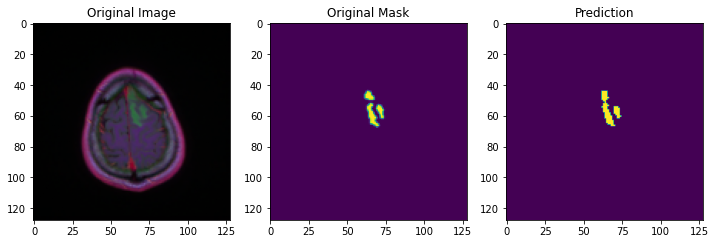

1/1 [==============================] - 0s 38ms/step


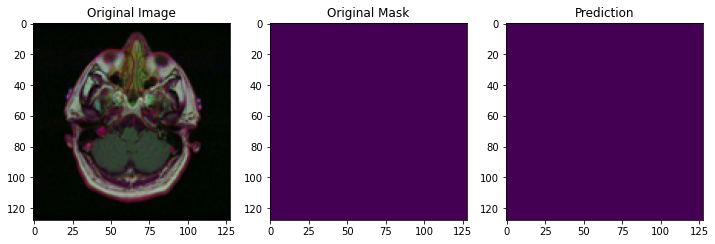

1/1 [==============================] - 0s 38ms/step


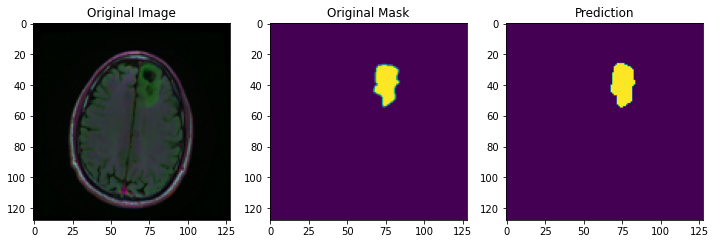

1/1 [==============================] - 0s 37ms/step


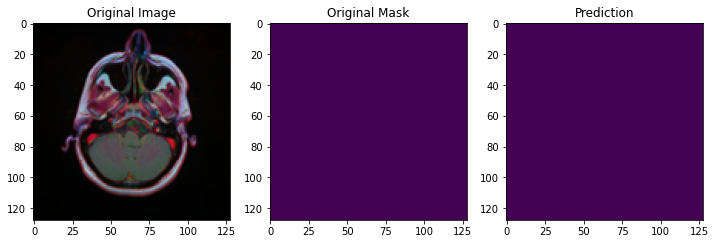

1/1 [==============================] - 0s 39ms/step


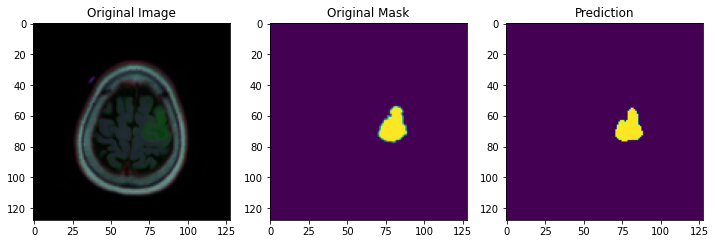

1/1 [==============================] - 0s 33ms/step


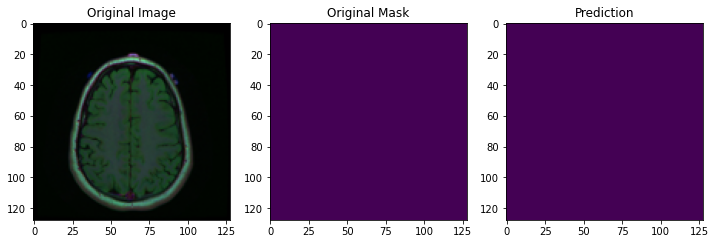

In [46]:
for i in range(6):
    index=np.random.randint(1,len(X_test))
    temp_img = X_test[index]
    ground_truth=y_test[index]
    temp_img_input=np.expand_dims(temp_img, 0)
    prediction = (model.predict(temp_img_input)[0,:,:,0] > 0.7).astype(np.uint8)

    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(temp_img_input))
    plt.title('Original Image')
    plt.subplot(1,3,2)
    plt.imshow(np.squeeze(ground_truth))
    plt.title('Original Mask')
    plt.subplot(1,3,3)
    plt.imshow(prediction)
    plt.title('Prediction')
    plt.show()